# 1. Introduction

The dataset in this capstone project is the Behavioral Risk Factor Surveillance System ([BRFSS](https://www.cdc.gov/brfss/index.html)) survey from the year 2018. This is a telephone survey that is conducted every year by the Center for Disease Control and Prevention (CDC) in all 50 US states, the District of Columbia, and 3 US territories. Typically, over 400,000 adult respondents participate each year, which makes it the largest continuously conducted health survey system in the world. The survey includes demographics-related questions (e.g., age, education level, etc.), health-related questions (e.g., asthma, cancer, dental health, etc.), and behavioral-related questions (e.g., drinking behaviors, HIV risks, etc.). 

The 2018 [codebook](https://www.cdc.gov/brfss/annual_data/2018/pdf/codebook18_llcp-v2-508.pdf) was relied on extensively for this project and contains all questions that were asked, how many responses fell in the specified categories for each question, and detailed information regarding the codes the researchers chose for categorical variables, etc. For more information on the study and its protocols, see the [BRFSS documentation](https://www.cdc.gov/brfss/data_documentation/pdf/UserguideJune2013.pdf).

# 2. Research Question

How can BRFSS respondents be segmented based on their demographics, behaviors, and health outcomes?

# 3. Data

### About the data

The 2018 BRFSS dataset comes from an XPT file (that is, SAS transport format) found [here](https://www.cdc.gov/brfss/annual_data/annual_2018.html), on the 2019 BRFSS webpage. There was a total of 437,436 observations (i.e., survey responses) and 275 columns (i.e., questions) in the dataset. Most of the data was categorical due to the nature of the survey and the way the researchers coded it, with the exception of 3 continuous variables - height, bmi, and weight.

### Cleaning the data

First, columns that had more than 20% of their data missing were removed. A large portion of these were simply gender-specific questions (such as information about PSA tests, gynecological exams, etc.), and were therefore only asked to about 50% of respondents in the first place. For this project, these types of variables weren't a necessity, so they were removed, so as not to deal with extensive amounts of null values. Several columns that were duplicates and re-codes of other columns were also removed, with a preference for columns that contained the largest amount of information - typically, columns with more categories were chosen over re-codes that condensed this information, because it was ideal for the clustering algorithms to see more variability in the data).

Second, for columns with fewer than 20% of their data missing, the missing values (recorded as nulls) were imputed with a code of 1000 to specify they were 'missing,' so this information could be analyzed along with the rest.

The three continuous variables all had under 10% of their data missing, and they were fairly normally disributed, so they were imputed with the means for each gender. That is, for male respondents missing a height, bmi, or weight, the variables' respective means for males were imputed, and likewise for female respondents.

The race variable only had 2% of its data missing, so it was imputed with the dataset's mode (which in this case was white).

The age variable (which was only recorded as categorical for some reason) also had only 2% of its data missing, so it was imputed with the median age category in the dataset. 

Third, columns were re-coded so that they began with 0 rather than 1, which was needed for the clustering algorithms. Additionally, many columns were in "backwards" order - e.g., 0 means yes, and 1 means no - so these was re-coded so that 0 was alwas the negative case, to make later interpretation easier.

At the end of cleaning, there were still 437,436 observations, and 68 features remained, which was sufficient .

In [1]:
import pandas as pd
import numpy as np
from zipfile import ZipFile
import xport
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image
from IPython.core.display import HTML 
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN, KMeans, AgglomerativeClustering
from kmodes.kmodes import KModes
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn import metrics
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.stats import spearmanr
import statsmodels.api as sm
import statsmodels.formula.api as smf
import time
import sys
import warnings

warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
with open('./LLCP2018.XPT ', 'rb') as f:
    brfss = xport.to_dataframe(f)

In [3]:
brfss.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 437436 entries, 0 to 437435
Columns: 275 entries, _STATE to _AIDTST3
dtypes: float64(269), object(6)
memory usage: 917.8+ MB


In [4]:
brfss.head()

_STATE  FMONTH     IDATE IMONTH IDAY IYEAR  DISPCODE       SEQNO  \
0     1.0     1.0  01052018     01   05  2018    1100.0  2018000001   
1     1.0     1.0  01122018     01   12  2018    1100.0  2018000002   
2     1.0     1.0  01082018     01   08  2018    1100.0  2018000003   
3     1.0     1.0  01032018     01   03  2018    1100.0  2018000004   
4     1.0     1.0  01122018     01   12  2018    1100.0  2018000005   

           _PSU  CTELENM1  ...  _MAM5022  _RFPAP34  _RFPSA22  _RFBLDS3  \
0  2.018000e+09       1.0  ...       NaN       NaN       NaN       NaN   
1  2.018000e+09       1.0  ...       NaN       1.0       NaN       NaN   
2  2.018000e+09       1.0  ...       NaN       NaN       NaN       NaN   
3  2.018000e+09       1.0  ...       NaN       NaN       2.0       2.0   
4  2.018000e+09       1.0  ...       NaN       NaN       NaN       NaN   

   _COL10YR  _HFOB3YR  _FS5YR  _FOBTFS  _CRCREC  _AIDTST3  
0       NaN       NaN     NaN      NaN      NaN       2.0  
1       NaN       NaN     NaN      NaN      NaN       2.0  
2       NaN       NaN     NaN      NaN      NaN       2.0  
3       2.0       2.0     2.0      2.0      2.0       2.0  
4       NaN       NaN     NaN      NaN      NaN       2.0  

[5 rows x 275 columns]

First off, I will check how many features have a very large amount of null values and decide how to deal with them.

In [5]:
# Making sure all variables' nulls are printed out
pd.set_option('display.max_rows', 275)

In [6]:
brfss.isnull().sum()

_STATE           0
FMONTH           0
IDATE            0
IMONTH           0
IDAY             0
IYEAR            0
DISPCODE         0
SEQNO            0
_PSU             0
CTELENM1    272154
PVTRESD1    272154
COLGHOUS    437404
STATERE1    272154
CELLFON4    272154
LADULT      437404
NUMADULT    272171
NUMMEN      272177
NUMWOMEN    272180
SAFETIME    165282
CTELNUM1    165282
CELLFON5    165282
CADULT      165285
PVTRESD3    165284
CCLGHOUS    436115
CSTATE1     165285
LANDLINE    165286
HHADULT     165295
GENHLTH         25
PHYSHLTH        26
MENTHLTH        25
POORHLTH    205475
HLTHPLN1        23
PERSDOC2       896
MEDCOST        897
CHECKUP1       895
EXERANY2        25
SLEPTIM1        23
CVDINFR4        23
CVDCRHD4        23
CVDSTRK3        23
ASTHMA3         23
ASTHNOW     375620
CHCSCNCR        23
CHCOCNCR        23
CHCCOPD1        23
HAVARTH3        25
ADDEPEV2        24
CHCKDNY1        24
DIABETE3        24
DIABAGE2    376733
LASTDEN4        27
RMVTETH4        28
SEX1        

In [7]:
# 20% of the total observations is:
.20 * 437436

87487.20000000001

Imputing more than 20% of a variable's data may make that data unreliable, so I don't really want columns that have more than 20% of their data missing. Therefore, I'm going to remove those. 

Then, I'll go from there in deciding how to deal with the rest of the null values and deciding which columns I want to keep.

In [8]:
# Make copy so original data doesn't get lost
smaller_brfss = brfss.copy()

# Remove columns with more than 20% of their data missing
smaller_brfss = smaller_brfss.dropna(axis=1, thresh=349949) #Comment this in final

In [9]:
smaller_brfss.isnull().sum()

_STATE          0
FMONTH          0
IDATE           0
IMONTH          0
IDAY            0
IYEAR           0
DISPCODE        0
SEQNO           0
_PSU            0
GENHLTH        25
PHYSHLTH       26
MENTHLTH       25
HLTHPLN1       23
PERSDOC2      896
MEDCOST       897
CHECKUP1      895
EXERANY2       25
SLEPTIM1       23
CVDINFR4       23
CVDCRHD4       23
CVDSTRK3       23
ASTHMA3        23
CHCSCNCR       23
CHCOCNCR       23
CHCCOPD1       23
HAVARTH3       25
ADDEPEV2       24
CHCKDNY1       24
DIABETE3       24
LASTDEN4       27
RMVTETH4       28
SEX1            0
MARITAL        35
EDUCA          34
RENTHOM1       38
VETERAN3      558
EMPLOY1      1236
CHILDREN     1977
INCOME2      4394
WEIGHT2      6447
HEIGHT3      7198
DEAF         9081
BLIND        9883
DECIDE      10703
DIFFWALK    11528
DIFFDRES    12072
DIFFALON    12843
SMOKE100    13844
USENOW3     14551
ALCDAY5     16226
FLUSHOT6    18774
PNEUVAC4    19760
SEATBELT    20809
HIVTST6     29581
HIVRISK5    31217
DLYOTHER  

In [10]:
smaller_brfss.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 437436 entries, 0 to 437435
Columns: 111 entries, _STATE to _AIDTST3
dtypes: float64(105), object(6)
memory usage: 370.4+ MB


Okay, already this is a lot easier to work with. But, fortunately, I still have lots of features to choose from. The next thing I'm going to do is remove columns that will not be useful to this analysis, as - after reading through the codebook a few times - I know there are some variables I want to eliminate right away, either because they are duplicates of other variables or because they are not relevant. This can help cut down on the dimensionality as well.

In [11]:
smaller_brfss = smaller_brfss.drop(columns=['FMONTH',
                                            'IDATE', 
                                            '_PSU',
                                            'DLYOTHER',
                                            '_STSTR',
                                            '_RAWRAKE',
                                            '_WT2RAKE',
                                            '_DUALUSE',
                                            '_LLCPWT2',
                                            '_LLCPWT',
                                            '_PRACE1',
                                            '_MRACE1',
                                            '_RACE_G1',
                                            '_AGE65YR',
                                            '_AGE80',
                                            '_AGE_G',
                                            'HTM4'
                                             ])

In [12]:
smaller_brfss.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 437436 entries, 0 to 437435
Data columns (total 94 columns):
_STATE      437436 non-null float64
IMONTH      437436 non-null object
IDAY        437436 non-null object
IYEAR       437436 non-null object
DISPCODE    437436 non-null float64
SEQNO       437436 non-null object
GENHLTH     437411 non-null float64
PHYSHLTH    437410 non-null float64
MENTHLTH    437411 non-null float64
HLTHPLN1    437413 non-null float64
PERSDOC2    436540 non-null float64
MEDCOST     436539 non-null float64
CHECKUP1    436541 non-null float64
EXERANY2    437411 non-null float64
SLEPTIM1    437413 non-null float64
CVDINFR4    437413 non-null float64
CVDCRHD4    437413 non-null float64
CVDSTRK3    437413 non-null float64
ASTHMA3     437413 non-null float64
CHCSCNCR    437413 non-null float64
CHCOCNCR    437413 non-null float64
CHCCOPD1    437413 non-null float64
HAVARTH3    437411 non-null float64
ADDEPEV2    437412 non-null float64
CHCKDNY1    437412 non-null f

Okay, some of these variables are still duplicates of each other, because some that were initally continuous were recoded in categorical buckets as well. Additionally, even some that were initally categorical were recoded into more condensed categorical buckets. There are pros and cons of doing this - on the one hand, the data is nicely compartmentalized when it's put into smaller buckets, so if you don't care too much about specifics and are more interested in a yes/no outcome, this type of variable could work well. On the other hand, condensing variables loses a lot of the variable's specificity and granularity. 

So, what I'm going to do now is compare these basically duplicate variables side by side to see which version of each I think will be most useful for this clustering analysis.

In [13]:
# Make all var names lowercase
smaller_brfss.columns = smaller_brfss.columns.str.lower()

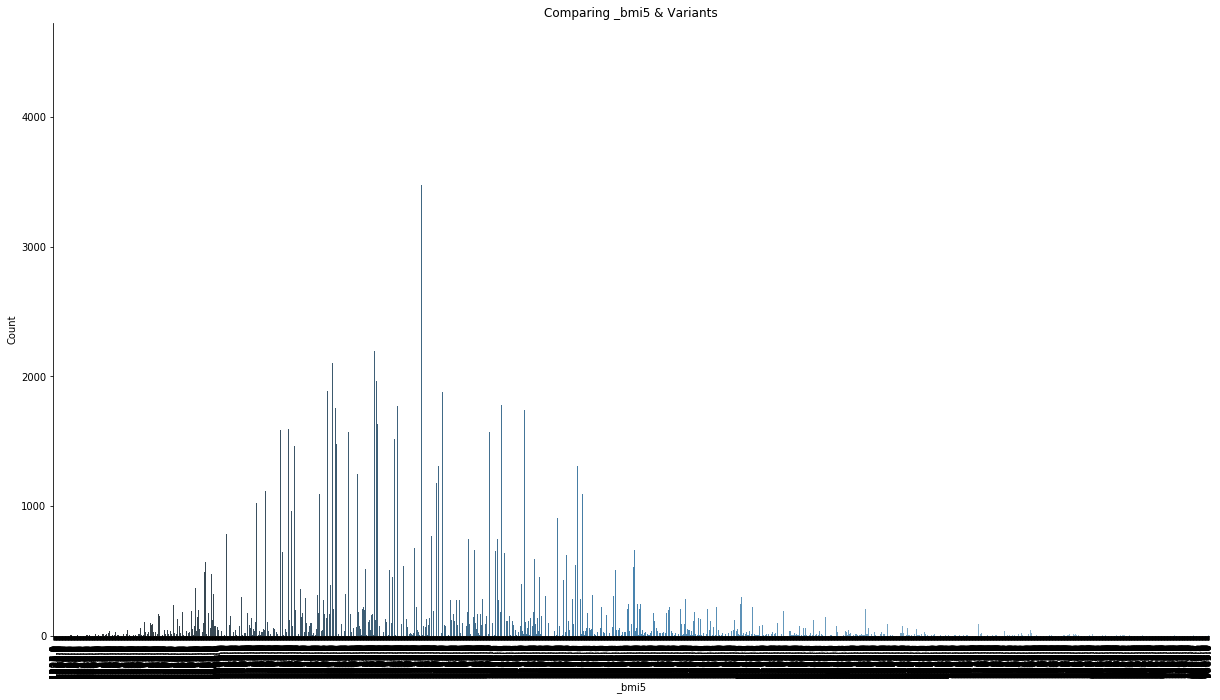

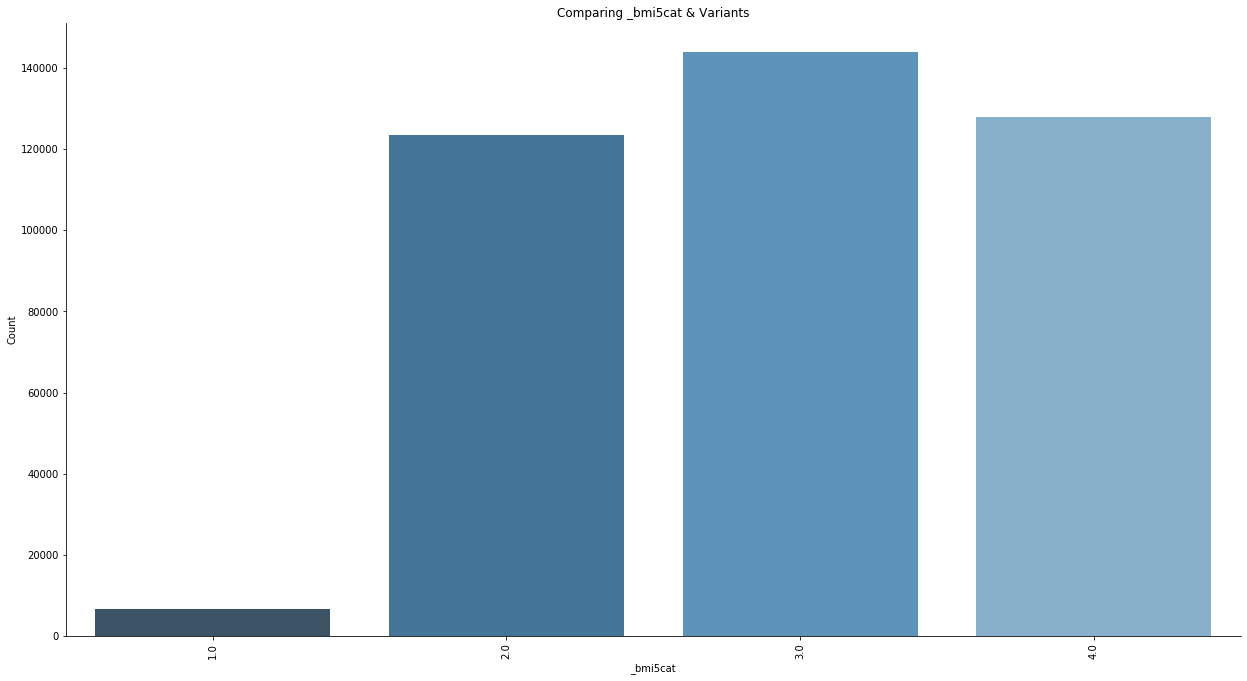

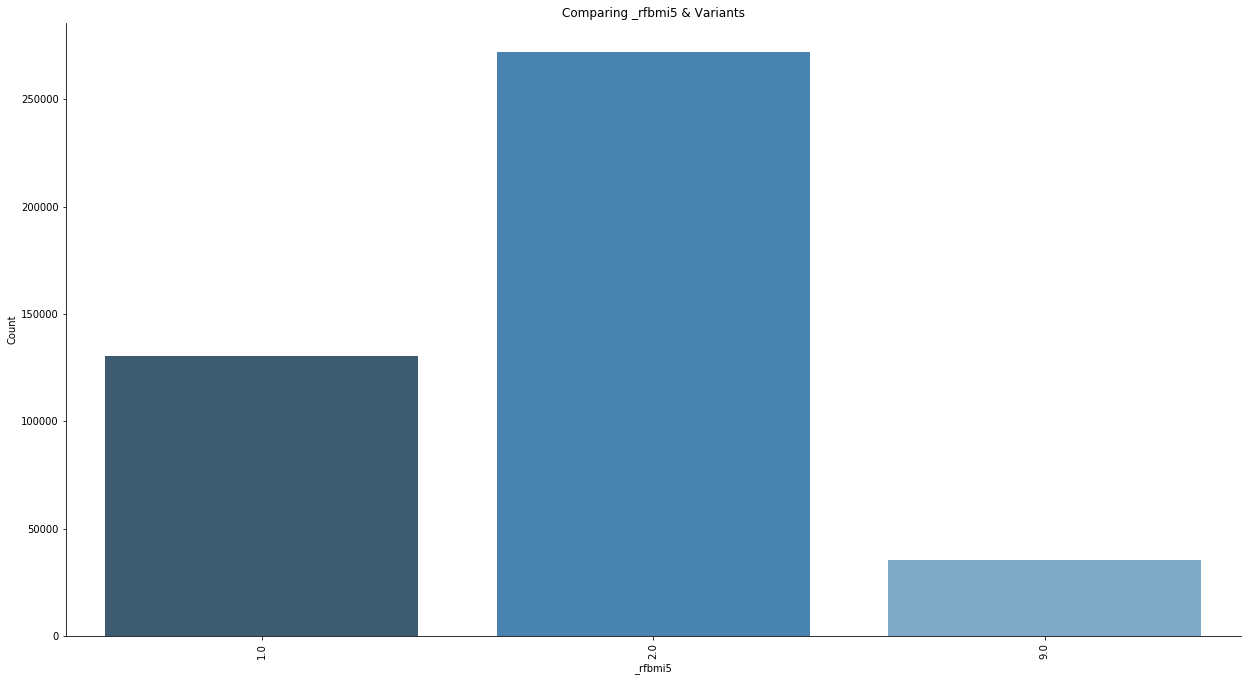

In [14]:
# First, we'll look at BMI; there are actually 3 options for this var

def plot_to_compare(var_list, df_name):
    
    # For each unique value of the df_obj, find the right number of subplots, and plot each bar graph accordingly
    for i, var in enumerate(var_list):

        sns.catplot(x=var, kind='count', palette='Blues_d', data=df_name)
        
        # Add appropriate titles, labels, and spacing
        plt.gcf().set_size_inches(20, 10)
        plt.title('Comparing {} & Variants'.format(var_list[i]))
        plt.xlabel('{}'.format(var_list[i]))    
        plt.ylabel('Count')
        plt.xticks(rotation='vertical')
        plt.show()
        
    

#Calling the function for BMI variants

plot_to_compare(['_bmi5', '_bmi5cat', '_rfbmi5'], smaller_brfss)
    

I'm going to keep BMI continuous. I think there's a lot more information there that just isn't captured properly by the categorical versions. I also think that having it be a continuous variable will be easier for the algorithms to process.

Choice: **bmi5**

Next I'll compare the different variations of the race variable.

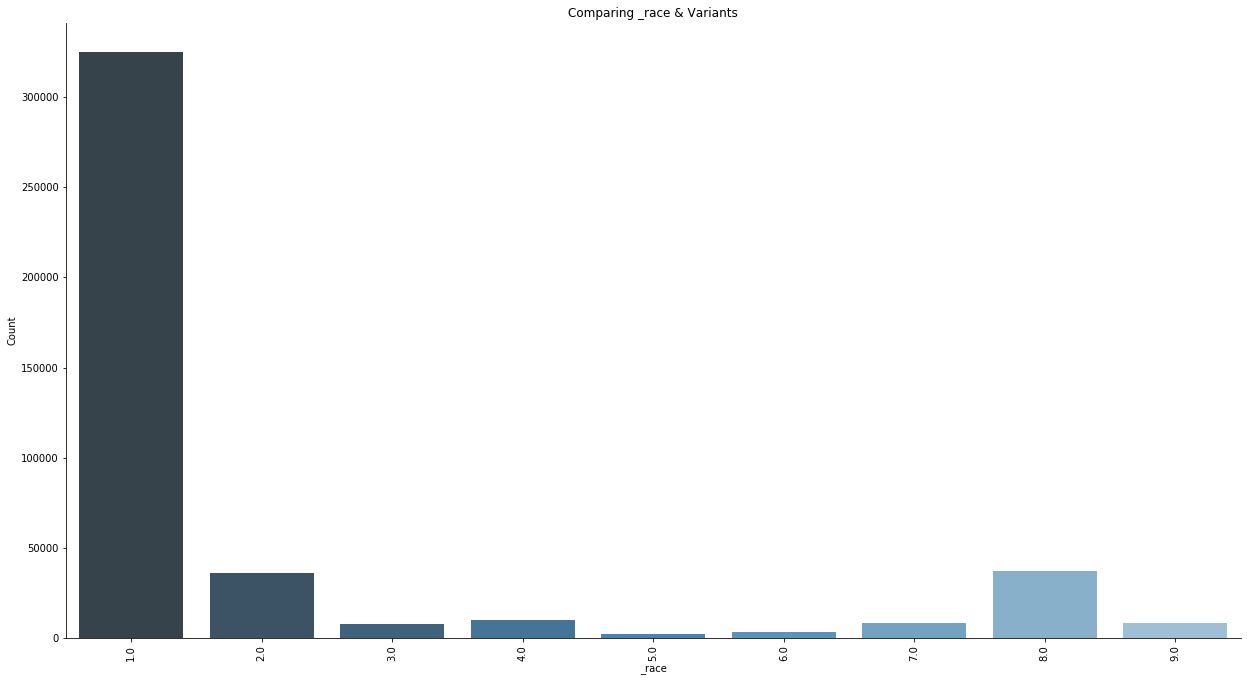

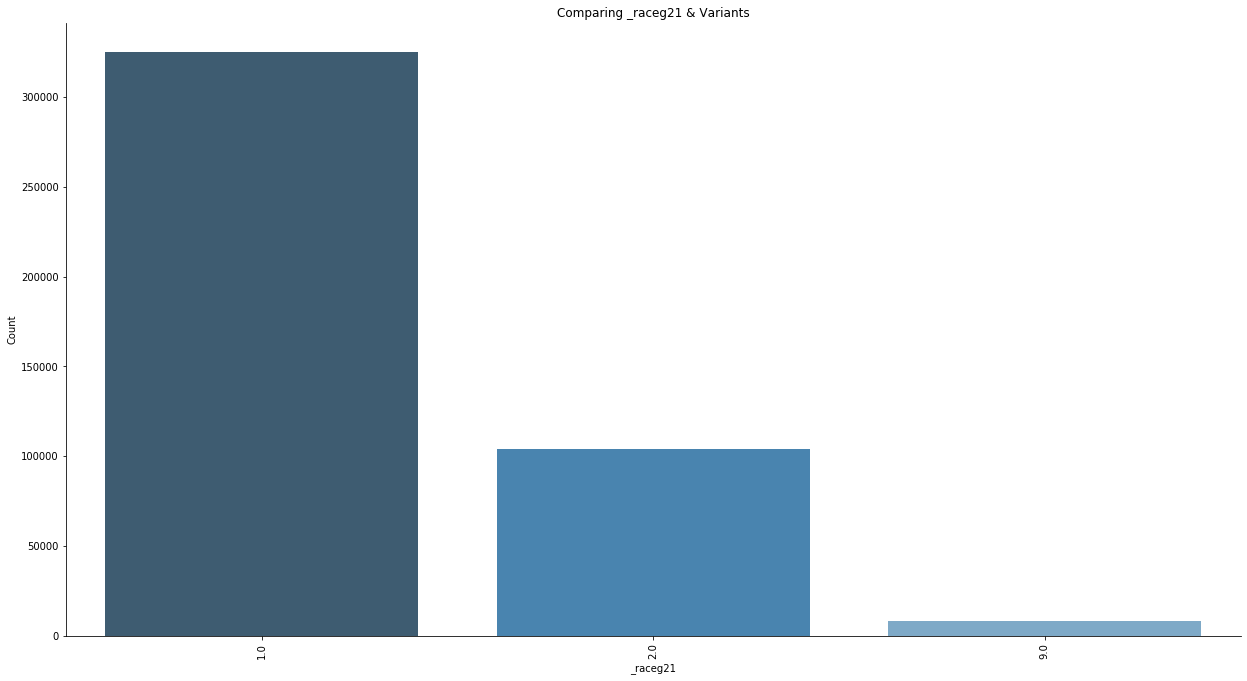

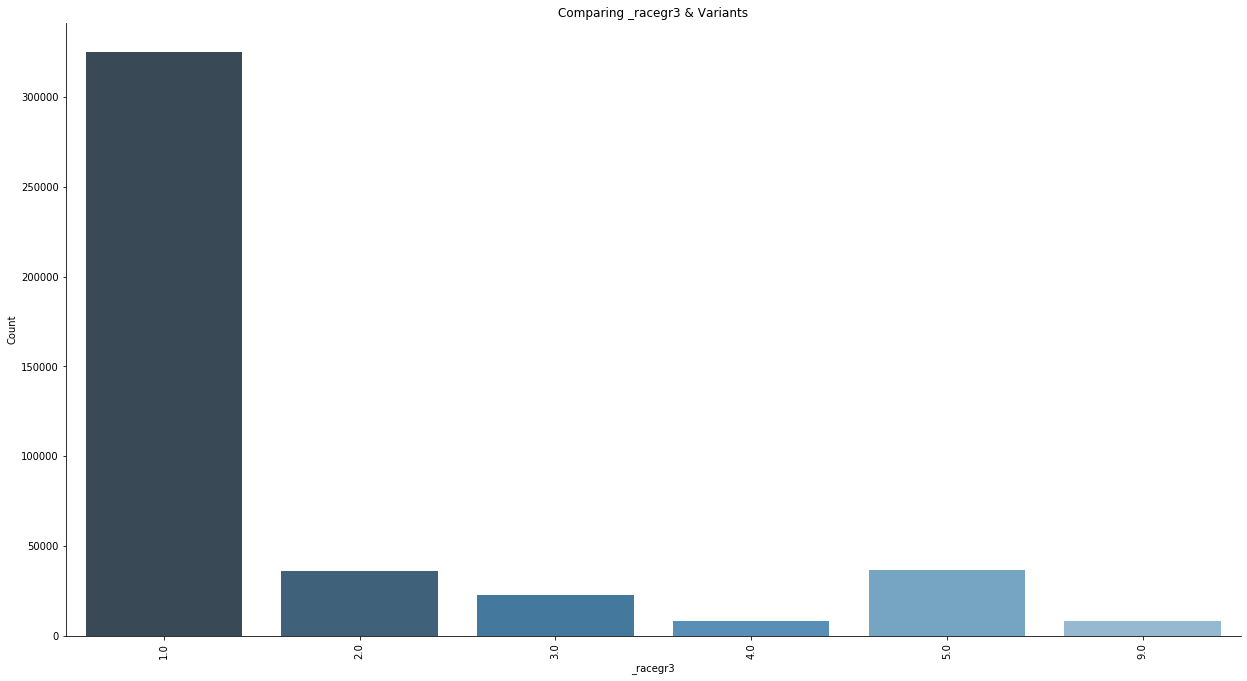

In [15]:
#Calling the function for race variants

plot_to_compare(['_race', '_raceg21', '_racegr3'], smaller_brfss)

I think the race variable I will use for further EDA and potentially include in the algorithms is the first one, just called 'race'. This one includes groups like 'American Indian or Alaskan Native' and 'Native Hawaiian,' etc. I'd rather err on the side of granularity with this one, simply because I don't want to dilute/remove anything that may prove important.

(I should note here that I do also have the option to use the 'imprace' variable, which I did not plot above. This variable has no missing values, because the most common race/ethnicity for the respondents' state was imputed for each missing value. I doubt I will want to use this, however, since one of the categories, 'Native Hawaiian/Pacific Islander' was lumped in with 'other' in this imputed version.)

Choice: **_race**

Next I'll look at the variants of 'genhlth,' which examined how respondents' rates their general health condition. (As a sidenote, any variable with an underscore in front of it has been condensed in some way from its original form.)

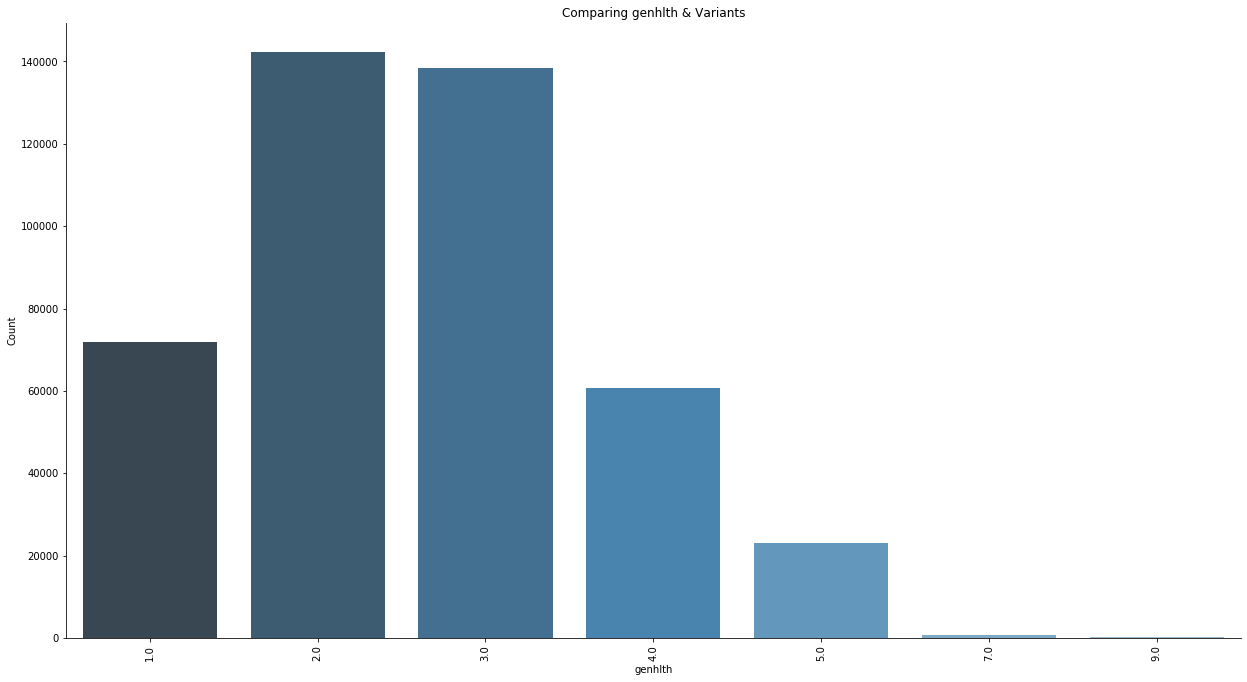

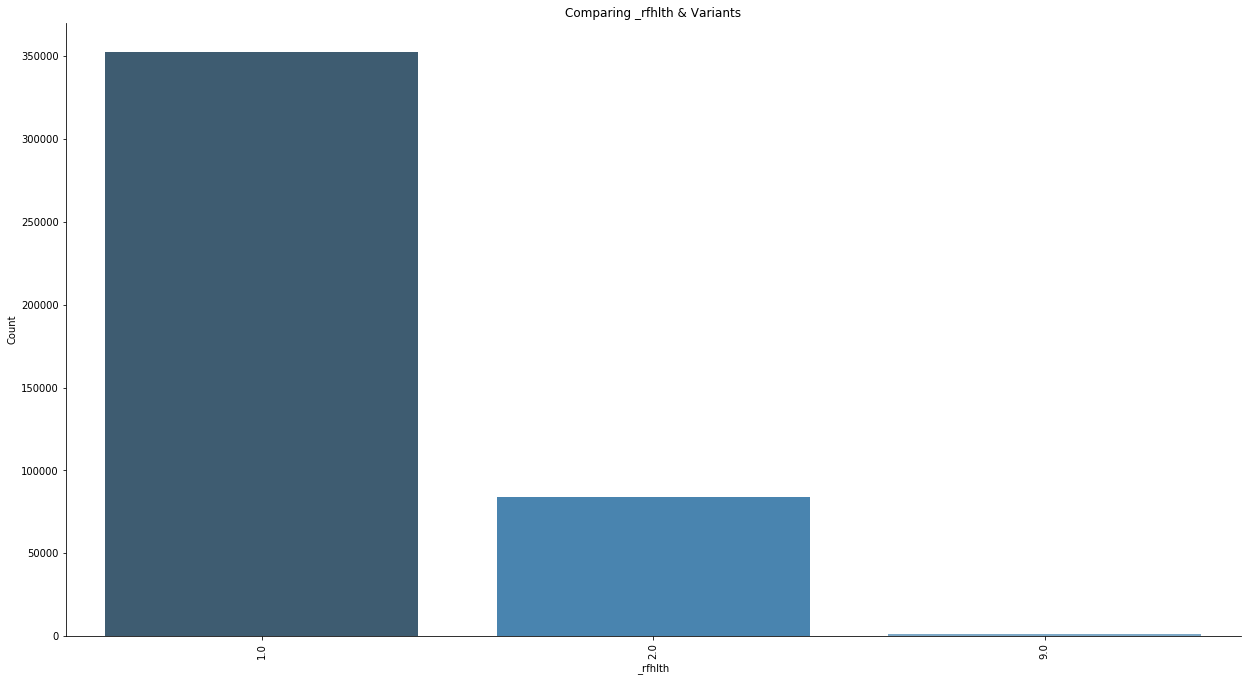

In [16]:
#Calling the function for gen health variants 

plot_to_compare(['genhlth', '_rfhlth'], smaller_brfss)

The bottom plot, 'rfhlth' uses 1 for respondents who rated their health either as 'good' OR 'better,' while 2 means respondents said they had 'fair' OR 'poor' health. 9 is those who didn't know, refused, or were missing. 

The top variable, genhlth, goes from excellent to very good to good to fair to poor. Here, don't know, refused, and missing are not collapsed into one category. Again, I think I'll stick with the non-condensed variable, genhlth, so as not to lose any info.

Choice: **genhlth**

Next we'll examine a similar variable and its variant - physhlth.

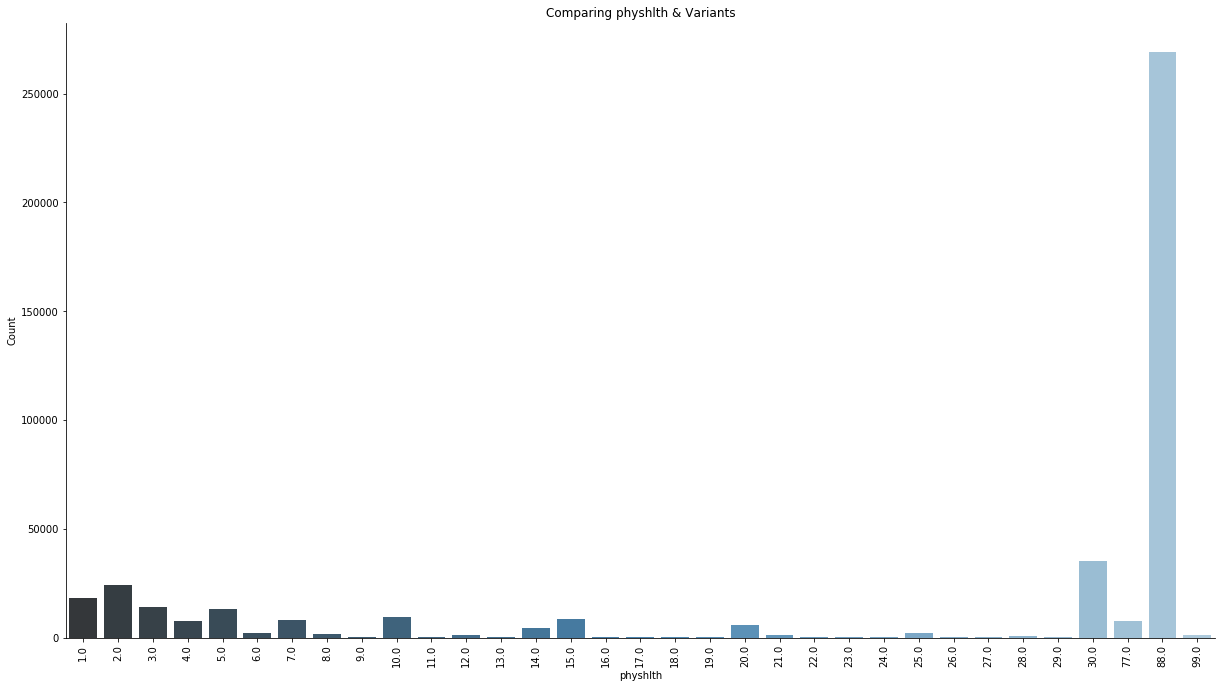

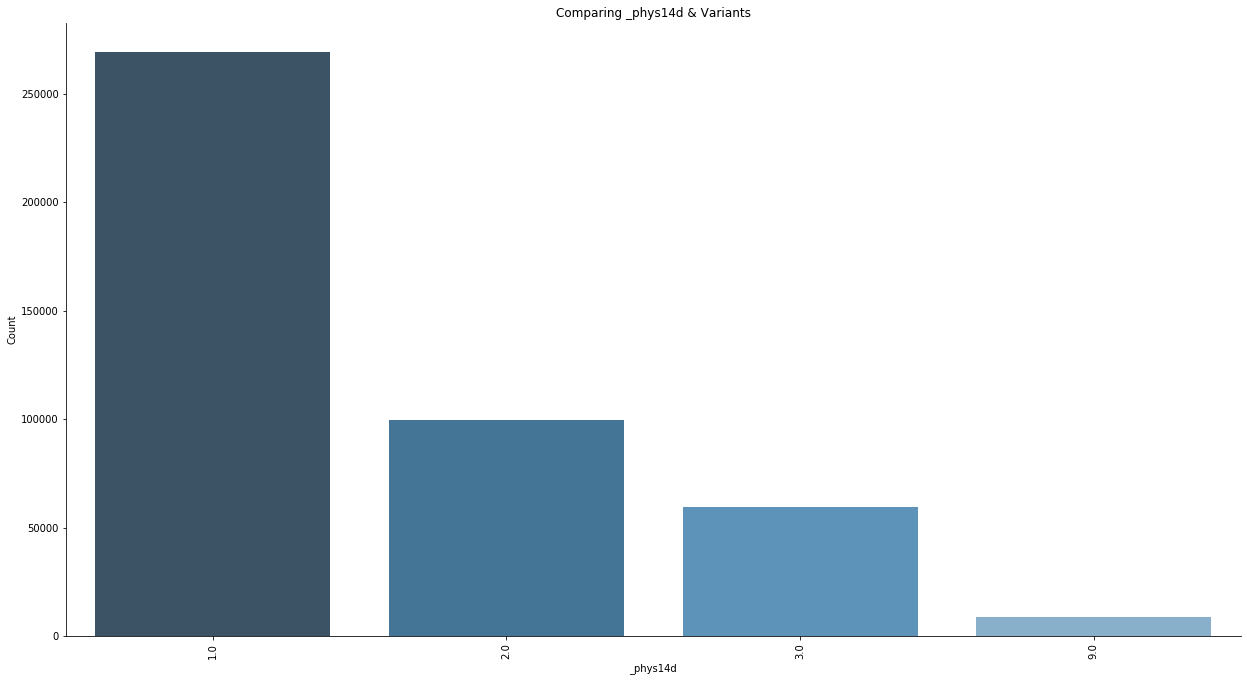

In [17]:
#Calling the function for phys health variants

plot_to_compare(['physhlth', '_phys14d'], smaller_brfss)

So, even though the first variable, physhlth, isn't exactly continuous (it asked respondents to think back to the past 30 days and say on how many days was their physical health not good), it does contain a lot more information than the condensed version, of course. I think, at least for now, I will go forward using the non-condensed version, because I think it will probably be easier for the algorithms to measure distance between points here, since each day is exactly one day away from the next day, as opposed to the more arbitrary distance between each bucket in the condesned version.

Choice: **physhlth**

Next I'll look at mental health & its variant.

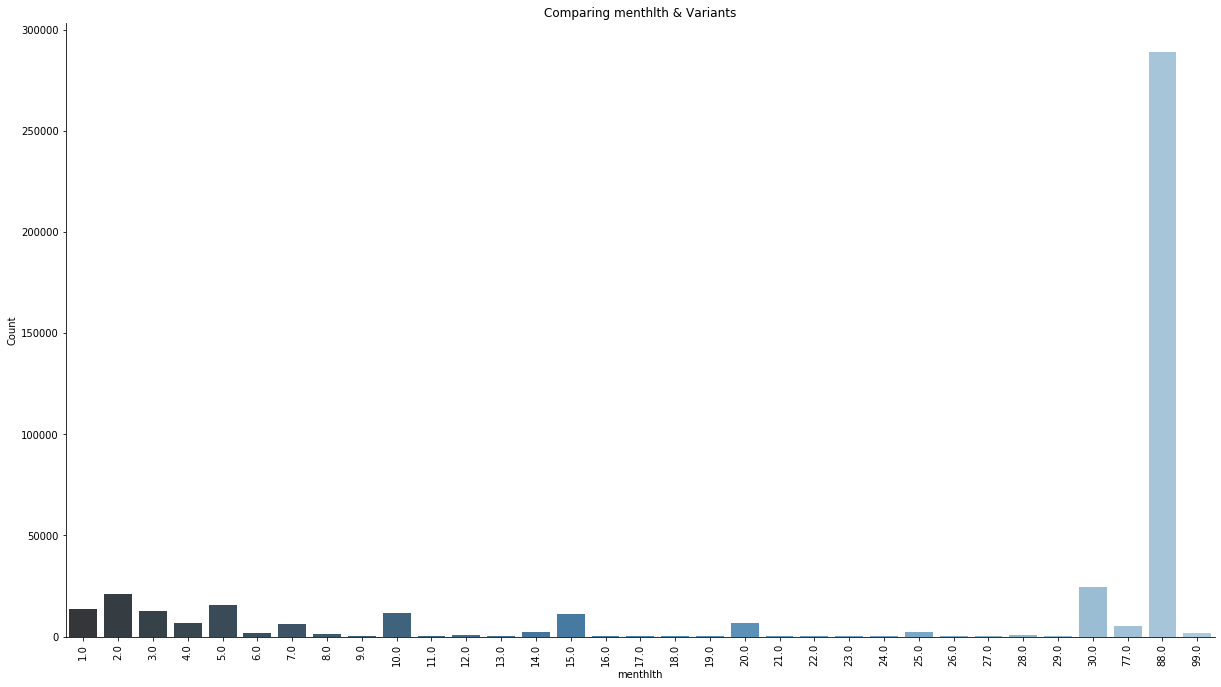

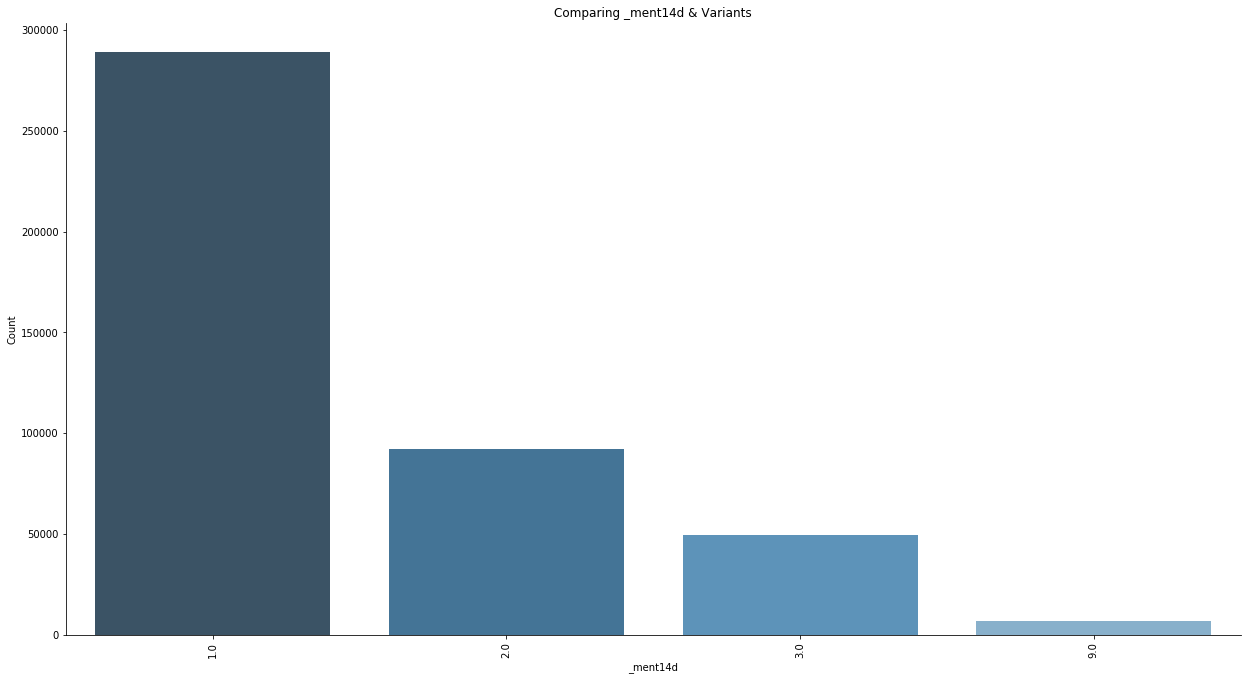

In [18]:
#Calling the function for mental health variants

plot_to_compare(['menthlth', '_ment14d'], smaller_brfss)

Ditto my reasoning on physhlth. The algorithms should be better able to measure the distance between values if I use the non-condensed version of the mental health variable. (The 88 on the far right means 0 days, so when I recode variables to begin with 0, I will make 88 be 0, to stand for 0 days.)

Choice: **menthlth**

Next up is hlthpln - where respondents were asked if they had any kind of health care coverage (1=Yes, 2=No, etc.)

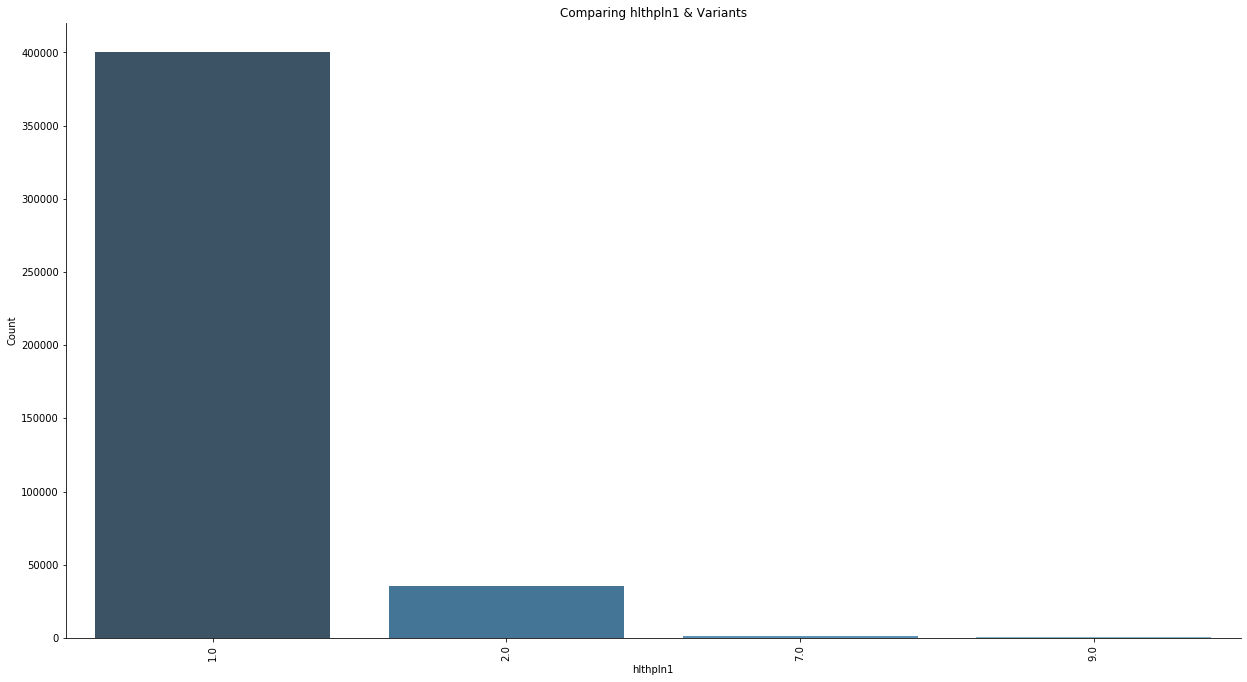

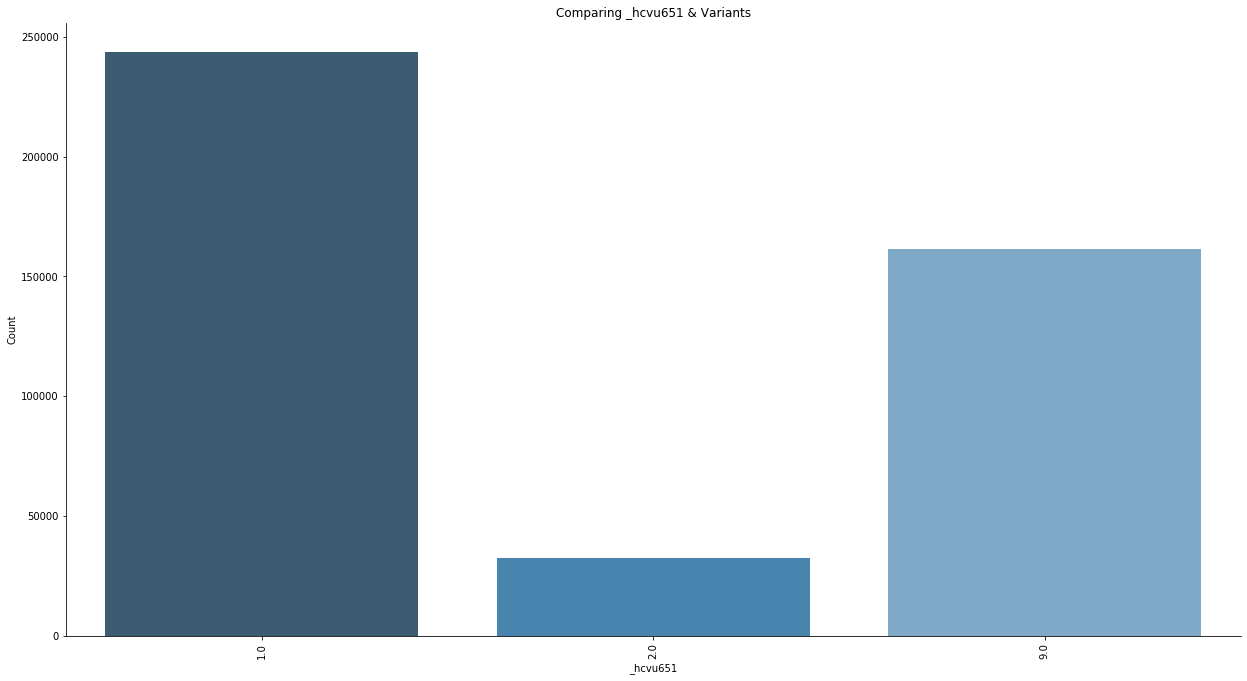

In [19]:
#Calling the function for health plan & variants

plot_to_compare(['hlthpln1', '_hcvu651'], smaller_brfss)

Well I think this one is a little more obvious to me - I'm going to keep the first one, because the second version only includes respondents who were ages 18-65. All respondents that I know of were at least 18 anyway, but I want to keep all ages (including elderly people) in this one.


Choice: **hlthpln1**

Next we'll look at exercise.

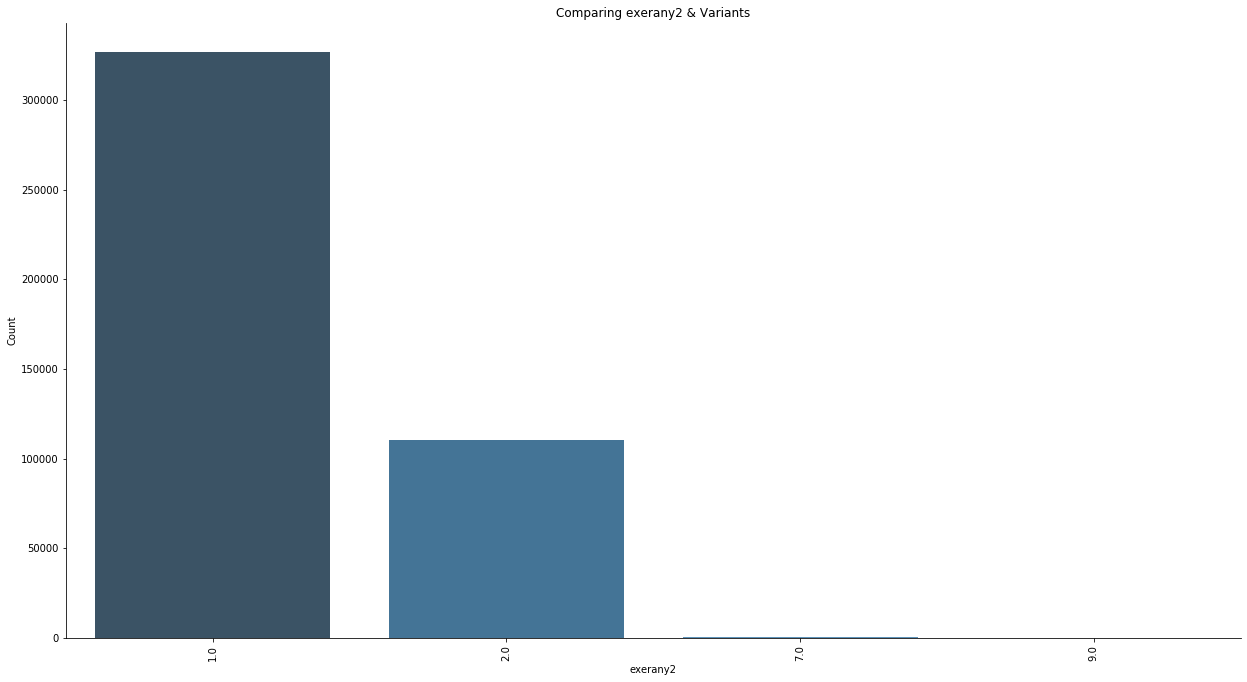

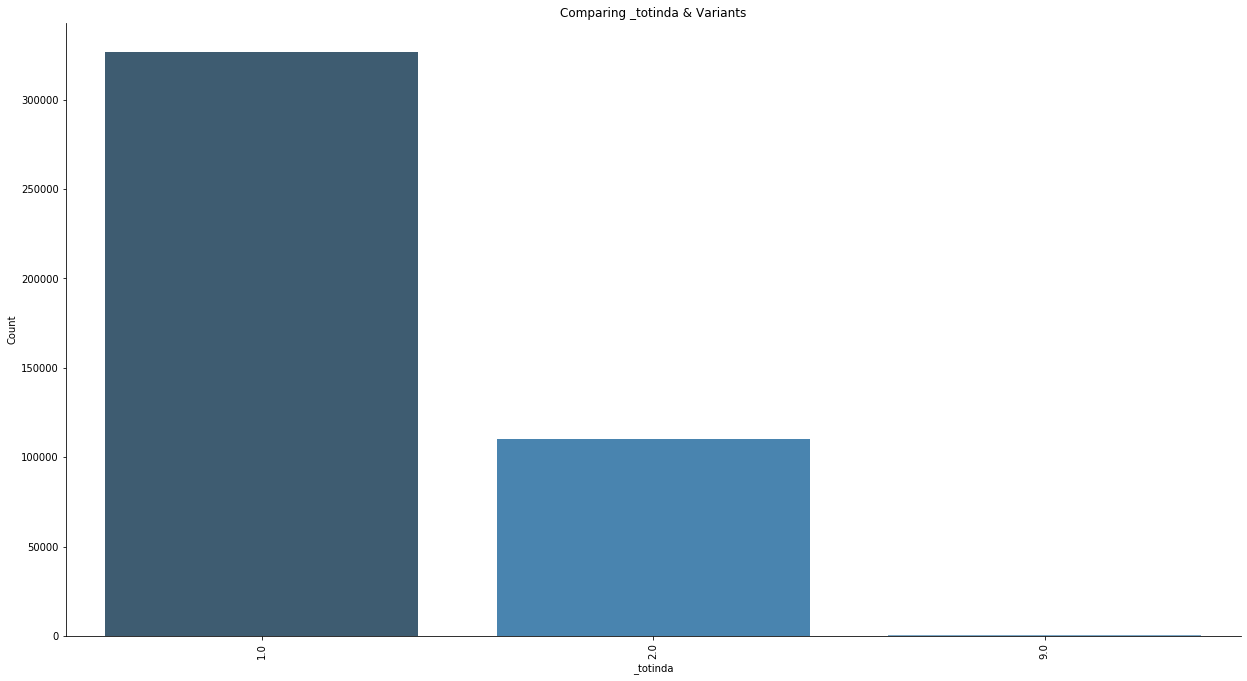

In [20]:
#Calling the function for exercise variants

plot_to_compare(['exerany2', '_totinda'], smaller_brfss)

This one is interesting, because I think I actually prefer the more condensed one (totinda) here, because these two really aren't that different from each other. The questions asked whether respondents had engaged in any exercise in the past 30 days, and answers were just recorded as yes or no, so it was already binary. Here, though, totinda collapses don't know, refused, and missing into 1 category intead of 3, which I would have done myself anyway, so this just makes it easier for me.

Choice: **_totinda**

Nest up is heart disease.

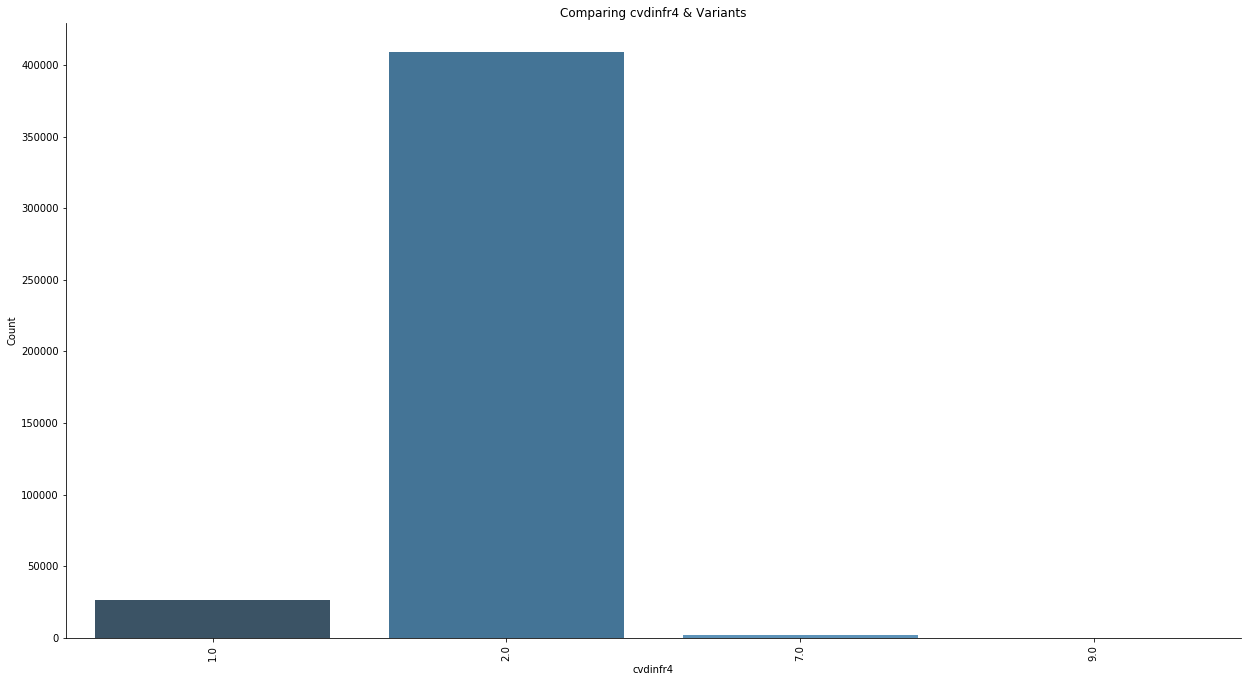

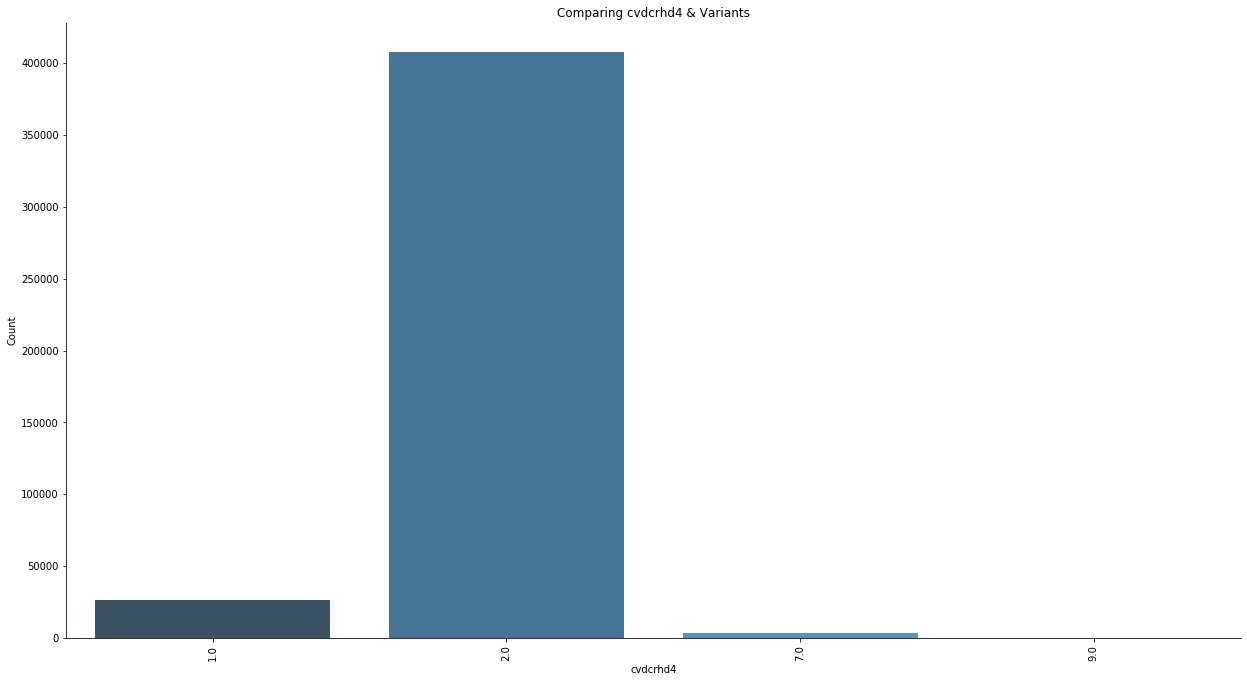

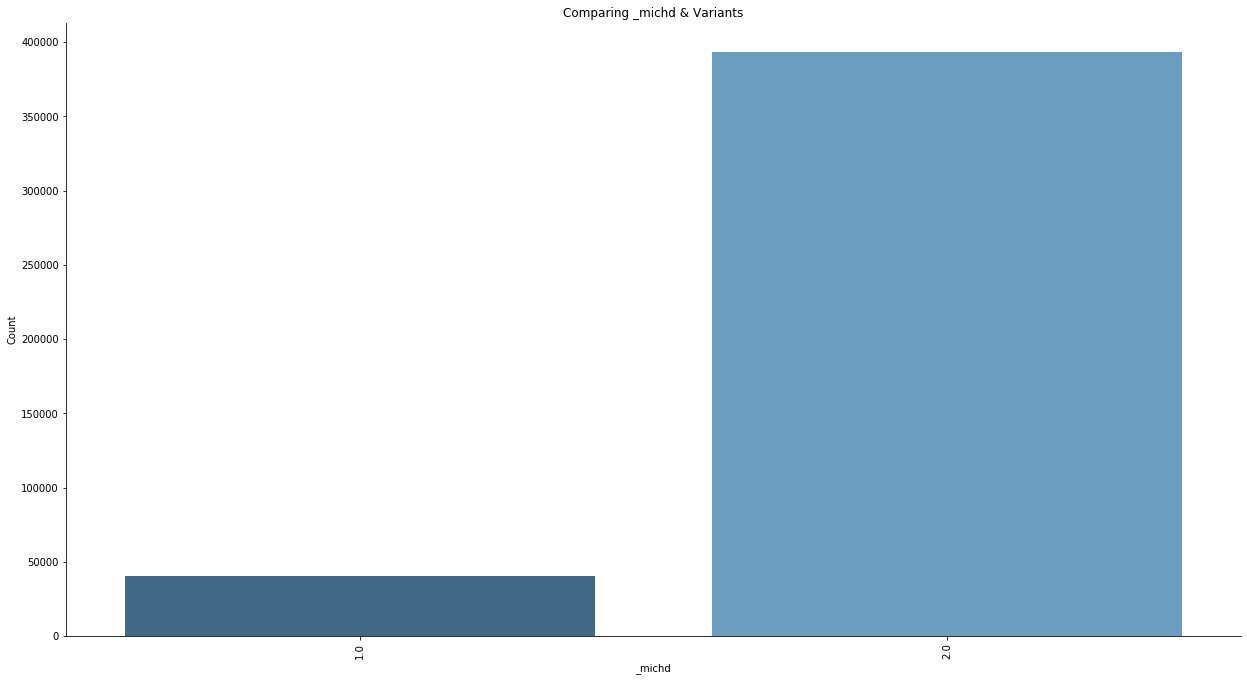

In [21]:
#Calling the function for heart disease variants

plot_to_compare(['cvdinfr4', 'cvdcrhd4', '_michd'], smaller_brfss)

This one is also interesting, because rather than condensing the buckets like other vars, it combines 2 variables into 1 - cvdinfr4 asked whether respondents ever had a heart attack (myocardial infarction), and cvdcrhd4 asked whether they'd been told they had angina or coronary heart disease. I think I don't care so much about granularity here - just whether the person has had heart issues, so I think I will use 'michd', which combines them (until further notice). But just in case, I will include the other 2 more specific variables in EDA as well, so I can learn more about them before discarding them, just to make sure they don't add anything extra that I need.

Choice: **michd** & **cvdinfr4** & **cvdcrhd4**

Next is the asthma variants.

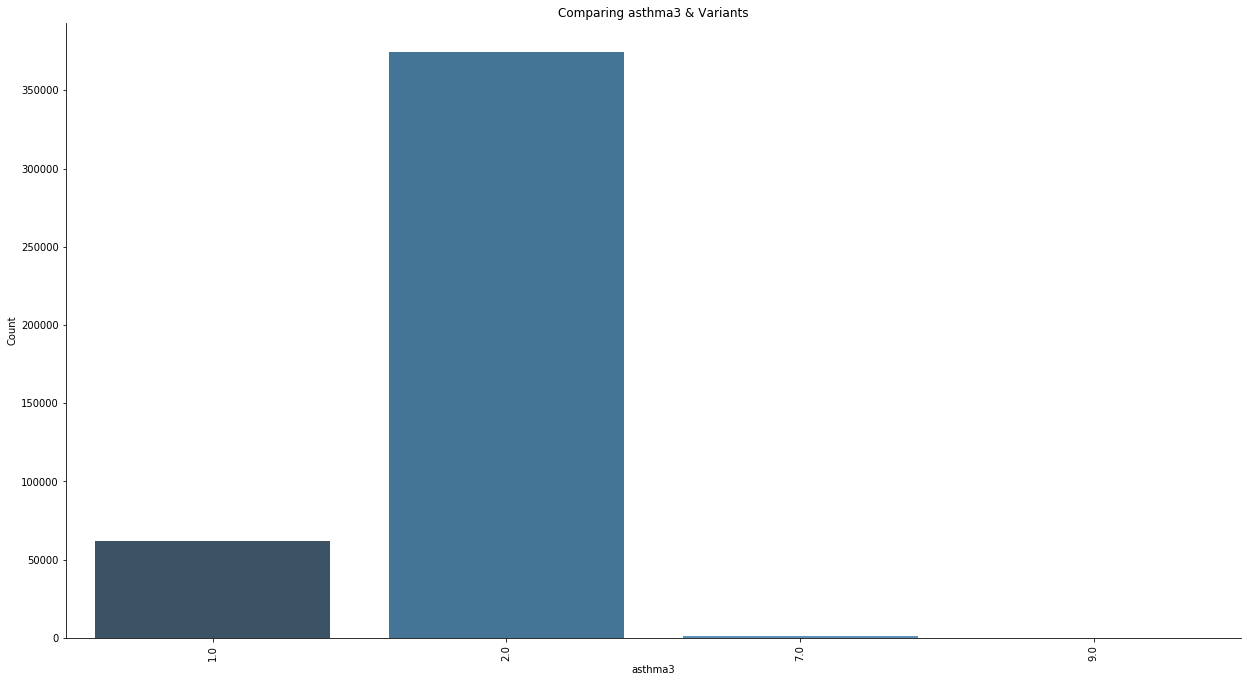

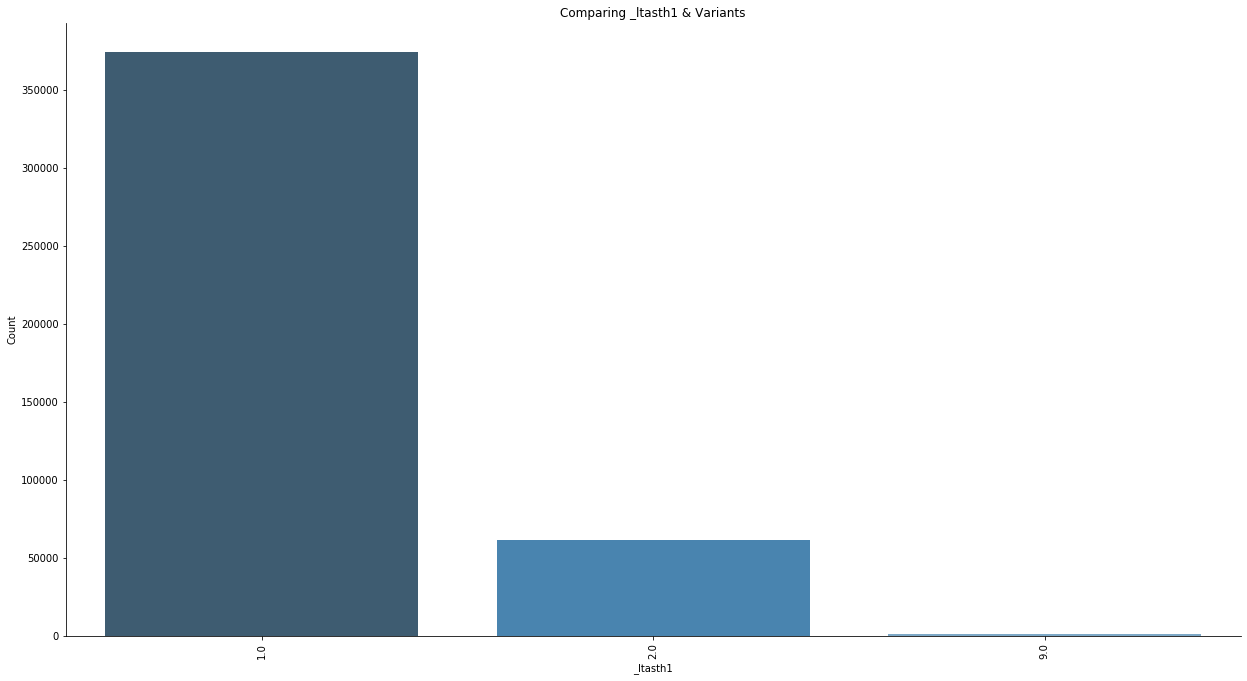

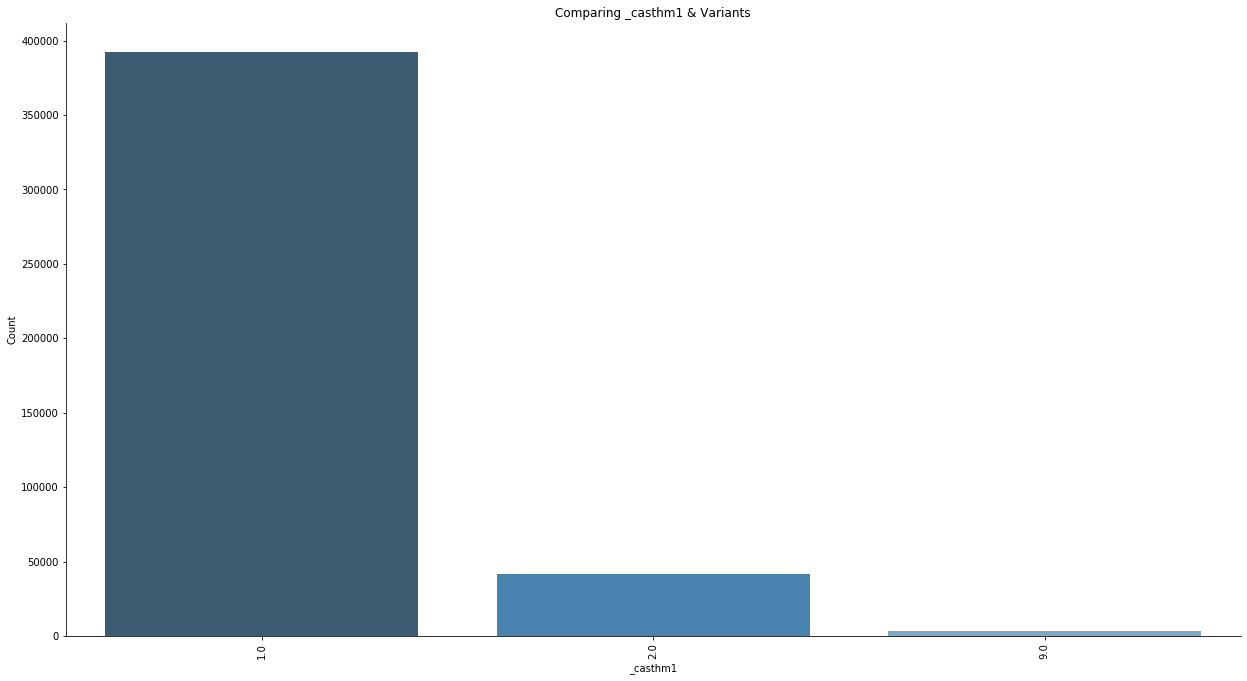

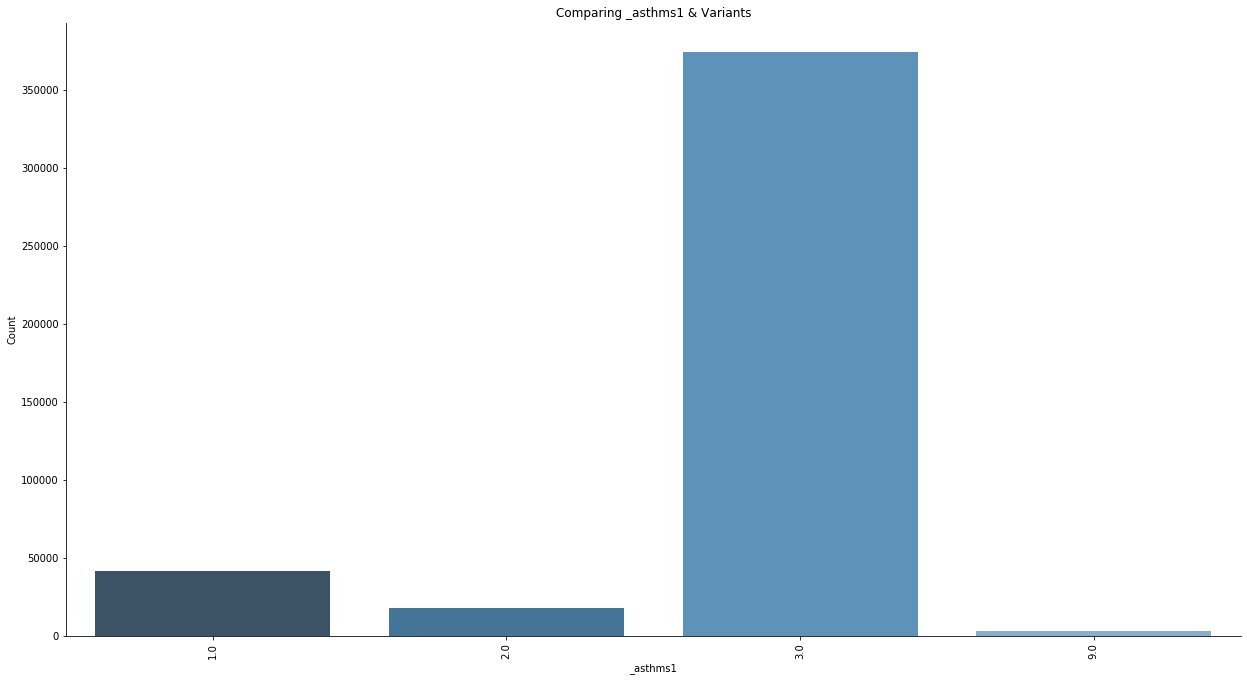

In [22]:
#Calling the function for asthma variants

plot_to_compare(['asthma3', '_ltasth1', '_casthm1', '_asthms1'], smaller_brfss)

There are so many asthma variables because the survey asked respondents if they'd ever had asthma, and then, if they had answered yes, they were asked if they currently have asthma. This set-up kind of poses an issue for analysis, however, because many adults had of course never had asthma, so they were never asked the follow-up question, which means that variable has a TON of missing data and got filtered out by me. That is why only 'asthma3' is shown above, as its follow up ('asthnow') was removed for having hundreds of thousands of missing datapoints.

*However*, the researchers also re-coded asthma, probably to avoid this problem. 'Ltasth1' only represents adults who have ever been told they have asthma, while 'casthm1' is adults who currently have asthma. These already address the problem of having so many missing data in the 'current asthma' question, but the fourth variable, 'asthms1,' combines both these questions into 1 variable, which I think is the smartest thing to use here. 1 means they currently have it, 2 means they formerly had it, and 3 means they never had it. Since this variable was never continuous in the first place, this condensing didn't really hurt anything and makes asthma easier to interpret.  

Choice: **asthms1** (initial asthma question) & **asthma3** (shows former, current, never)

Next we'll look at arthritis variants.

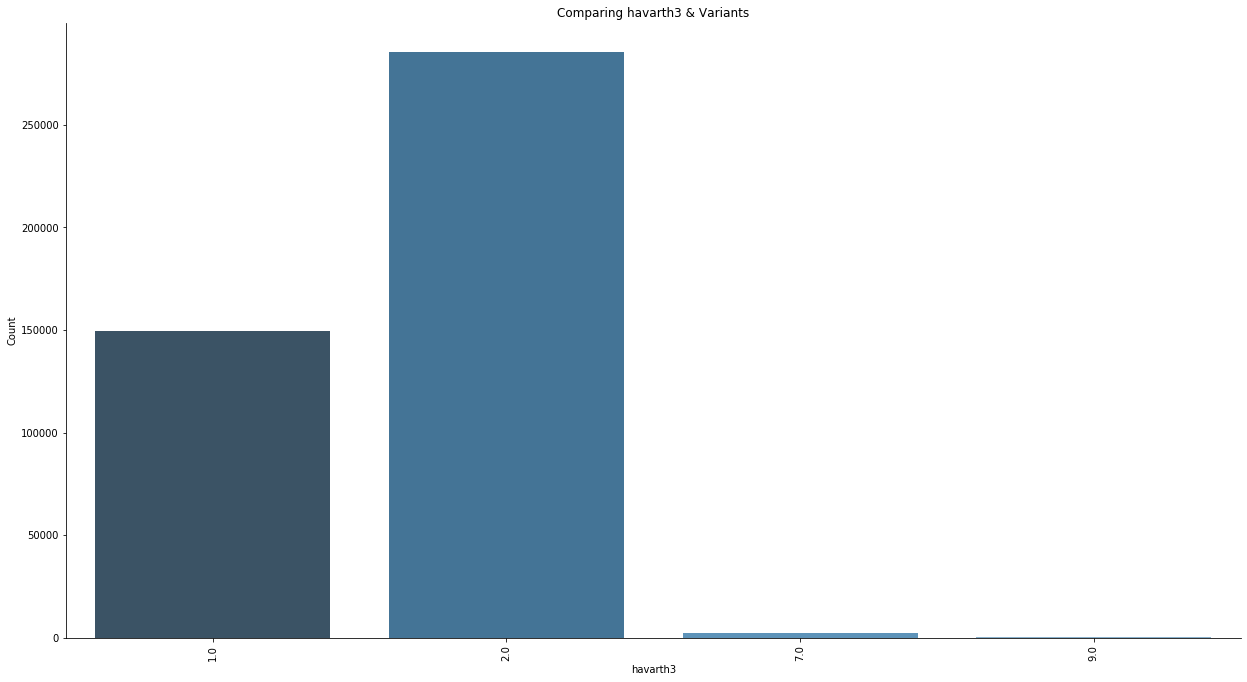

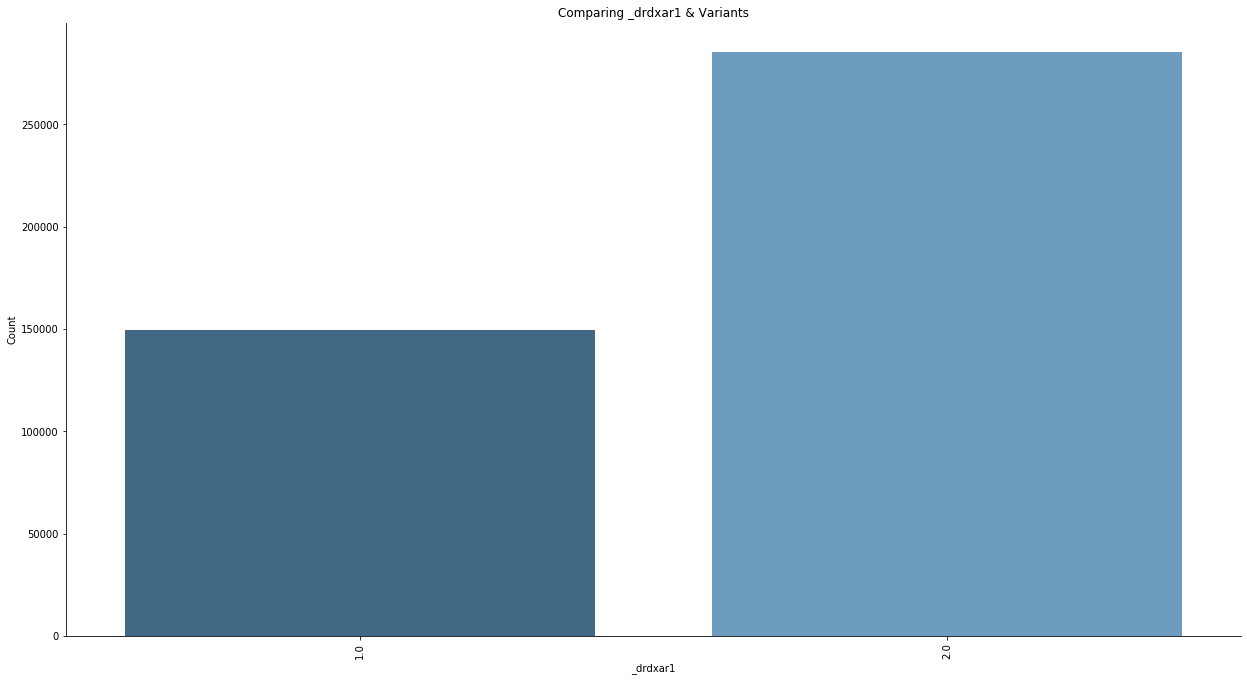

In [23]:
#Calling the function for arthritis variants

plot_to_compare(['havarth3', '_drdxar1'], smaller_brfss)

Here, the variant is also superior to the original variable, because both are binary; the variant ('drdxar1') simply combines don't know, refused, and missing into one value (which is recorded as nulls, but I can easily impute that with a code for missing).

Choice: **_drdxar1**

Next is tooth extractions.

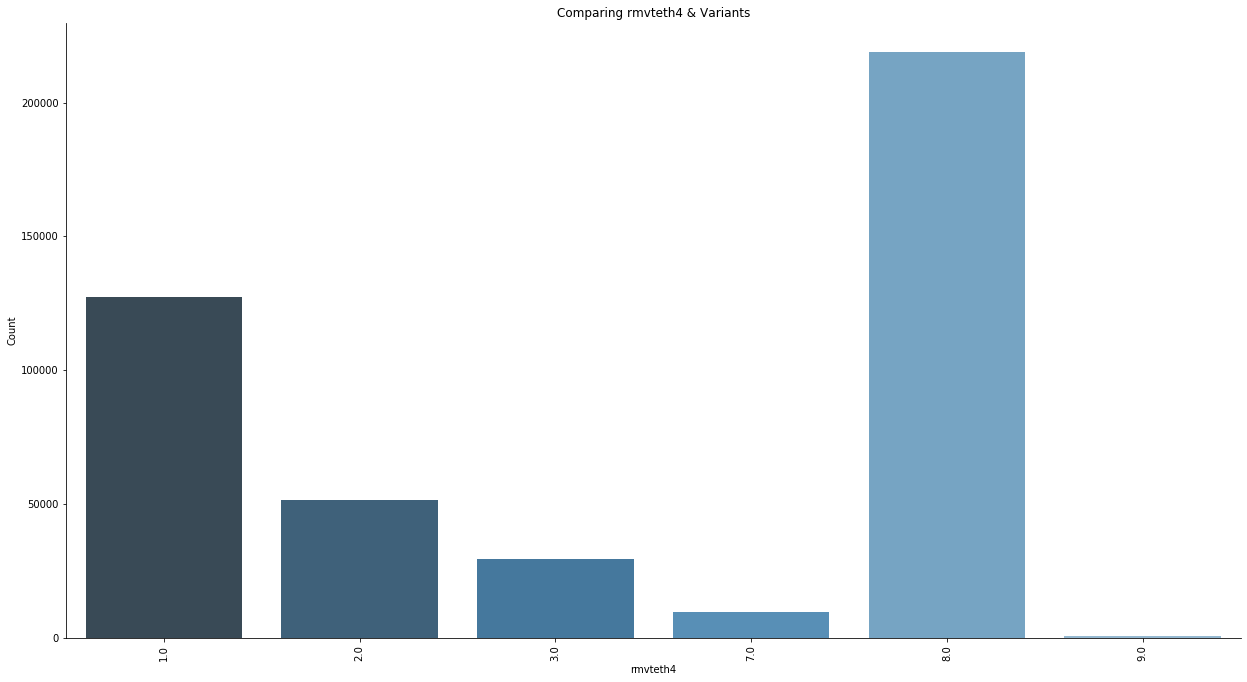

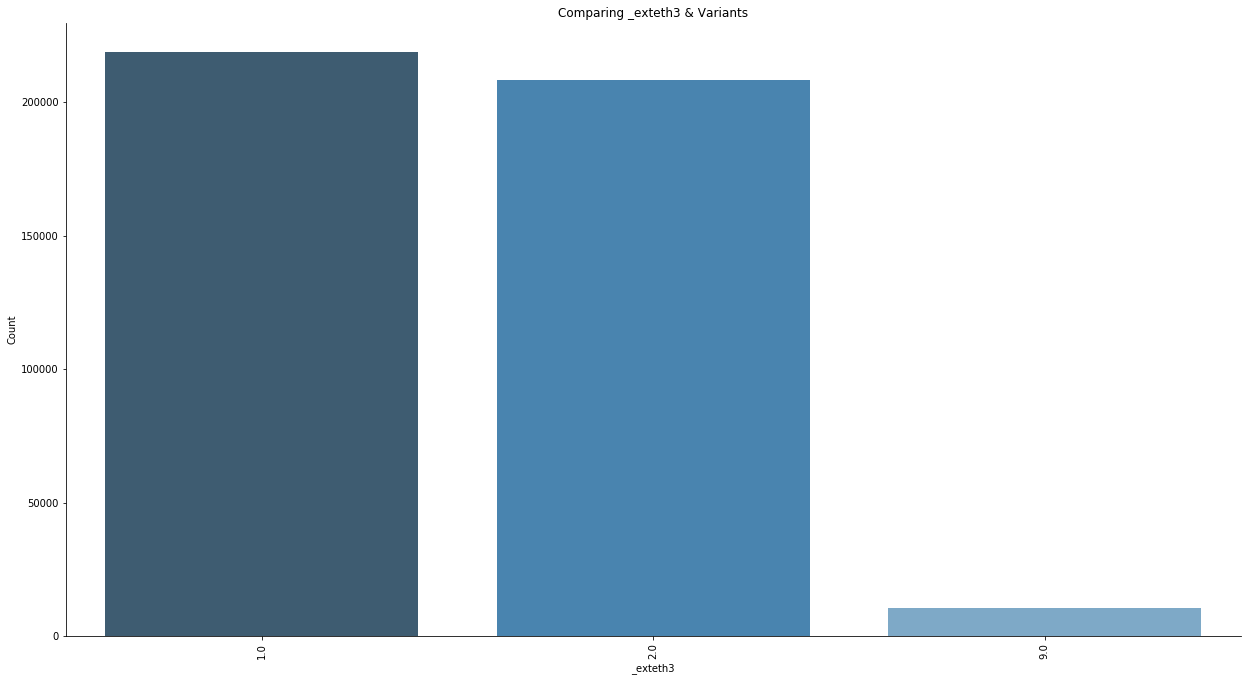

In [24]:
#Calling the function for tooth extraction variants

plot_to_compare(['rmvteth4', '_exteth3'], smaller_brfss)

I'm going to go ahead and keep the original variable, rmvteth4, here, because there is more information preserved with that one. But additionally, exteth3 is more of a measure of risk of having teeth removed, as opposed to actual teeth removed. One option is to include them both, since they do somewhat measure different things. However, I don't think I'm going to need both for this analysis. Rmvteth4 should suffice.

Choice: **rmvteth4**

Next we'll look at dental visits.

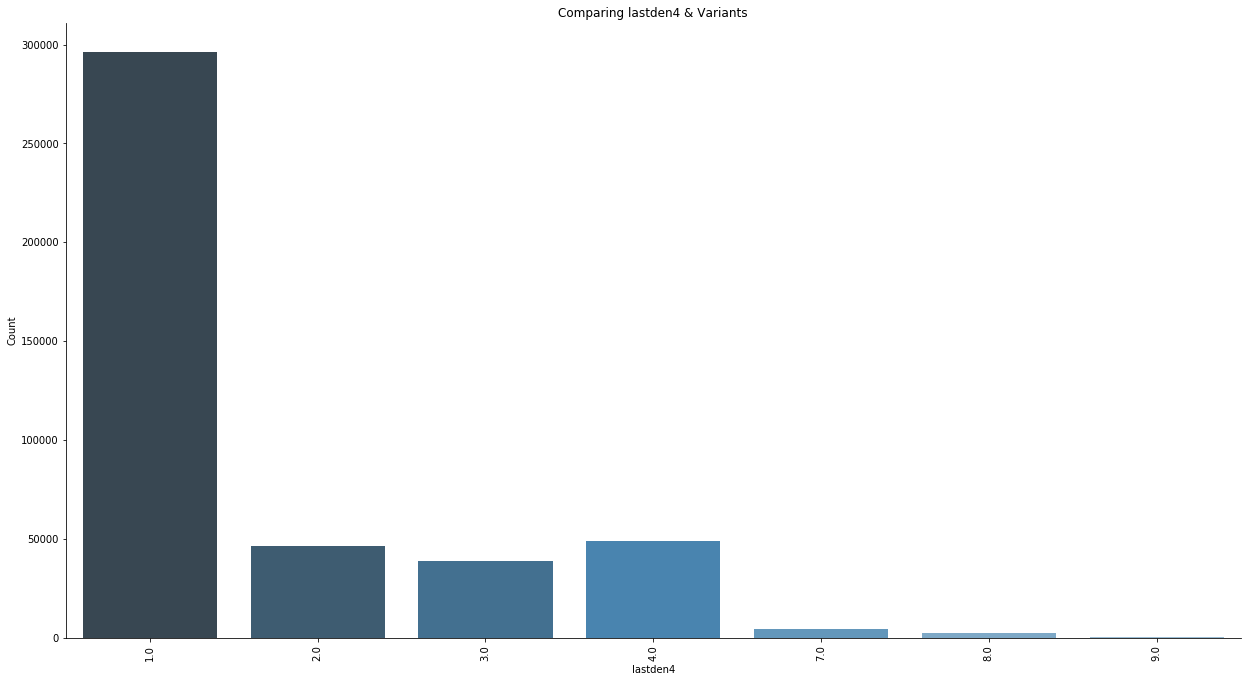

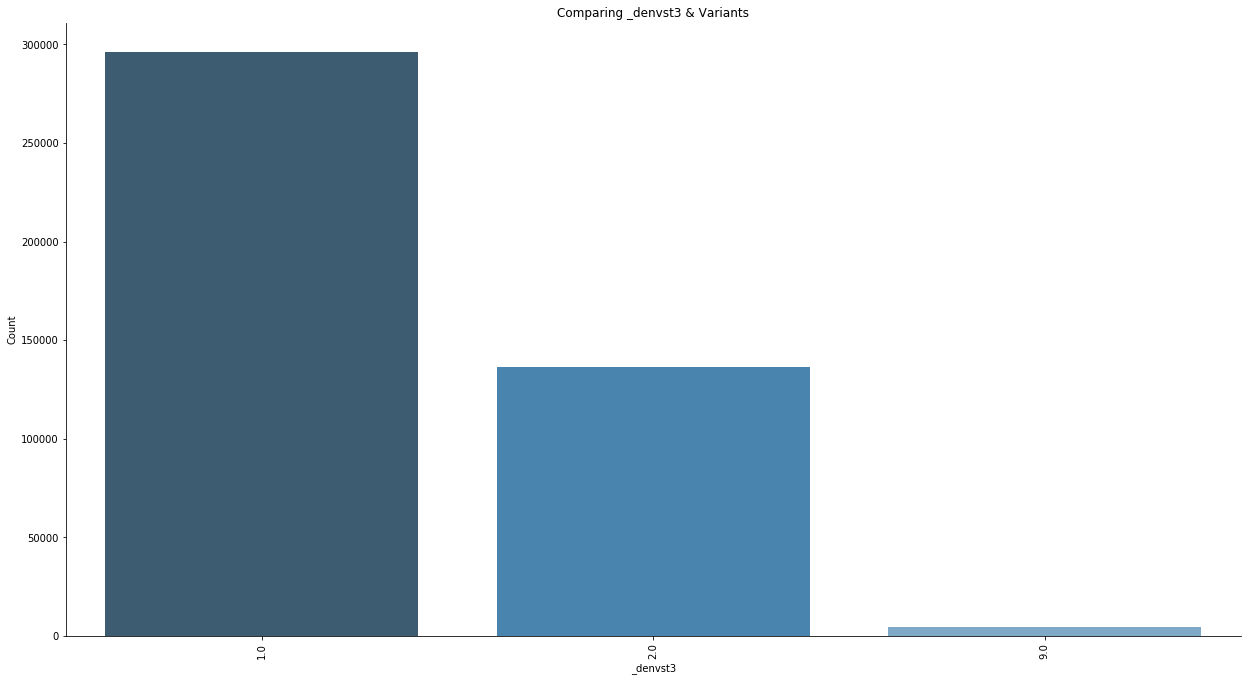

In [25]:
#Calling the function for dental visit & variants

plot_to_compare(['lastden4', '_denvst3'], smaller_brfss)

I'm going to use the initial one, lastden4, because the information is less condensed, and I think that could matter. I at least know I don't want to condense this down into just 'yes' and 'no' levels.

Choice: **lastden4**

Next is age.

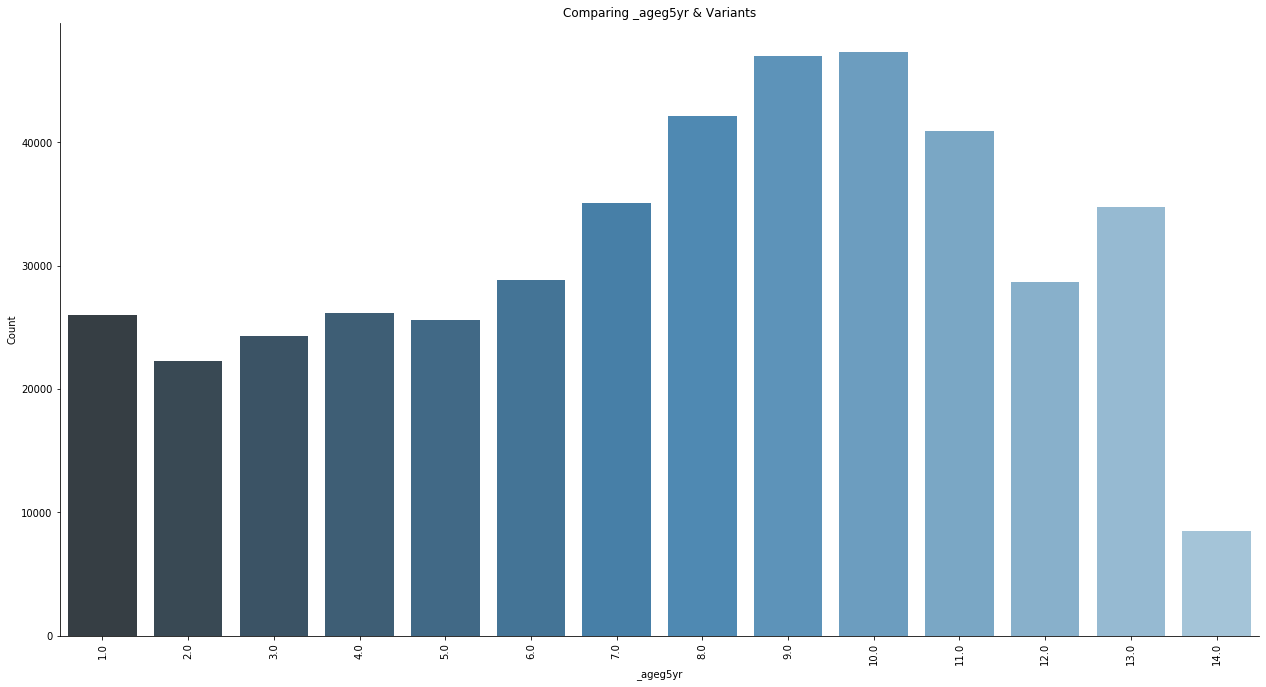

In [26]:
#Calling the function for age variants

plot_to_compare(['_ageg5yr'], smaller_brfss)

This age variables should suffice (the others had already been removed earlier, but I'm plotting this now just to make sure I'm giving it due thought).

I should note that I could use imputed age variable ('age_g,' already removed) because there were not so many nulls in the original age variable that it would make imputation too risky. However, 'age_g' uses buckets of 9, while 'ageg5yr' has smaller buckets (just 5 in each), meaning more information is preserved in this coding. Thats why I'm choosing 'ageg5yr.' There was no continuous age variable in the dataset.

Choice: **_ageg5yr**

Next is height. I already got rid of the other height variables, because they weren't helpful, but I still want to see this one just in case.

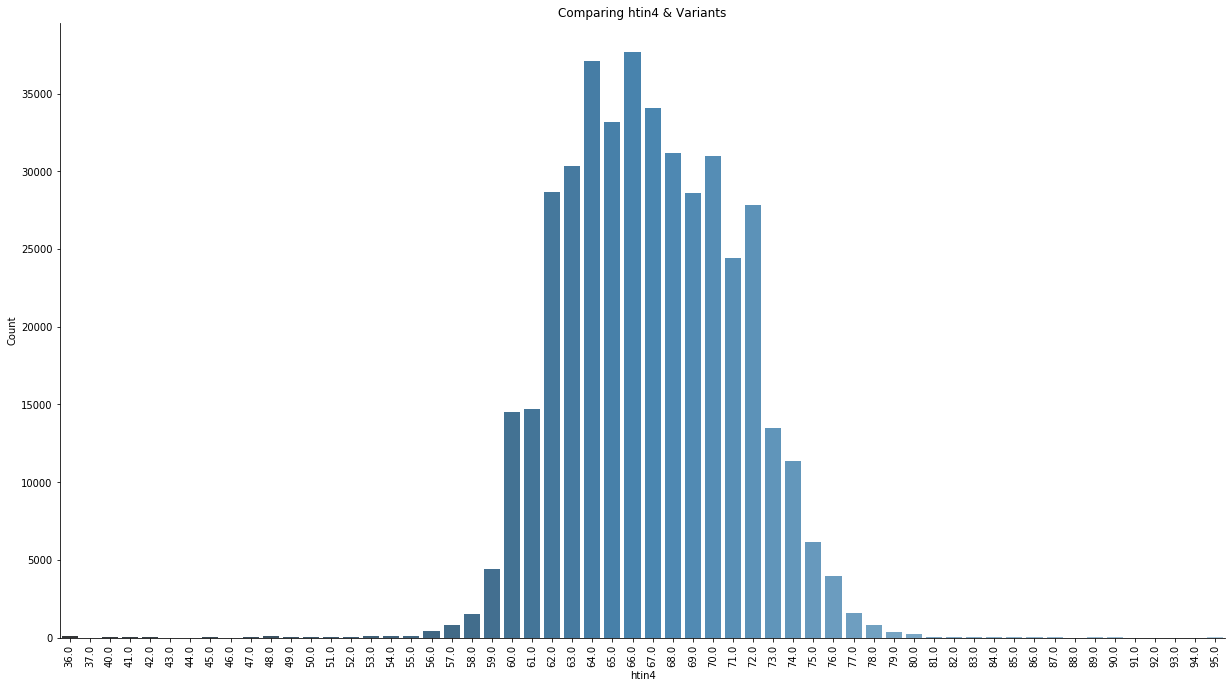

In [27]:
#Calling the function for height 

plot_to_compare(['htin4'], smaller_brfss)

Nice, it's pretty normal, as expected.

Choice: **htin4**

Next is weight.

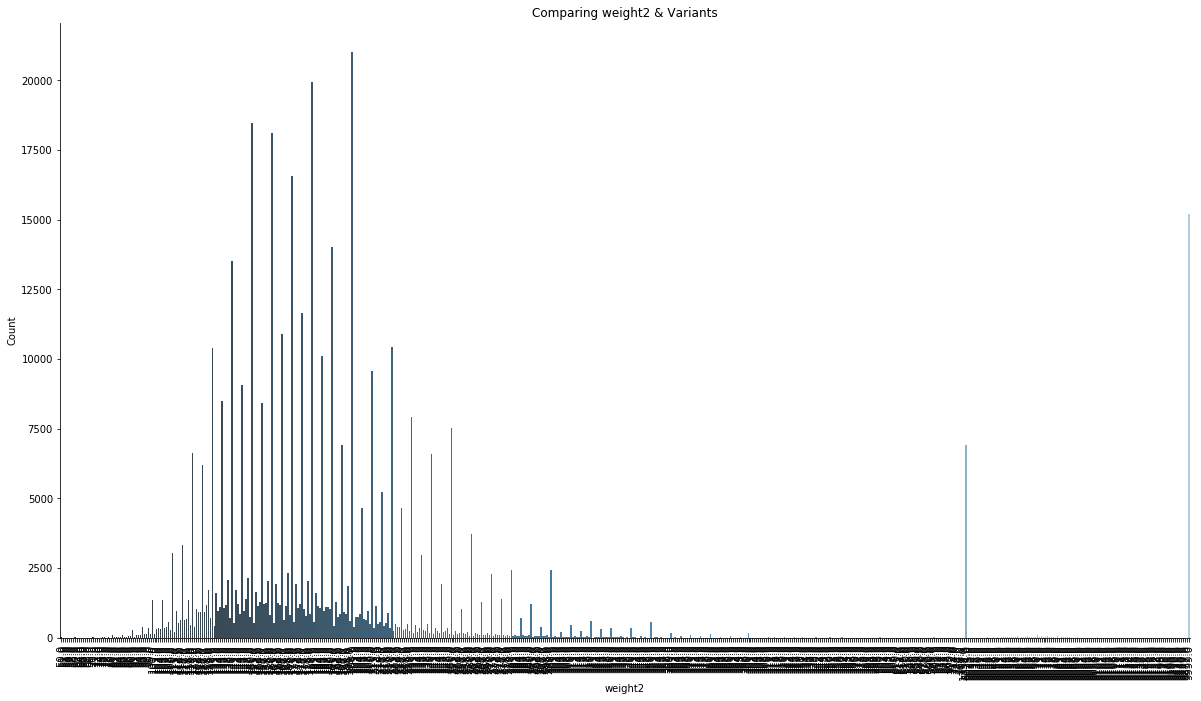

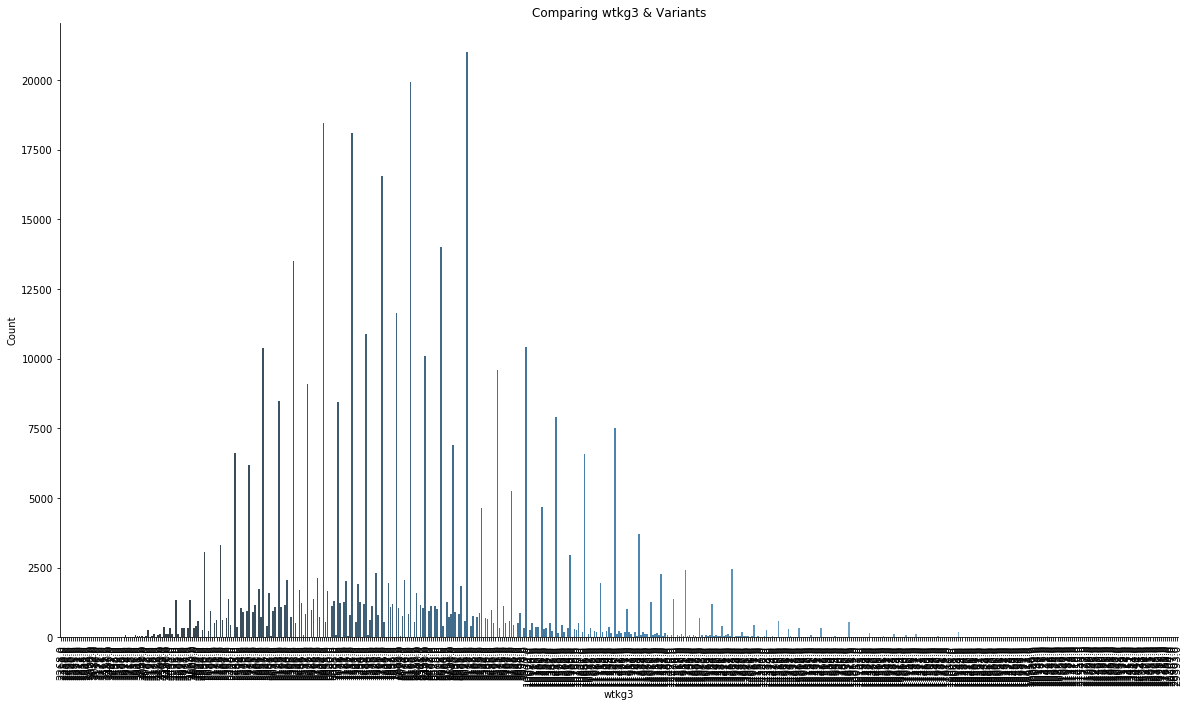

In [28]:
#Calling the function for weight variants

plot_to_compare(['weight2', 'wtkg3'], smaller_brfss)

Well obviously if I were plotting these for real, the labels would not be so terrible, but it's pretty clear I should be using 'wtkg3' (weight in kilograms) because the 'weight2' variable is all in pounds, except for a few answers that were given in kilograms, so it's not good for analysis.

Choice: **wtkg3**

Next is education level.

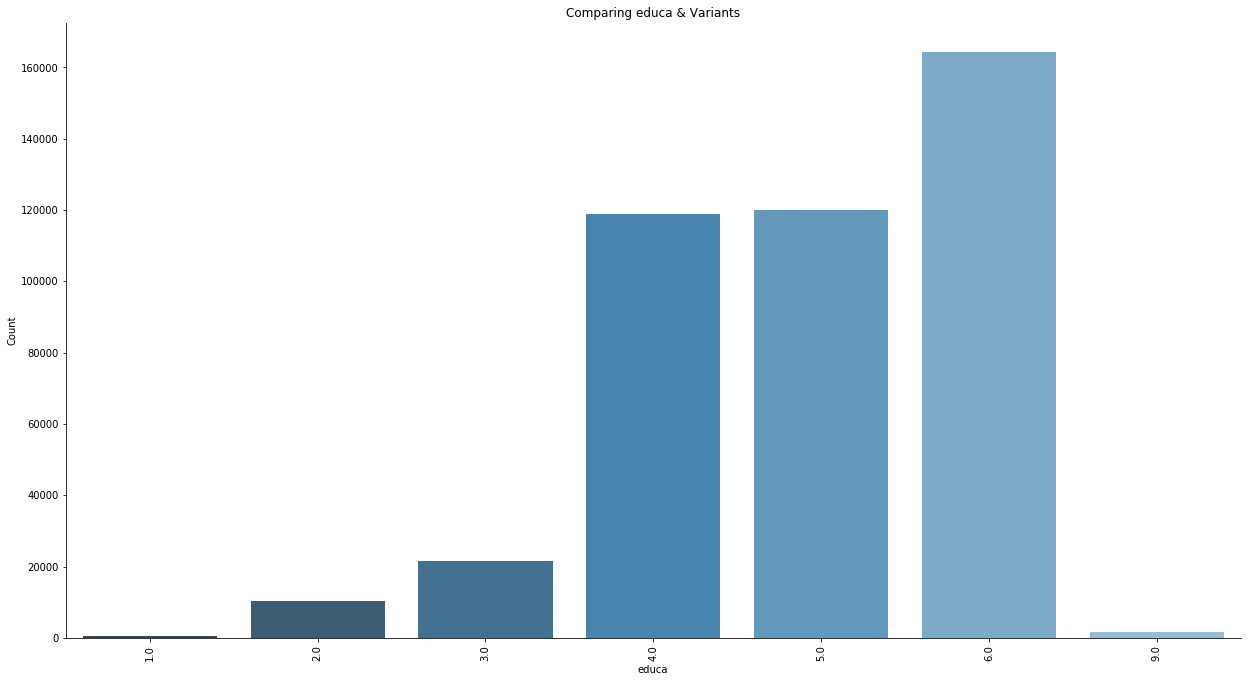

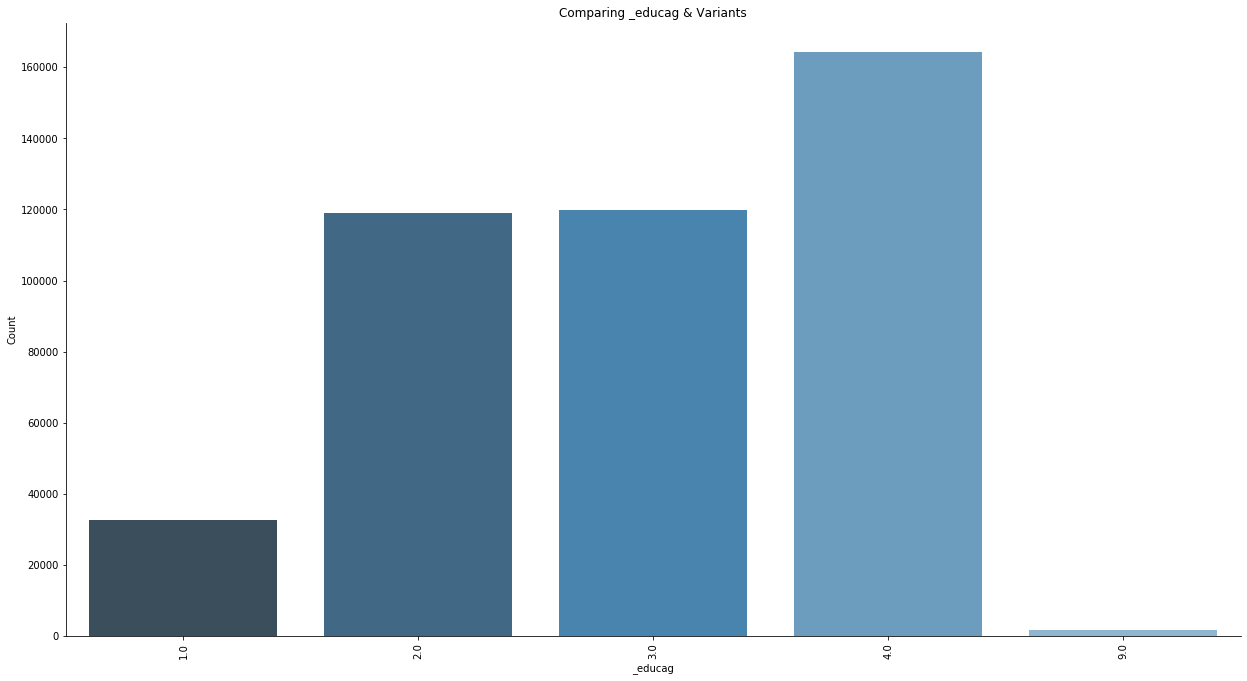

In [29]:
#Calling the function for education 

plot_to_compare(['educa', '_educag'], smaller_brfss)

I think either of these would work fine honestly. I think I will use the one with more information (educa).

Choice: **educa**

Next is income.

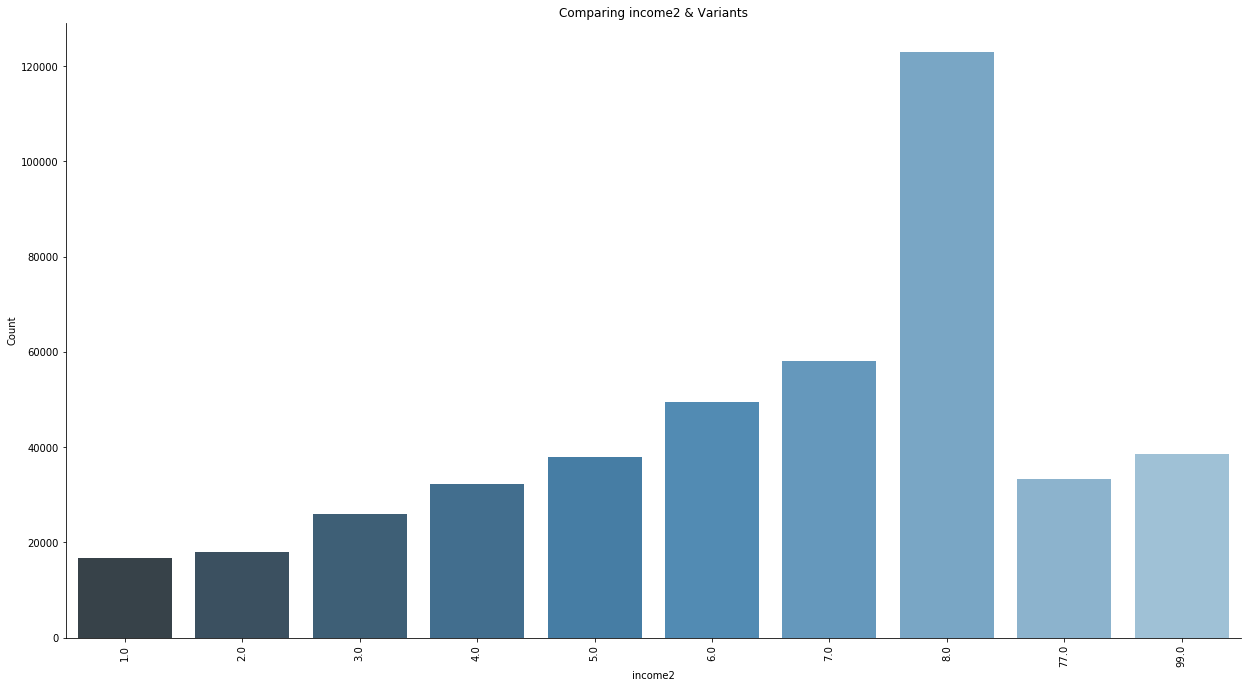

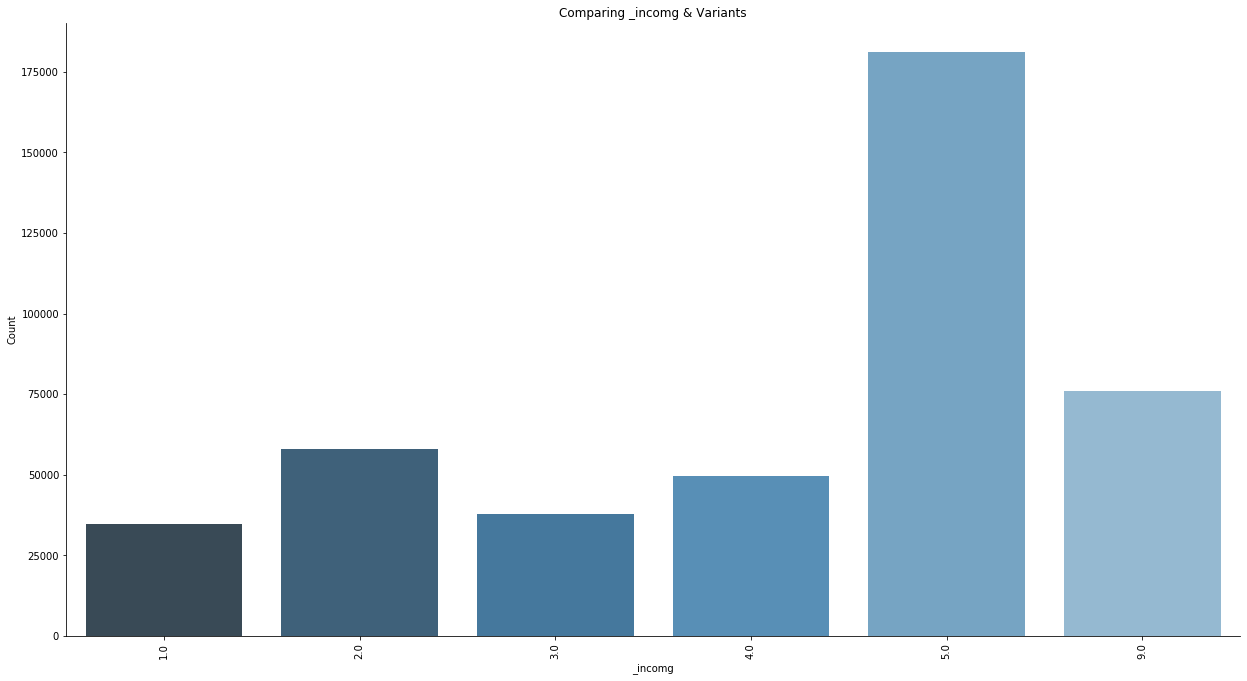

In [30]:
#Calling the function for income variants

plot_to_compare(['income2', '_incomg'], smaller_brfss)

I think I will use 'income2', as that contains the least condensed information and displays the most variation.

Choice: **income2**

Next is smoking.

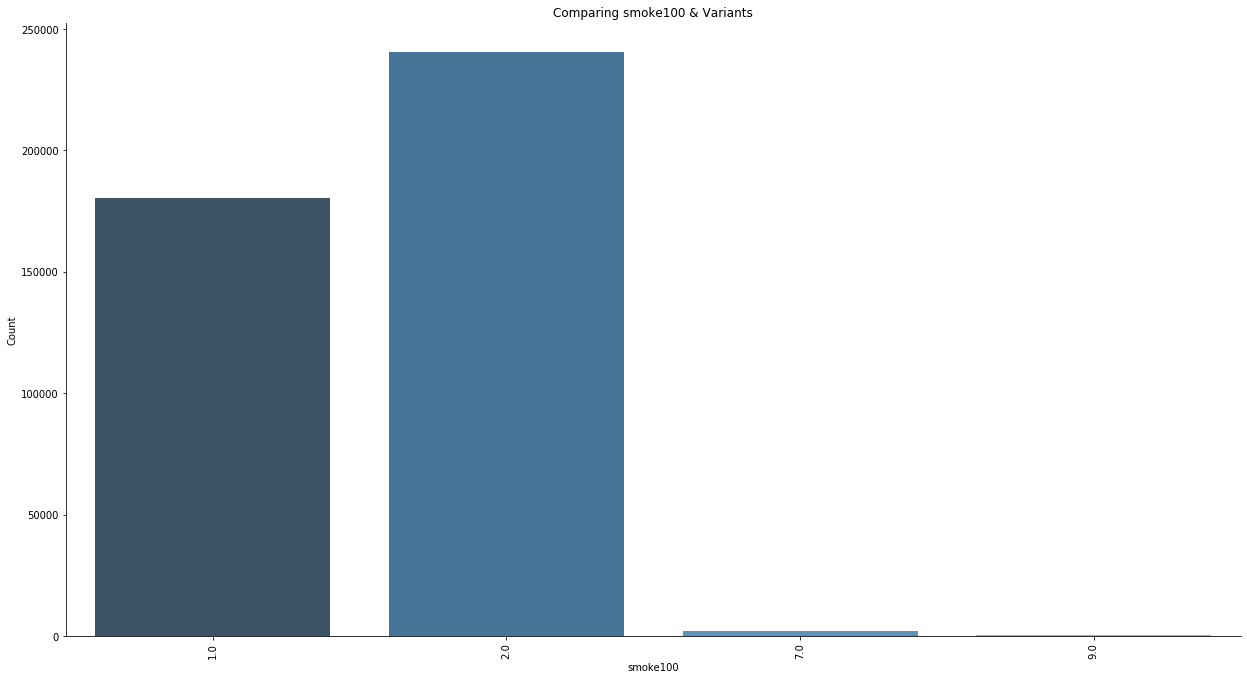

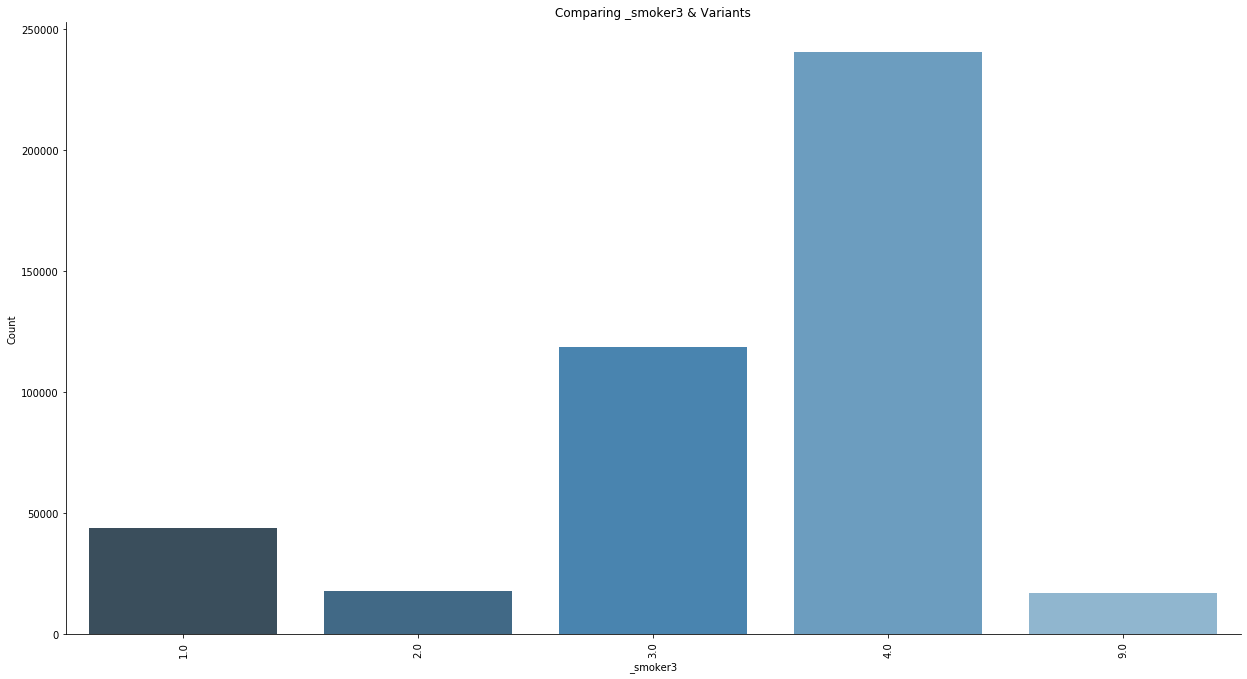

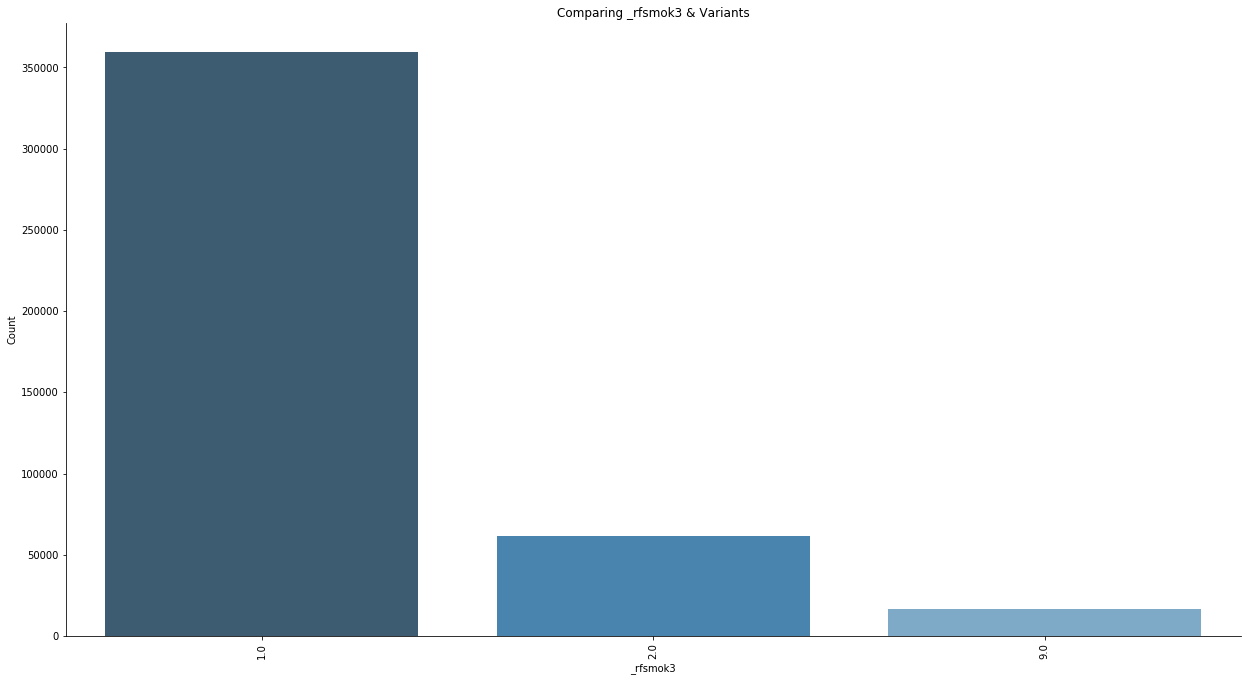

In [31]:
# Calling the function for smoking

plot_to_compare(['smoke100', '_smoker3', '_rfsmok3'], smaller_brfss)

So 'rfsmok3' is yes/no (do they currently smoke or not). 'Smoker3' is 'current smoker who smokes every day', 'current smoker who smokes some days', 'former smoker', 'never smokes', and don't know/missing/refused. In contrast, 'smoke100' asked respondents if they had smoked at least 100 cigarettes in their lifetime (responses are yes/no, etc.). 

Because these are slightly different questions, I think I will use 'smok100' and also 'smoker3,' again because it holds more information.

Choice: **_smoker3** and **smok100** (both for now, at least)

Next is alcohol.

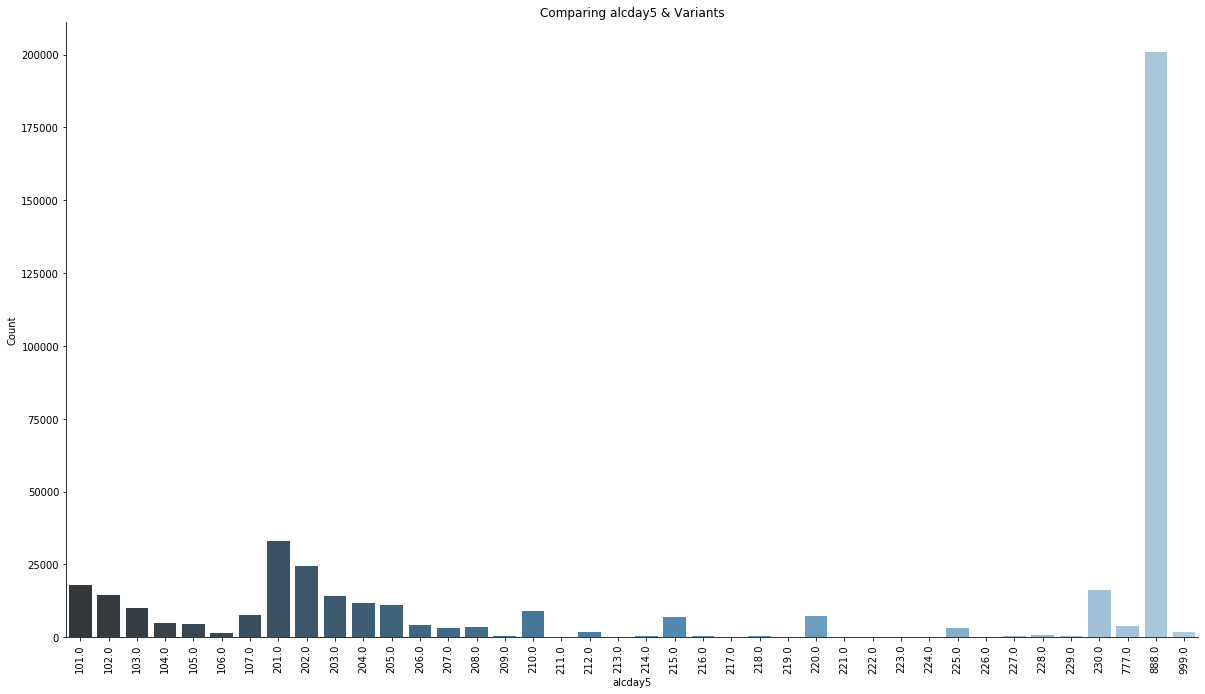

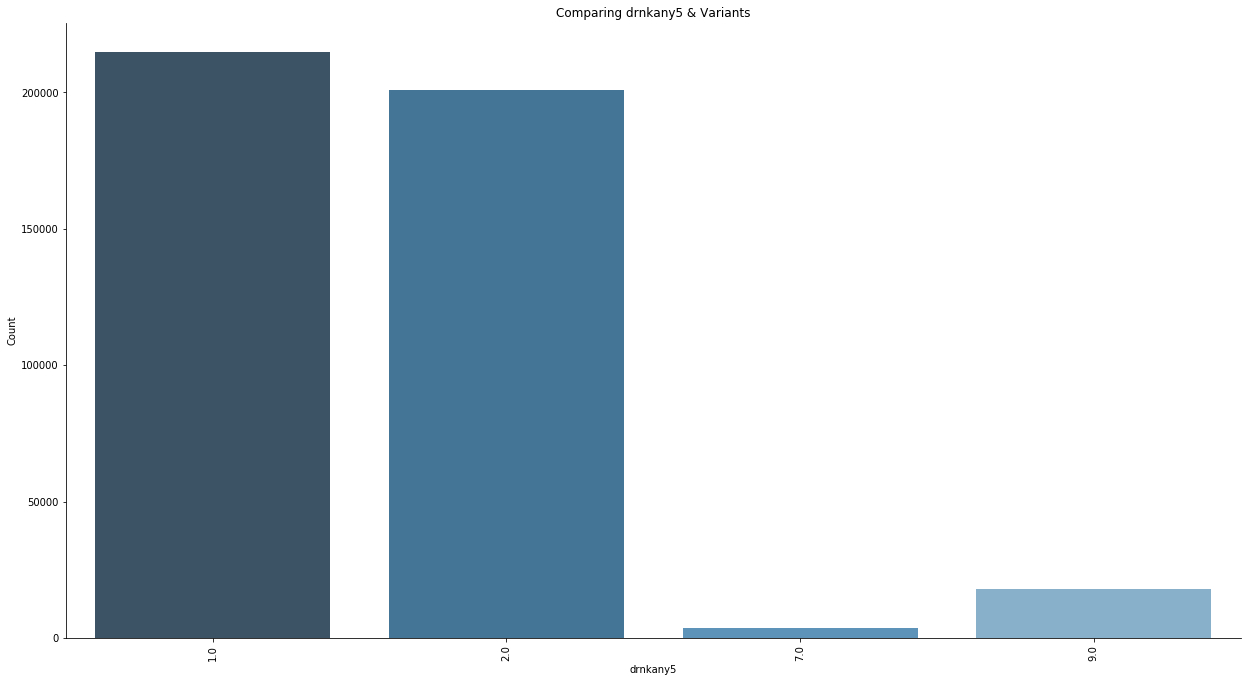

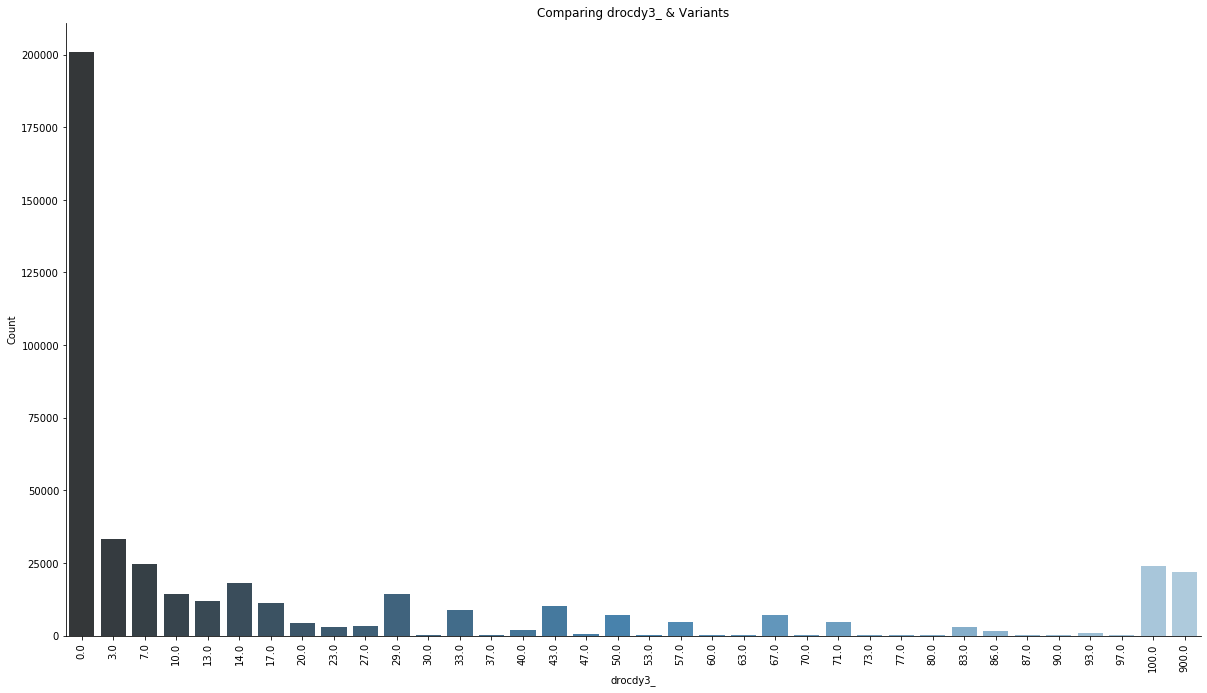

In [32]:
# Calling the function for alcohol
plot_to_compare(['alcday5', 'drnkany5', 'drocdy3_'], smaller_brfss)

'Drocdy3' means drink occasions per day of the month - which is continuous (except for 900, which is don't know), with 0 meaning 0 drinks. 'Drnkany5' refers to whether respondents had at last 1 drink in the past 30 days (answers are yes/no/don't know). Alcday5 is the number of days per week OR per month that respondents had at least one alcoholic drink (weekly amounts begin with 1 and monthly amounts are the responses that begin with 2).
 
So, I can tell that interpreting 'alcday5' in the rest of the analysis is going to be obnoxious, because respondents were able to answer a weekly amount or a monthly amount of drinks. This variation of the variable doesn't seem useful, considering that there are other variables that can represent this better (such as 'drnkwek', which is in the next cell). With regard to 'drocdy3,' I can't actually tell from the codebook/documentation what this variable is trying to quanify (it wasn't really discussed, unlike the other variables), so I won't use this one.

I'm thinking  'drnkany5,' while categorical, may provide useful information, so I will probably use that one out of these 3. 

Choice: **drnkany5**

There are even more alcohol-related variables that resulted from quite different questions from these, so I will look at them separately next.

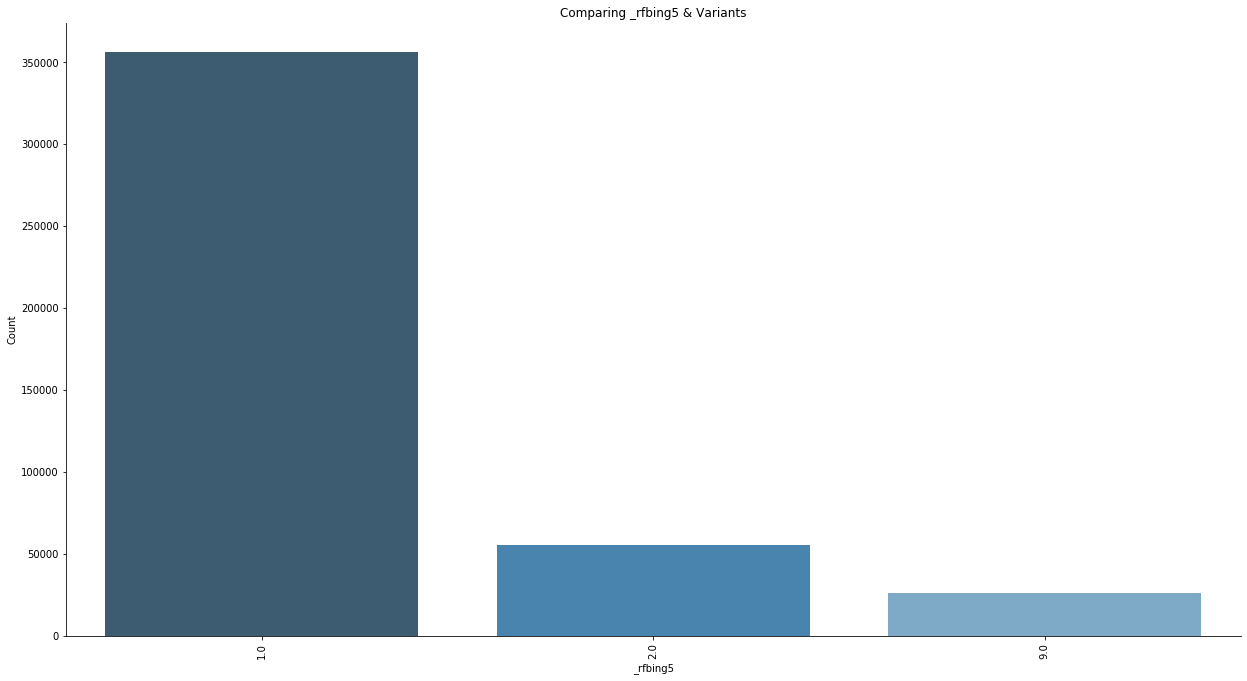

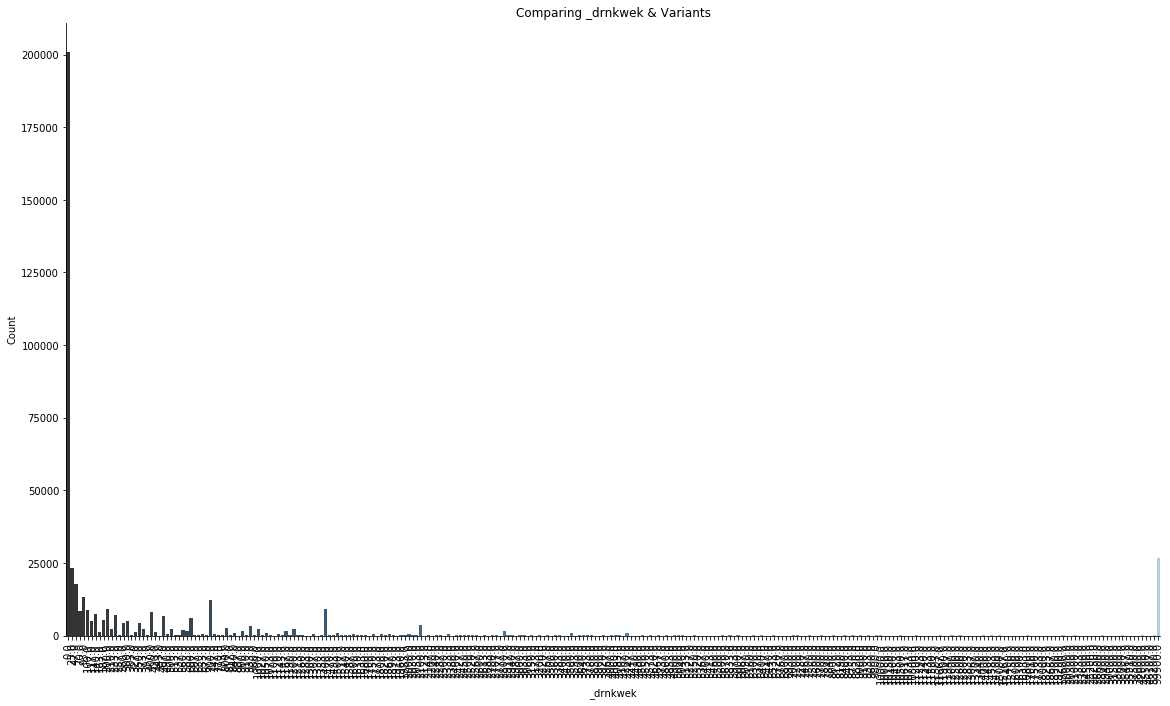

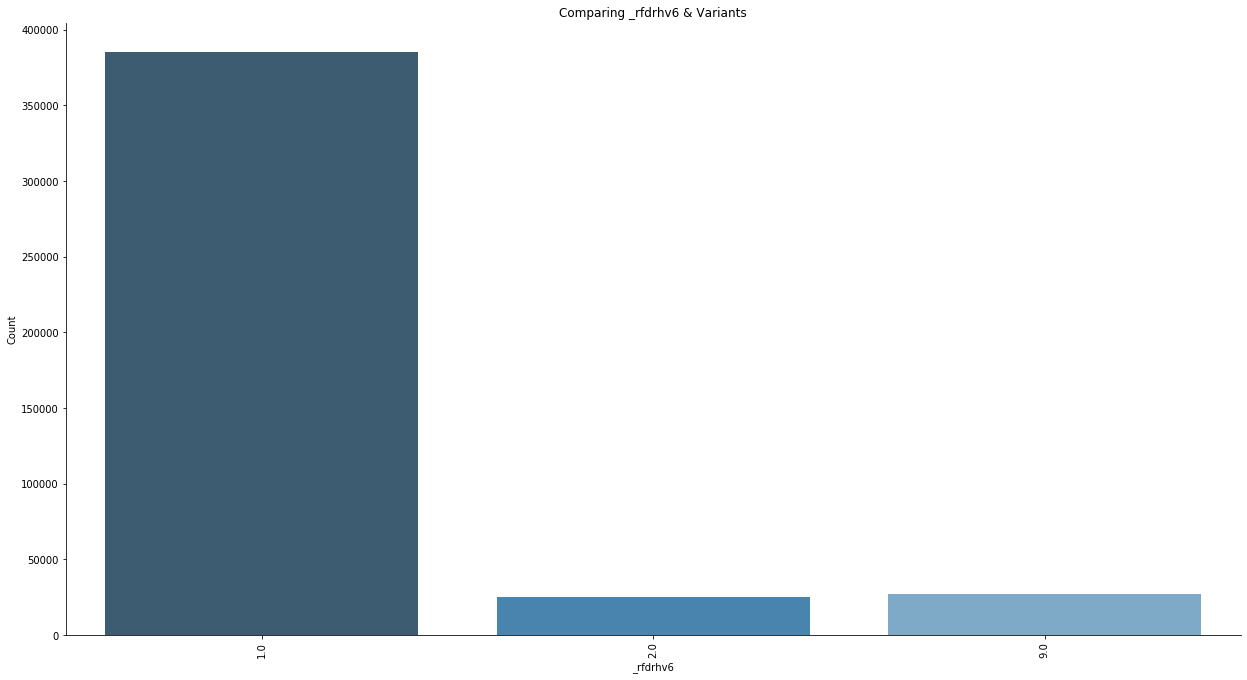

In [33]:
# Calling the function for more alcohol variables
plot_to_compare(['_rfbing5', '_drnkwek', '_rfdrhv6'], smaller_brfss)


In [34]:
smaller_brfss['_drnkwek'].median()

23.0

'Rfbing5' is a variable derived from other alcohol-related variables. It categorizes respondents into binge drinkers (men having 5+ drinks on one occasion, women having 4+ drins on one occasion) and non-binge drinkers, so it's binary (apart from the don't know/refused/missing category), and it holds potentially important information, so I'll definitely use it.

'Drnkwek' is also derived from drocdy3 & avedrnk2, which was removed for having too many nulls. The documentation says that it measures the calculated total number of alcolholic beverages consumed per week for each respondent, but this doesn't make sense to me, as the median is 23, which would mean lots of respondents had 23 drinks per week, which is more than 3 per day. This just doesn't make sense, so this variable must mean something other than how I'm interpreting it, so I'm going to not use it.

'Rfdrhv6' is another derived variable - it calculates the amount of'heavy drinkers'(men having more than 14 drinks per week and women having more than 7 drinks per week) in the sample. It's binary and also slightly different info from the other alcohol variables, so I think I'll use it as well.  

Choice: **_rfbing5** & **_rfdrhv6**

Next are driving behavior variants.

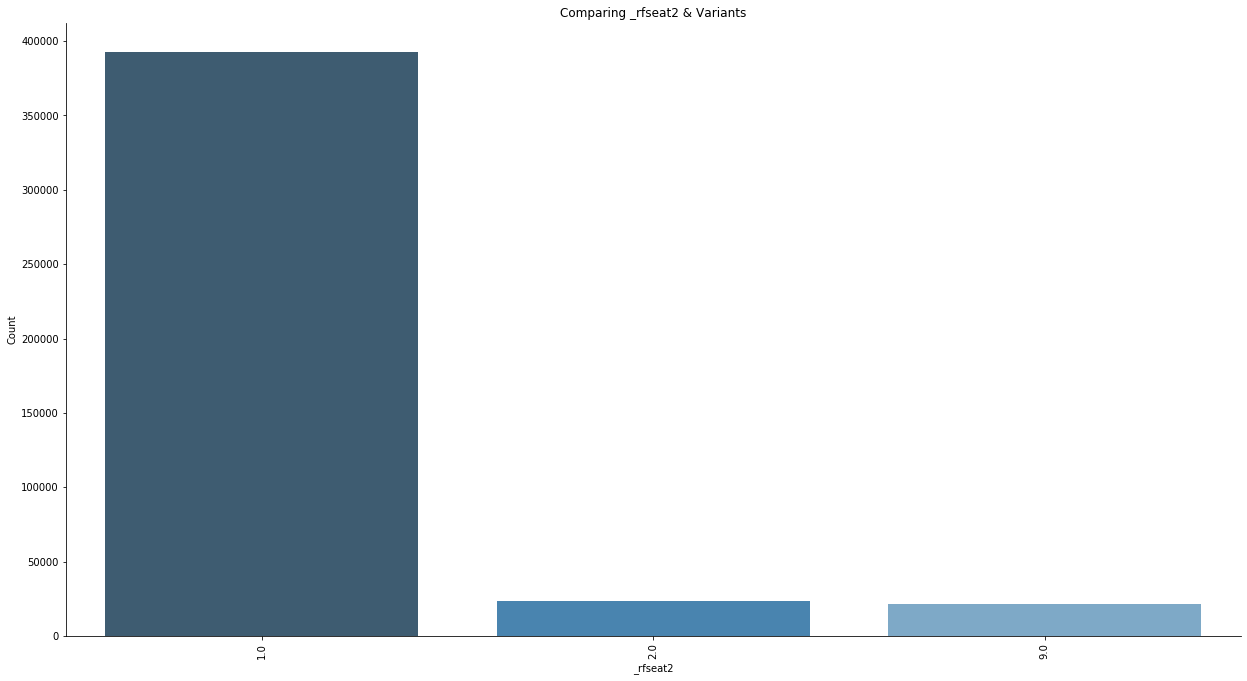

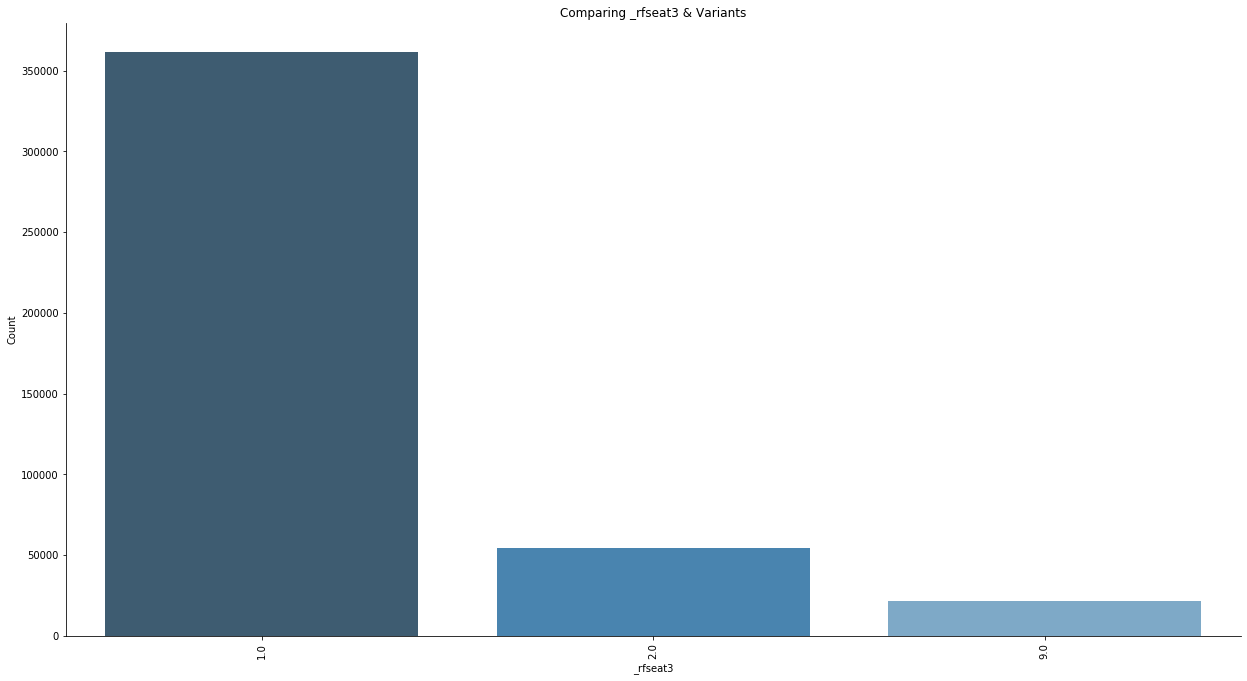

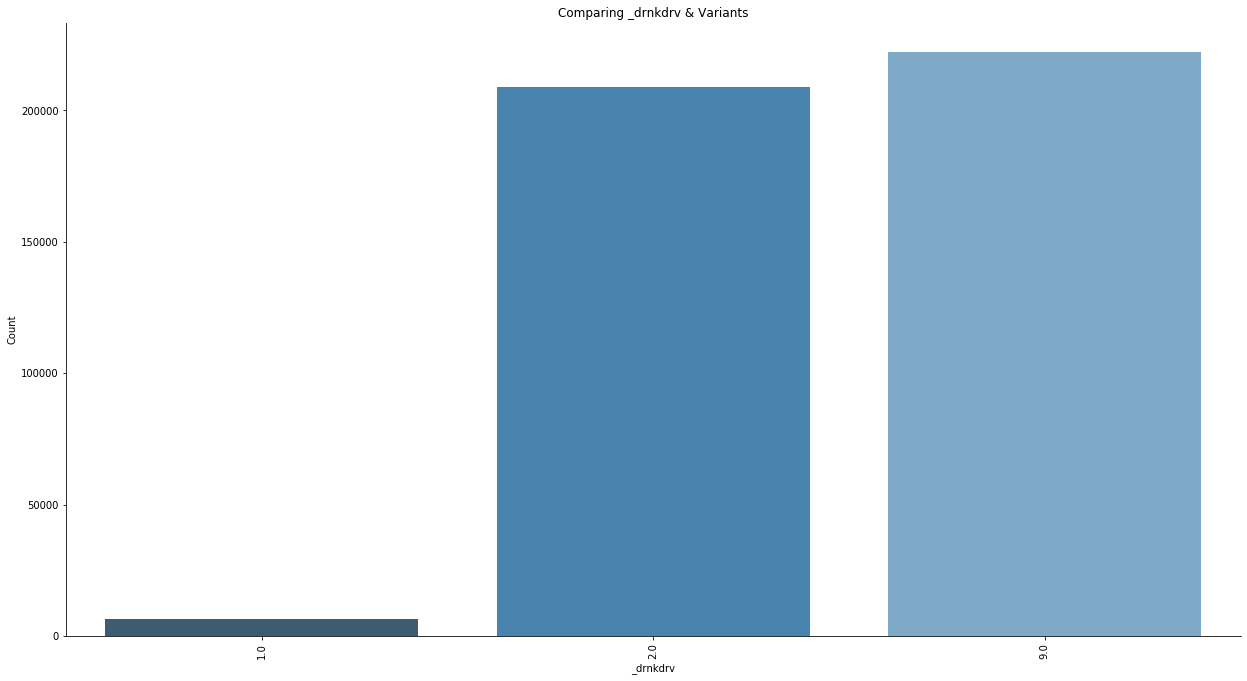

In [35]:
# Calling the function for driving behavior

plot_to_compare(['_rfseat2', '_rfseat3', '_drnkdrv'], smaller_brfss)

'Rfseat2' and 'rfseat3' are essentially the same variable, and both are binary; it's just that their categories are divided up differently. 'Rfseat2' is divided into 'always, nearly always, or sometimes wear seatbelt' and 'seldom or never wear seatbelt.' However, 'rfseat3' is divided into 'always' and 'don't always' wear seatbelt, meaning only those who responded 'always' are in category 1, while everyone else (except missing/don't know) are in category 2. I think this latter approach is better, since we can separate out the 'always' people from the rest, which is a more meaningful distinction.

'Drnkdrv' is quite different - it divides respondents into those who have driven after having too much to drink and those who haven't. This is one case where condensing a variable may actually be good, as the original variable had too many missing for reasonable imputation and got filtered out above. That said, this variable also has a lot of missing data, but it's included as part of a 'missing' category (category 9 in the plot here). I think I would still like to use this variable, but the amount of missing answers does make it challenging.

Choice: **_rfseat3** & **_drnkdrv**

Next up is HIV-related variables, which is the last section we'll look at here before moving on to more extensive data cleaning and EDA.

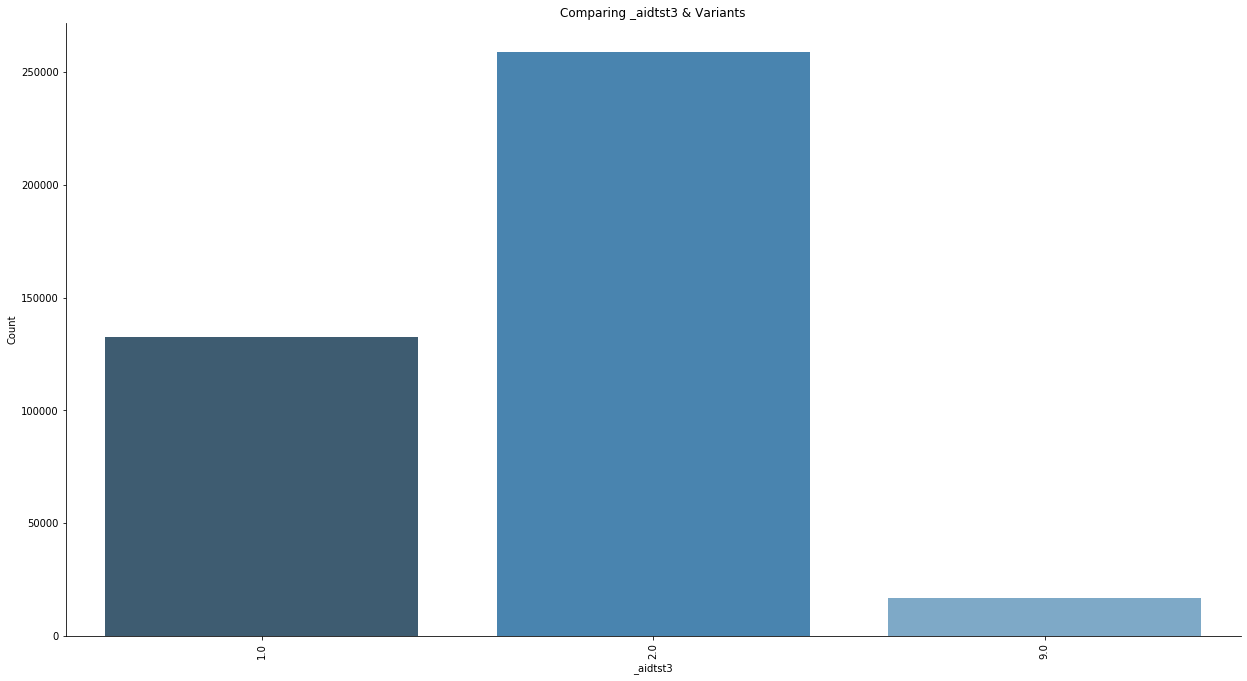

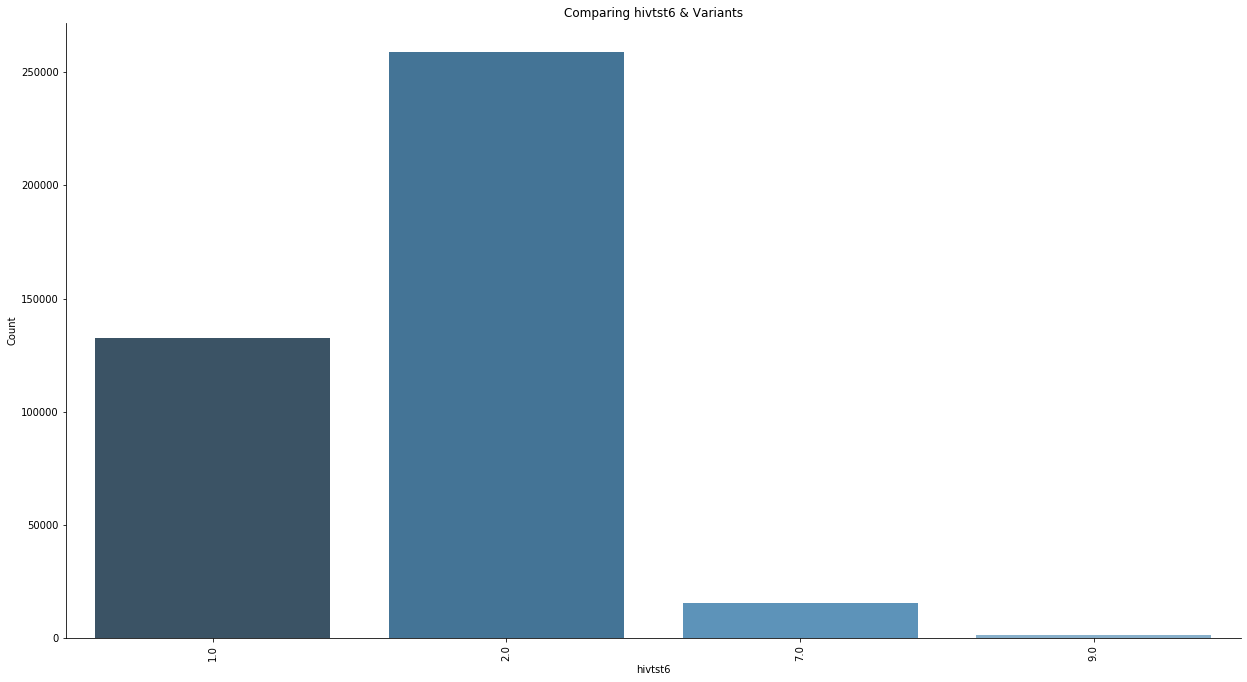

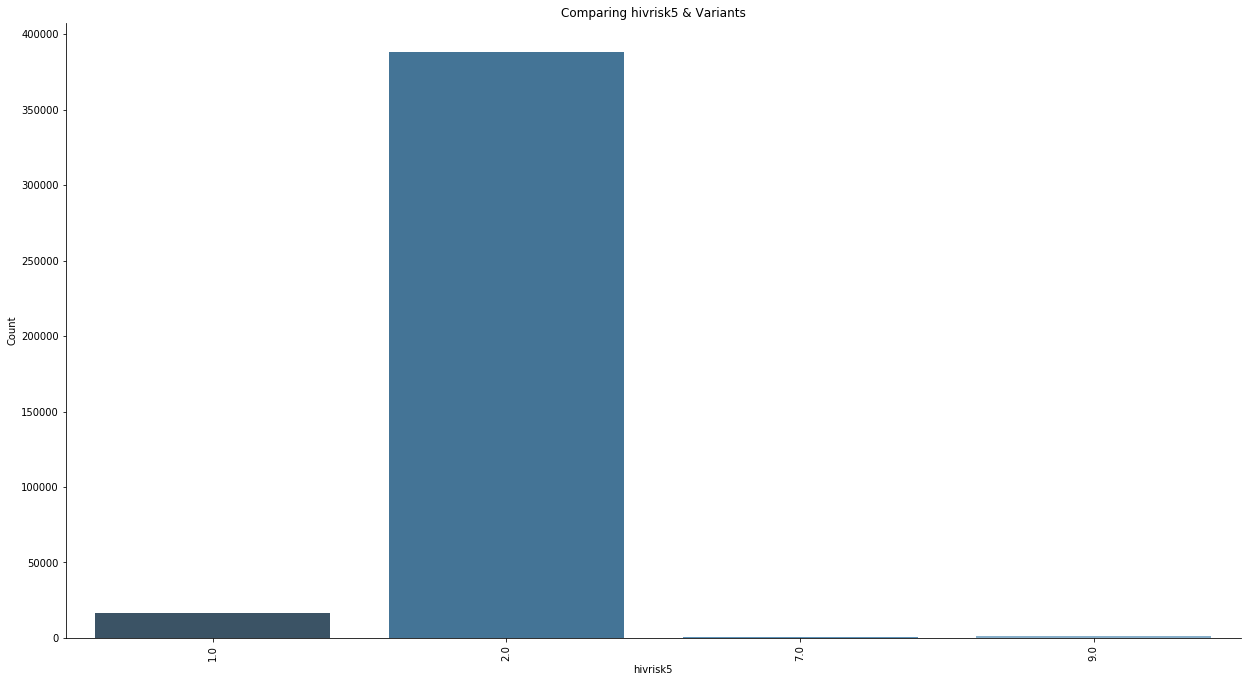

In [36]:
# Calling the function for HIV

plot_to_compare(['_aidtst3', 'hivtst6', 'hivrisk5'], smaller_brfss)

So 'aidtst3' is essentially the same thing as 'hivtst6,' except that 'aidtst3' combines 'don't know/not sure/refused into one coded value. For this reason, I think I will use 'aidtst3' in lieu of 'hivtst6,' because I would have combined those myself anyway.

'Hivrisk5,' however, is a measure of something completely different. The question asked respondents to listen to a list of behaviors (all associated with a high risk of getting HIV (e.g., injecting drugs) and respond with 'yes' if they'd ever engaged in any of the behaviors or no if they hadn't (they didn't need to specify which one). Since this variable pertains to individuals' risk of getting/having HIV, I will also use it.

Choice: **_aidtst3** & **hivrisk5**

Now that I've gone through all the variables that have variants or highly related variables and chosen which are pertinent/useful, I will begin EDA by creating another dataframe with just the chosen variables.

In [37]:
brfss_eda = smaller_brfss.copy()

brfss_eda = brfss_eda.drop(columns=['hivtst6', 
                                    '_rfseat2',
                                    'alcday5',
                                    'drocdy3_',
                                    '_drnkwek',
                                    '_rfsmok3',
                                    '_incomg',
                                    '_educag',
                                    'weight2',
                                    'height3',
                                    '_denvst3',
                                    '_exteth3',
                                    'havarth3',
                                    '_casthm1',
                                    '_ltasth1',
                                    'exerany2',
                                    '_hcvu651',
                                    '_ment14d',
                                    '_phys14d',
                                    '_rfhlth',
                                    '_racegr3',
                                    '_raceg21',
                                    '_rfbmi5',
                                    '_bmi5cat',
                                    '_strwt',
                                    '_imprace'
                                ])



In [38]:
brfss_eda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 437436 entries, 0 to 437435
Data columns (total 68 columns):
_state      437436 non-null float64
imonth      437436 non-null object
iday        437436 non-null object
iyear       437436 non-null object
dispcode    437436 non-null float64
seqno       437436 non-null object
genhlth     437411 non-null float64
physhlth    437410 non-null float64
menthlth    437411 non-null float64
hlthpln1    437413 non-null float64
persdoc2    436540 non-null float64
medcost     436539 non-null float64
checkup1    436541 non-null float64
sleptim1    437413 non-null float64
cvdinfr4    437413 non-null float64
cvdcrhd4    437413 non-null float64
cvdstrk3    437413 non-null float64
asthma3     437413 non-null float64
chcscncr    437413 non-null float64
chcocncr    437413 non-null float64
chccopd1    437413 non-null float64
addepev2    437412 non-null float64
chckdny1    437412 non-null float64
diabete3    437412 non-null float64
lastden4    437409 non-null f

Now we are down to 72 columns, which is even more manageable. Fortunately, none of the major categories are excluded from this dataset, because what I got rid of was largely duplicate columns (of which there were many).

Now I can figure out how to deal with the null values that remain here.

In [39]:
brfss_eda.isnull().sum()

_state          0
imonth          0
iday            0
iyear           0
dispcode        0
seqno           0
genhlth        25
physhlth       26
menthlth       25
hlthpln1       23
persdoc2      896
medcost       897
checkup1      895
sleptim1       23
cvdinfr4       23
cvdcrhd4       23
cvdstrk3       23
asthma3        23
chcscncr       23
chcocncr       23
chccopd1       23
addepev2       24
chckdny1       24
diabete3       24
lastden4       27
rmvteth4       28
sex1            0
marital        35
educa          34
renthom1       38
veteran3      558
employ1      1236
children     1977
income2      4394
deaf         9081
blind        9883
decide      10703
diffwalk    11528
diffdres    12072
diffalon    12843
smoke100    13844
usenow3     14551
flushot6    18774
pneuvac4    19760
seatbelt    20809
hivrisk5    31217
qstver          0
qstlang        48
_metstat     6487
_urbstat     6487
_totinda        0
_michd       3970
_asthms1        0
_drdxar1     2534
_hispanc        0
_race     

Okay, one thing we know is that none of these columns has more than 20% of its values missing, so any of them are able to be imputed, if necessary. At this time, I can also recode these variables so they will work better in the models and be easier to interpret - like subtracting 1 from all so they start with code 0 instead of 1. I'll do that first and then impute and recode anything else that comes up.

Here's my plan for what I'll do about the nulls and re-coding in each of these columns:

*genhlth: 25 nulls will be changed into code 1000 to denote missing data. Codes 7 & 9 (don't know and refused) will also become code 1000.

*physhlth: 26 nulls --> code 1000 for missing. Codes 77 & 99 --> 1000. Code 88 --> 0, because it represents 0 days of poor physical health.

*menthlth: 25 nulls --> 1000. Codes 77 & 99 --> 1000. Code 88 --> 0, because it represents 0 days of poor mental health.

*hlthpln1: 23 nulls --> 1000. Codes 7 & 9 --> 1000.

*persdoc2: 896 nulls --> 1000. Codes 7 & 9 --> 1000.

*medcost: 897 nulls --> 1000. Codes 7 & 9 --> 1000.

*checkup1: 895 nulls --> 1000. Codes 7 & 9 --> 1000.

*sleptim1: 23 nulls --> 1000. Codes 77 & 99 --> 1000.

*cvdinfr4: 23 nulls --> 1000. Codes 7 & 9 --> 1000.

*cvdcrhd4: 23 nulls --> 1000. Codes 7 & 9 --> 1000.

*cvdstrk3: 23 nulls --> 1000. Codes 7 & 9 --> 1000.

*asthma3: 23 nulls --> 1000. Codes 7 & 9 --> 1000.

*chcscncr: 23 nulls --> 1000. Codes 7 & 9 --> 1000.

*chcocncr: 23 nulls --> 1000. Codes 7 & 9 --> 1000.

*chccopd1: 23 nulls --> 1000. Codes 7 & 9 --> 1000.

*addepev2: 24 nulls --> 1000. Codes 7 & 9 --> 1000.

*chckdny1: 24 nulls --> 1000. Codes 7 & 9 --> 1000.

*diabete3: 24 nulls --> 1000. Codes 7 & 9 --> 1000.

*lastden4: 27 nulls --> 1000. Codes 7 & 9 --> 1000. Code 8 ('never been to dentist') --> 5.

*rmvteth4: 28 nulls --> 1000. Codes 7 & 9 --> 1000. Code 8 ('no teeth removed') --> 0.

*sex1: 0 nulls; 7 & 9 --> 1000. 

*marital: 35 nulls --> 1000. 9 --> 1000.

*educa: 34 nulls --> 1000. 9 --> 1000.

*renthom1: 38 nulls --> 1000. 7 & 9 --> 1000.

*veteran3: 558 nulls --> 1000. 7 & 9 --> 1000.

*employ1: 1,236 nulls --> 1000. 9 --> 1000.

*children: 1,977 nulls --> 1000. 99 --> 1000. 88 ('no children') --> 0

*income2: 4,394 nulls --> 1000. 77 & 99 --> 1000.
(There are 17% missing here when nulls + refused + don't know responses are added up. That's a fairly sizeable chunk, and that's why I'm not imputing here, but rather making the missing its own category.) 

*deaf: 9081 nulls --> 1000. 7 & 9 --> 1000.

*blind: 9,883 nulls --> 1000. 7 & 9 --> 1000.

*decide: 10,703 nulls --> 1000. 7 & 9 --> 1000.

*diffwalk: 11,528 nulls --> 1000. 7 & 9 --> 1000.

*diffdres: 12,072 nulls --> 1000. 7 & 9 --> 1000.

*diffalon: 12,843 nulls --> 1000. 7 & 9 --> 1000.

*smoke100: 13,844 nulls --> 1000. 7 & 9 --> 1000.

*usenow3: 14,551 nulls --> 1000. 7 & 9 --> 1000.

*flushot6: 18,774 nulls --> 1000. 7 & 9 --> 1000.

*pneuvac4: 19,760 nulls --> 1000. 7 & 9 --> 1000.

*seatbelt: 20,809 nulls --> 1000. 7 & 9 --> 1000. 8 ('never go by car') --> 6

*hivrisk5: 31,217 nulls --> 1000. 7 & 9 --> 1000.

*qstlang: 48 nulls --> 1000. 

*_metstat: 6,487 nulls --> 1000.

*_urbstat: 6,487 nulls --> 1000.

*_totinda: 9 (condensed missing category) --> 1000

*_michd: 3,970 nulls --> 1000

*_asthms1: 9 --> 1000

*_drdxar1: 2,534 nulls --> 1000

*_hispanc: 9 --> 1000

*_race: 1 null --> impute. 9 --> make null so I can then easily impute.
(Only 2% of data is missing from this variable, which makes single imputation a good choice. Because the distribution of this variable is not normal (judging from the catplot above), I will impute missing datapoints with the most common (mode) race in the dataset.)

*_ageg5yr: 14 --> null, so I can impute
(Again, only 2% of this data is missing, so single imputation should work fine. I'll use the median age in the sample.

*htin4: 18,177 nulls --> impute
(Only 4% of this data is missing. I can use what is essentially multiple imputation, using mean height for women and average height for men.)

*wtkg3: 28,572 nulls --> impute
(Just 6.5% of this data is missing. I will do the same thing I am doing for height and impute the mean height for women and the average height for men in this sample.)


*_bmi5: 35,262 nulls --> impute
(About 8% of this data is missing. I'll use the same method as with height and weight, and impute the average bmi for women and then for men in the dataset.)

*_chldcnt: 9 --> 1000

*_smoker3: 9 --> 1000

*_drnkany5: 7 & 9 --> 1000

*_rfbing5: 9 --> 1000

*_rfdrhv6: 9 --> 1000

*_rfseat3: 9 --> 1000

*_drnkdrv: 9 --> 1000

*_aidtst3: 29,581 nulls --> 1000. 9 --> 1000

And that's it!

First, I'm going to impute height, weight, age, and race with the values I mentioned above. The first step is making some values null that were originally coded 'don't know' or 'refused.' (This only occurs in 2 of the 4 variables I"m imputing.) When they are NaN, I will easily be able to use the fillna method to impute them, along with the original NaNs. 

In [40]:
# Make missing values NaN 

brfss_eda['_ageg5yr'] = brfss_eda['_ageg5yr'].replace(14, np.nan)

brfss_eda['_race'] = brfss_eda['_race'].replace(9, np.nan)

In [41]:
# Impute missing values in age var

age = '_ageg5yr'


brfss_eda.loc[:, age] = brfss_eda.loc[
    :, age].fillna(brfss_eda.loc[:, age].median())

In [42]:
# Check age now
brfss_eda['_ageg5yr'].isnull().sum()

0

In [43]:
# Now I'll do the same for race (note: median & mode are the same here)
race = '_race'

brfss_eda.loc[:, race] = brfss_eda.loc[
    :, race].fillna(brfss_eda.loc[:, race].median())

In [44]:
# Check race now
brfss_eda['_race'].isnull().sum()

0

In [45]:
# Now I'll impute height, bmi, and weight with the means for each gender

continuous_fill_list = [[
    'htin4',
    '_bmi5',
    'wtkg3'
]]

    
for col in continuous_fill_list:
    brfss_eda.loc[(brfss_eda['sex1'] == 2), col] = brfss_eda.loc[
        (brfss_eda['sex1'] == 2), col].fillna(brfss_eda.loc[
        (brfss_eda['sex1'] == 2), col].mean())
    
    brfss_eda.loc[(brfss_eda['sex1'] == 1), col] = brfss_eda.loc[
        (brfss_eda['sex1'] == 1), col].fillna(brfss_eda.loc[
        (brfss_eda['sex1'] == 1), col].mean())
    
    brfss_eda.loc[
        (brfss_eda['sex1'] == 7) | (brfss_eda['sex1'] == 9), col] = brfss_eda.loc[
        (brfss_eda['sex1'] == 7) | (brfss_eda['sex1'] == 9), col].fillna(brfss_eda.loc[
        (brfss_eda['sex1'] == 7) | (brfss_eda['sex1'] == 9), col].mean())

In [46]:
# Check a column to make sure
print(brfss_eda['wtkg3'].isnull().sum())

0


In [47]:
brfss_eda['wtkg3'].describe()

count    437436.000000
mean       8169.962052
std        2021.442229
min        2268.000000
25%        6804.000000
50%        7893.000000
75%        9072.000000
max       29393.000000
Name: wtkg3, dtype: float64

Now I'm going to do several rounds of imputation of the code 1000 (for missing) with the various other codes that need to be changed, which I mentioned in my plan above.

In [48]:
# First I'll impute the vars with only nulls that needed to become 1000
fill_list_rd1 = [['_michd', '_metstat', '_urbstat', 'qstlang', '_drdxar1']]

for col in fill_list_rd1:
    brfss_eda.loc[:, col] = brfss_eda.loc[
        :, col].fillna(1000)

In [49]:
# Now I'll impute vars with only a code 9 that needs to become 1000
fill_list_rd2 = [[
    '_rfdrhv6', 
    '_rfseat3', 
    '_drnkdrv', 
    '_rfbing5', 
    '_smoker3',
    '_chldcnt',
    '_hispanc',
    '_asthms1',
    '_totinda',
]]

for col in fill_list_rd2:
    brfss_eda[col] = brfss_eda[col].replace(9, 1000) 

In [50]:
# Check a col to make sure
brfss_eda['_rfseat3'].value_counts()

1.0       361429
2.0        54600
1000.0     21407
Name: _rfseat3, dtype: int64

In [51]:
# Now I'll impute vars that need nulls to become 1000 AND have 
# code 7 and code 9 that need to become 1000
fill_list_rd3 = [[
    'genhlth',
    'hlthpln1',
    'persdoc2',
    'medcost',
    'checkup1',
    'cvdinfr4',
    'cvdcrhd4',
    'cvdstrk3',
    'asthma3',
    'chcscncr',
    'chcocncr',
    'chccopd1',
    'addepev2',
    'chckdny1',
    'renthom1',
    'veteran3',
    'deaf',
    'blind',
    'decide',
    'diffwalk',
    'diffdres',
    'diffalon',
    'smoke100',
    'usenow3',
    'flushot6',
    'pneuvac4',
    'hivrisk5',
    'diabete3'   
]]

for col in fill_list_rd3:
    brfss_eda[col] = brfss_eda[col].replace(9, 1000)
    brfss_eda[col] = brfss_eda[col].replace(7, 1000) 
    brfss_eda.loc[:, col] = brfss_eda.loc[
        :, col].fillna(1000)

In [52]:
# Check a column to make sure
brfss_eda['addepev2'].value_counts()

2.0       353474
1.0        81809
1000.0      2153
Name: addepev2, dtype: int64

In [53]:
# Imputing vars with nulls and only code 9 that need to become 1000
fill_list_rd4 = [[
    'employ1',
    'educa',
    '_aidtst3',
    'marital'
]]

for col in fill_list_rd4:
    brfss_eda[col] = brfss_eda[col].replace(9, 1000)
    brfss_eda.loc[:, col] = brfss_eda.loc[
        :, col].fillna(1000)

In [54]:
# Check a col to make sure
brfss_eda['educa'].value_counts()

6.0       164229
5.0       119980
4.0       119038
3.0        21456
2.0        10446
1000.0      1621
1.0          666
Name: educa, dtype: int64

In [55]:
# Next, a mini-list of nulls with 77 & 99 codes instead of 7 & 9
fill_list_rd5 = [[
    'income2',
    'sleptim1'
]]

for col in fill_list_rd5:
    brfss_eda[col] = brfss_eda[col].replace(77, 1000)
    brfss_eda[col] = brfss_eda[col].replace(99, 1000)
    brfss_eda.loc[:, col] = brfss_eda.loc[
        :, col].fillna(1000)

In [56]:
# Check a col to make sure
brfss_eda['sleptim1'].value_counts()

7.0       128272
8.0       126353
6.0        94849
5.0        29241
9.0        19241
4.0        12696
10.0       10282
1000.0      5337
12.0        3292
3.0         3239
2.0         1403
1.0          881
11.0         653
14.0         374
16.0         358
15.0         330
18.0         176
13.0         169
20.0         139
24.0          65
17.0          38
23.0          16
22.0          16
21.0          10
19.0           6
Name: sleptim1, dtype: int64

In [57]:
# Now imputing nulls with 77, 99, and an 88 actually means 0
fill_list_rd6 = [[
    'children',
    'menthlth',
    'physhlth'
]]

for col in fill_list_rd6:
    brfss_eda[col] = brfss_eda[col].replace(77, 1000)
    brfss_eda[col] = brfss_eda[col].replace(88, 0)
    brfss_eda[col] = brfss_eda[col].replace(99, 1000)
    brfss_eda.loc[:, col] = brfss_eda.loc[
        :, col].fillna(1000)

In [58]:
# Check a col to make sure
brfss_eda['children'].value_counts()

0.0       319282
1.0        46460
2.0        39560
3.0        17458
4.0         6405
1000.0      4746
5.0         2109
6.0          842
7.0          292
8.0          149
9.0           50
10.0          35
12.0          15
15.0          13
11.0           7
14.0           6
13.0           4
20.0           3
Name: children, dtype: int64

In [59]:
fill_list_rd7 = [[
    'drnkany5',
    'sex1'
]]


for col in fill_list_rd7:
    brfss_eda[col] = brfss_eda[col].replace(9, 1000)
    brfss_eda[col] = brfss_eda[col].replace(7, 1000)

In [60]:
# Check a col to be sure
brfss_eda['sex1'].value_counts()

2.0       238911
1.0       197412
1000.0      1113
Name: sex1, dtype: int64

In [61]:
# Finally, we have a few vars that are unique from all others and
# must be dealt with separately

# First: seatbelt 
# Code 8(never ride in car) --> 6, since 7 & 9 are now gone
brfss_eda['seatbelt'] = brfss_eda['seatbelt'].replace(7, 1000)
brfss_eda['seatbelt'] = brfss_eda['seatbelt'].replace(8, 6)
brfss_eda['seatbelt'] = brfss_eda['seatbelt'].replace(9, 1000) 
brfss_eda.loc[:, 'seatbelt'] = brfss_eda.loc[
        :, 'seatbelt'].fillna(1000)

In [62]:
# Next: rmvteth4
 
# Code 8 ('no teeth removed') --> 0.

brfss_eda['rmvteth4'] = brfss_eda['rmvteth4'].replace(7, 1000)
brfss_eda['rmvteth4'] = brfss_eda['rmvteth4'].replace(8, 0)
brfss_eda['rmvteth4'] = brfss_eda['rmvteth4'].replace(9, 1000)
brfss_eda.loc[:, 'rmvteth4'] = brfss_eda.loc[
        :, 'rmvteth4'].fillna(1000)

In [63]:
# Next: lastden4

#Code 8 ('never been to dentist') --> 5, since 7 & 9 are now gone.

brfss_eda['lastden4'] = brfss_eda['lastden4'].replace(7, 1000)
brfss_eda['lastden4'] = brfss_eda['lastden4'].replace(8, 5)
brfss_eda['lastden4'] = brfss_eda['lastden4'].replace(9, 1000)
brfss_eda.loc[:, 'lastden4'] = brfss_eda.loc[
        :, 'lastden4'].fillna(1000)

In [64]:
# Let's check the info
brfss_eda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 437436 entries, 0 to 437435
Data columns (total 68 columns):
_state      437436 non-null float64
imonth      437436 non-null object
iday        437436 non-null object
iyear       437436 non-null object
dispcode    437436 non-null float64
seqno       437436 non-null object
genhlth     437436 non-null float64
physhlth    437436 non-null float64
menthlth    437436 non-null float64
hlthpln1    437436 non-null float64
persdoc2    437436 non-null float64
medcost     437436 non-null float64
checkup1    437436 non-null float64
sleptim1    437436 non-null float64
cvdinfr4    437436 non-null float64
cvdcrhd4    437436 non-null float64
cvdstrk3    437436 non-null float64
asthma3     437436 non-null float64
chcscncr    437436 non-null float64
chcocncr    437436 non-null float64
chccopd1    437436 non-null float64
addepev2    437436 non-null float64
chckdny1    437436 non-null float64
diabete3    437436 non-null float64
lastden4    437436 non-null f

In [65]:
continuous_brfss_eda = brfss_eda[['htin4',
                                  'wtkg3',
                                  '_bmi5'  
                                 ]]

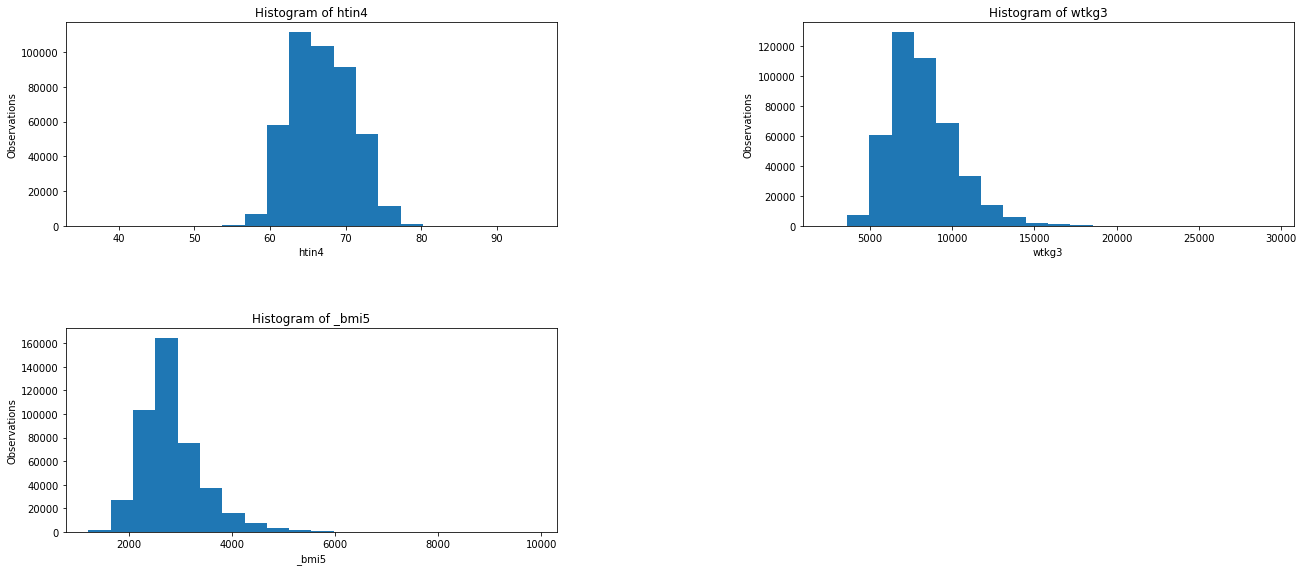

In [66]:
def get_dist(df):
    plt.figure(figsize=(22,15))
    for i, col in enumerate(df):
        plt.subplot(3, 2, i+1)
        plt.hist(df[col], bins=20)
        plt.title('Histogram of {}'.format(col))
        plt.xlabel('{}'.format(col))
        plt.ylabel('Observations')
        plt.subplots_adjust(hspace=.5, wspace=.5)
        
        
# Call histogram function         
get_dist(continuous_brfss_eda)        

In [67]:
cat_brfss_eda = brfss_eda.drop(columns=['htin4', 
                                        'wtkg3', 
                                        '_bmi5', 
                                        'seqno',
                                        'imonth',
                                        'iday',
                                        'iyear',      
                                       ])

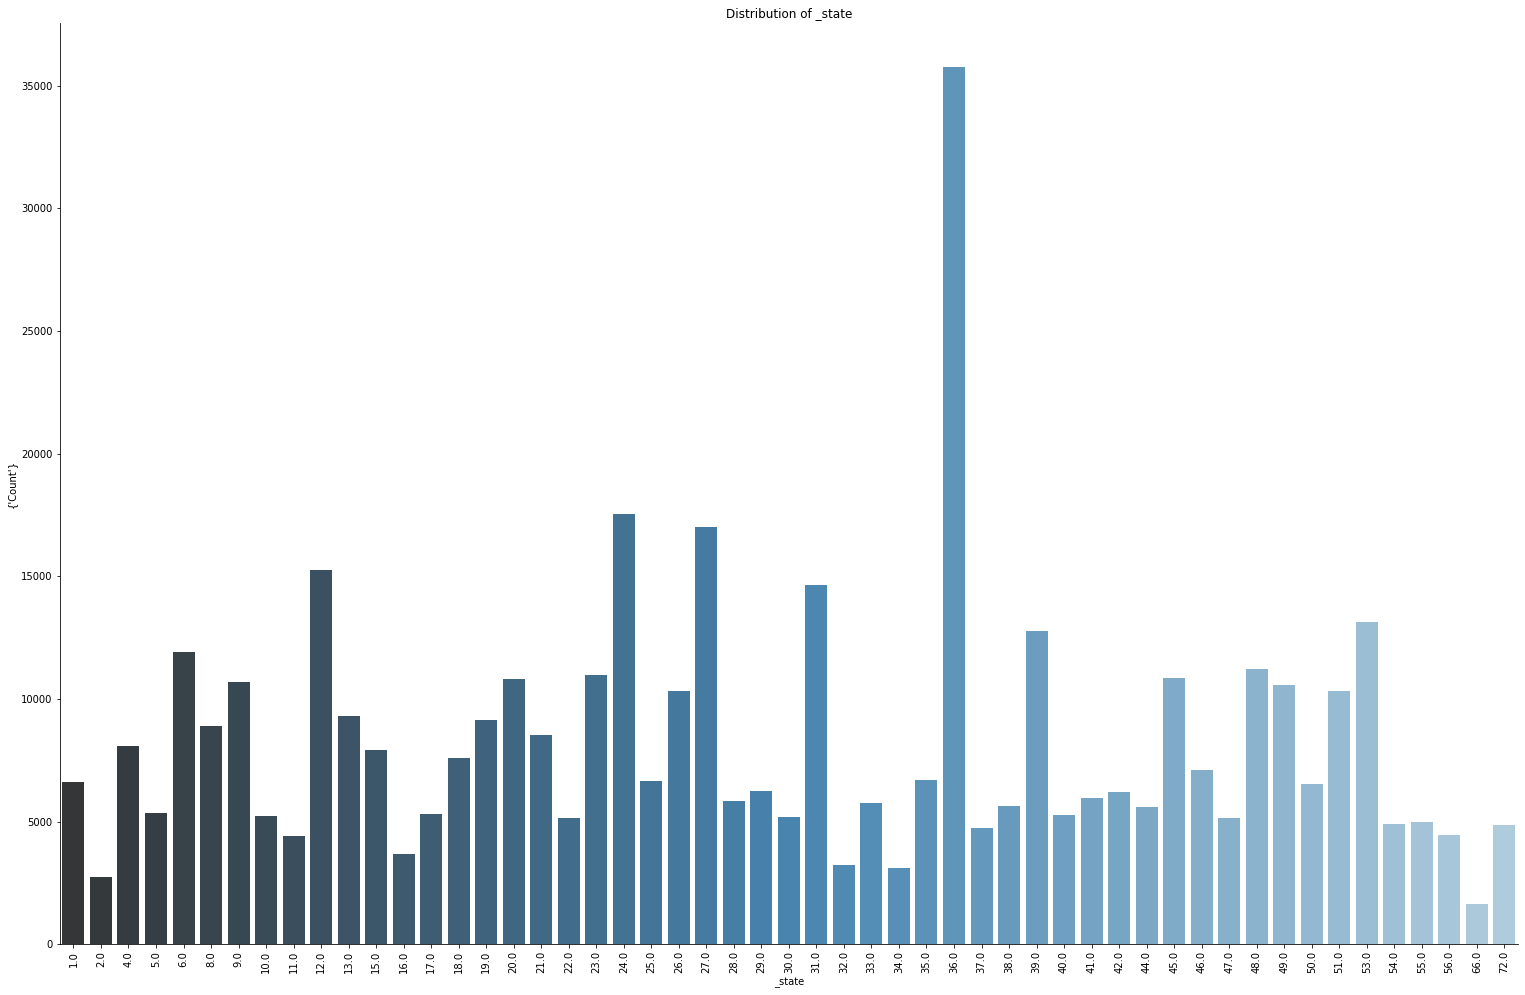

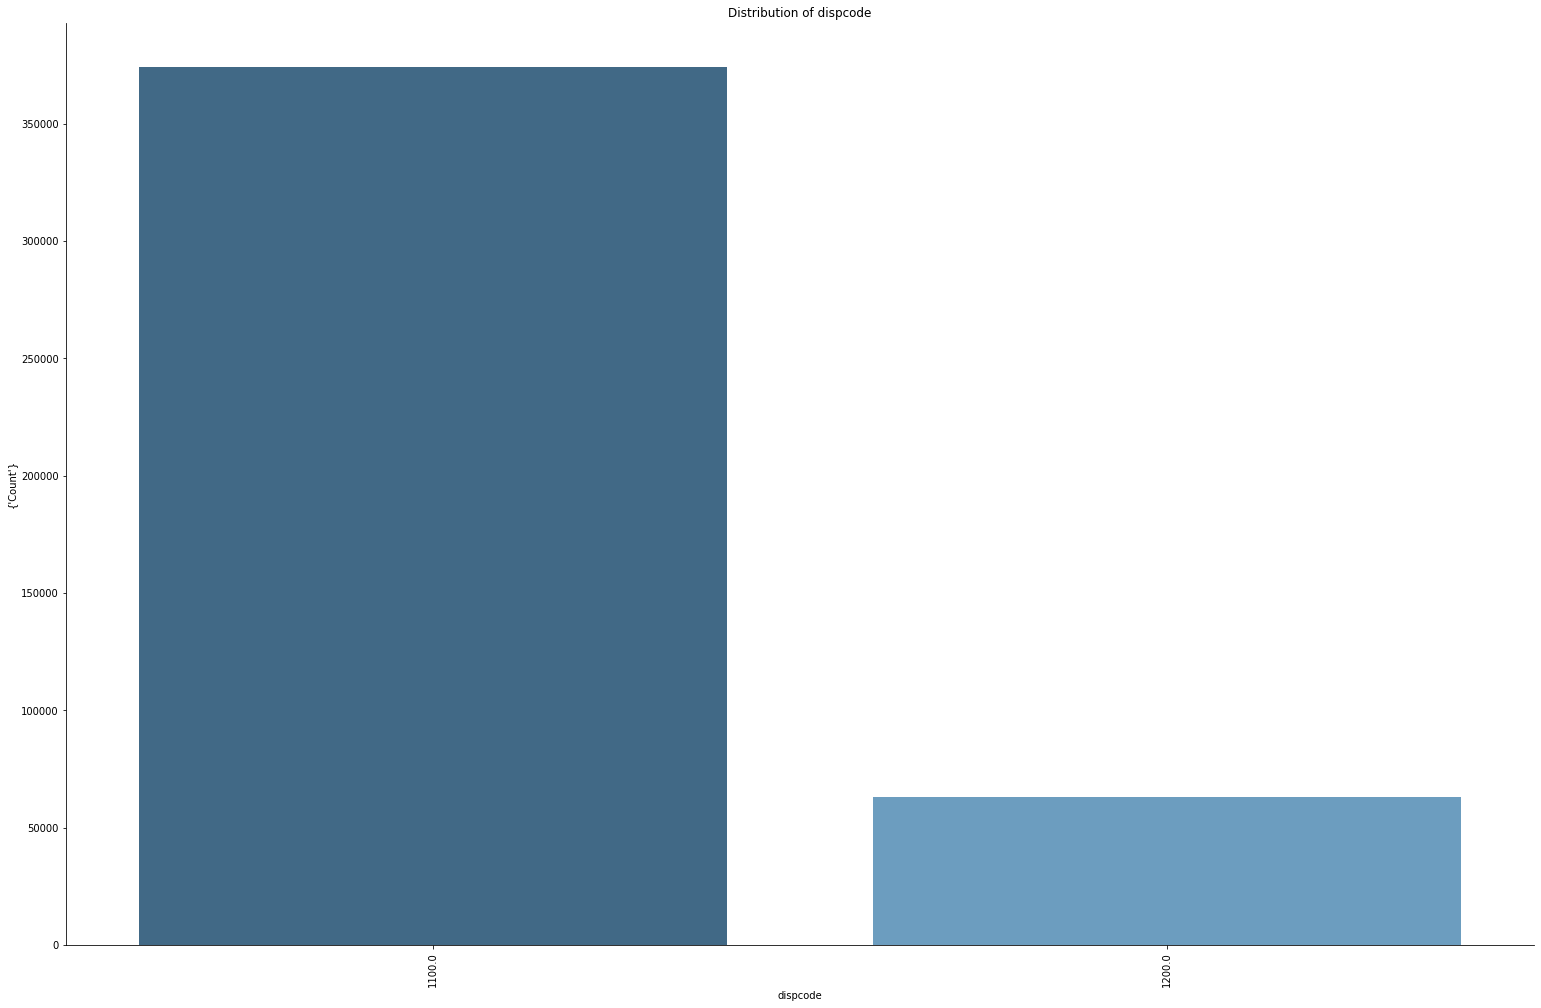

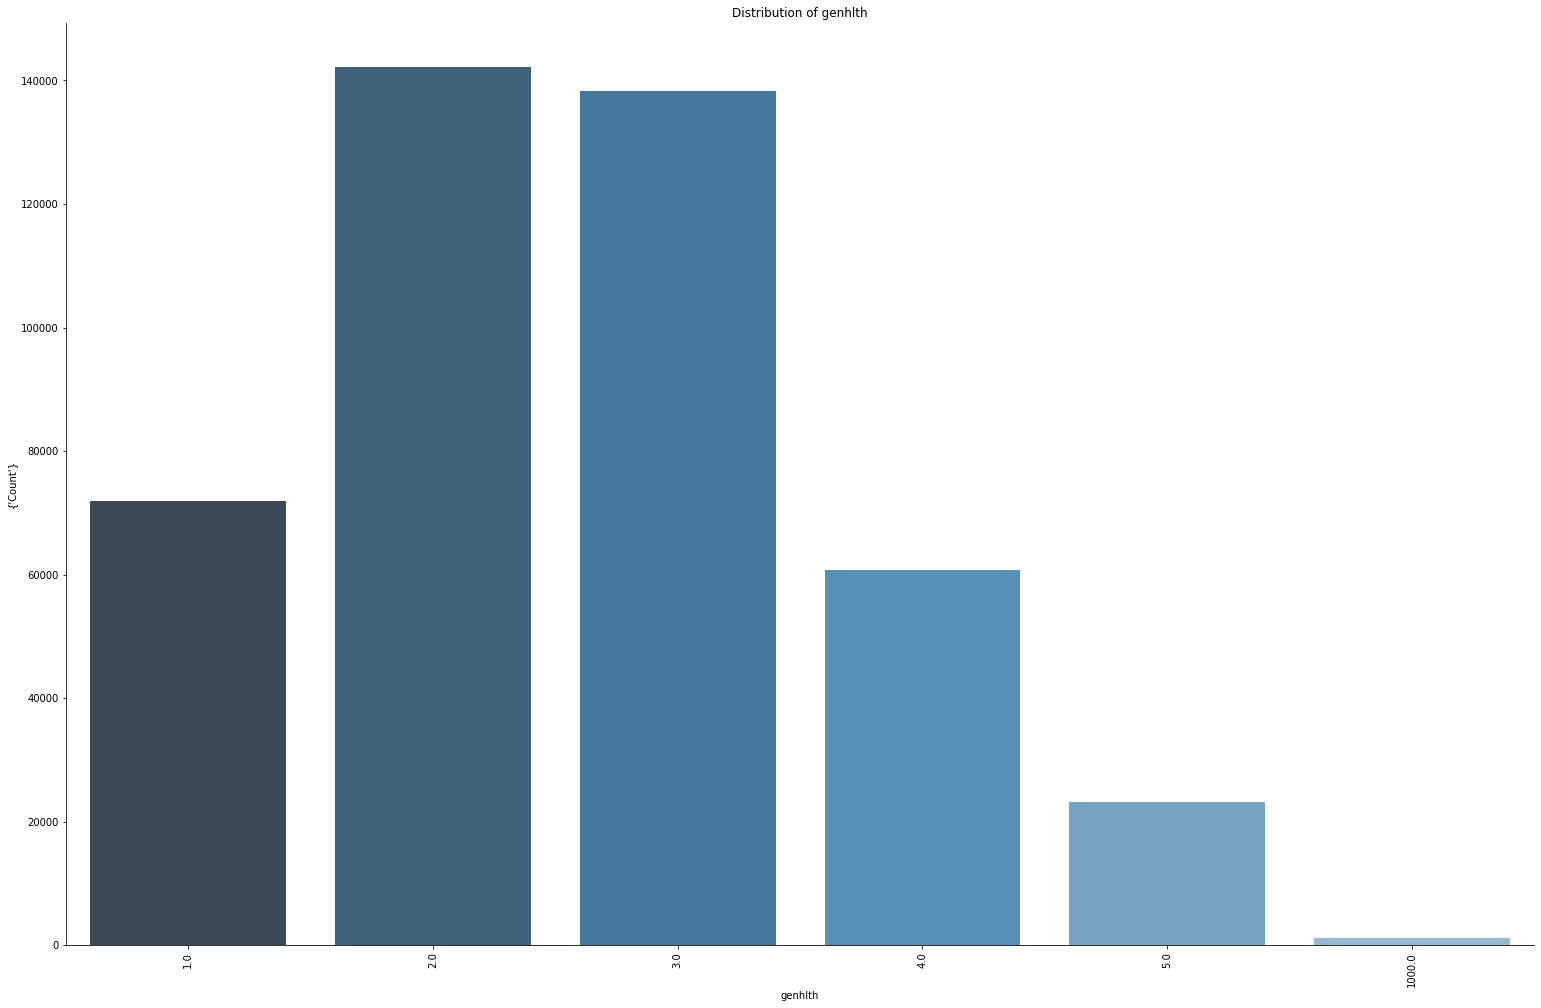

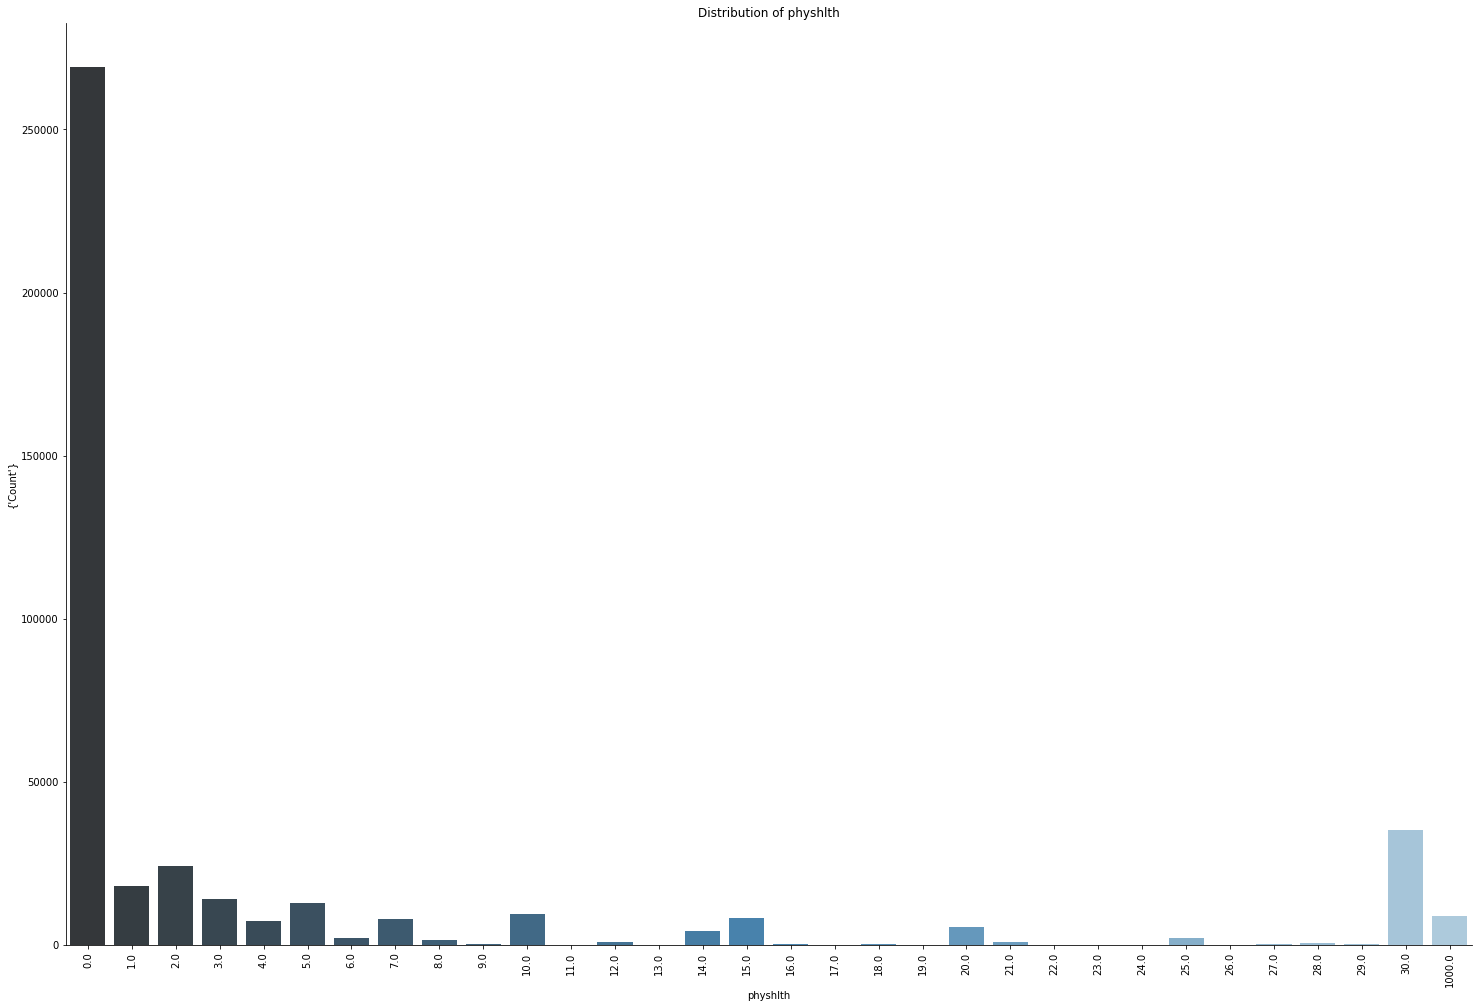

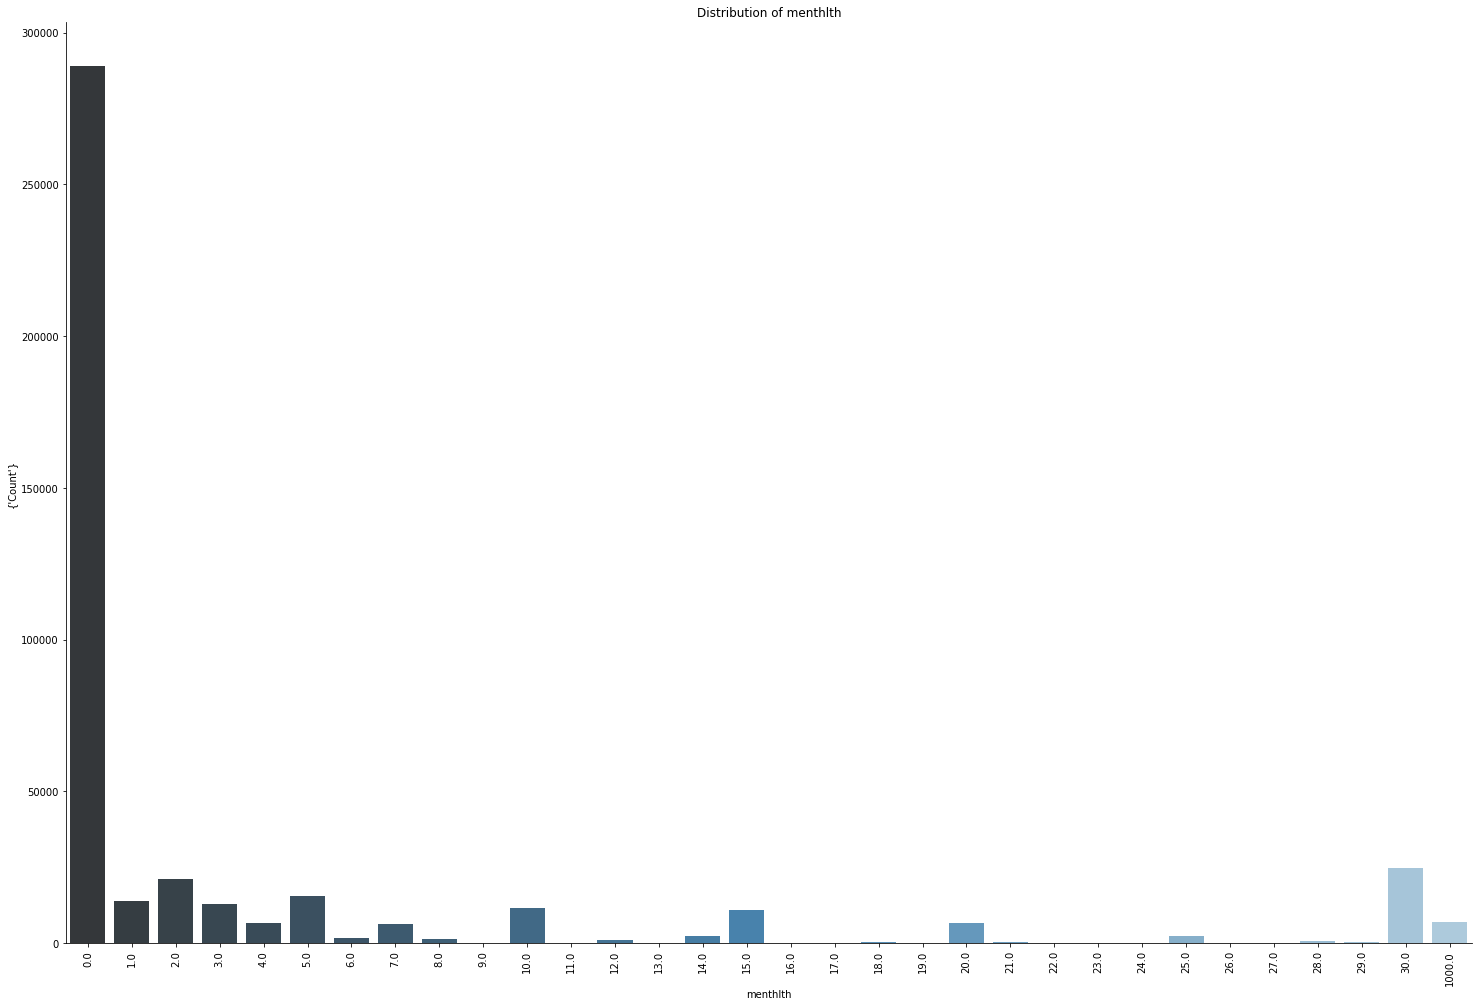

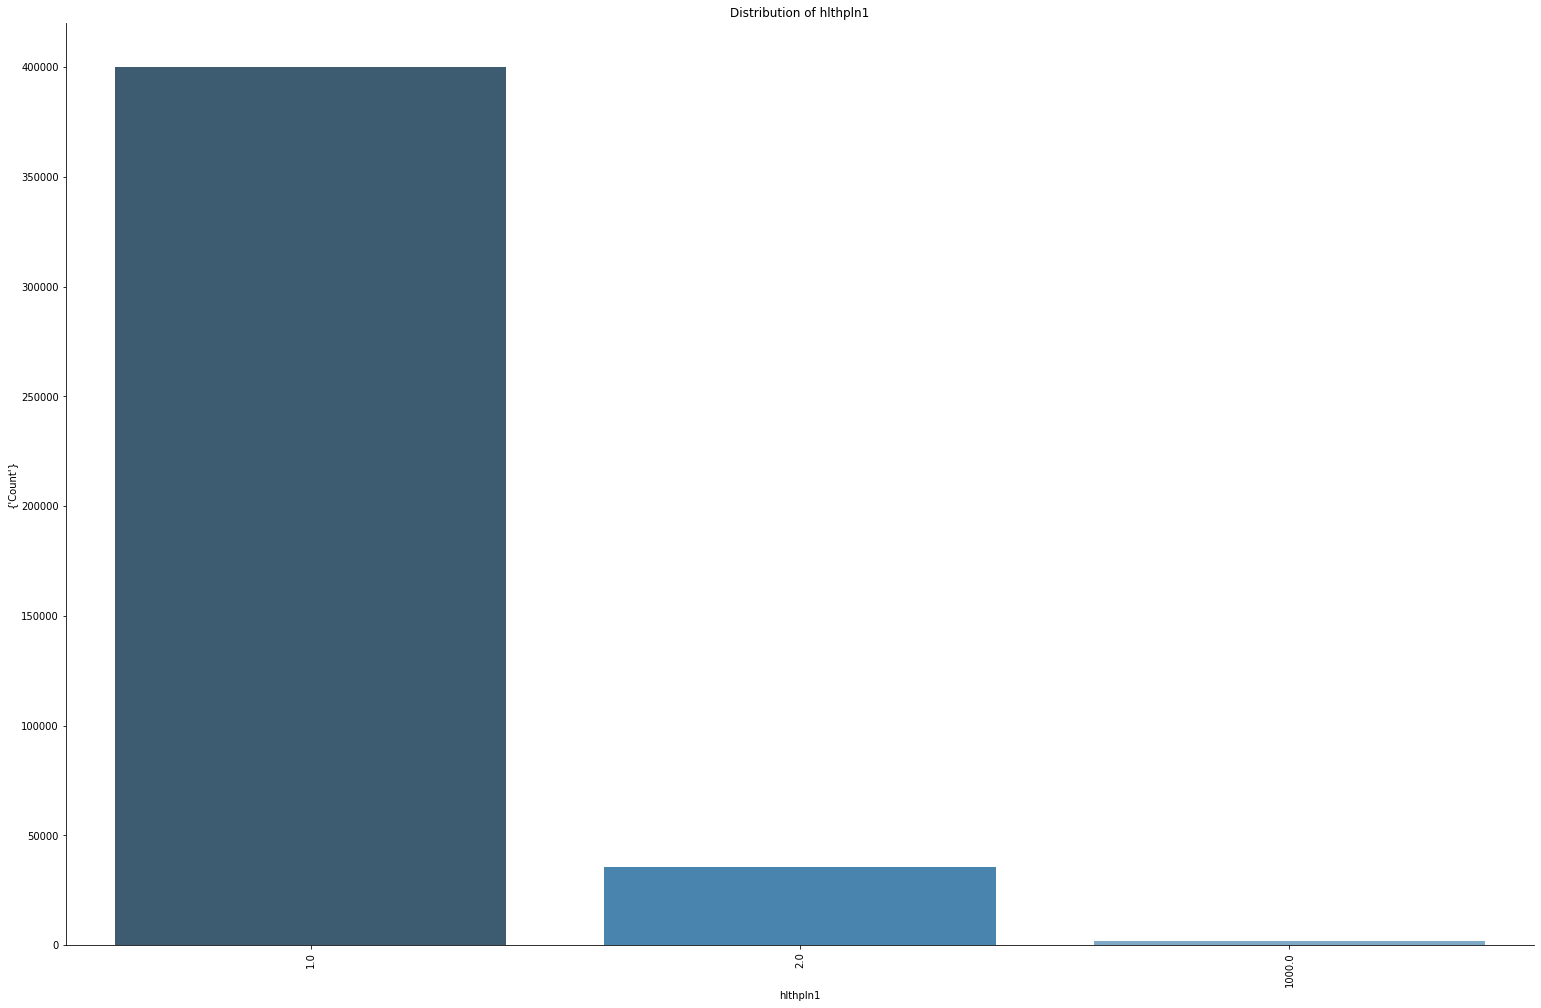

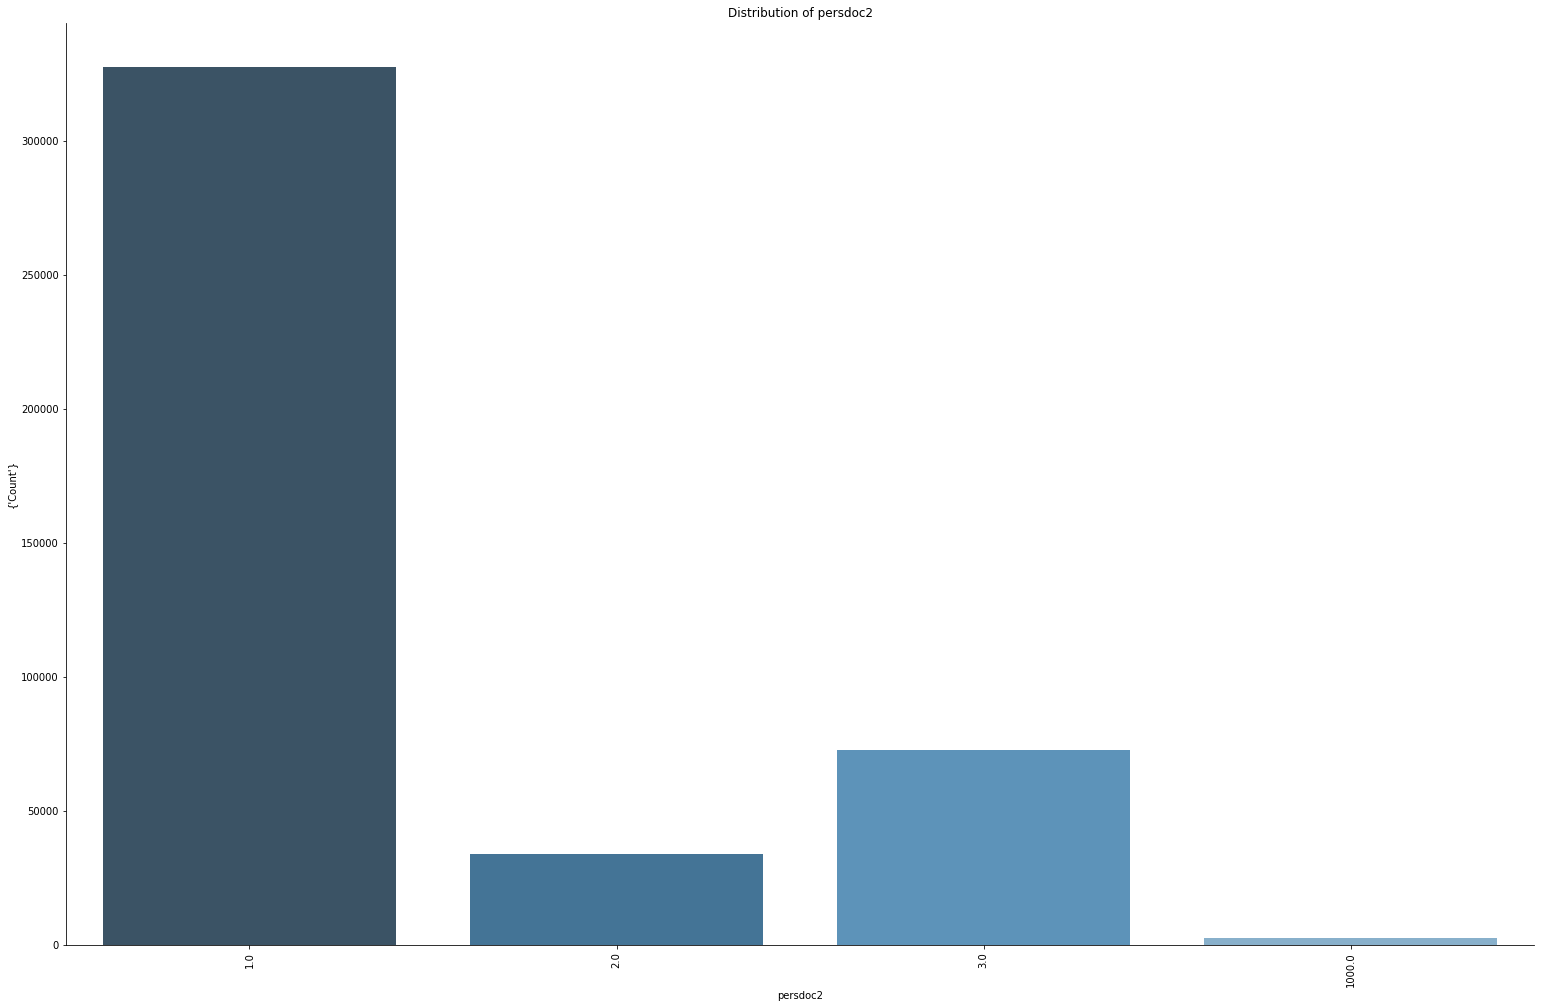

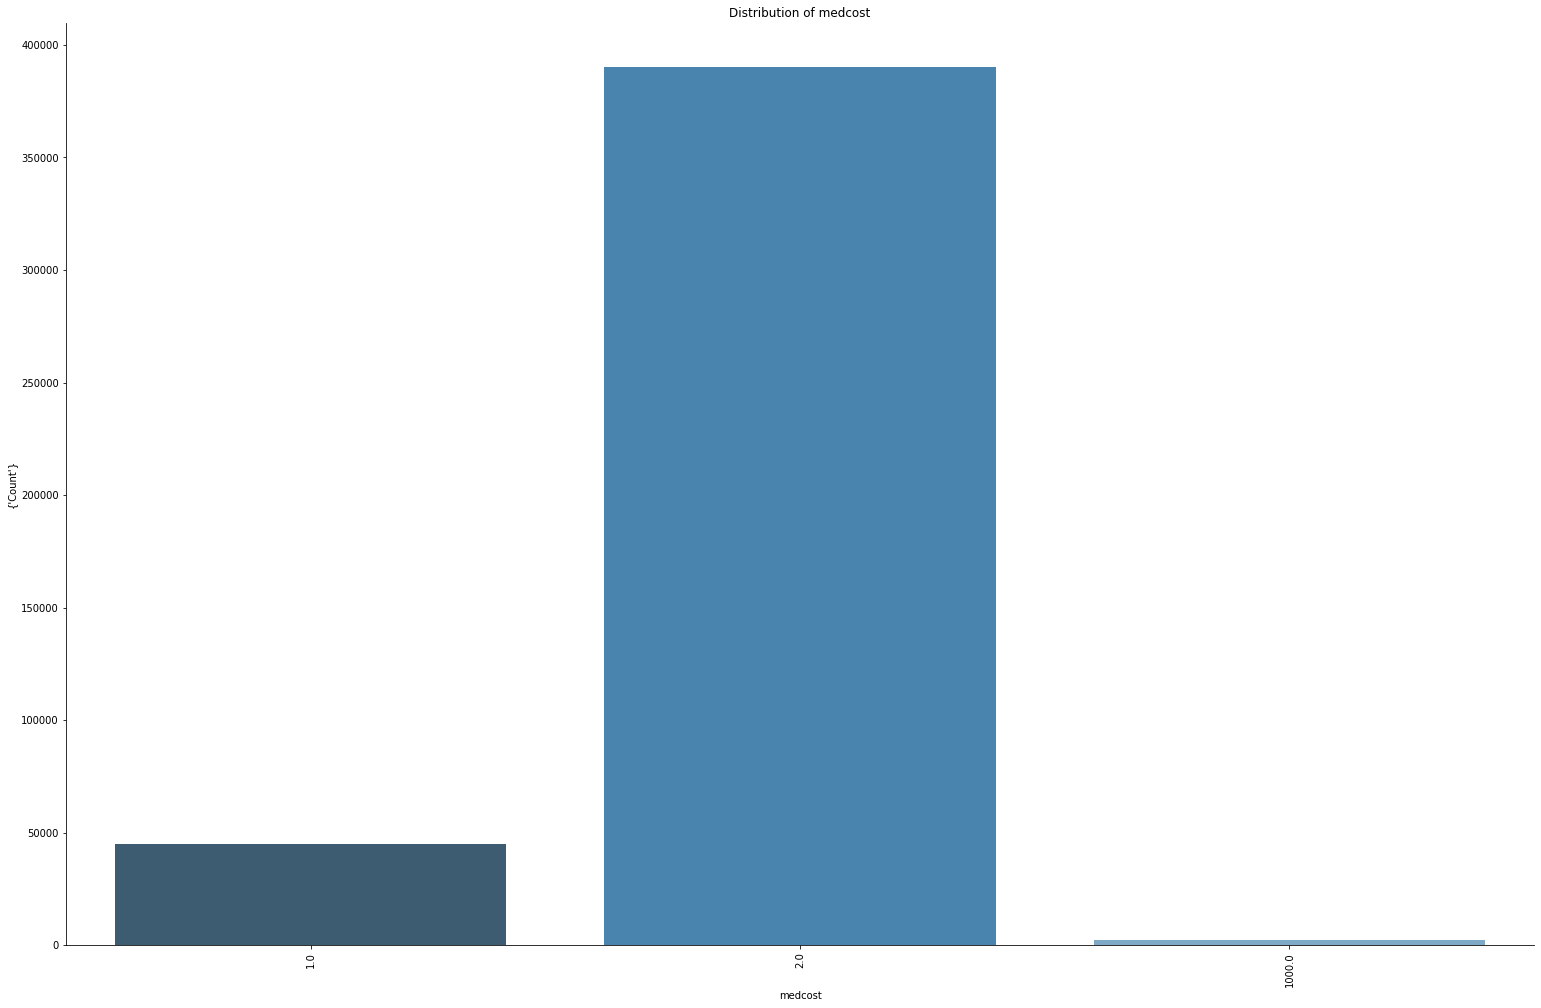

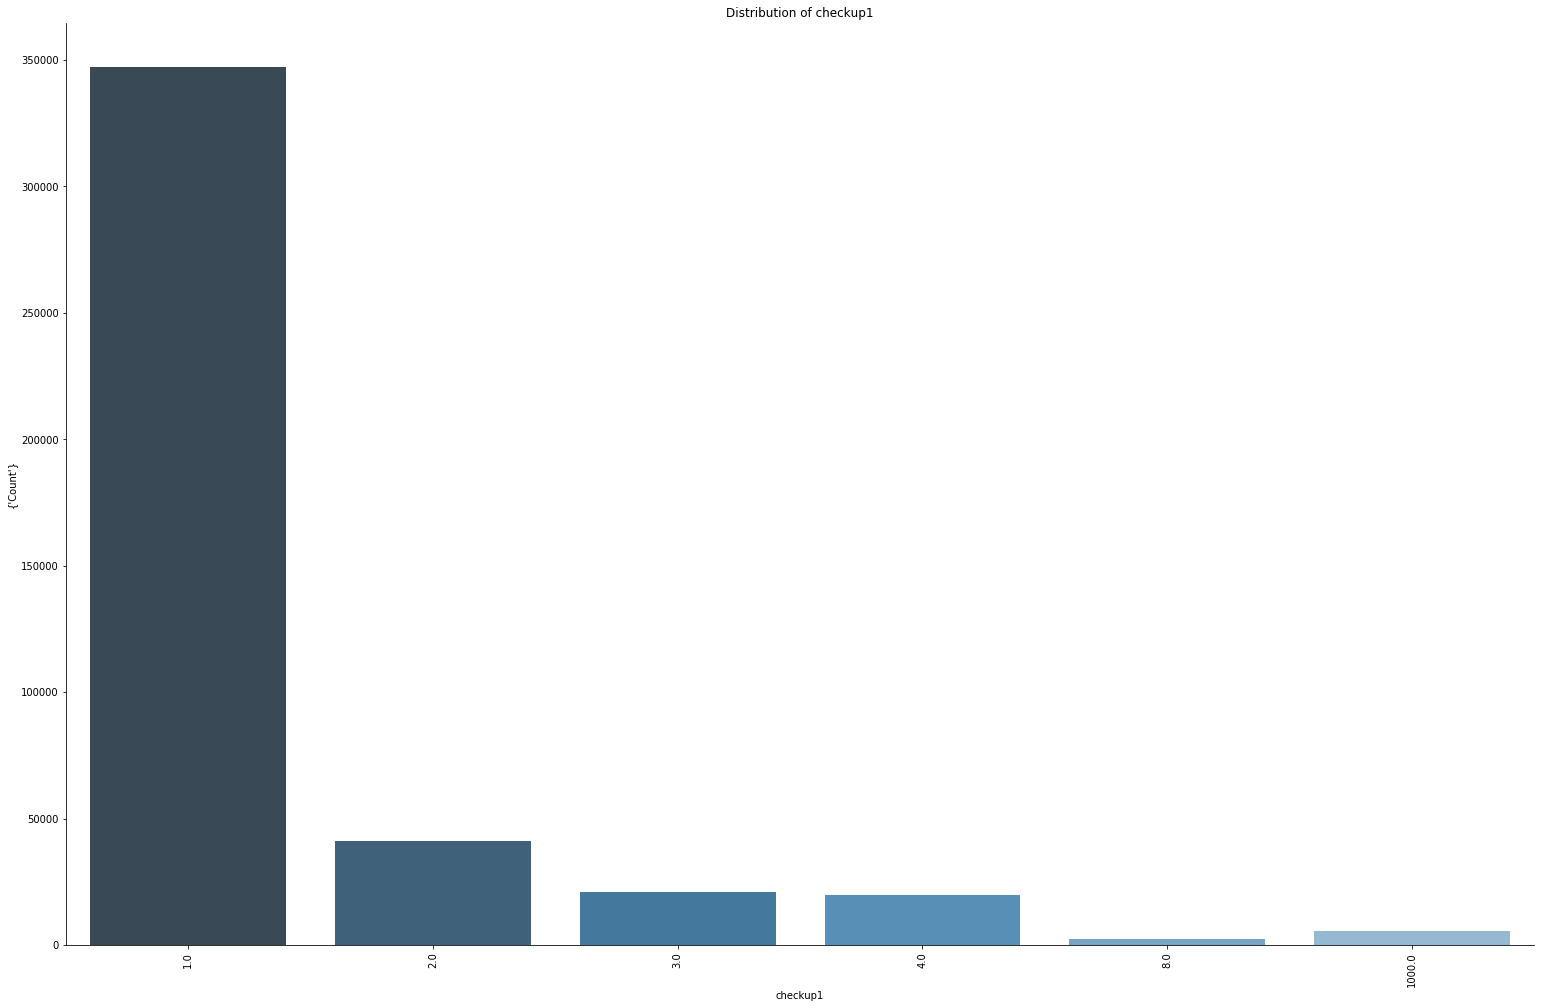

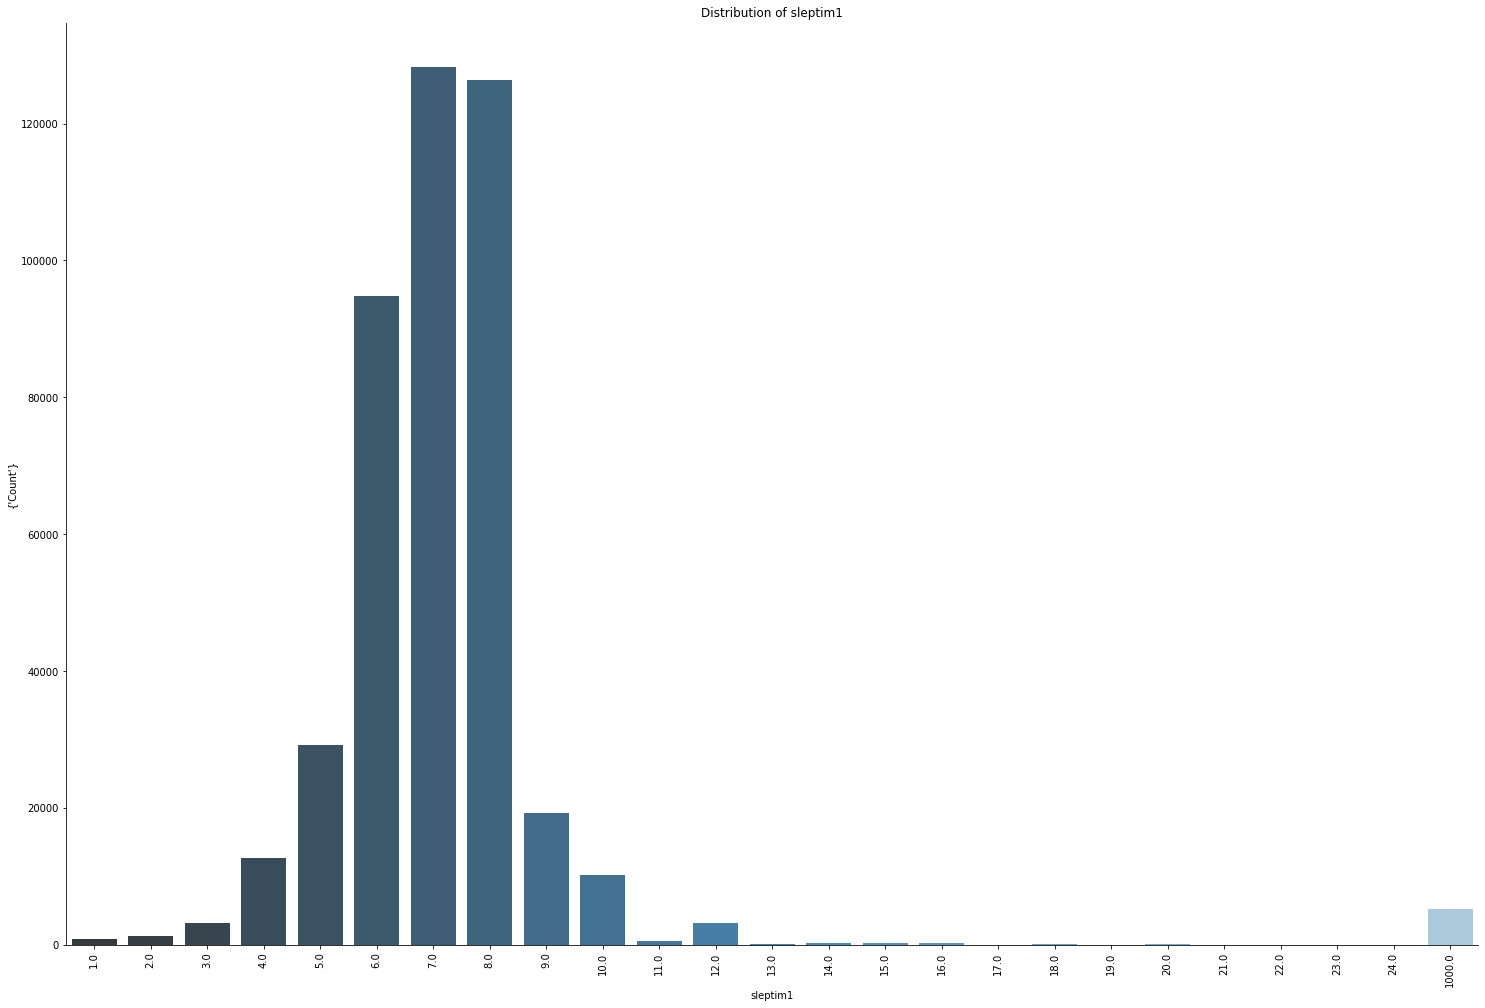

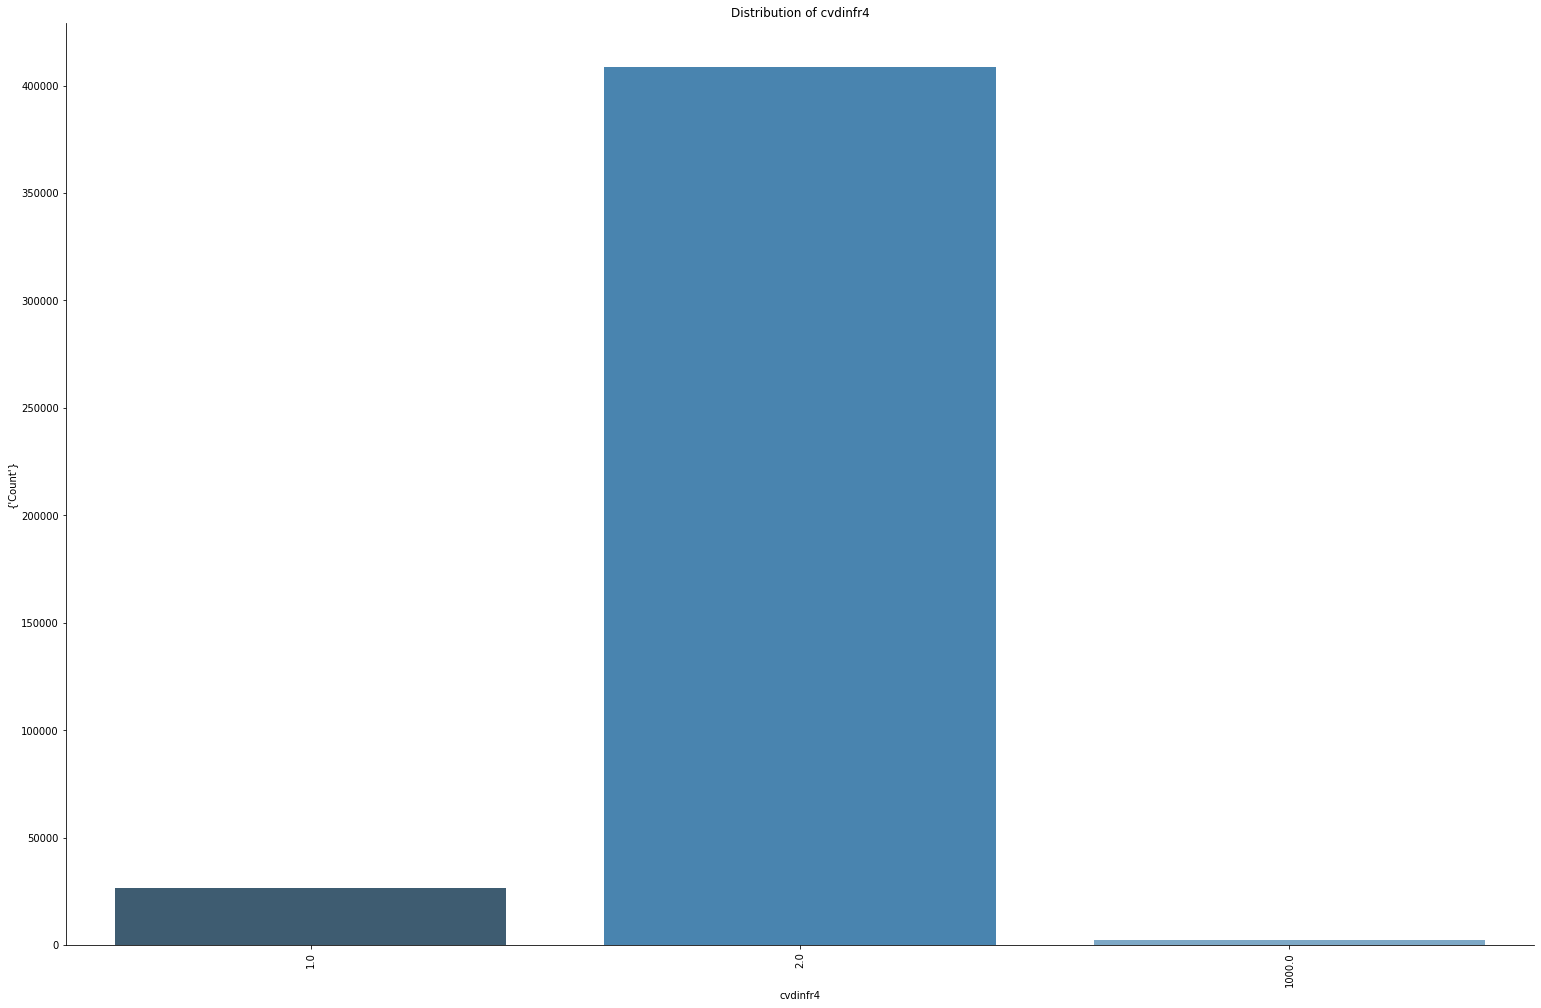

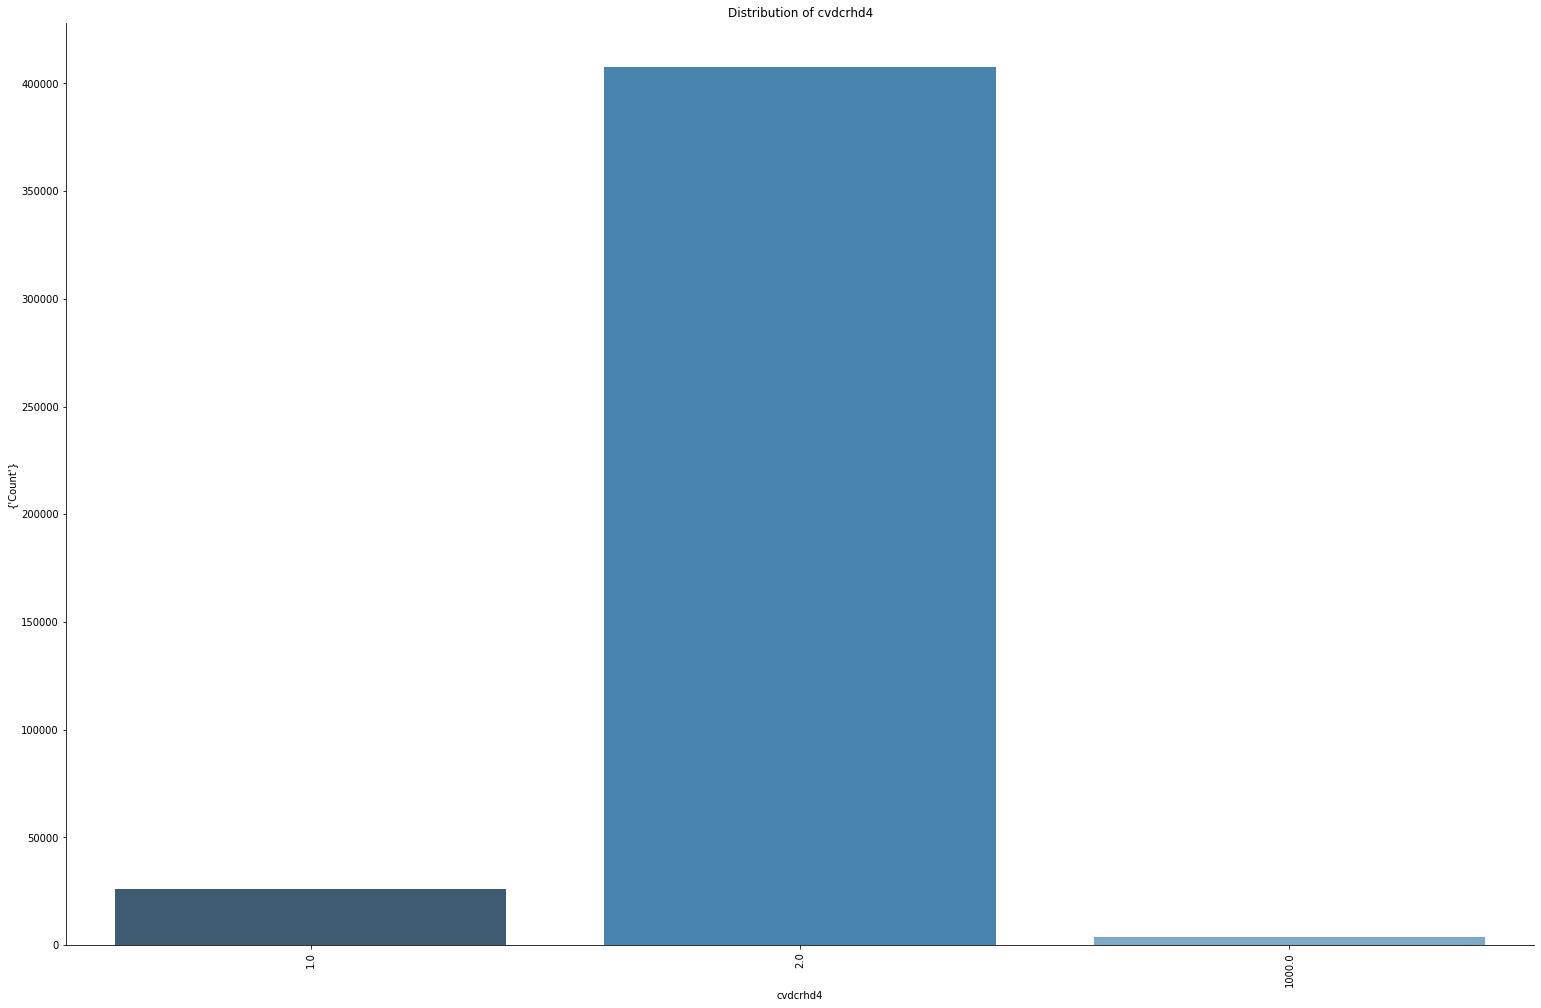

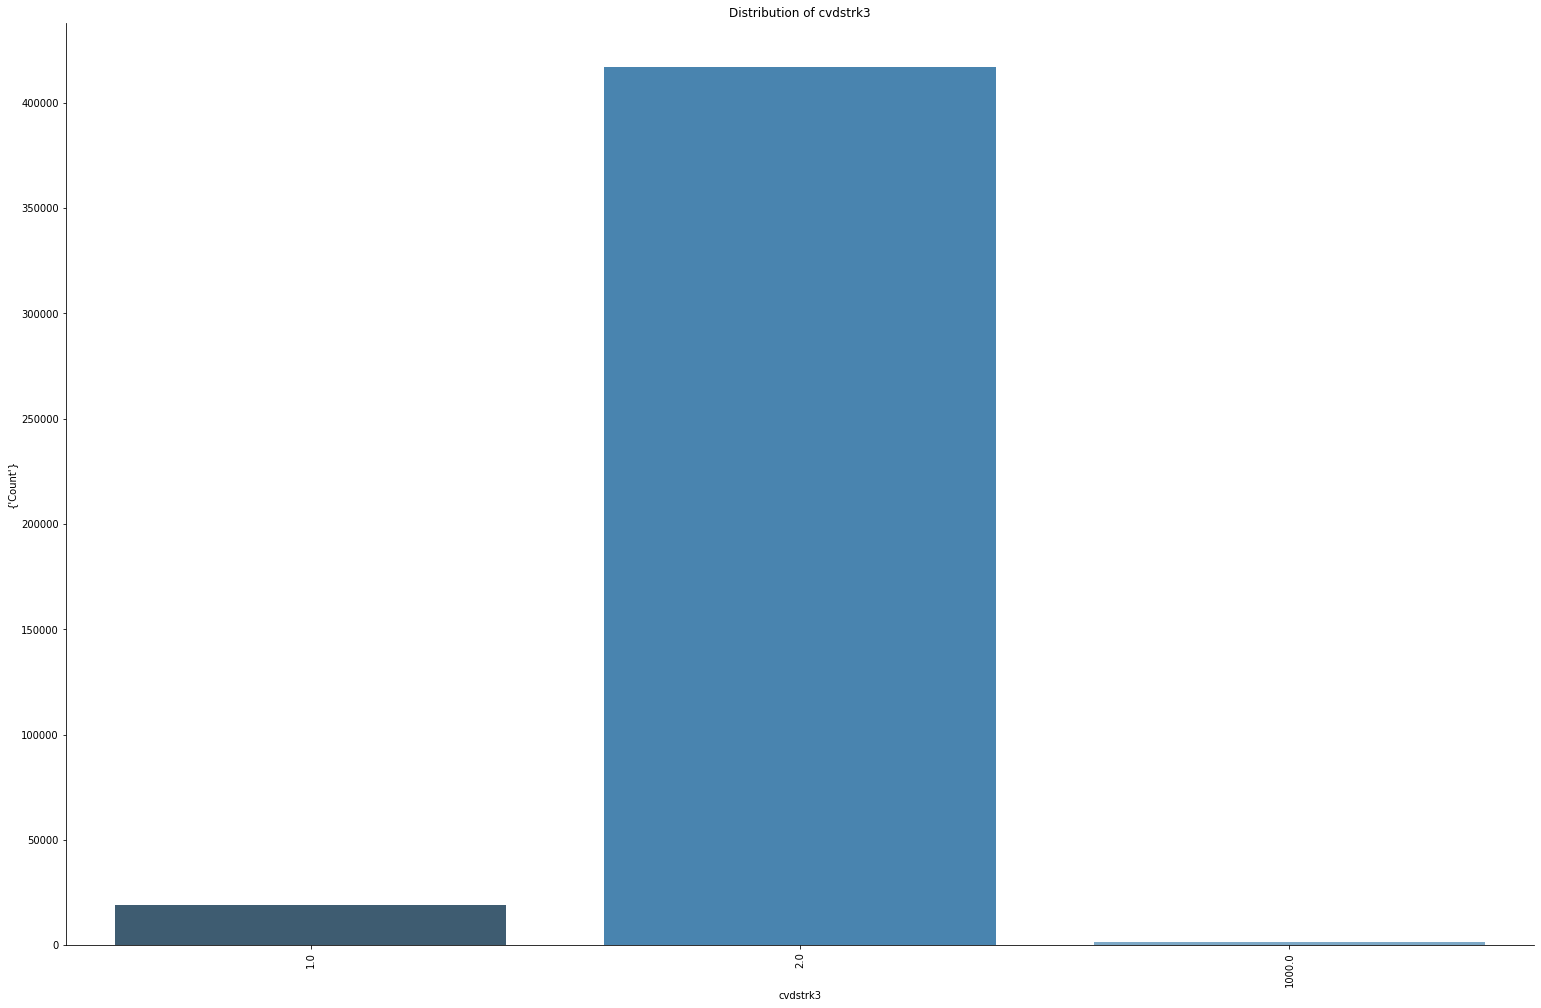

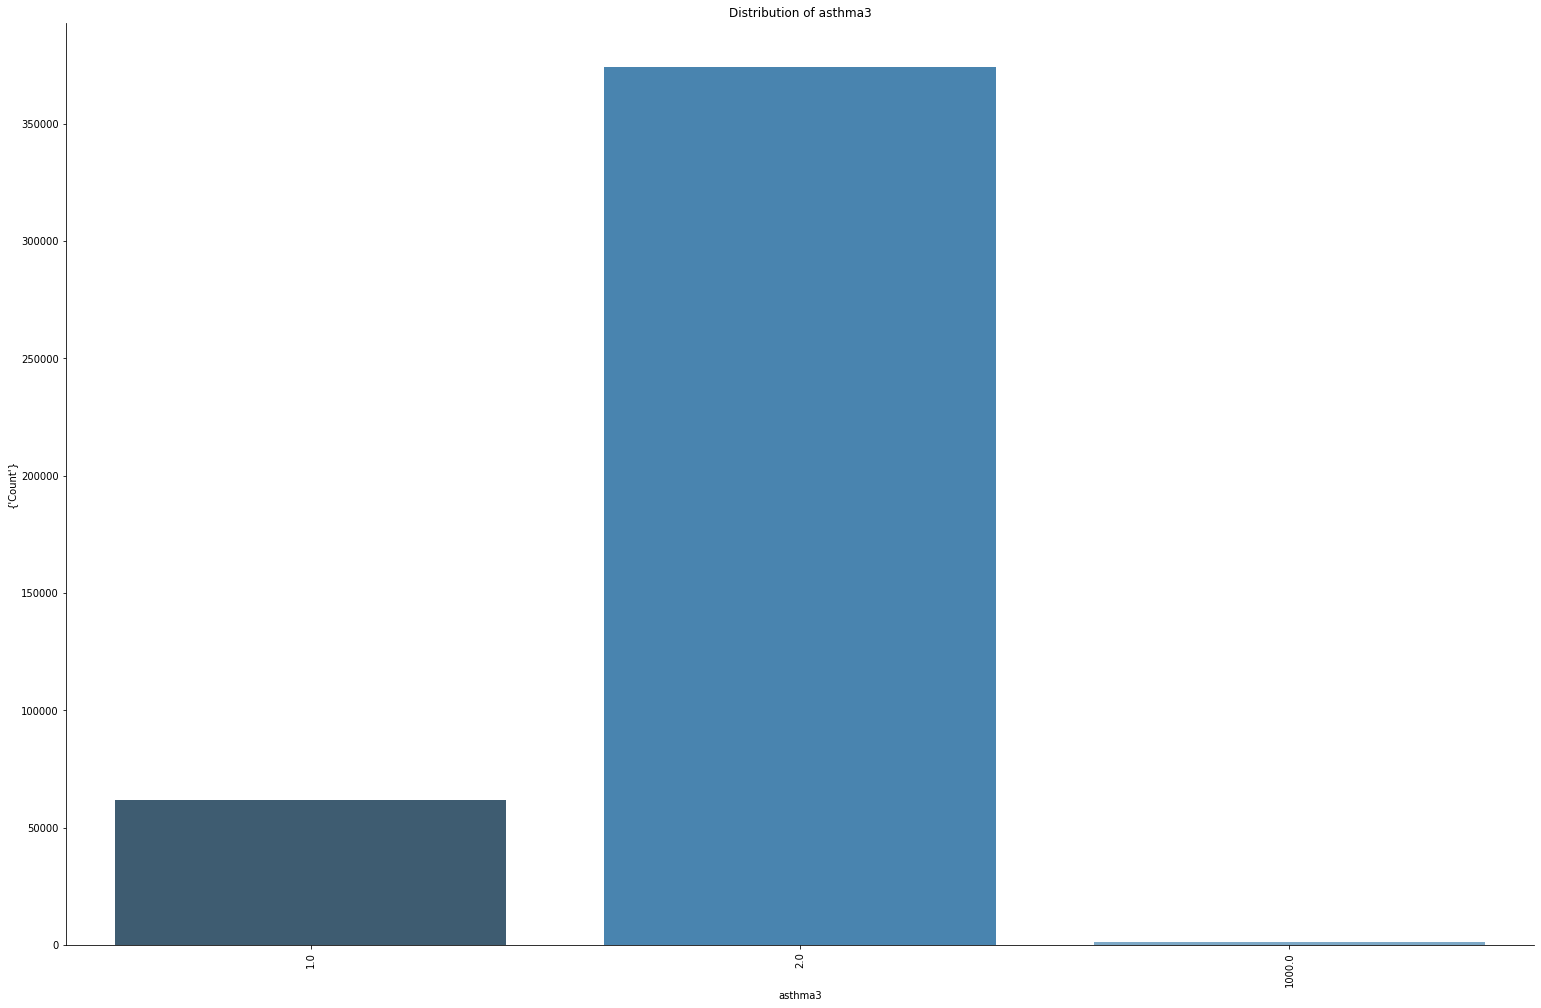

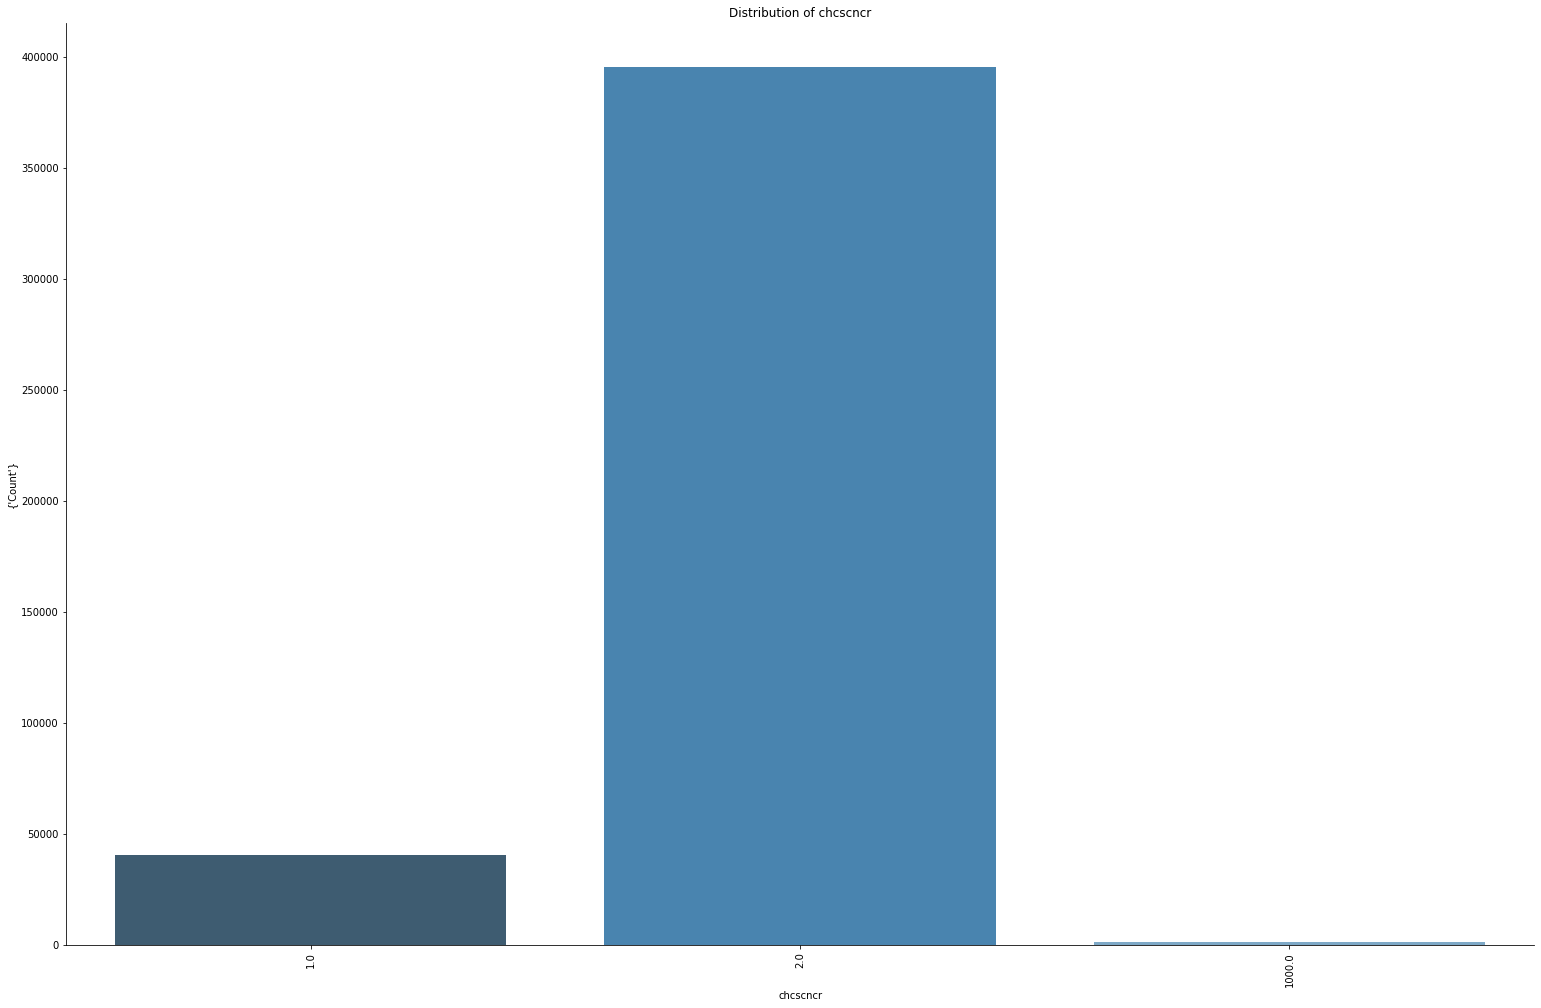

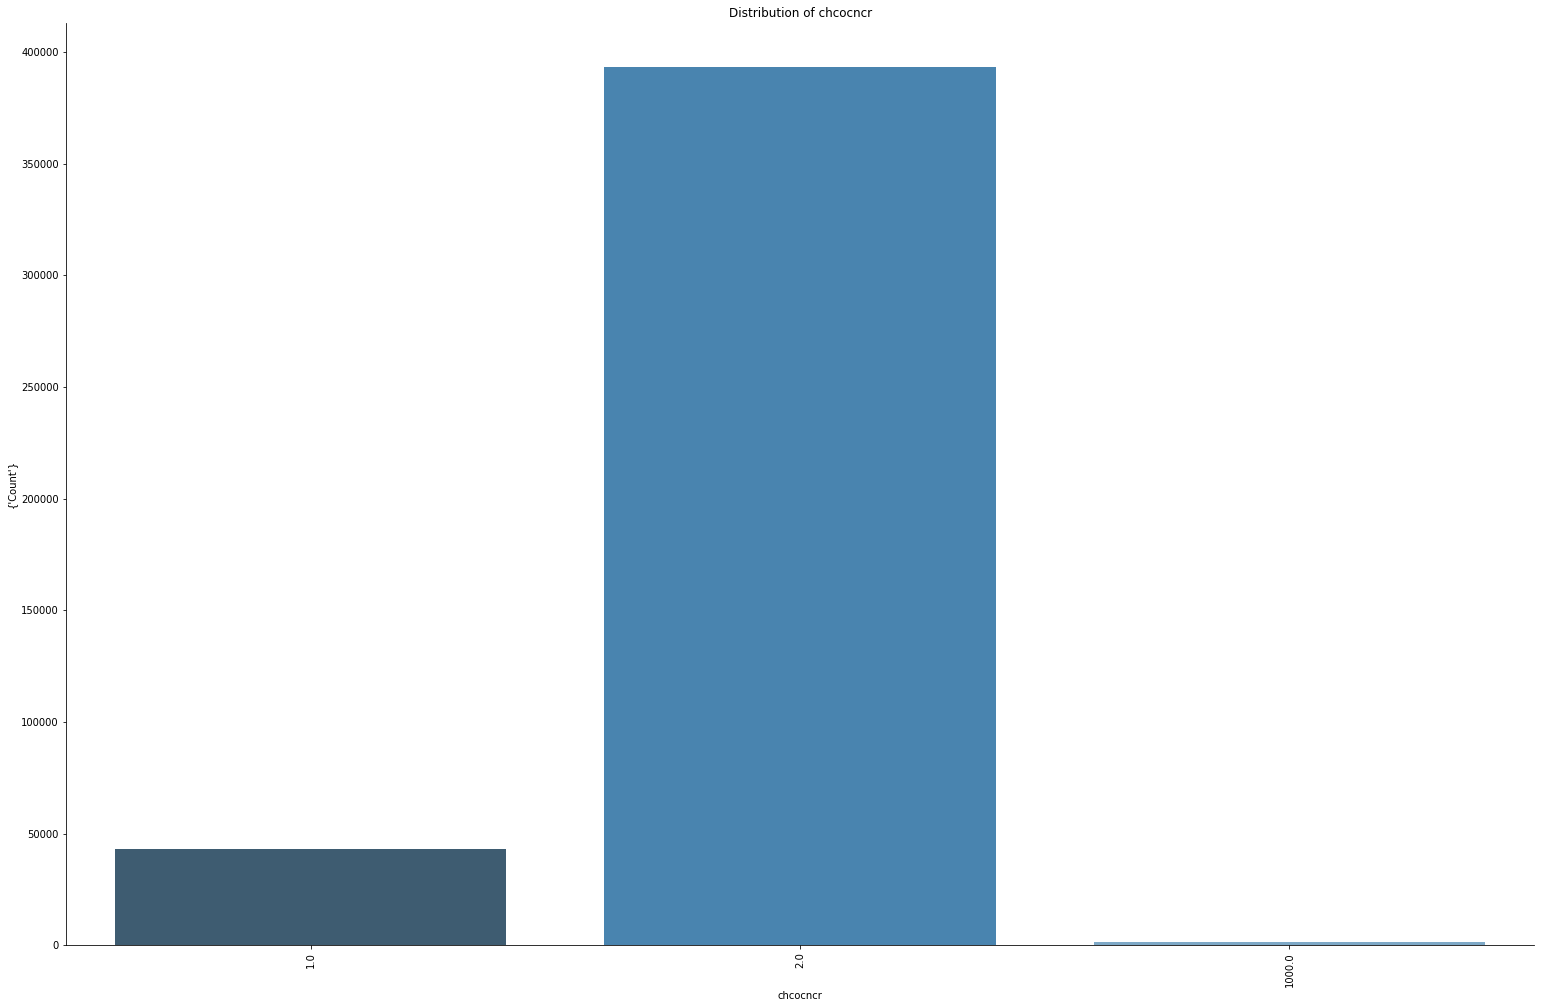

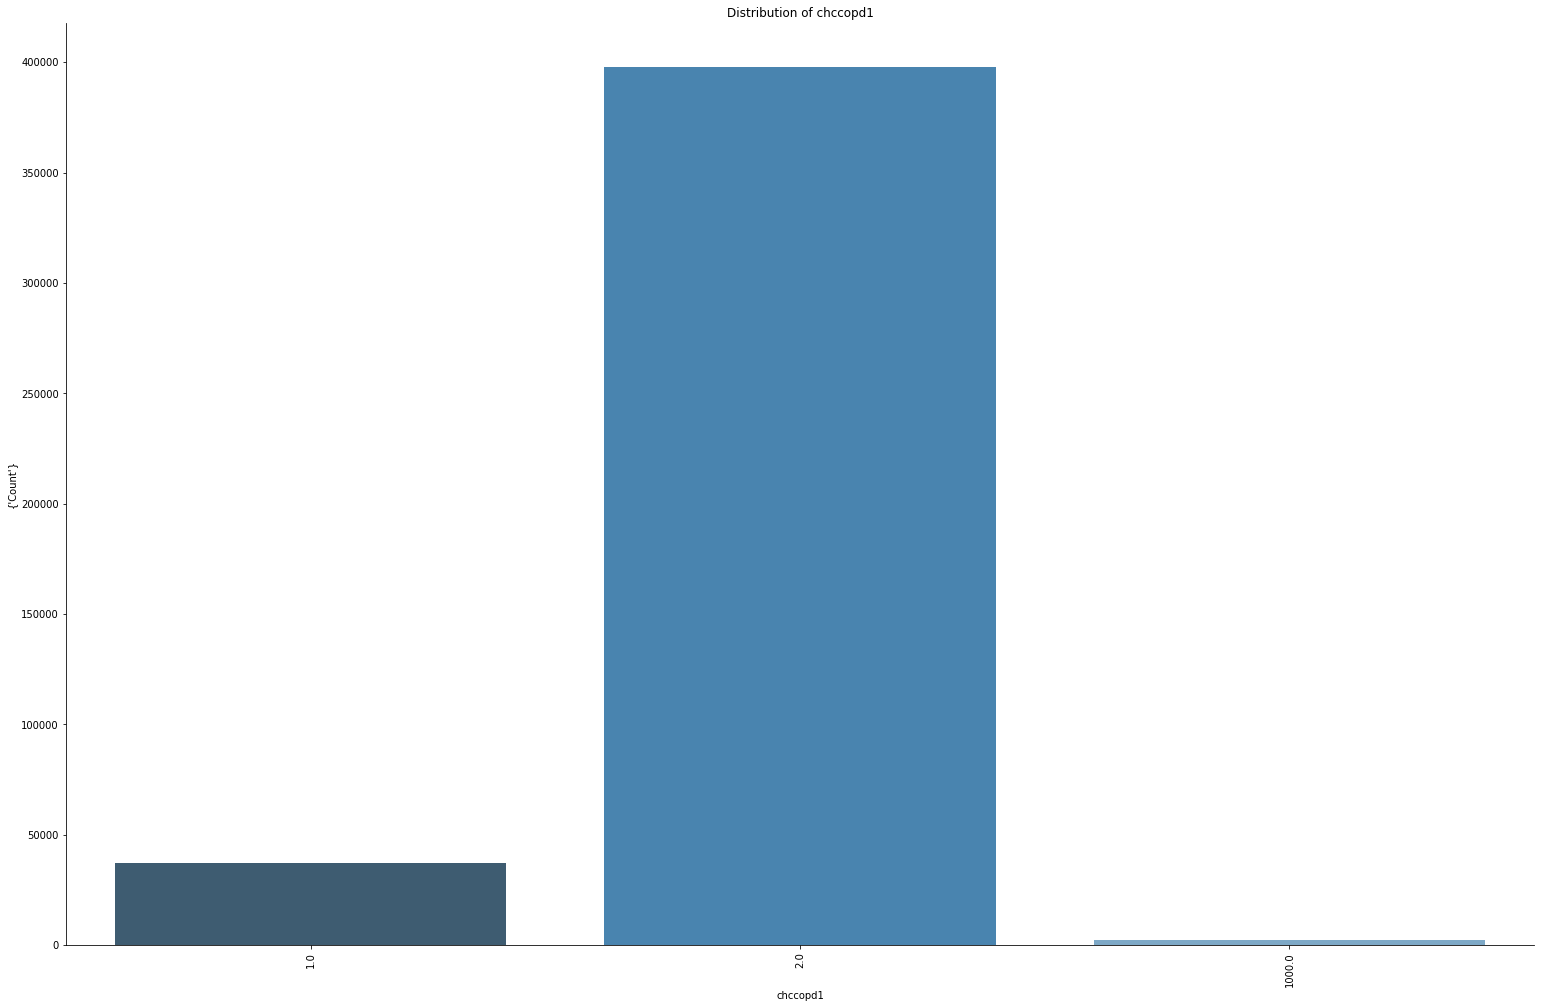

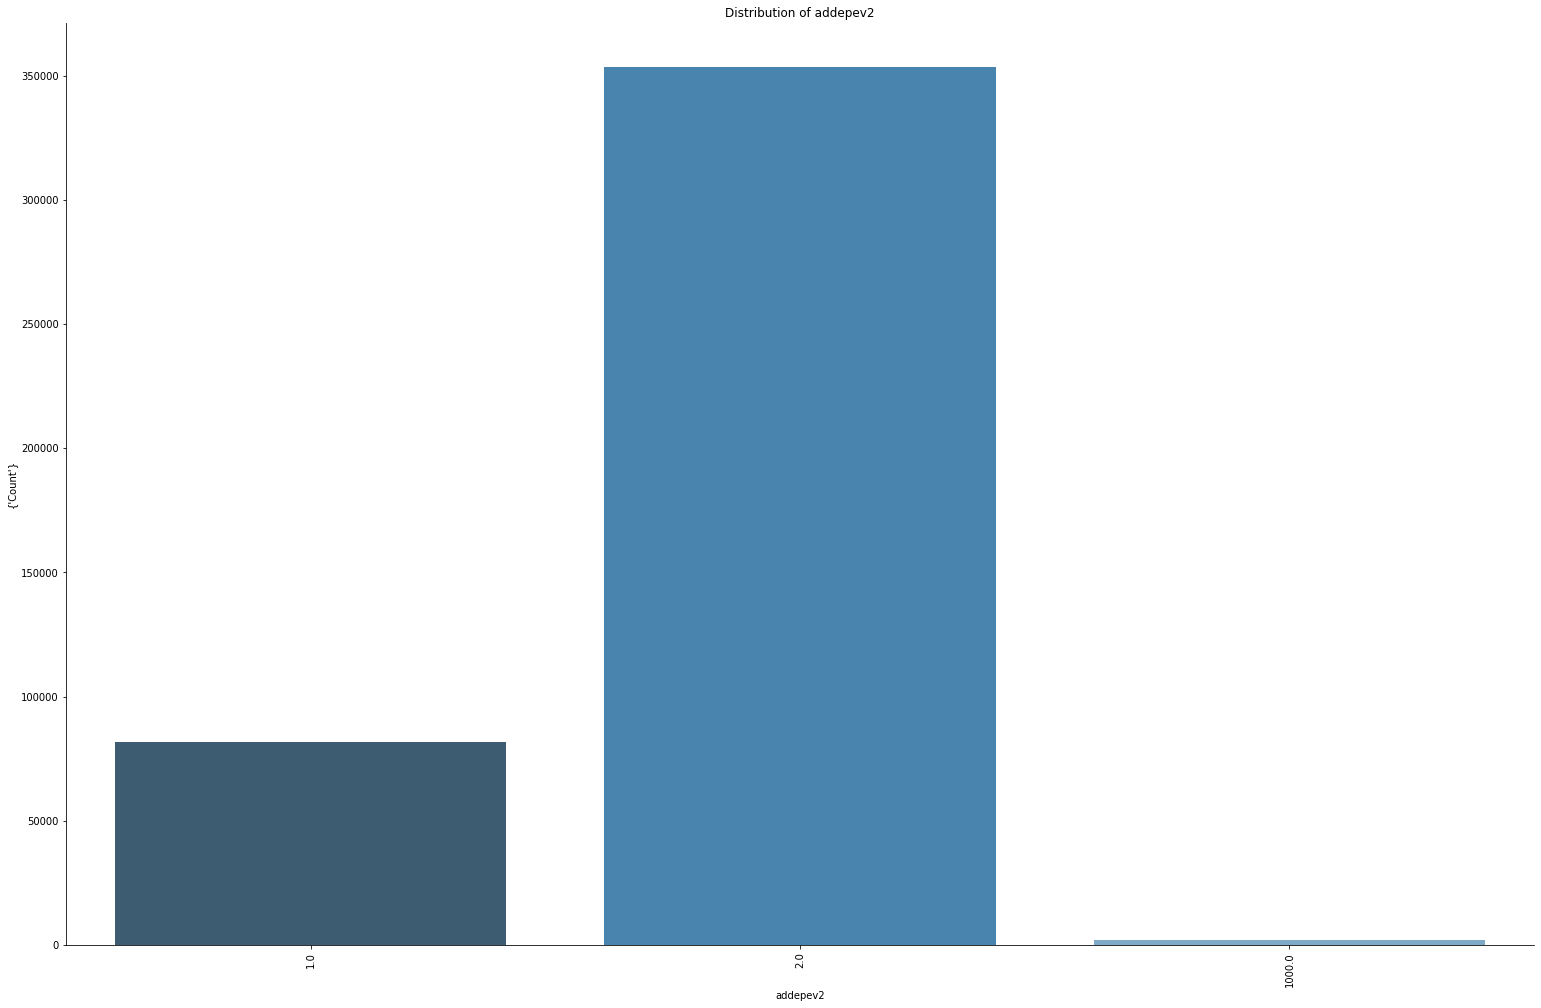

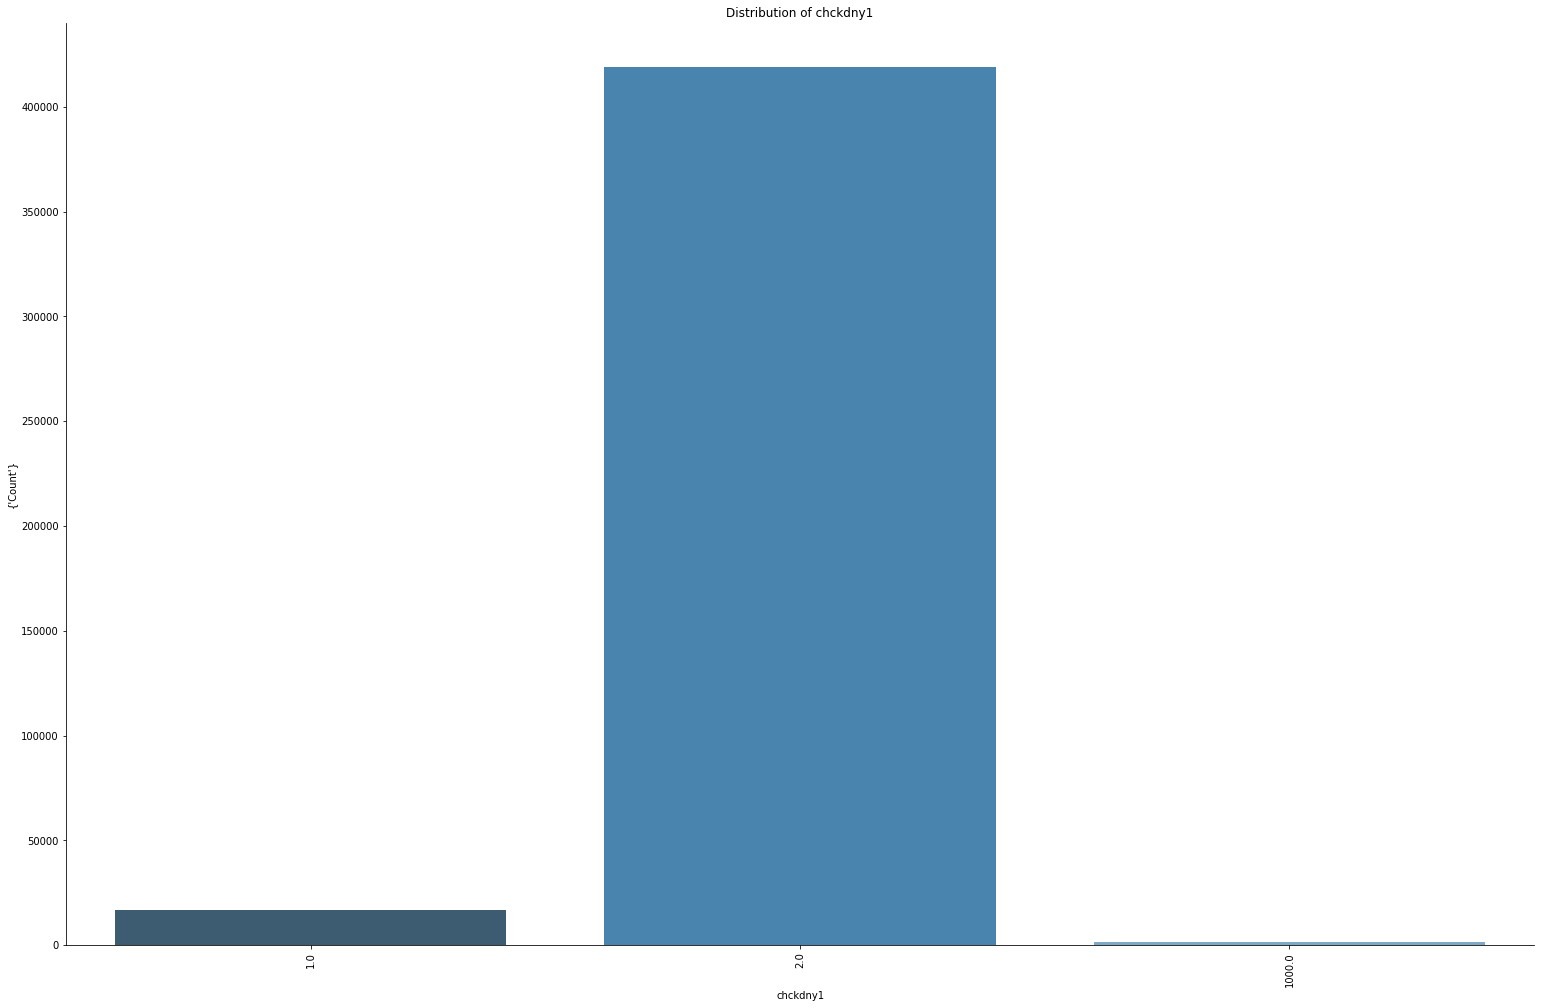

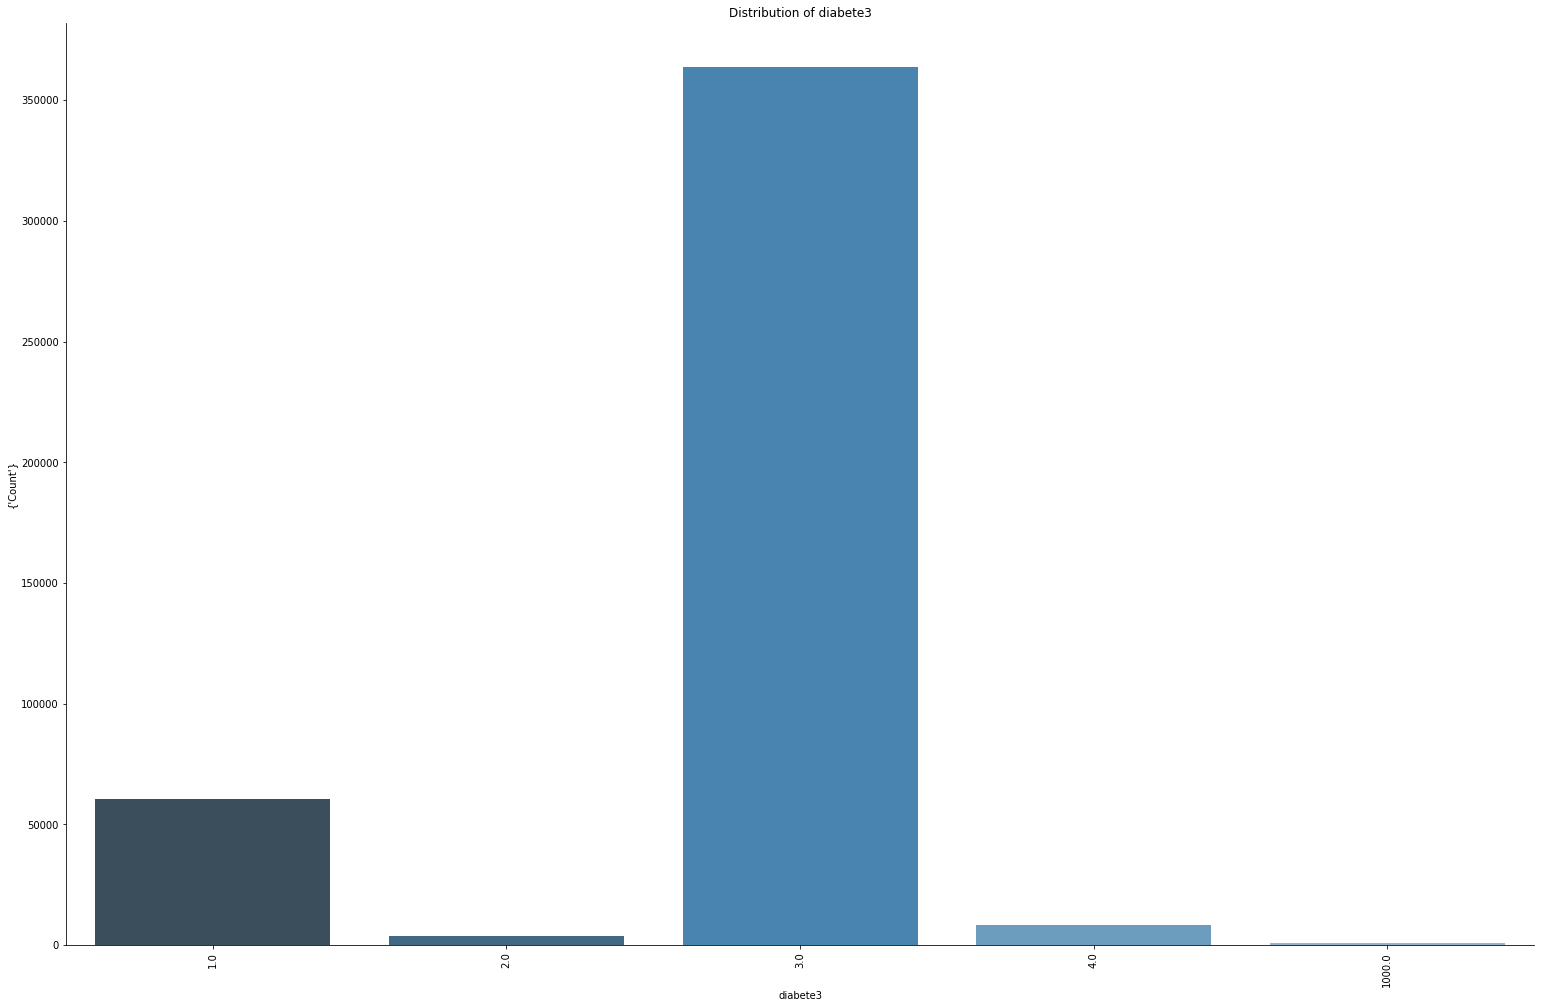

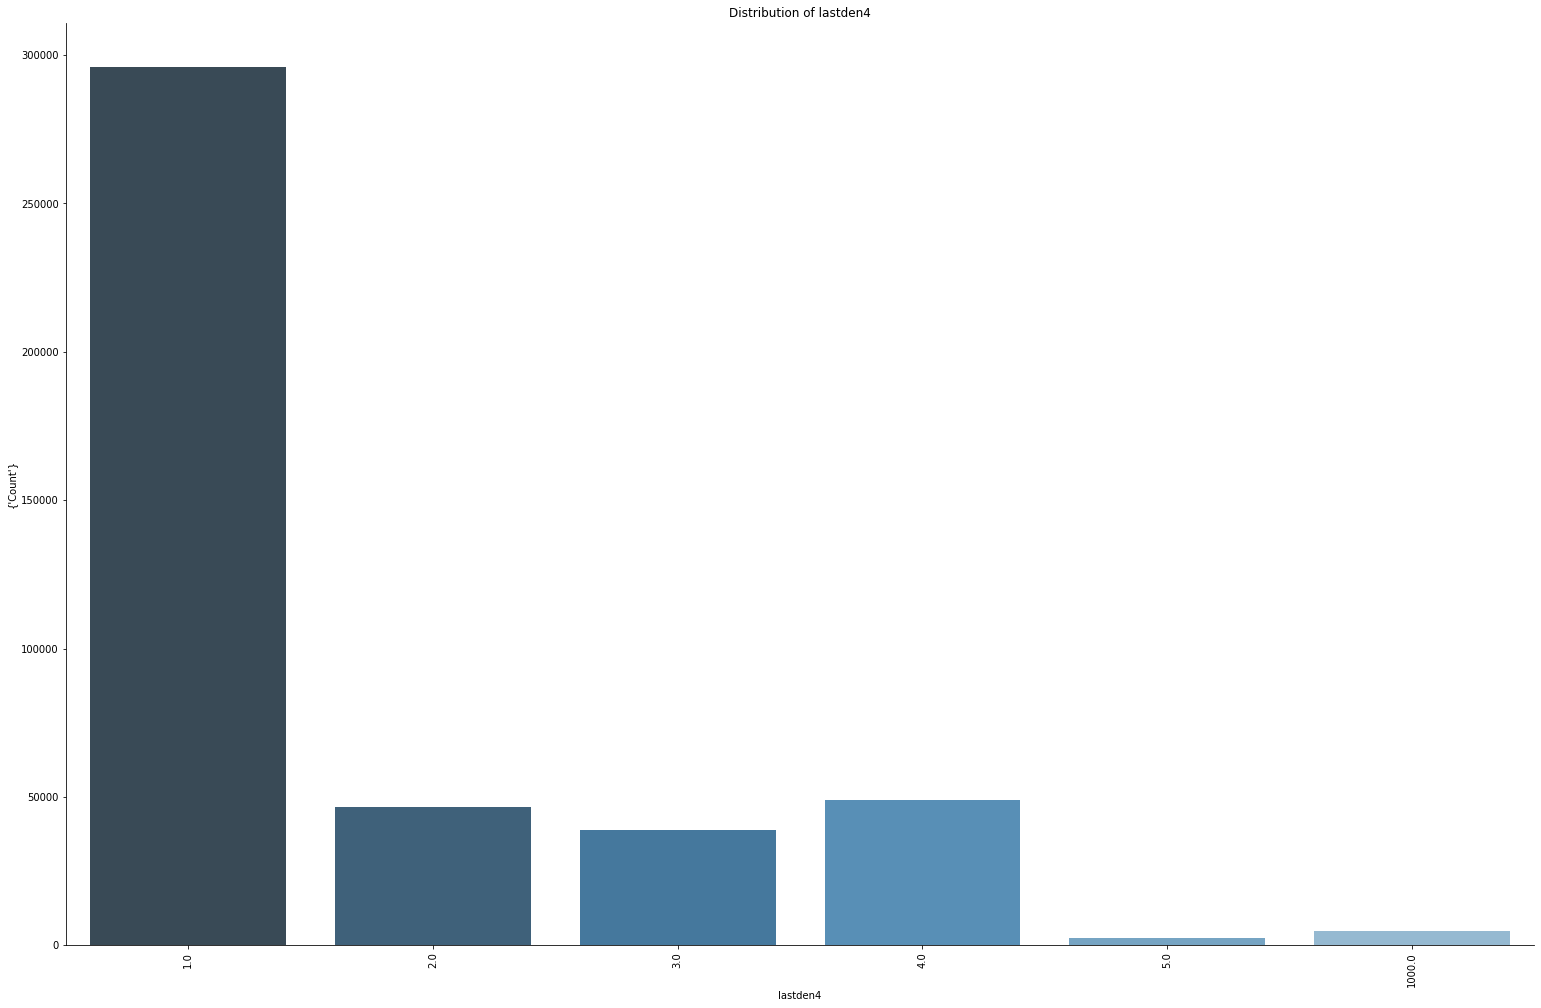

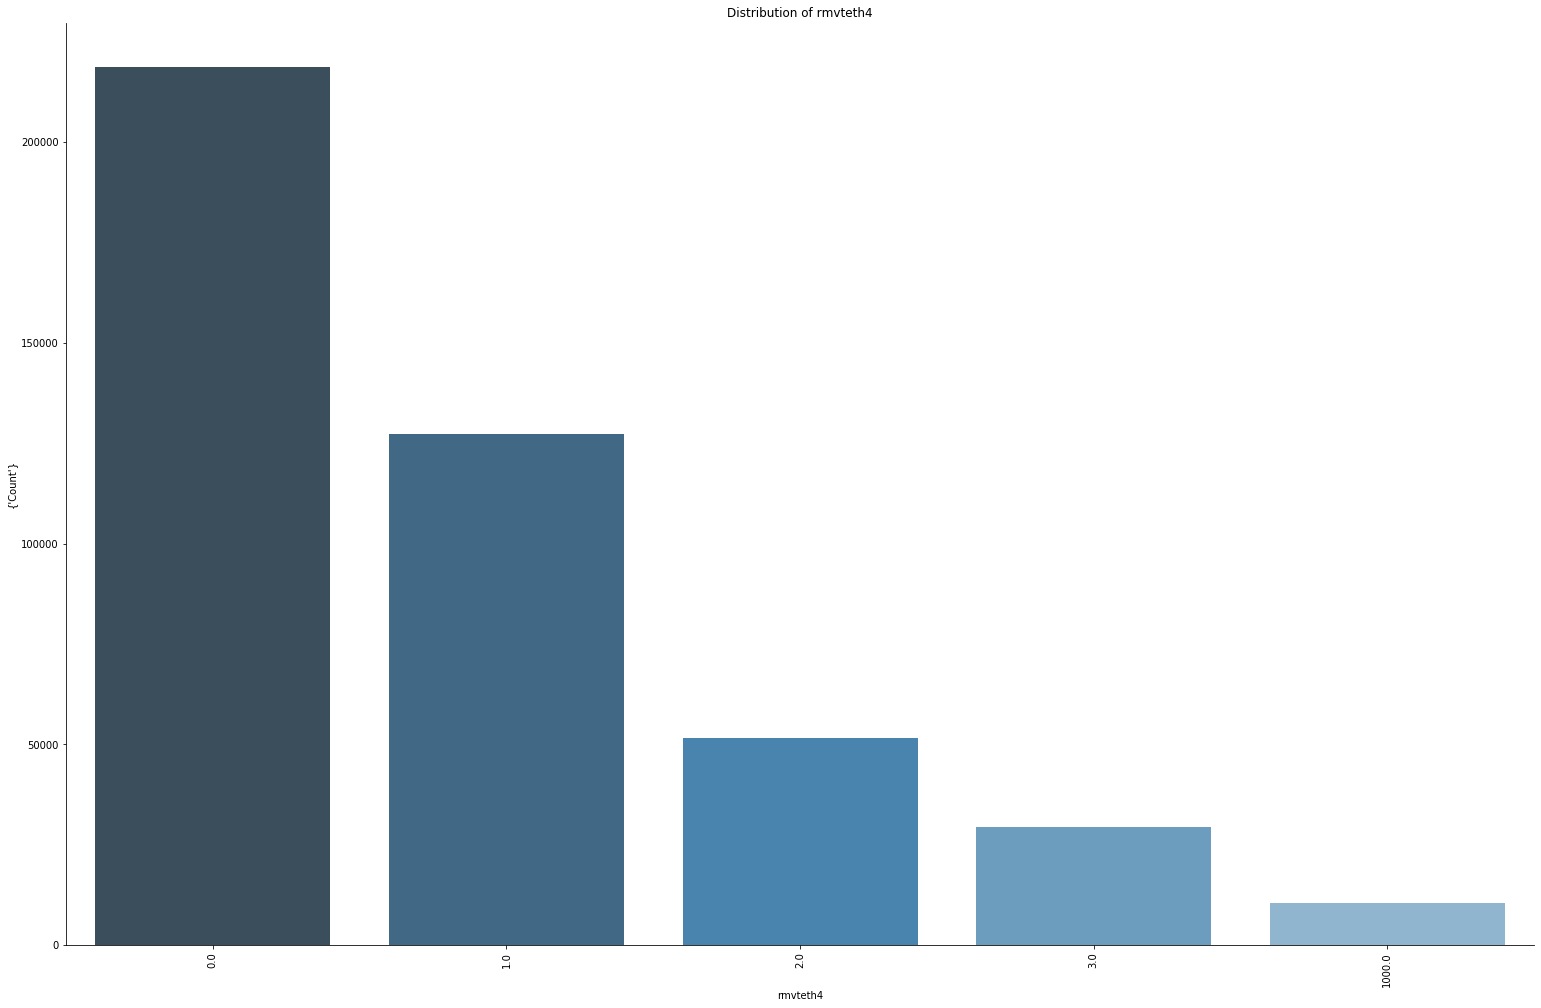

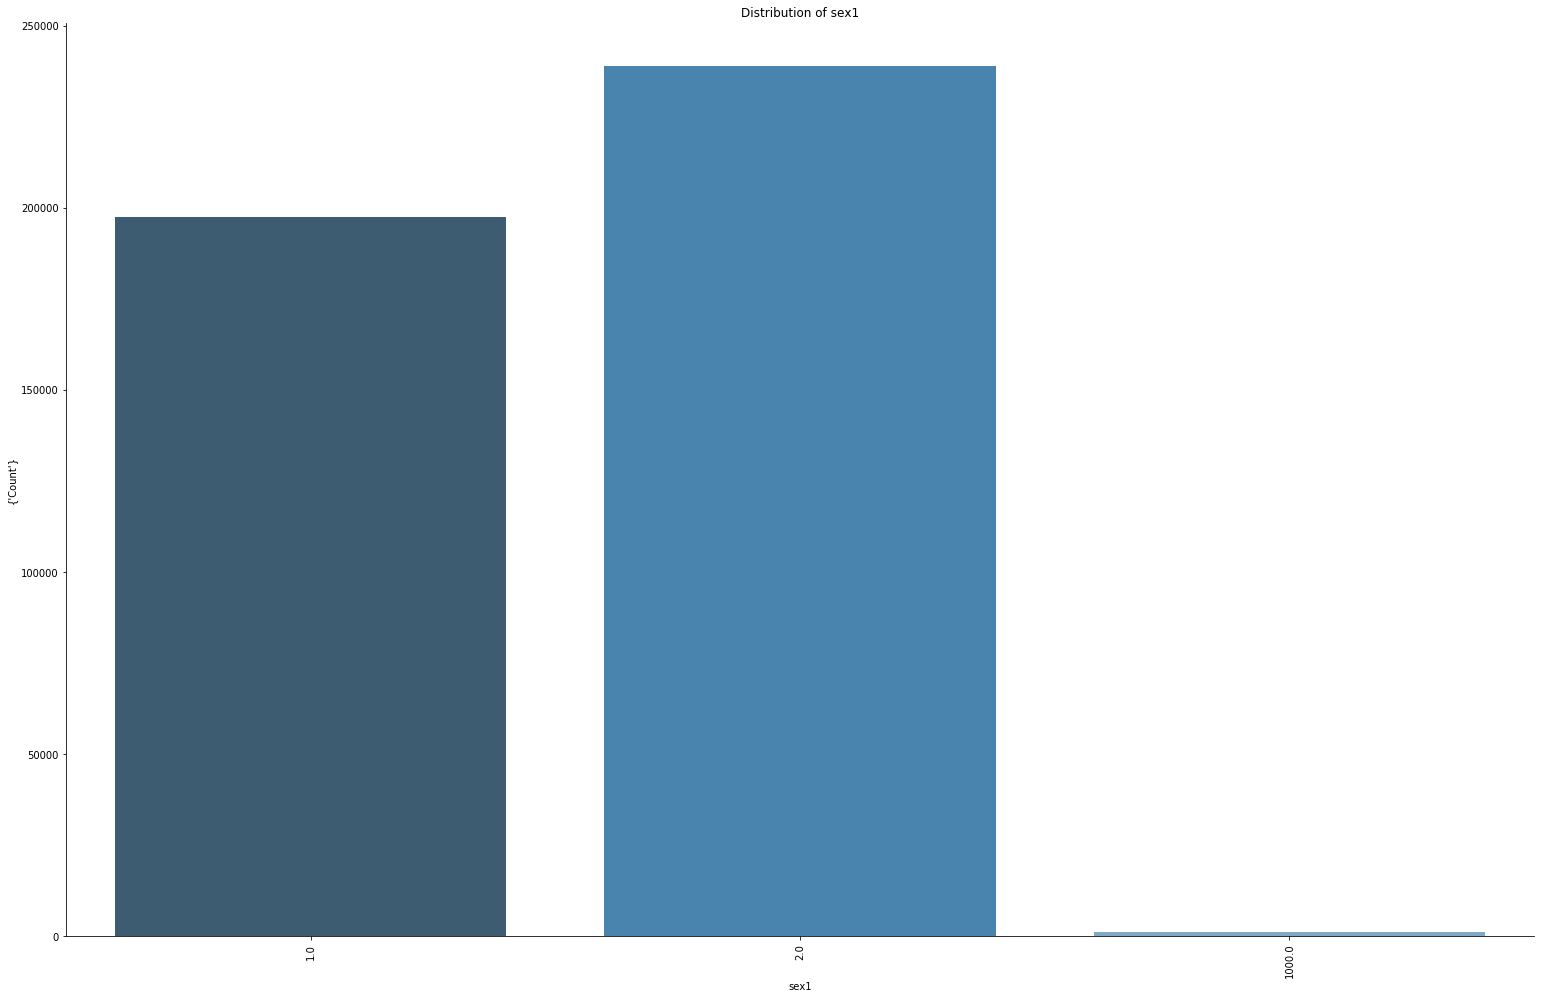

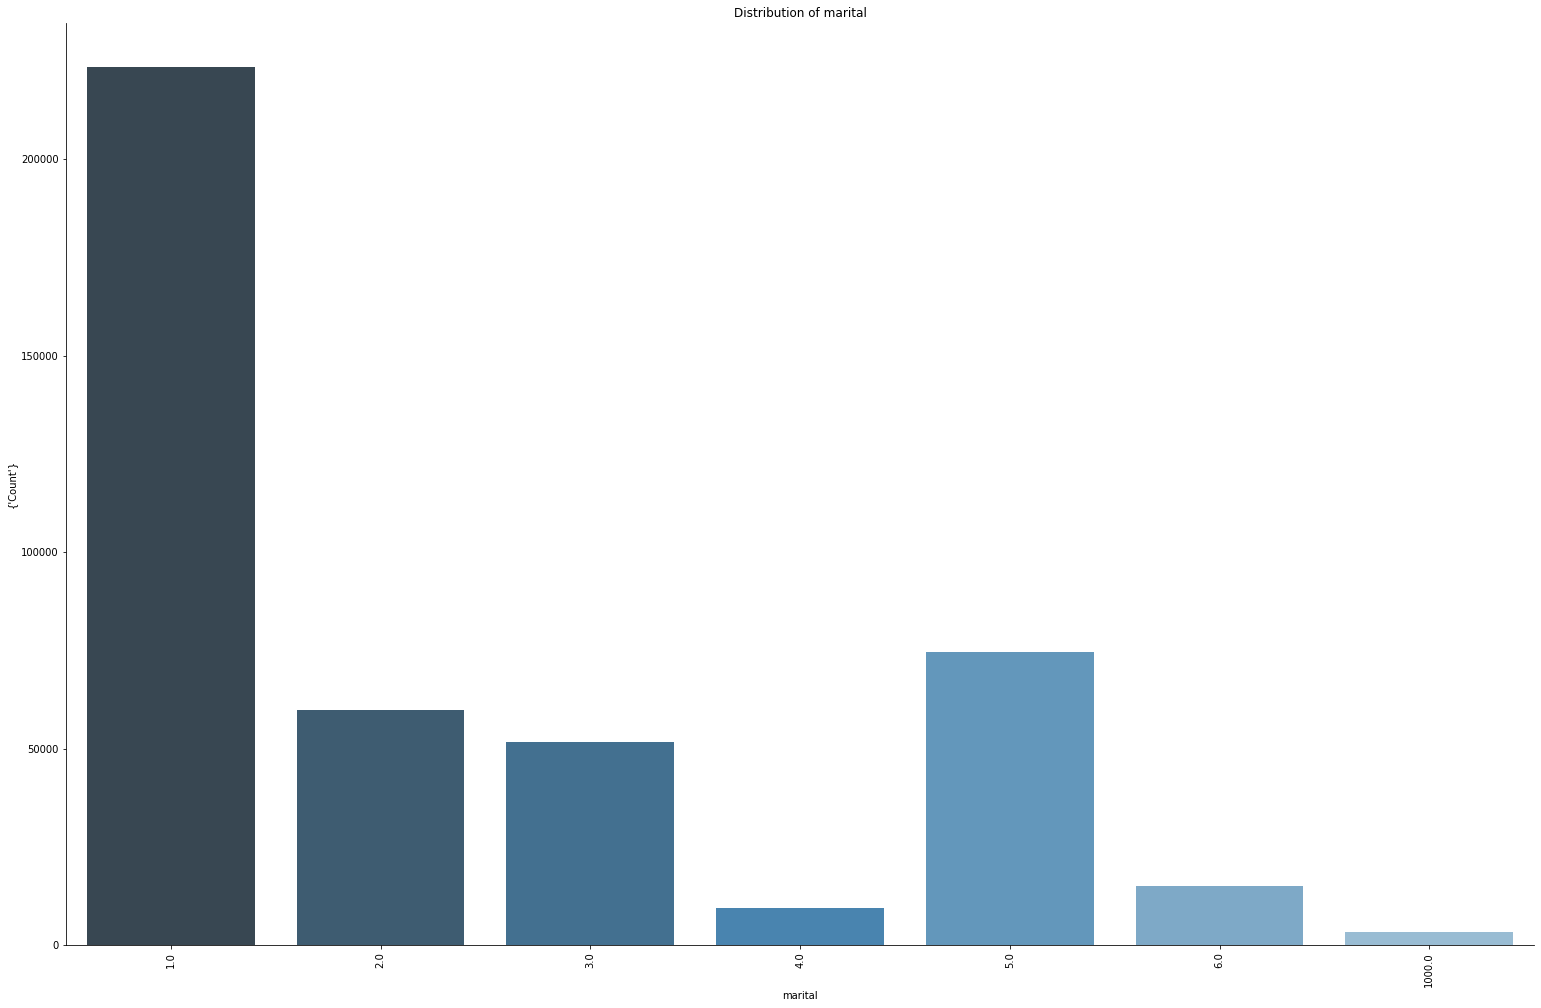

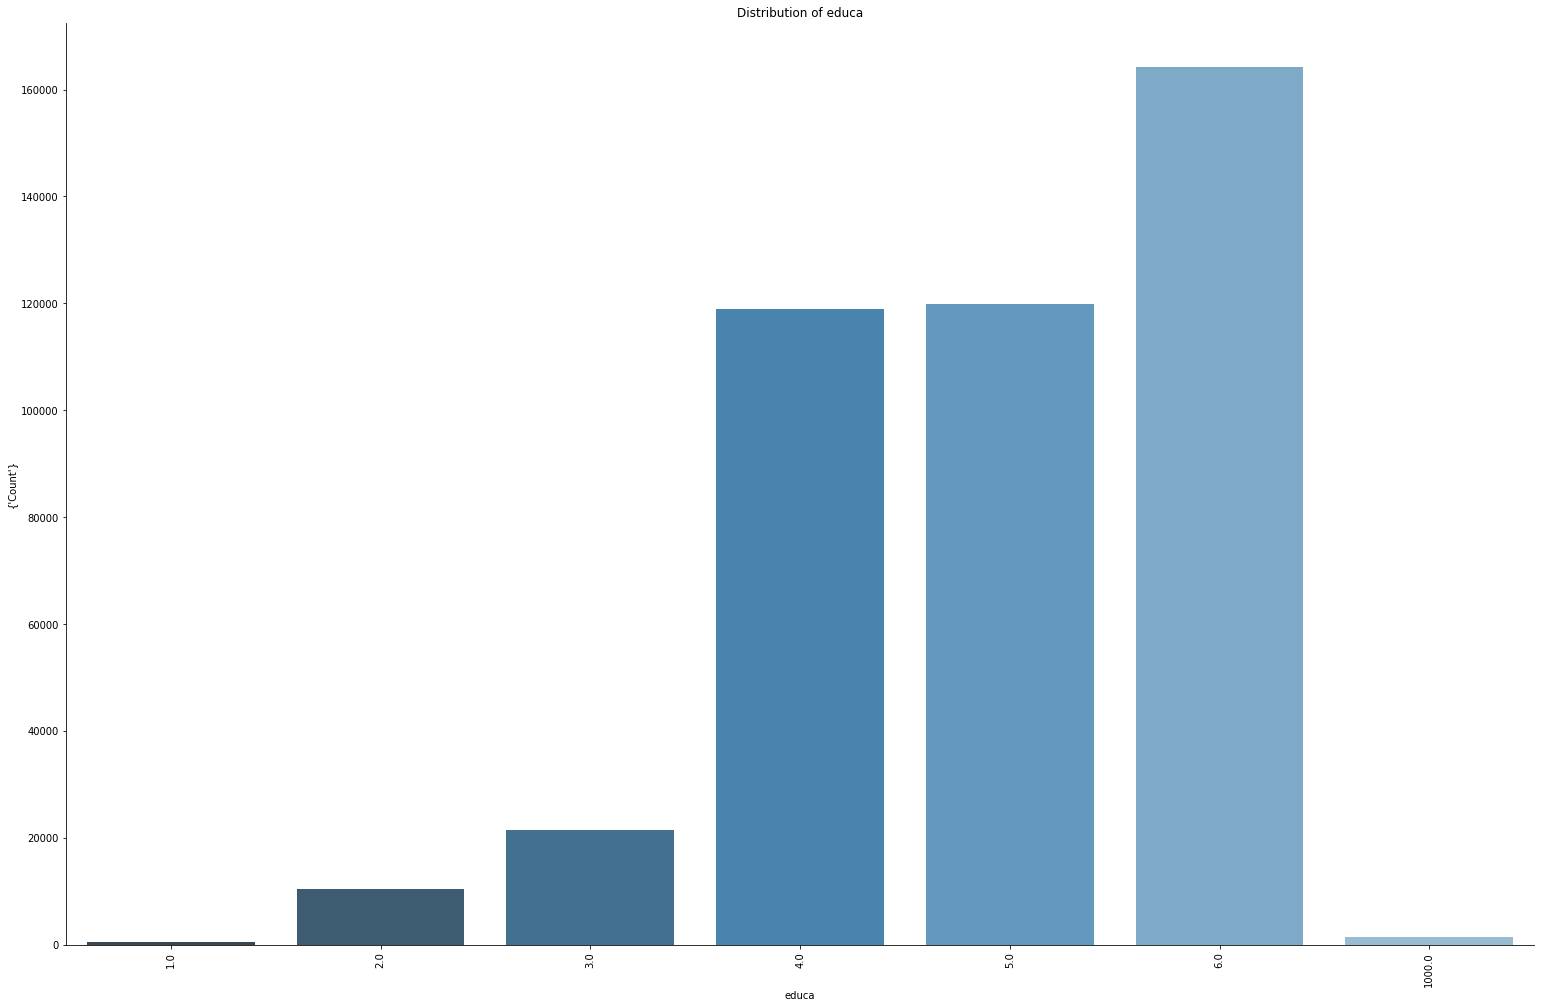

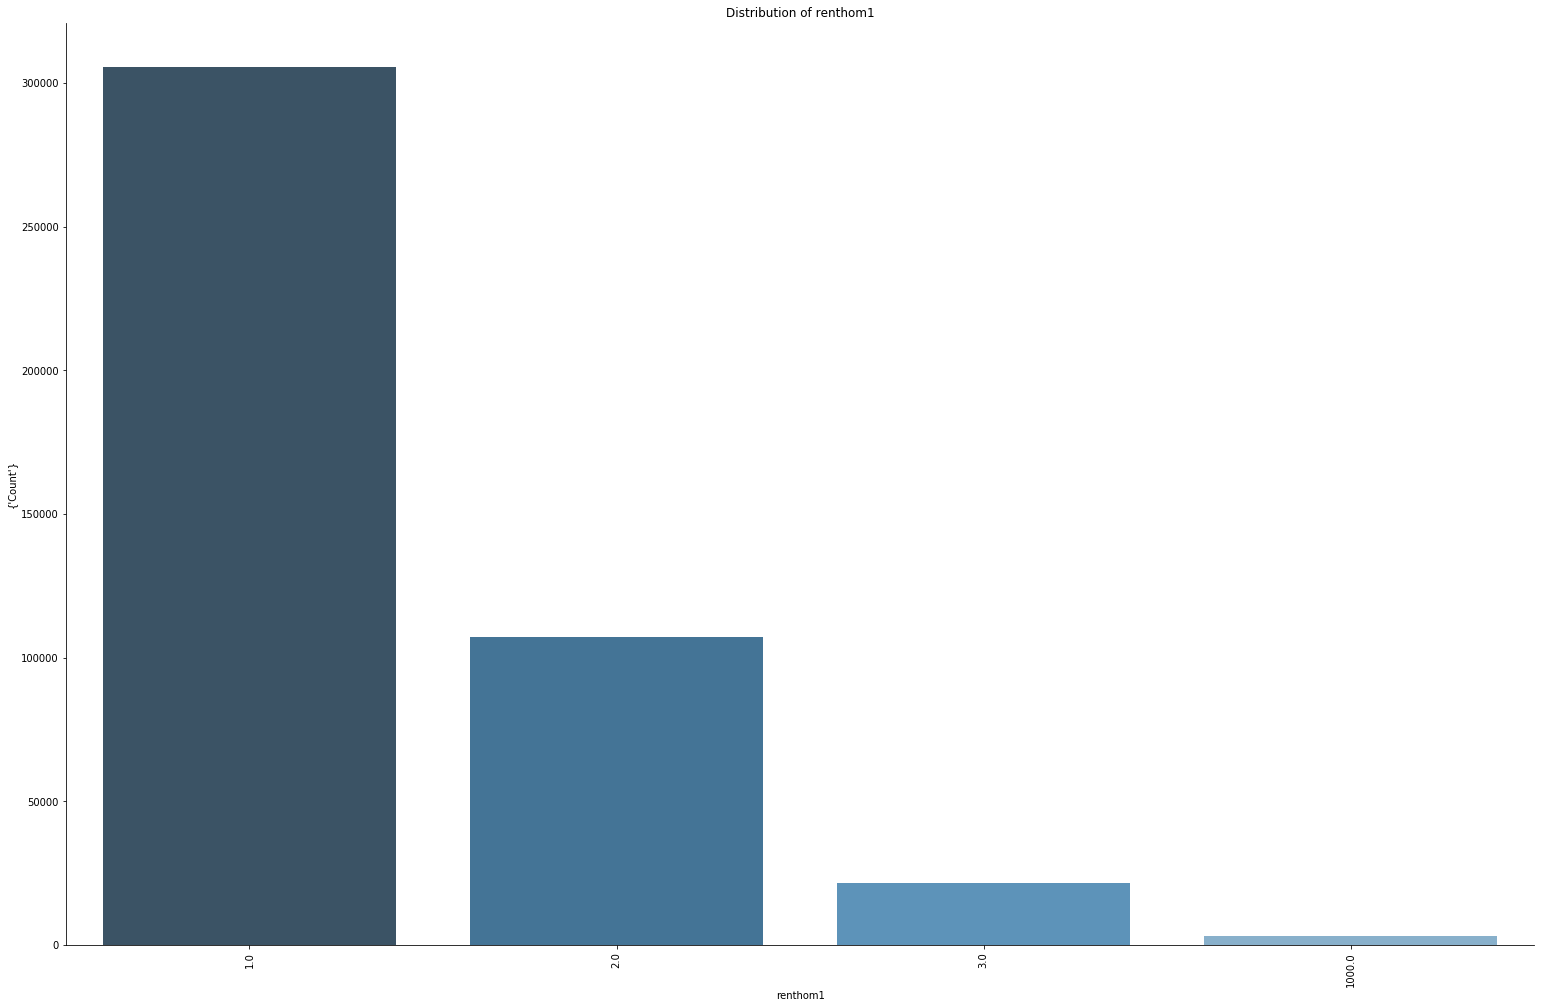

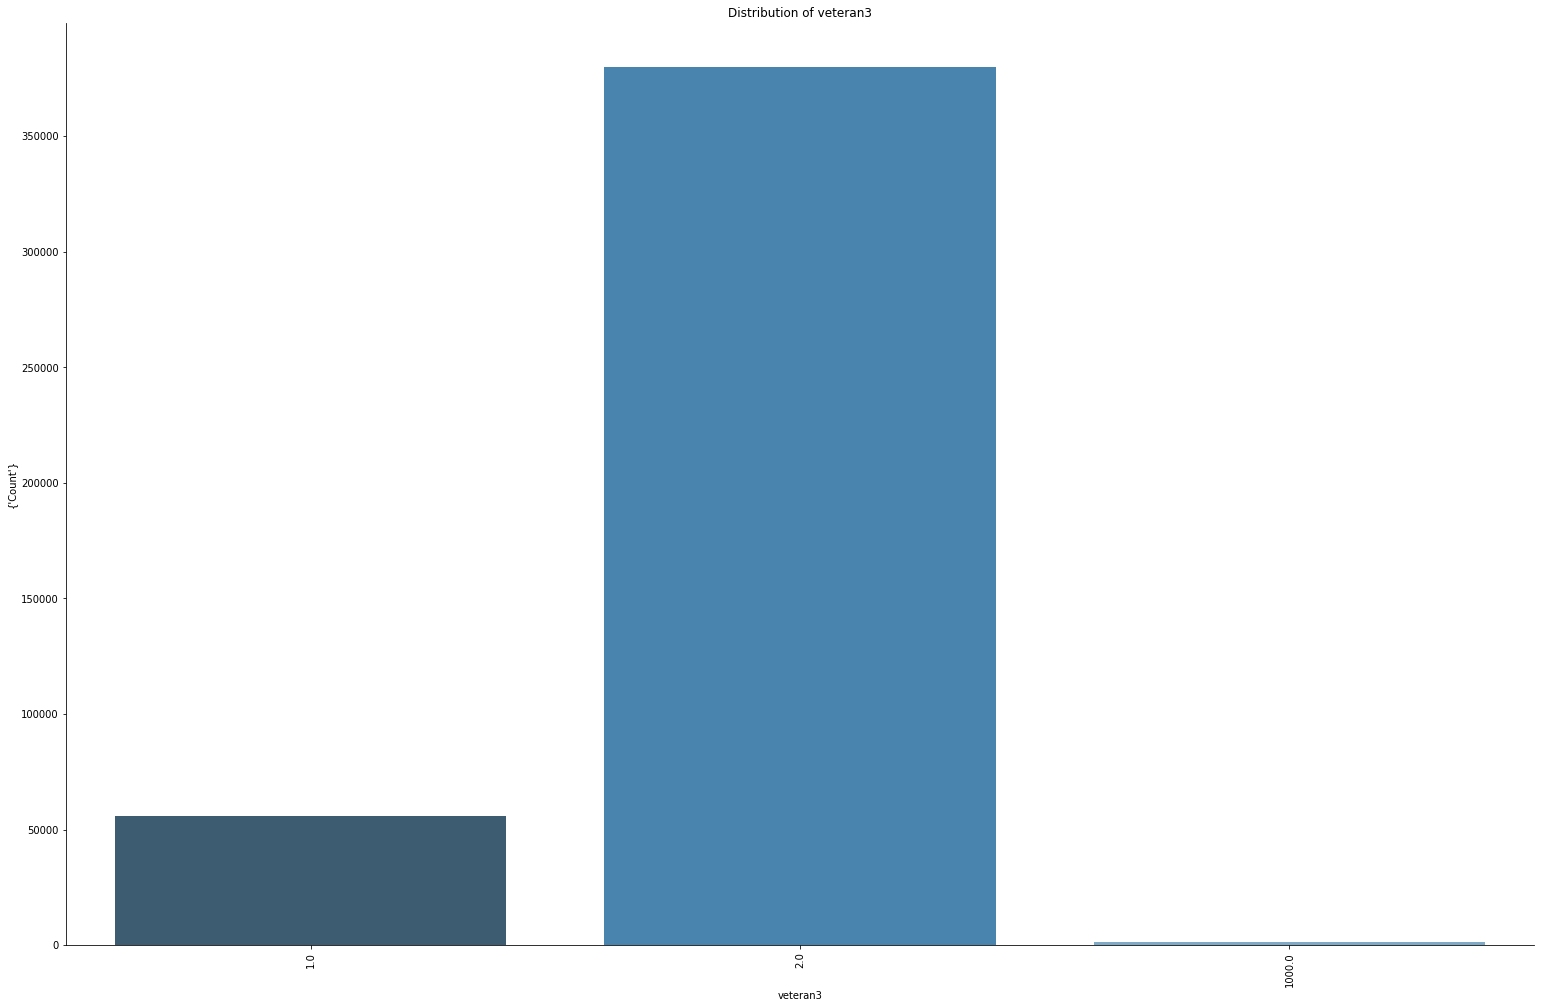

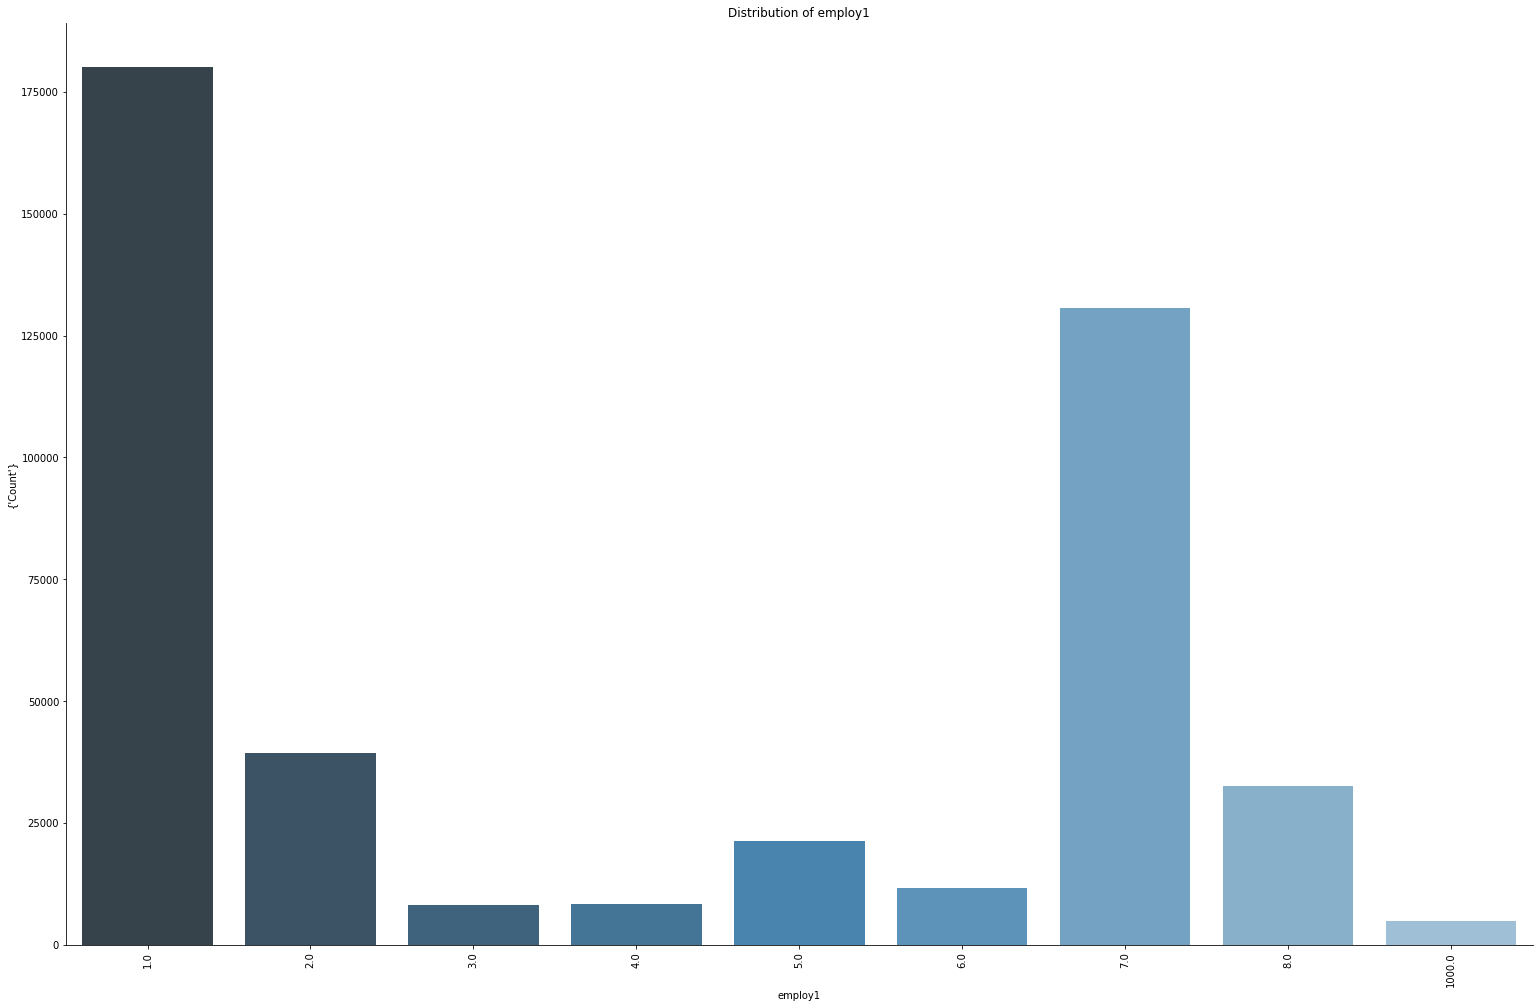

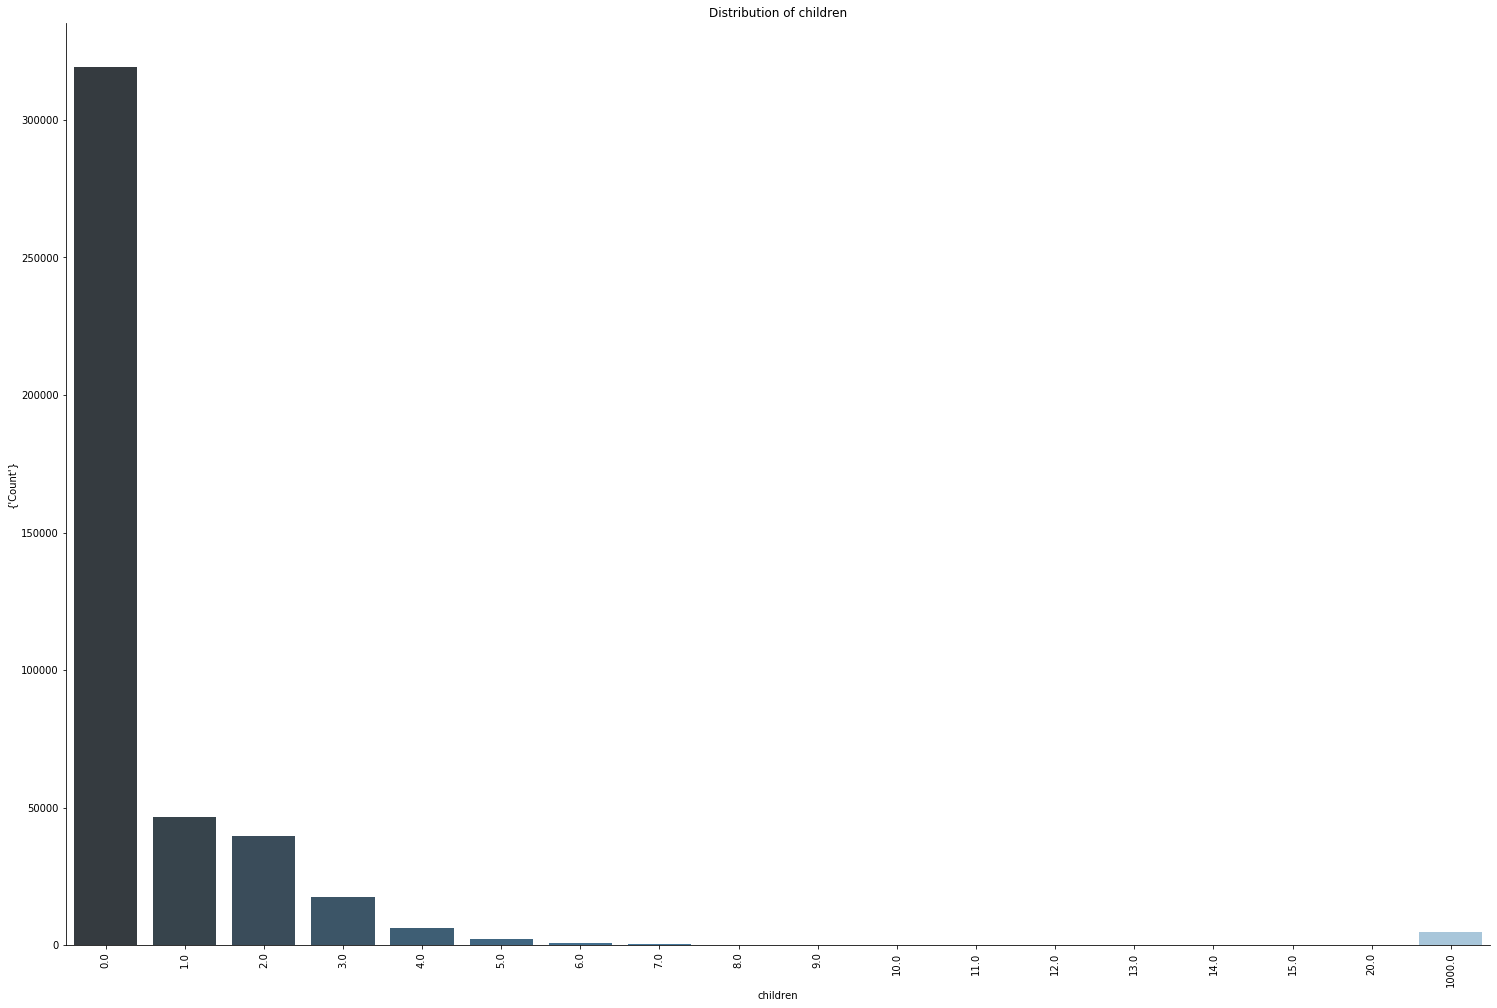

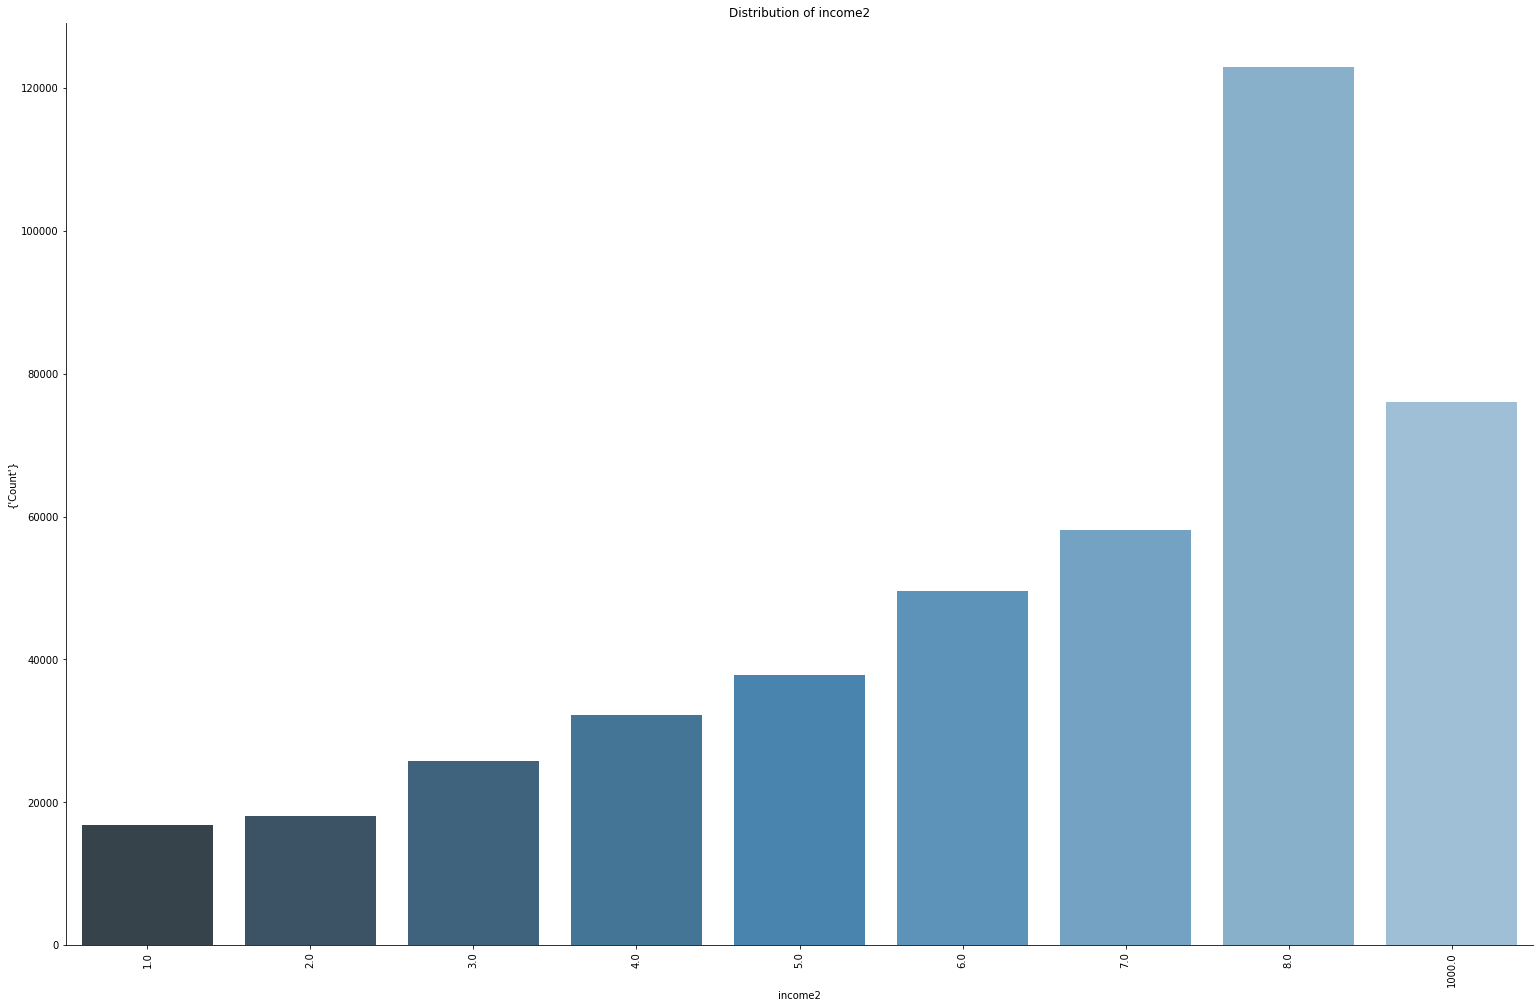

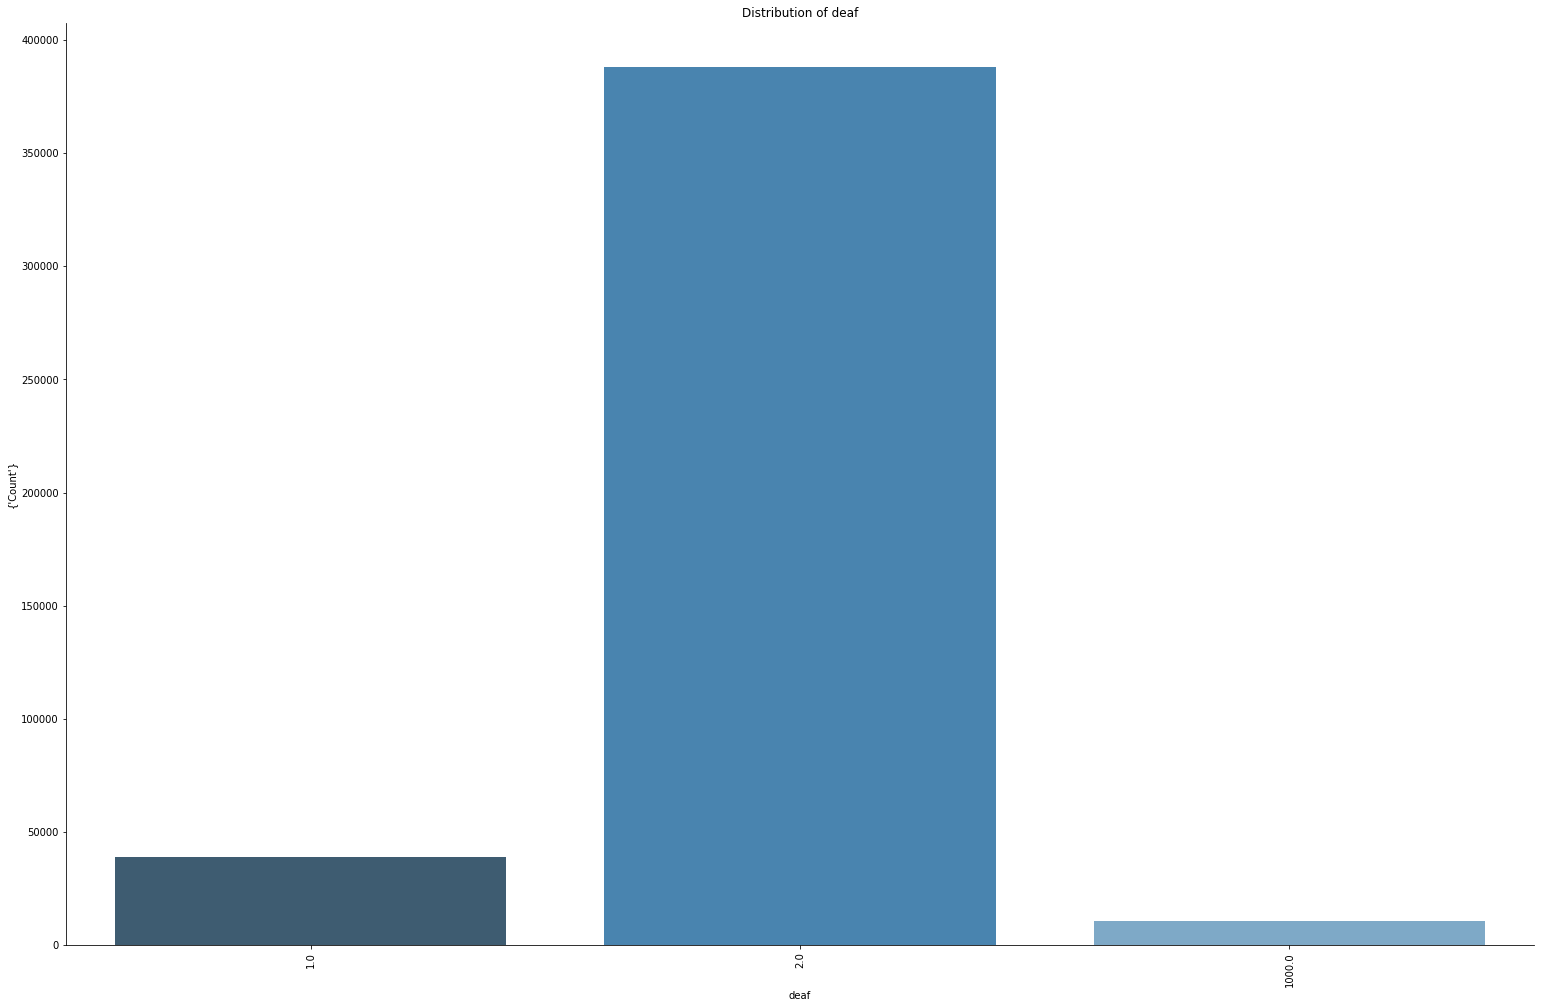

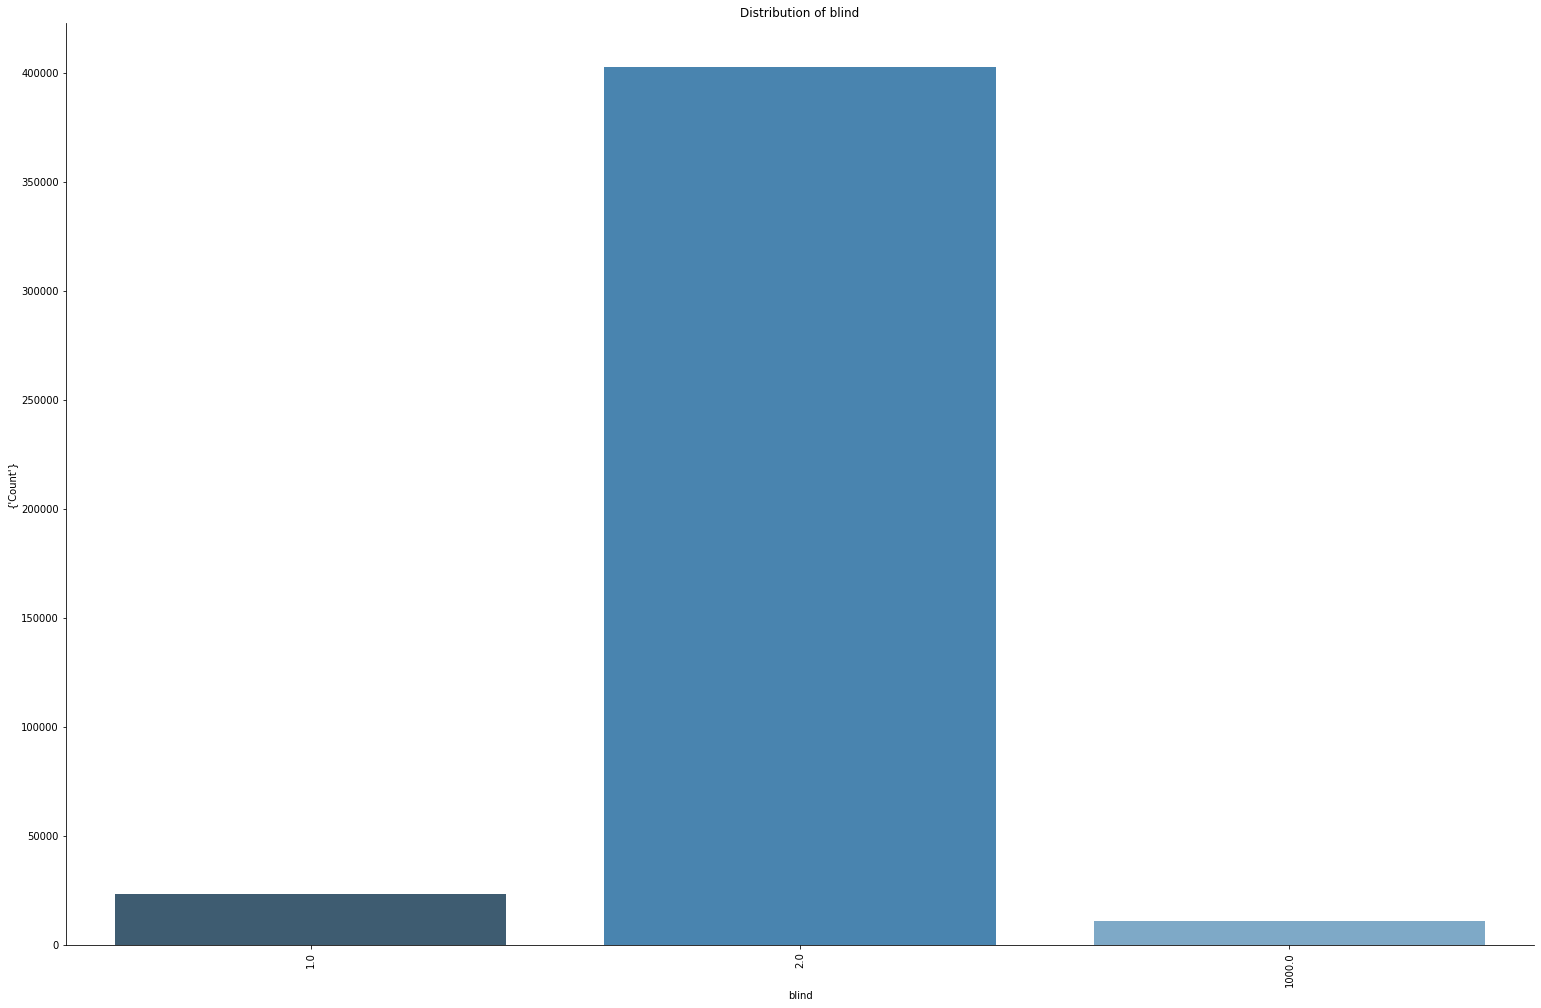

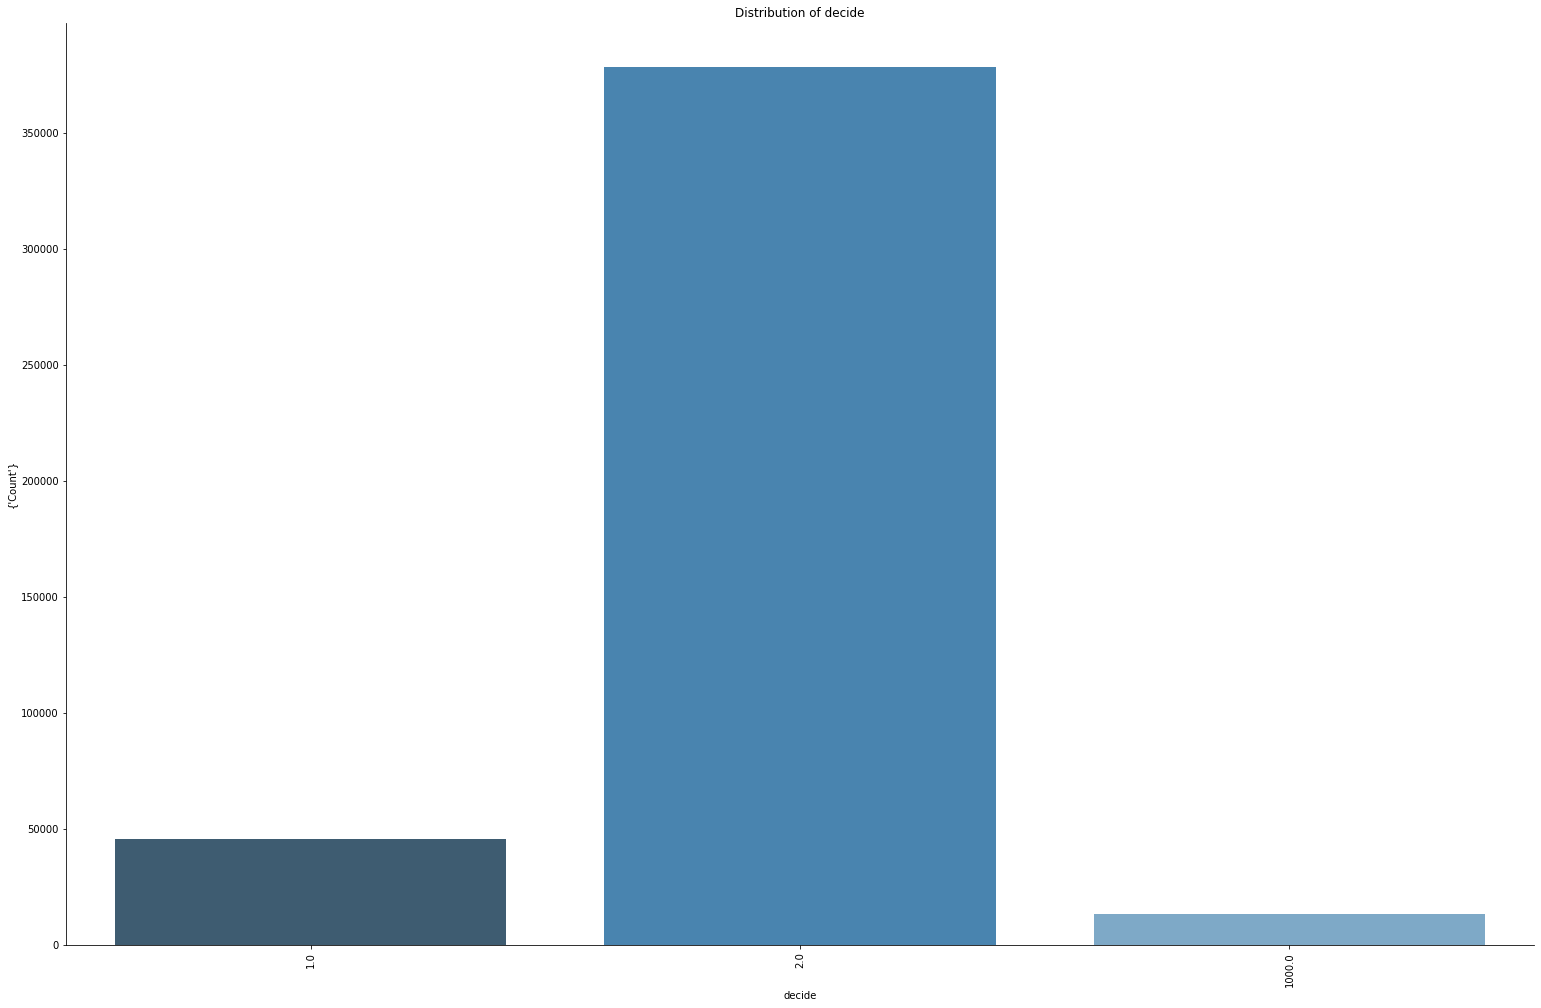

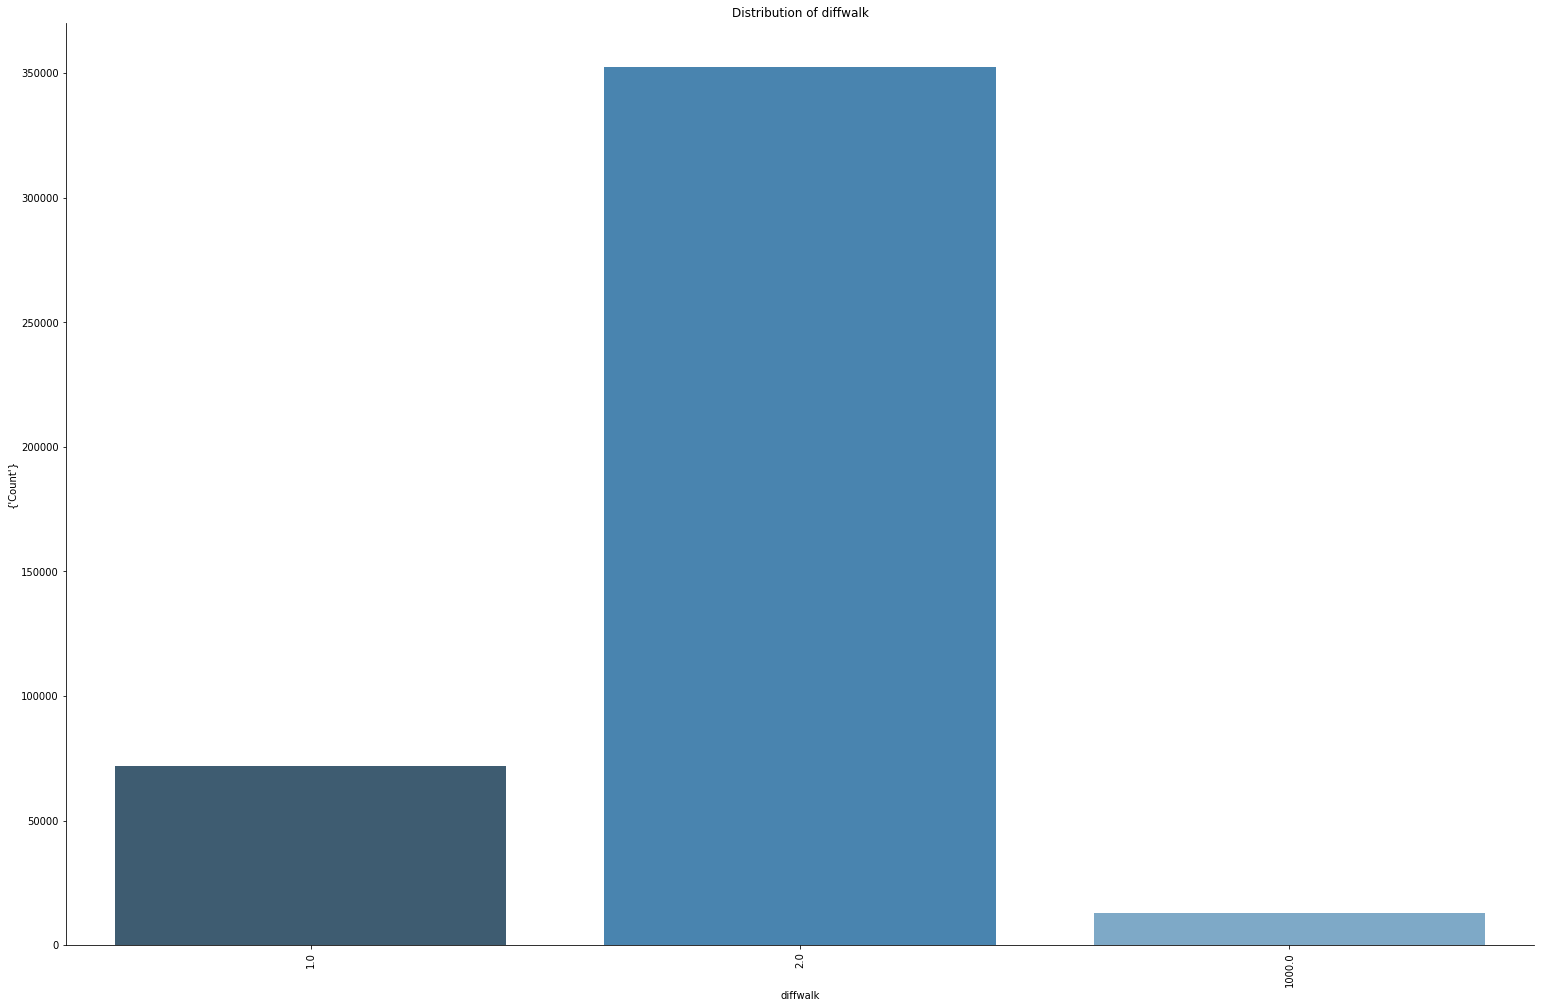

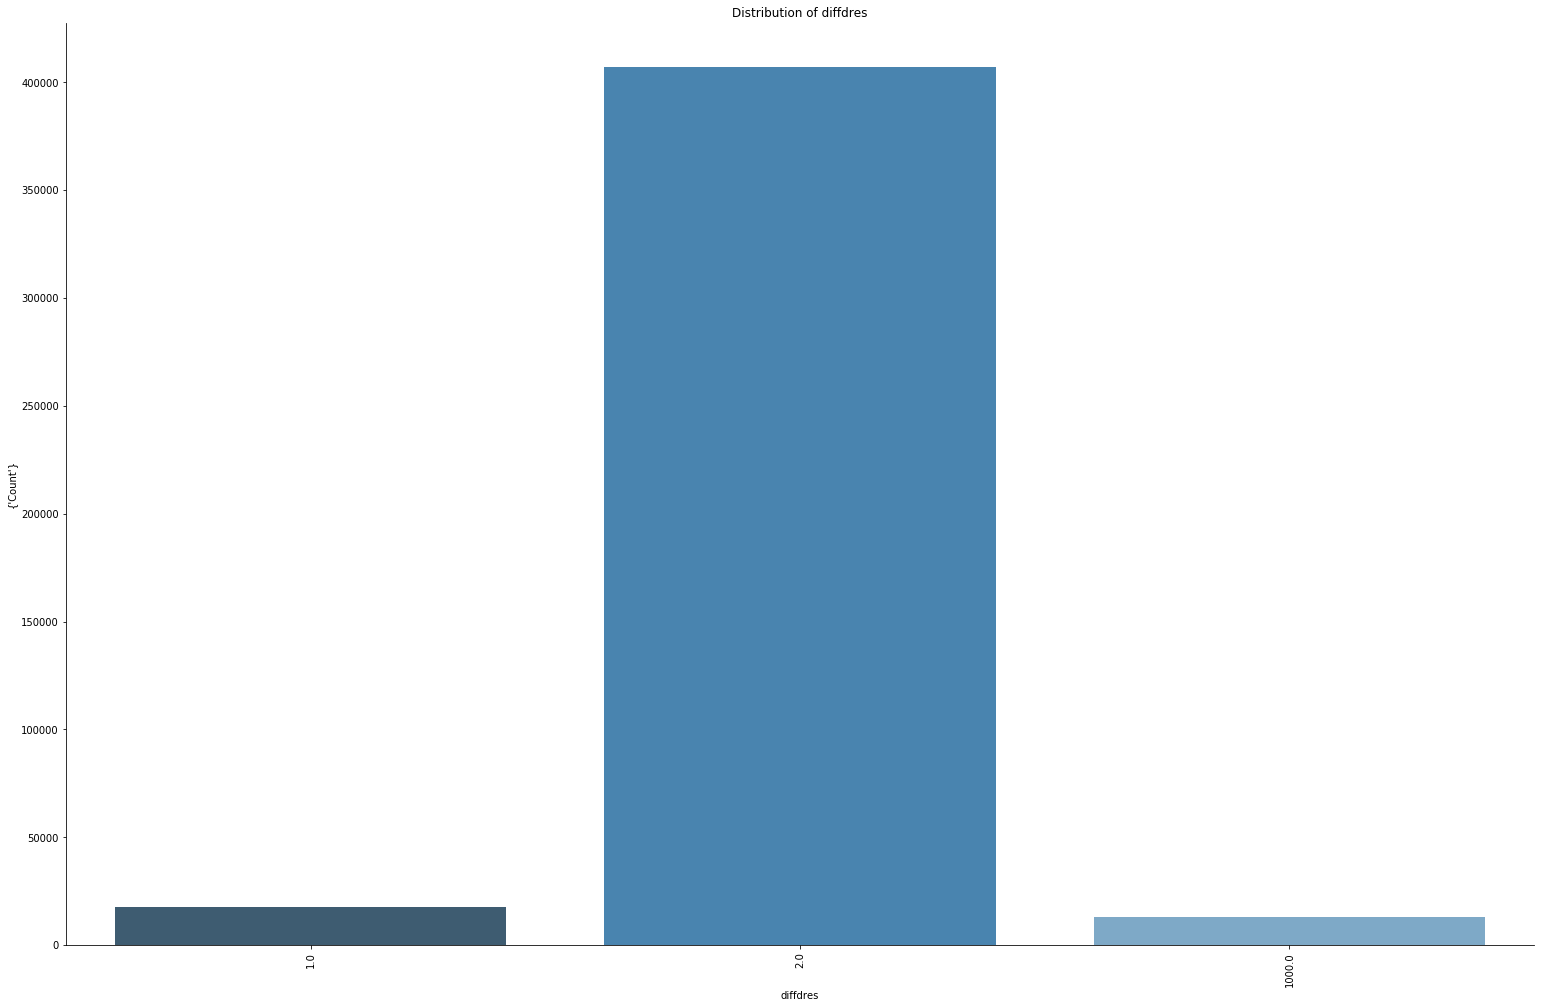

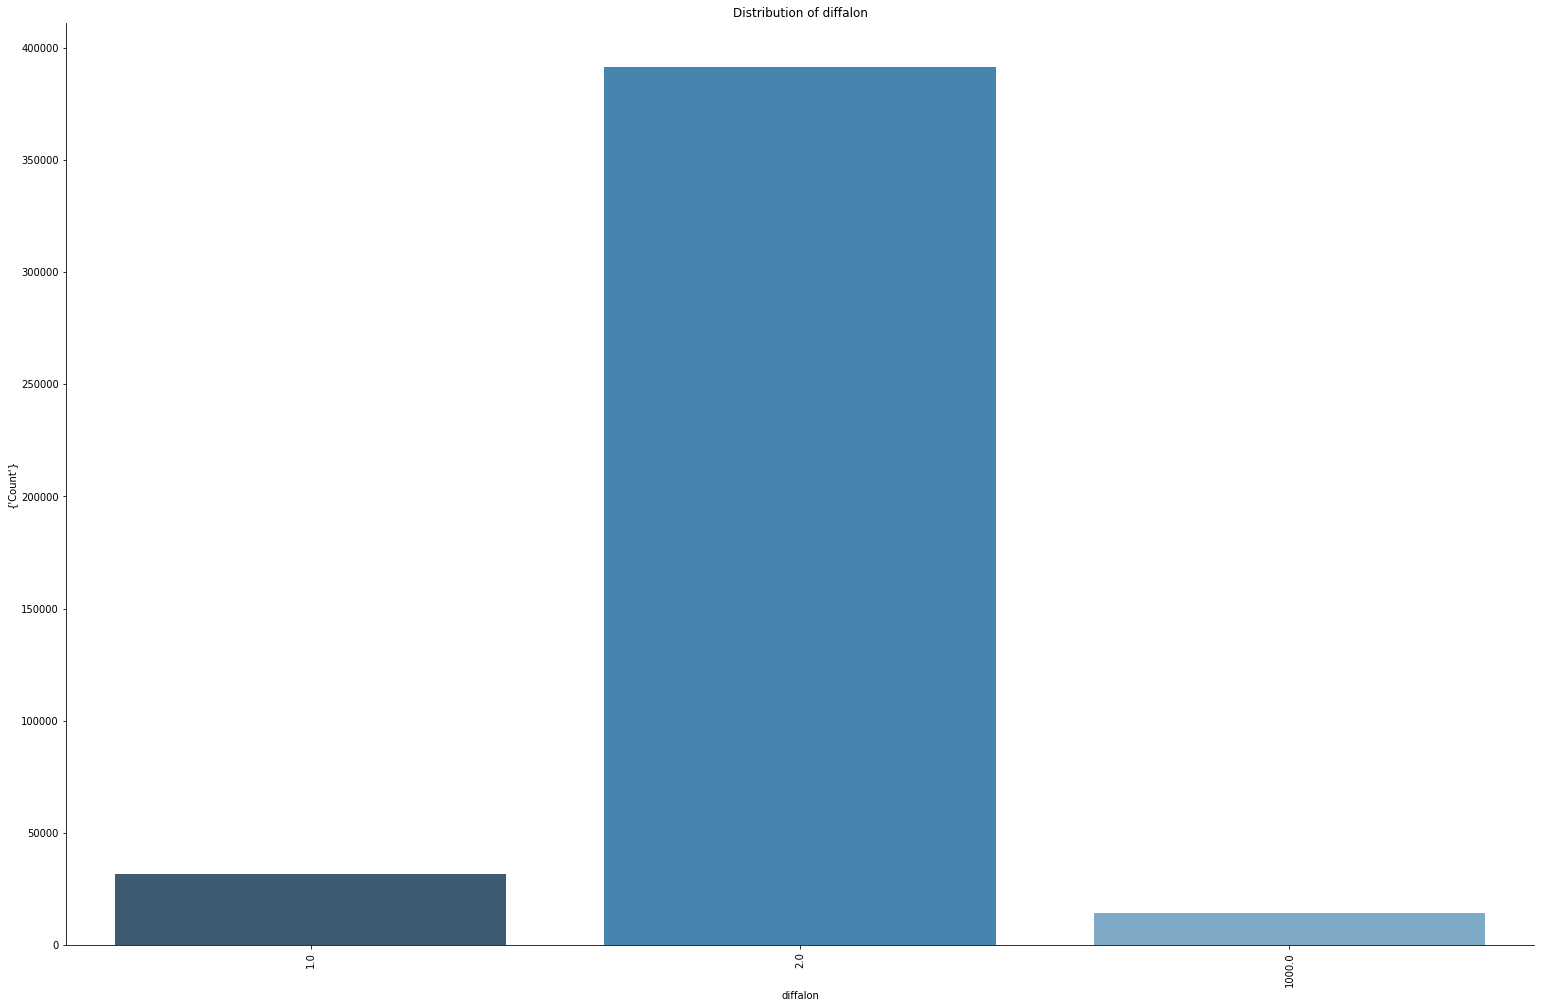

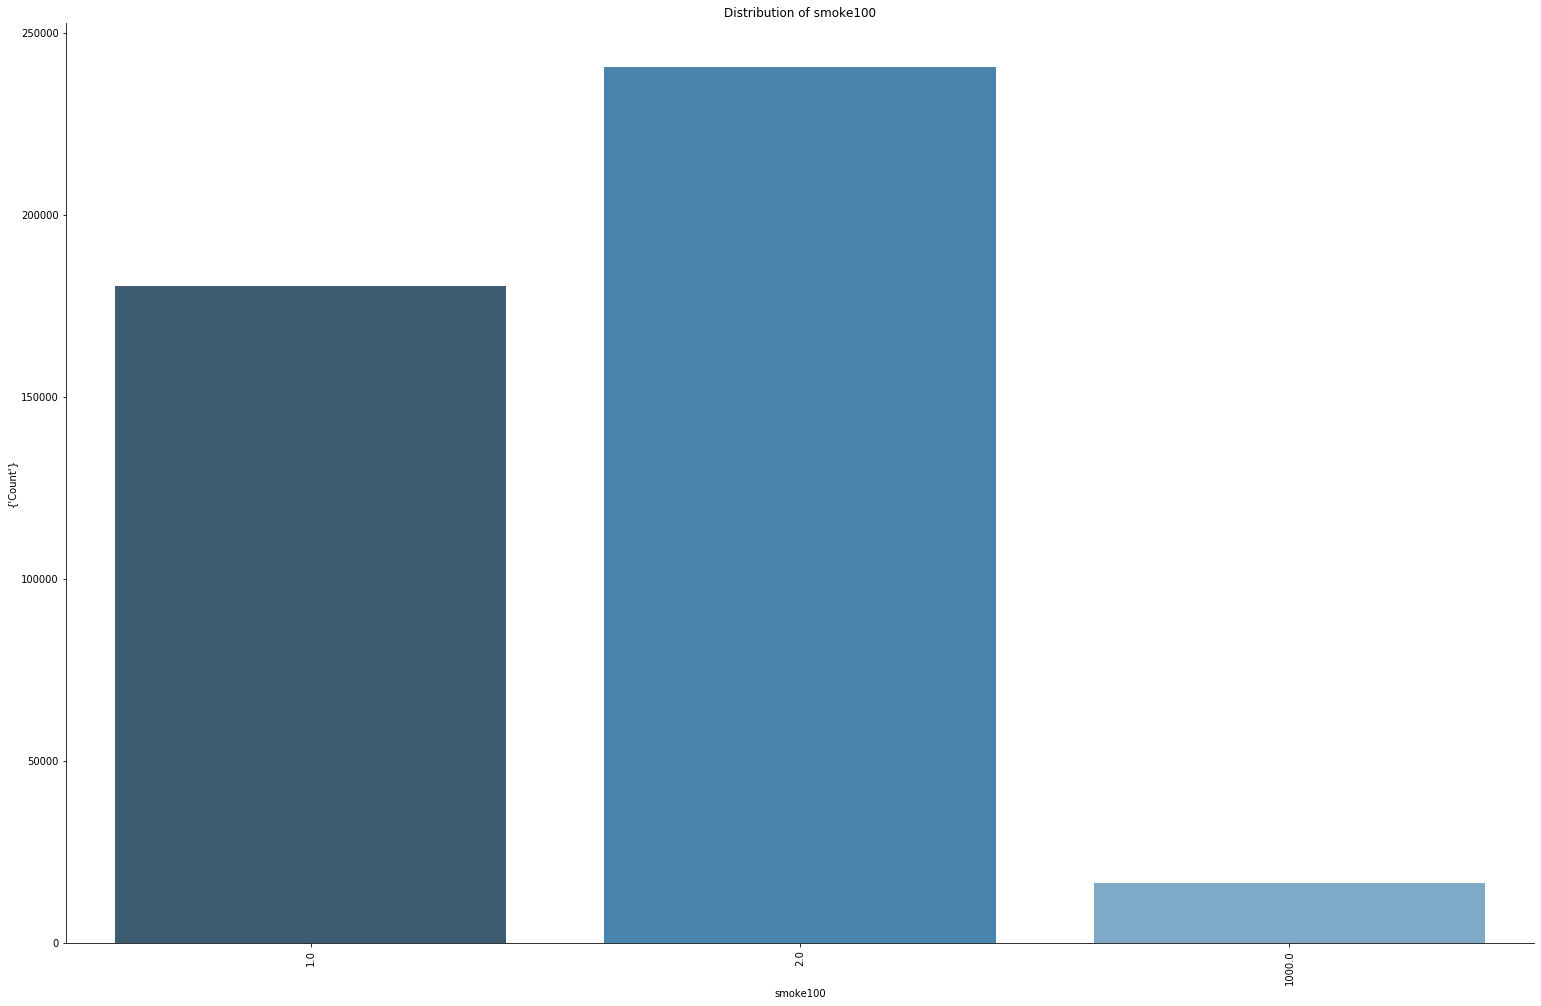

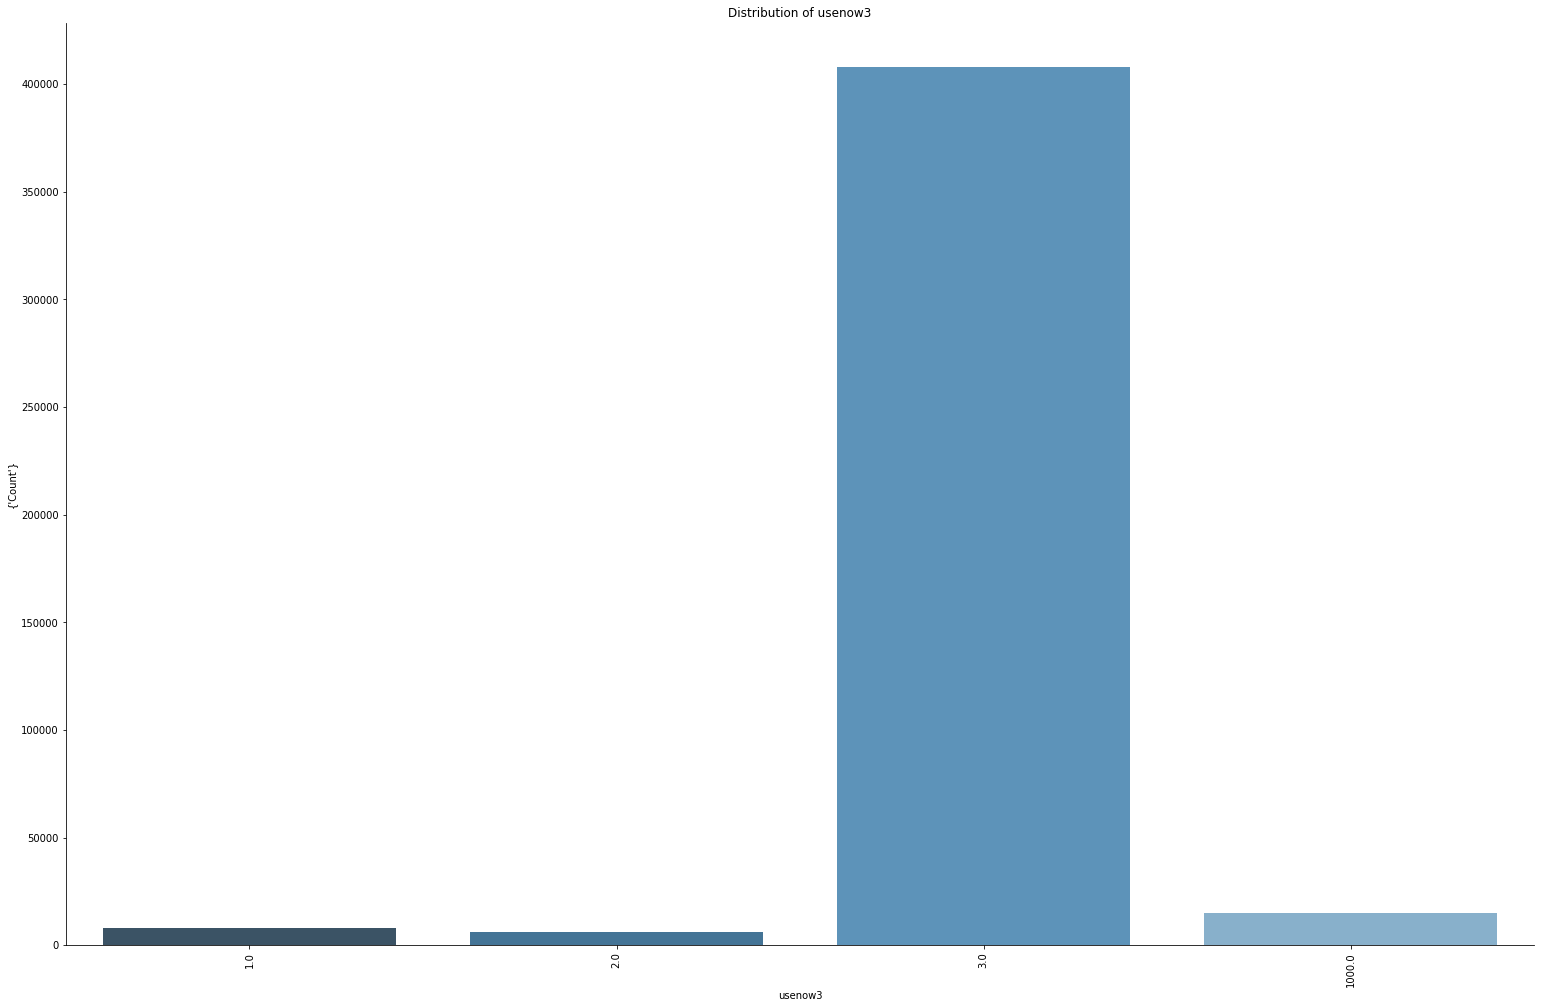

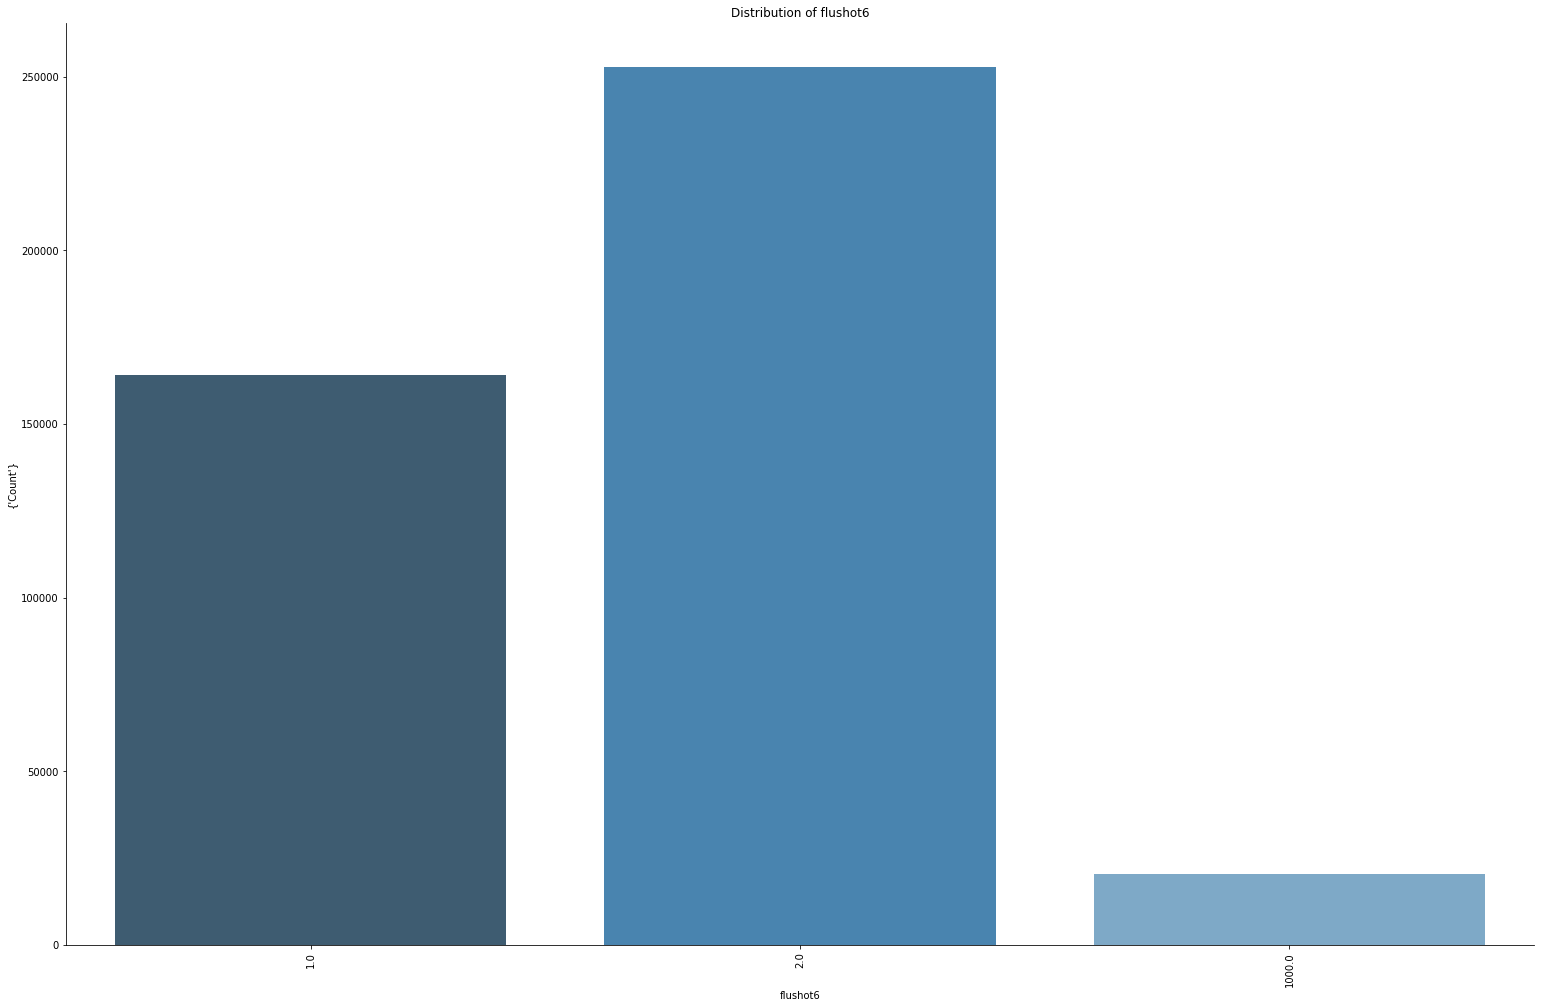

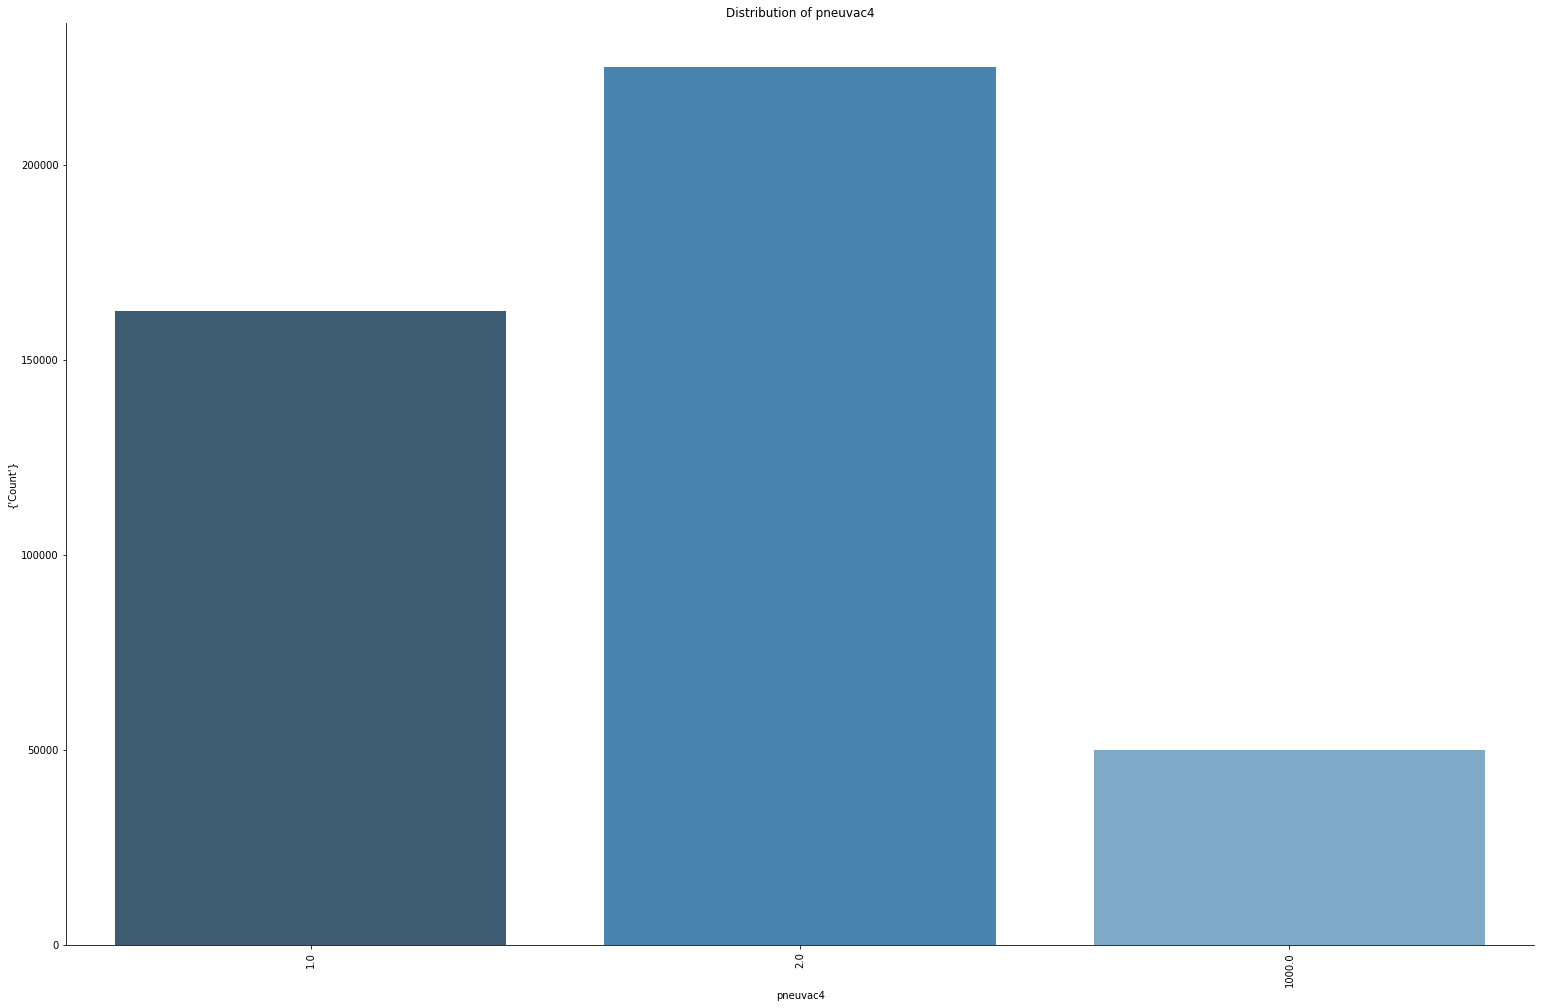

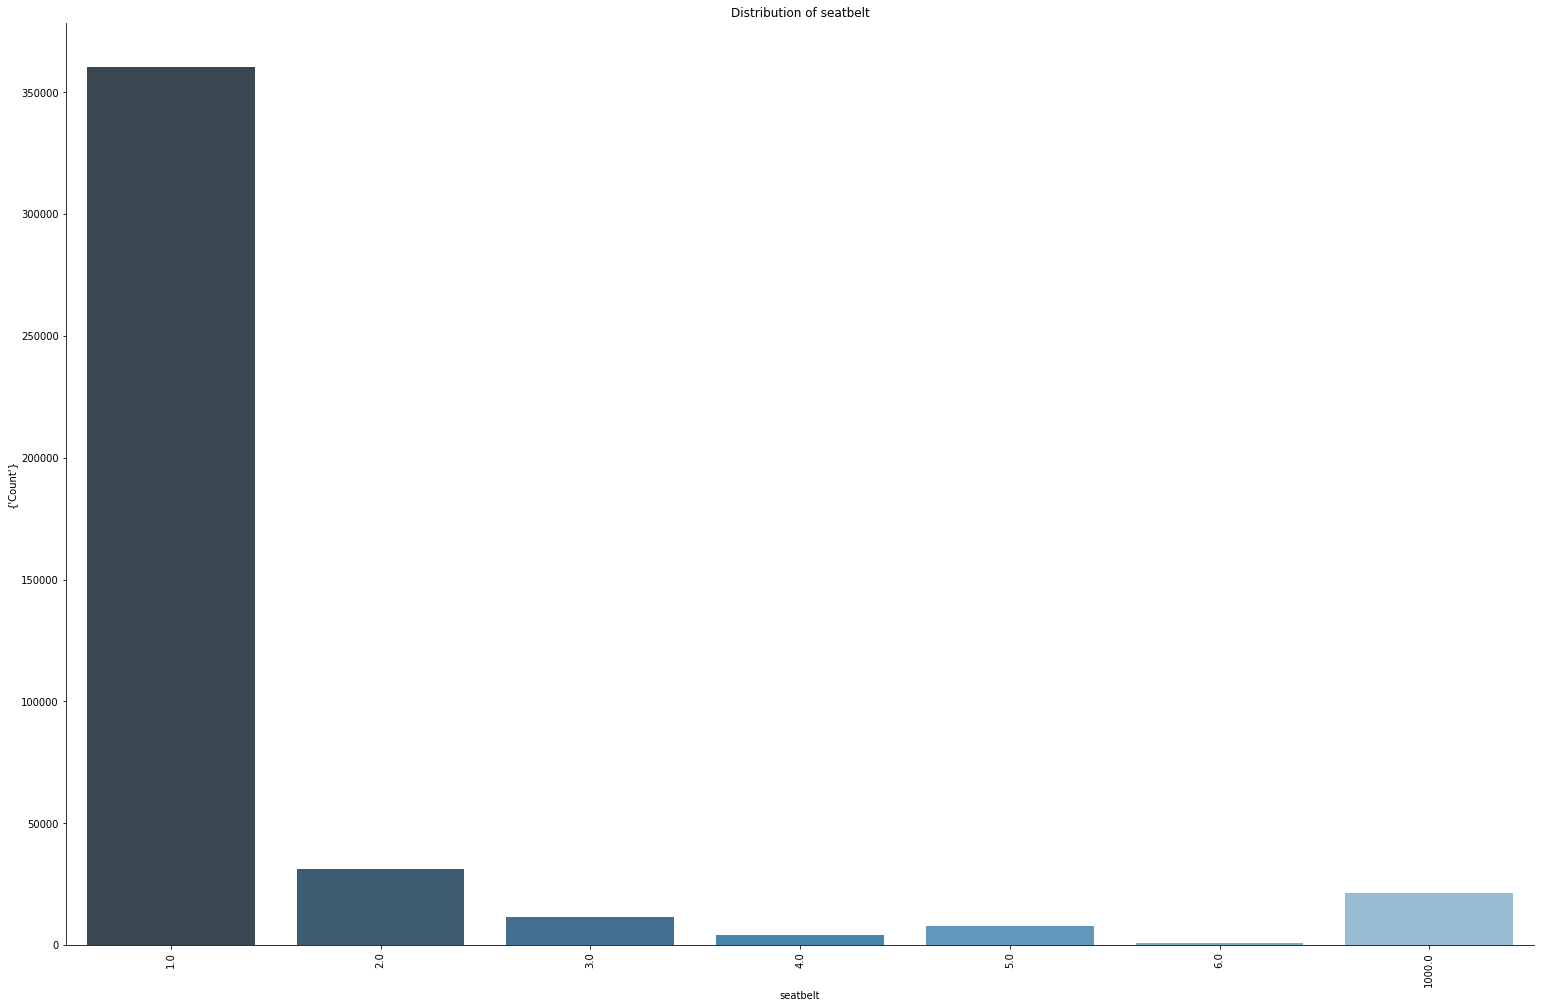

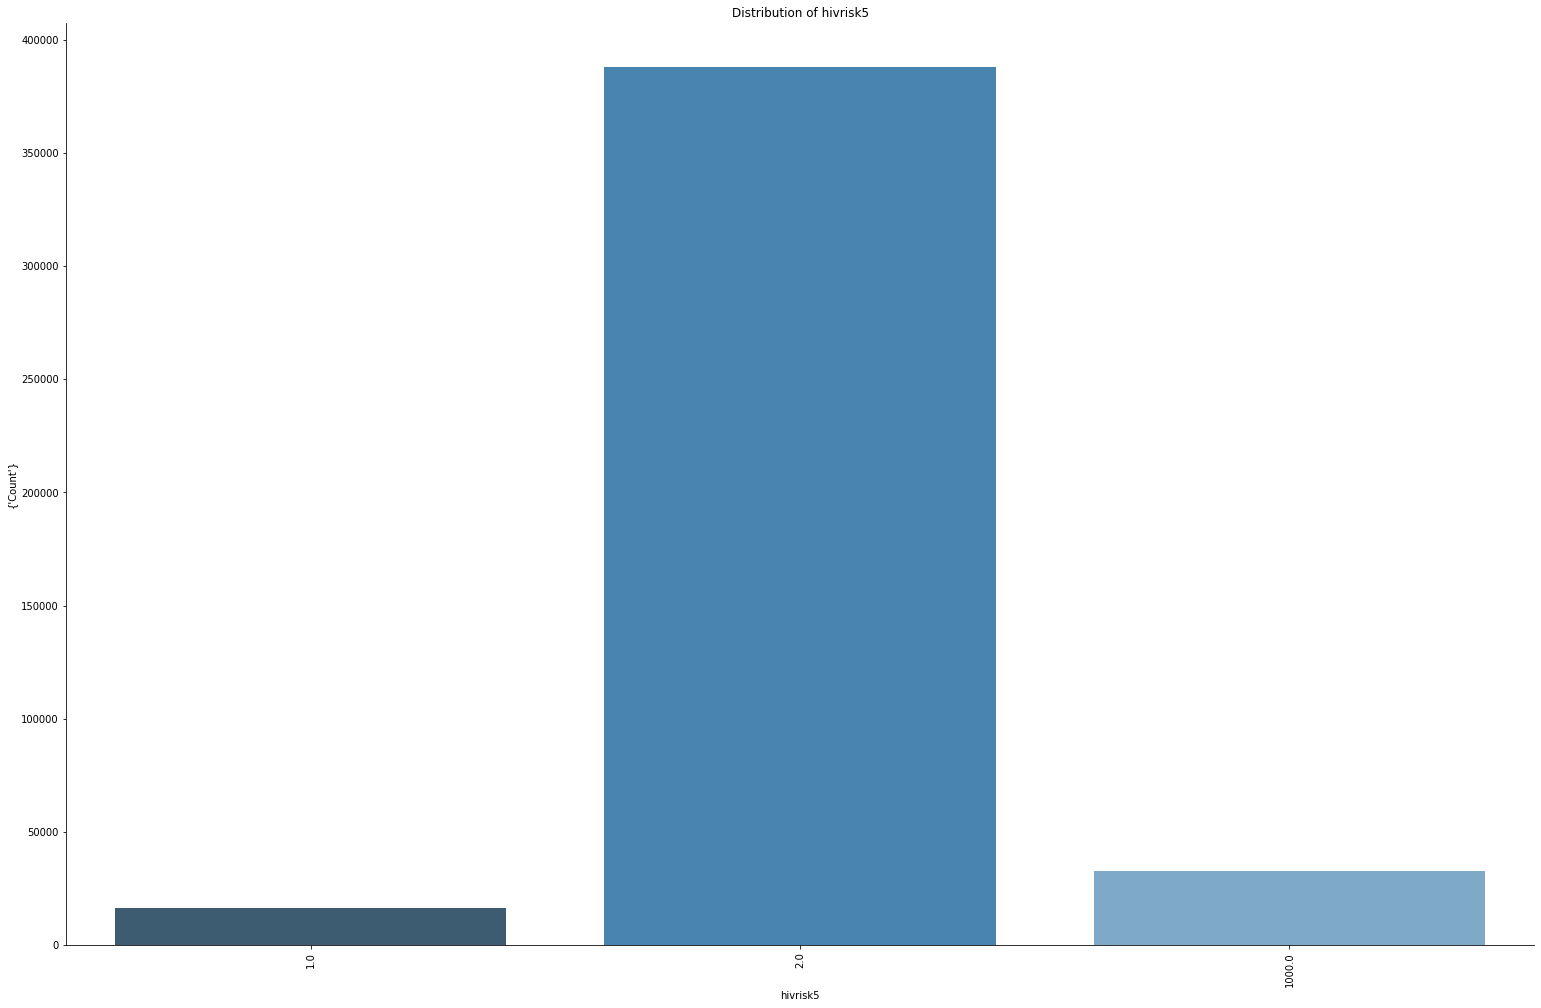

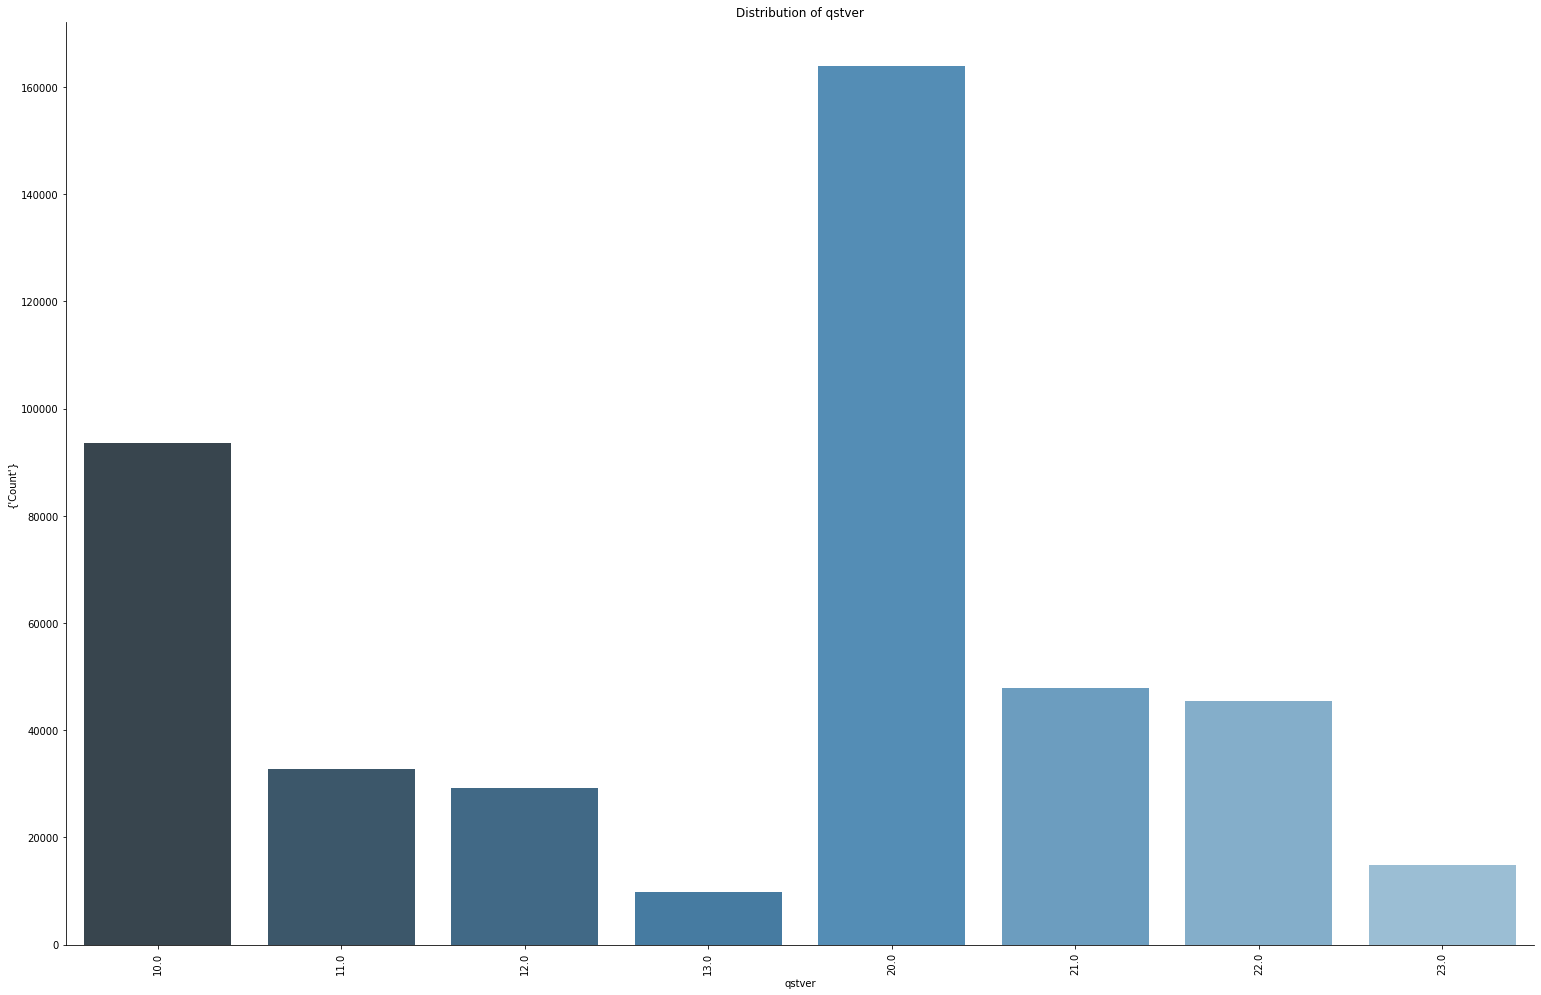

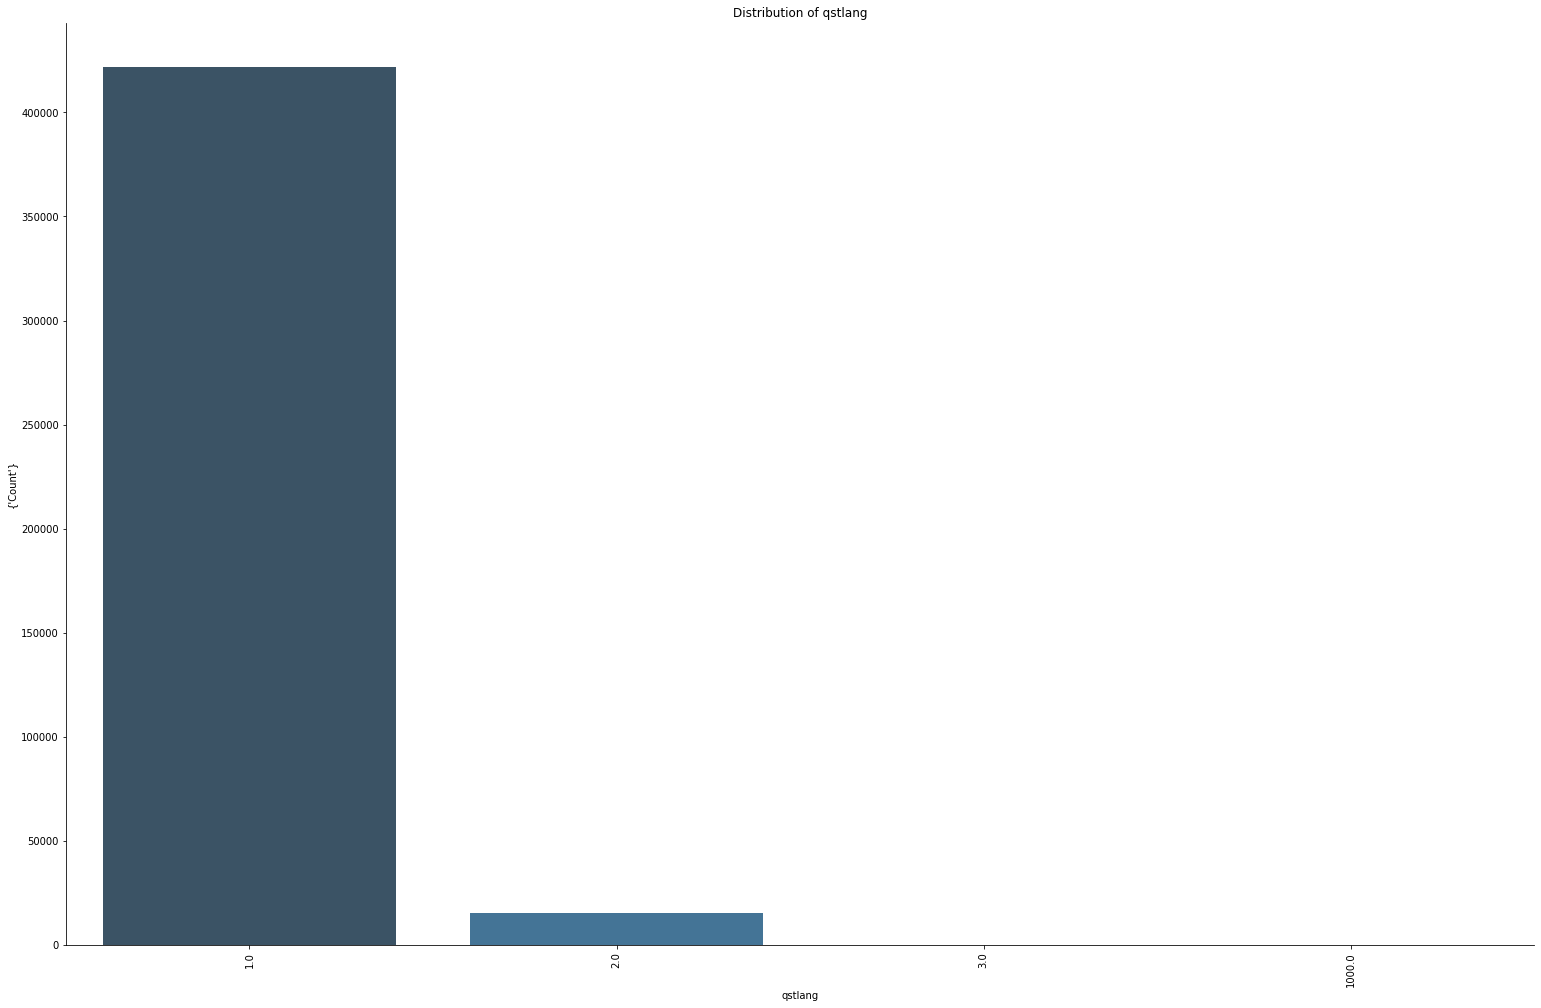

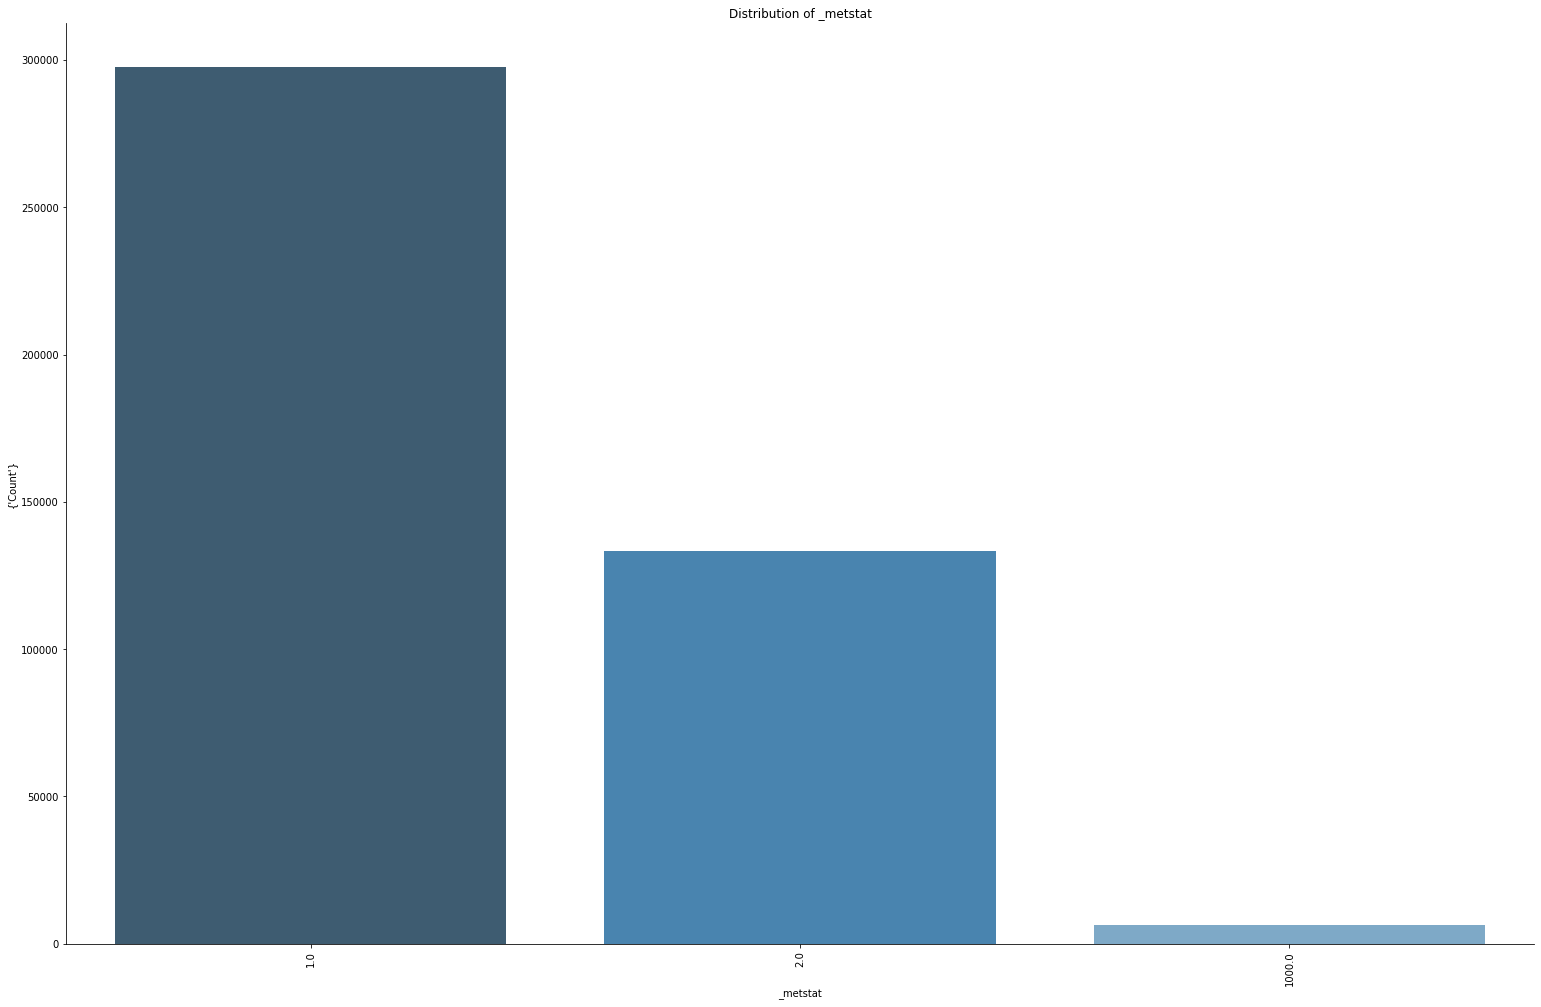

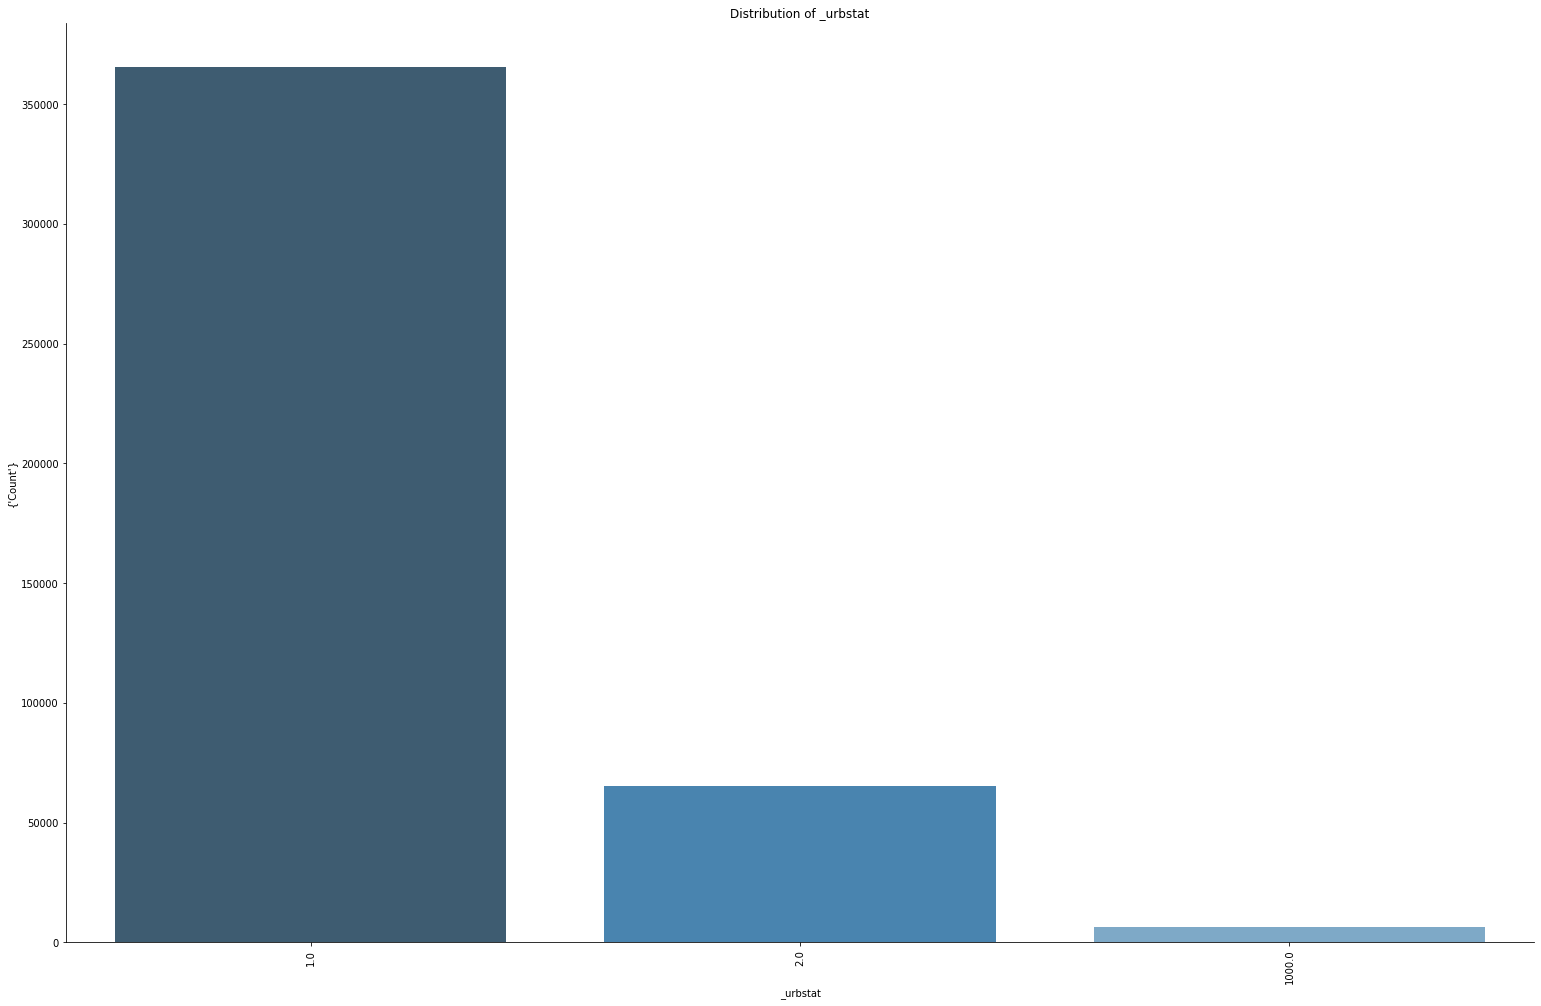

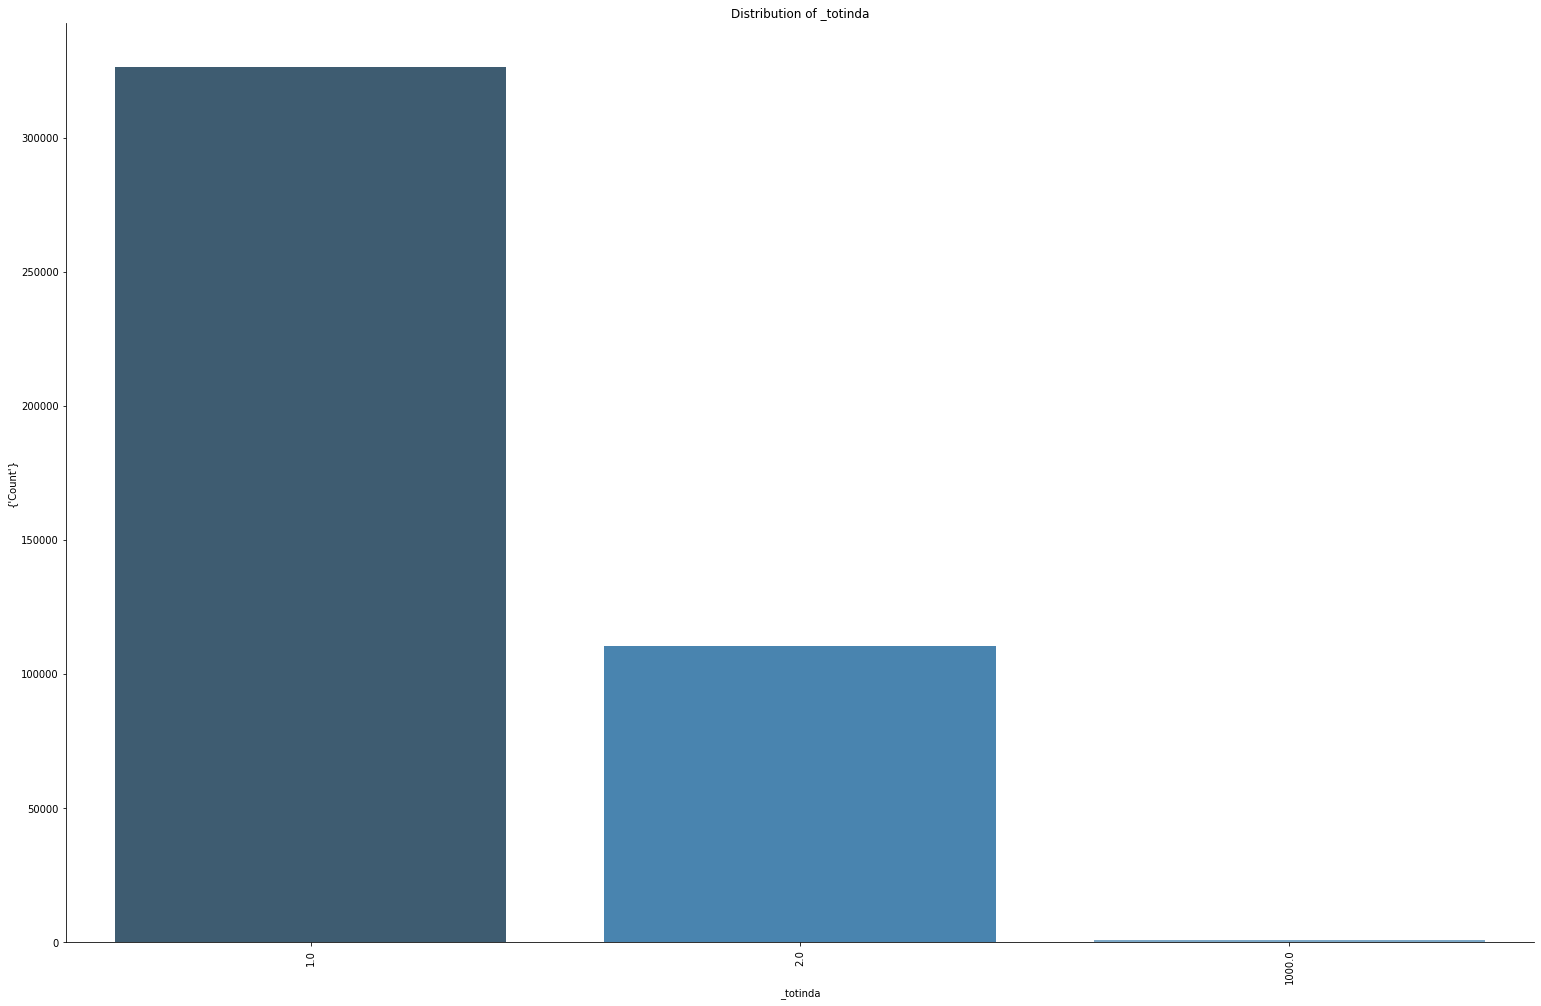

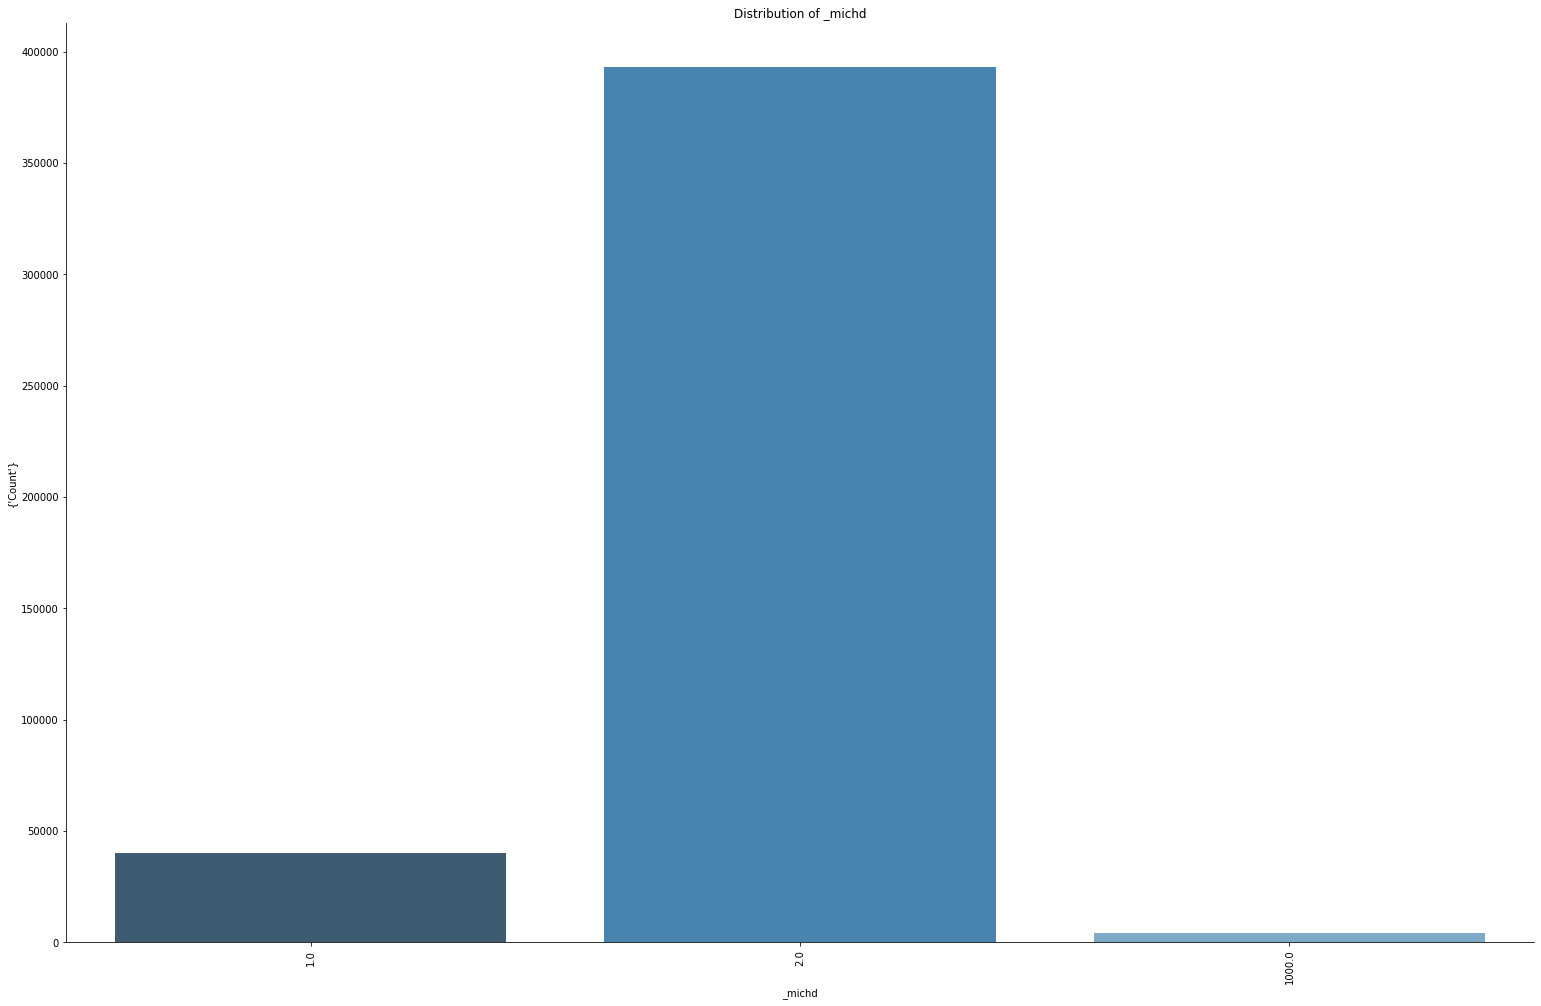

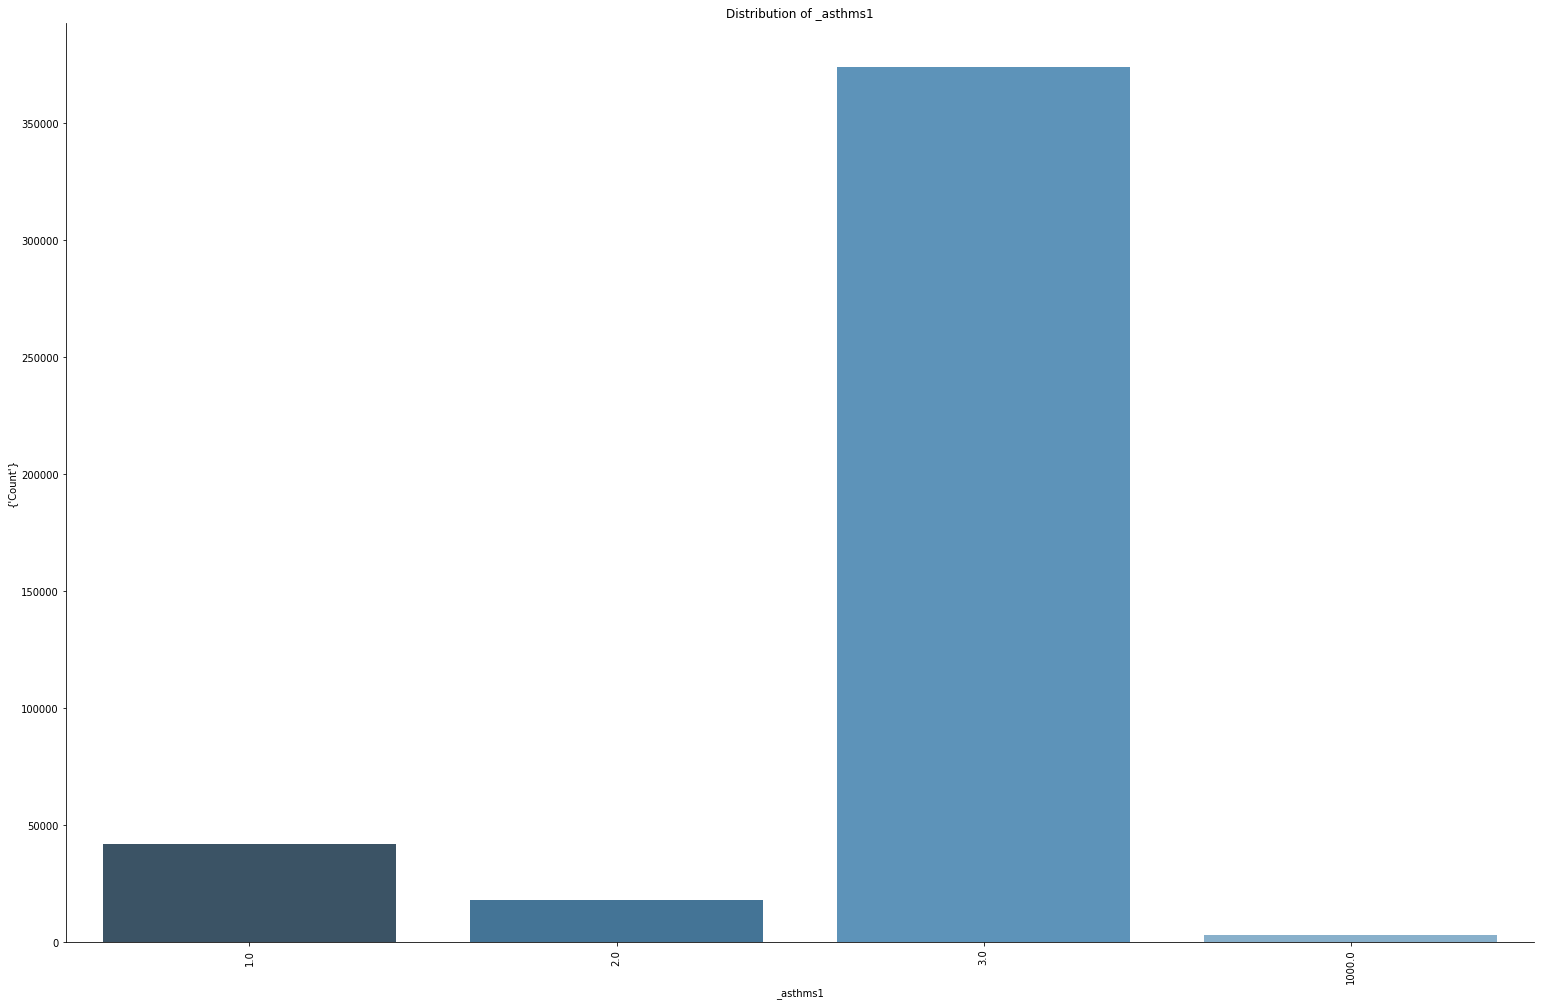

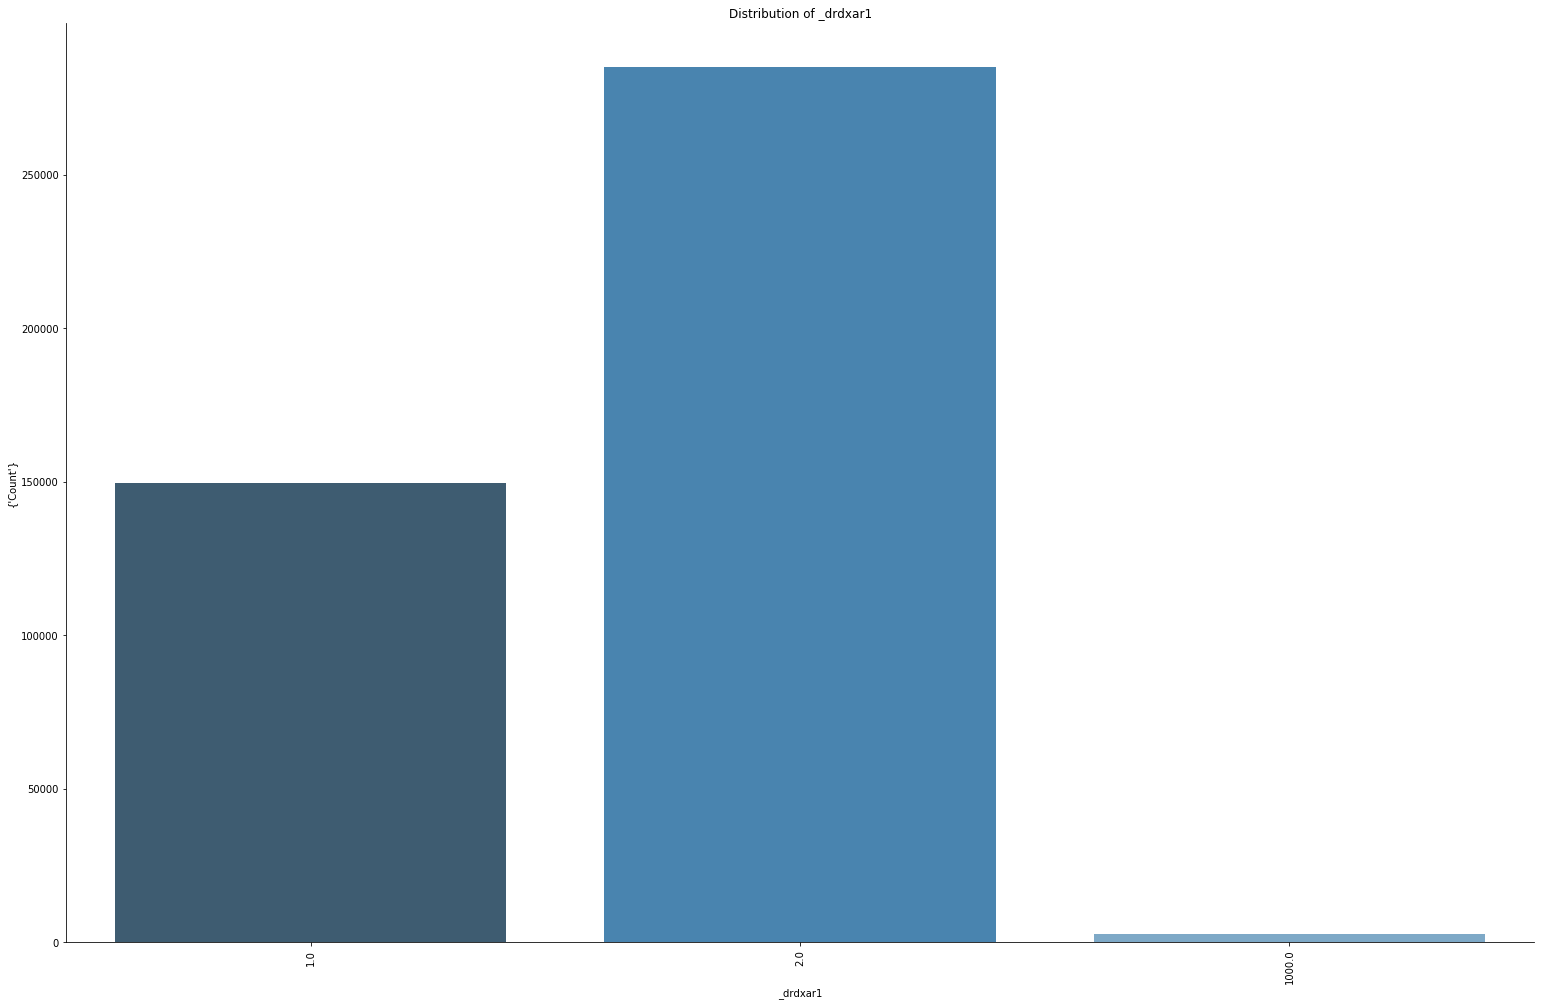

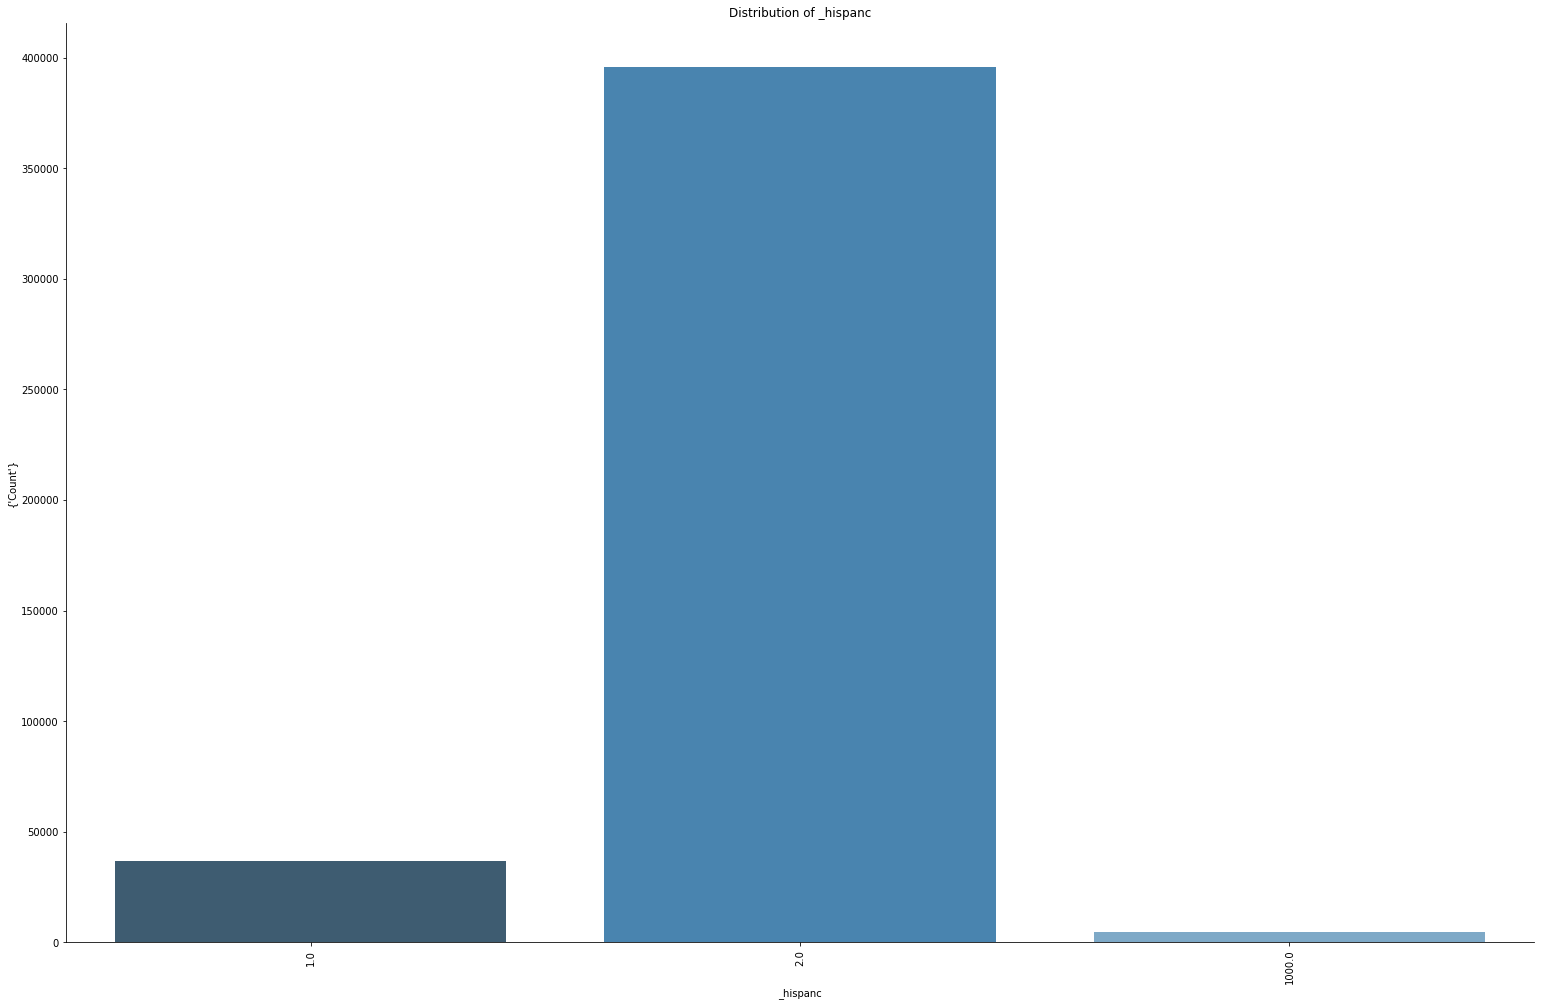

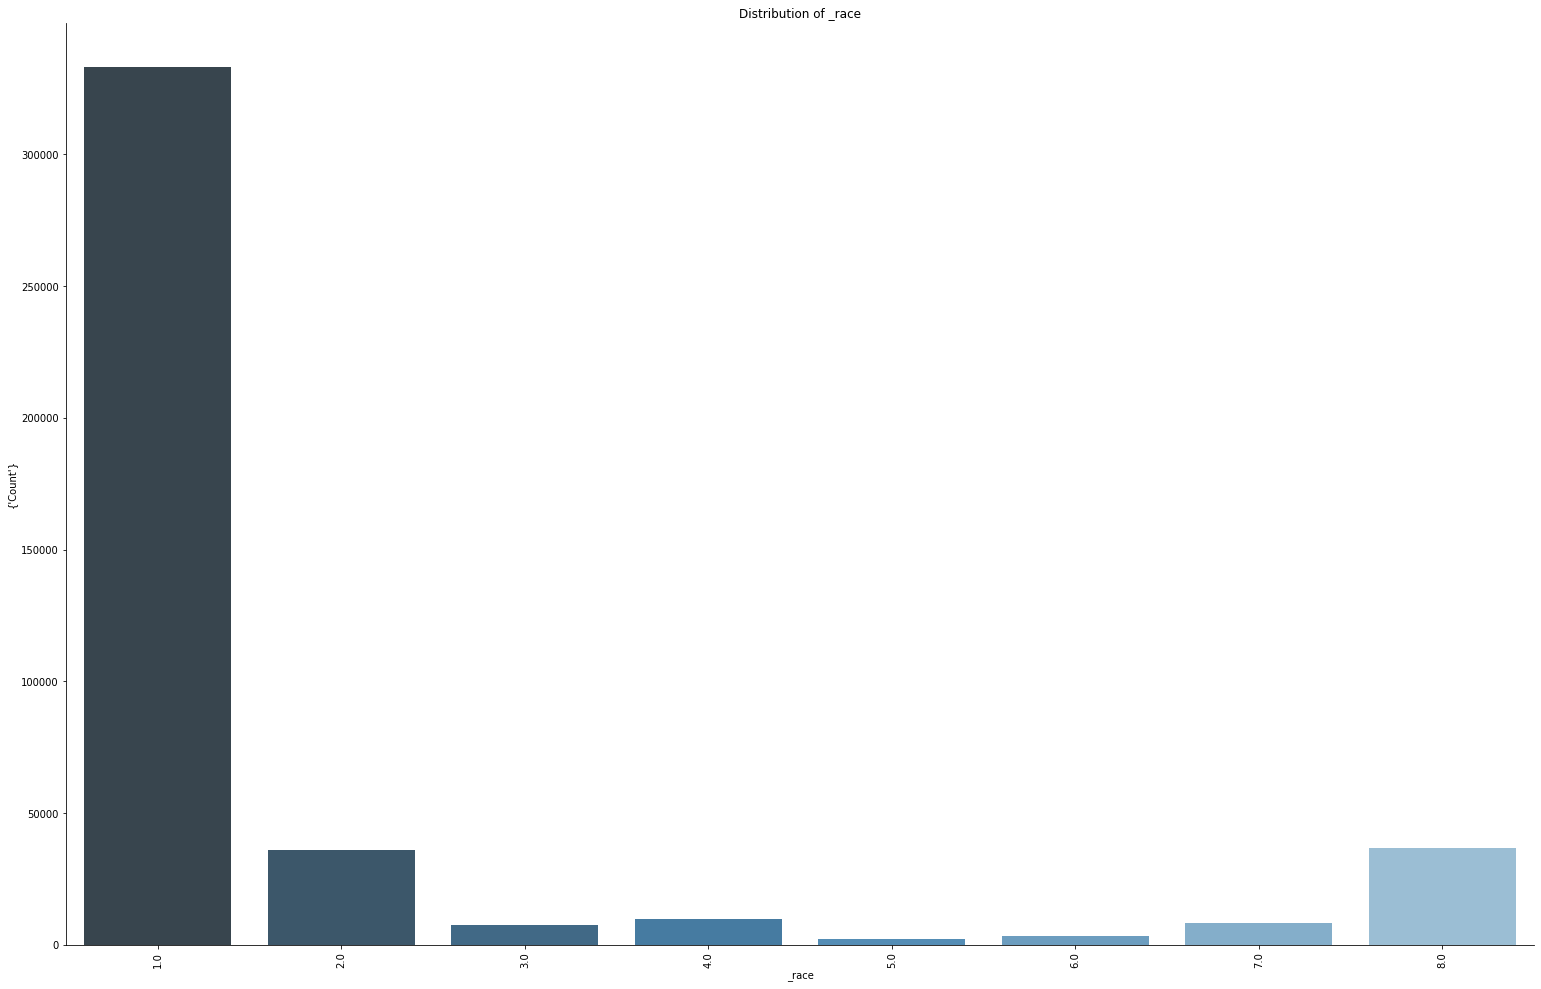

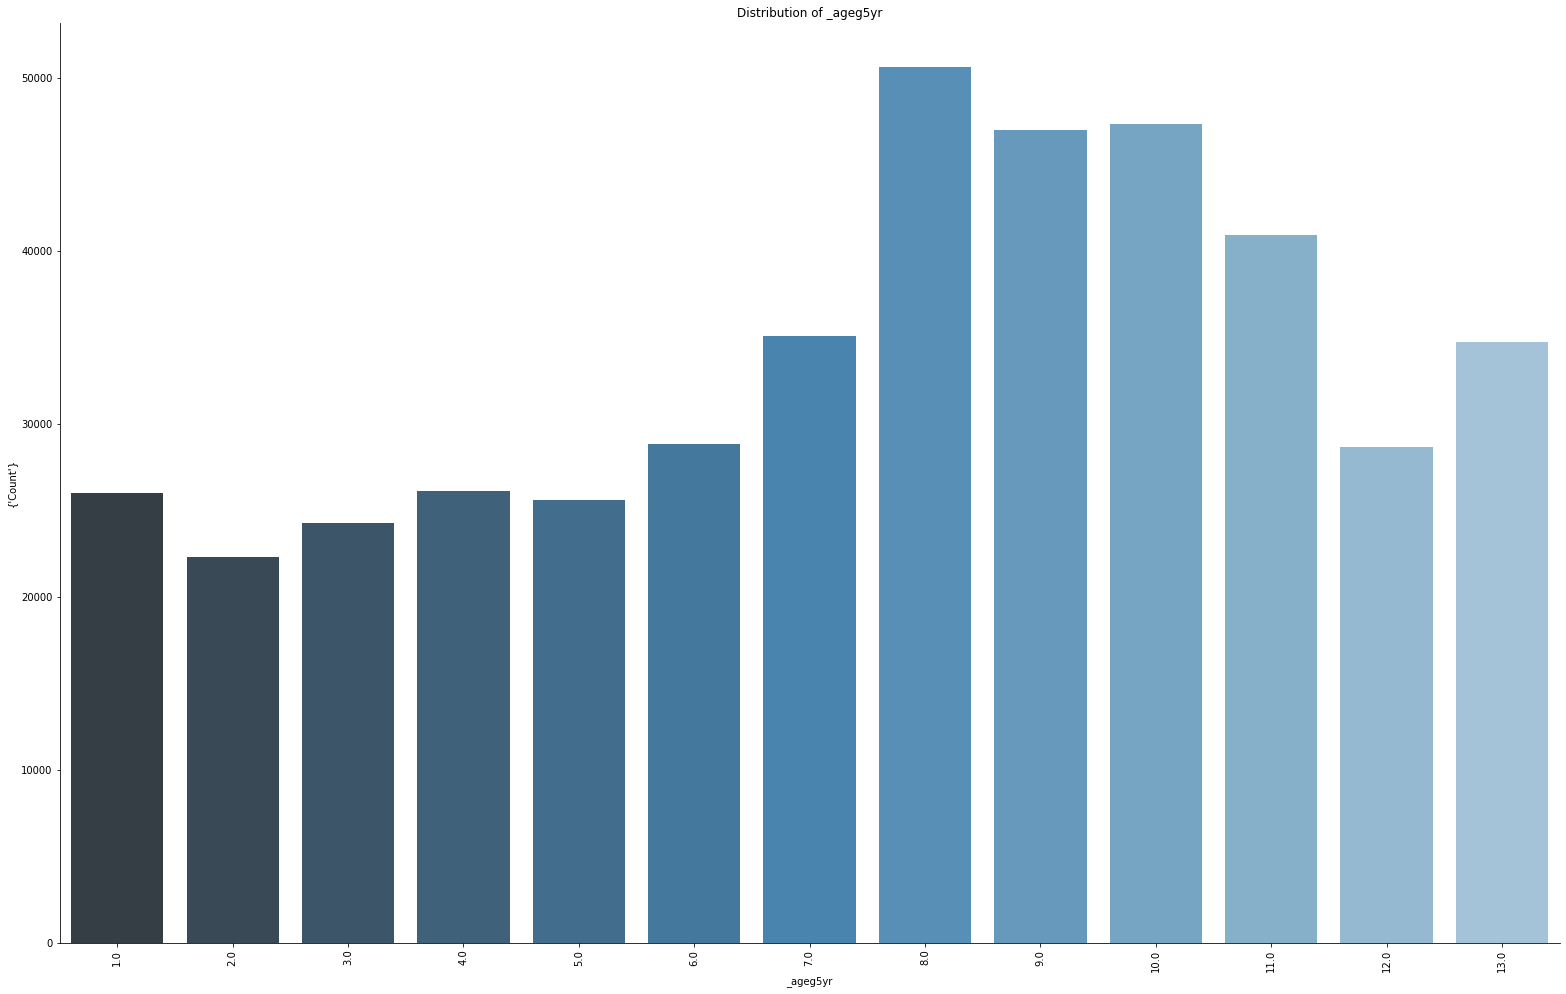

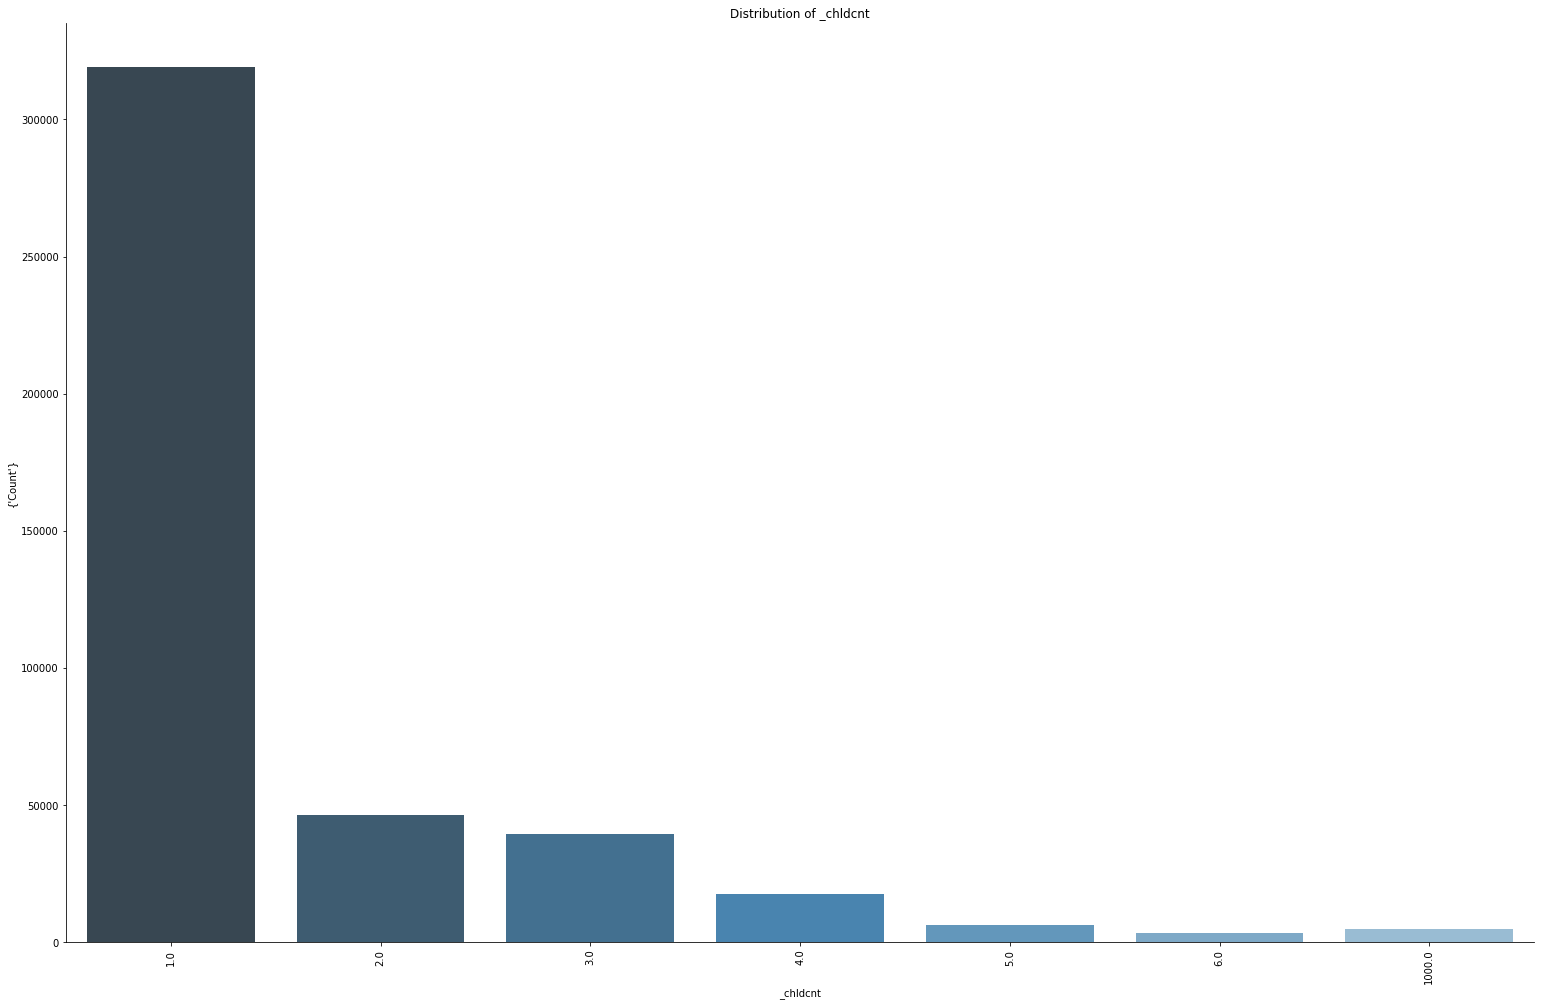

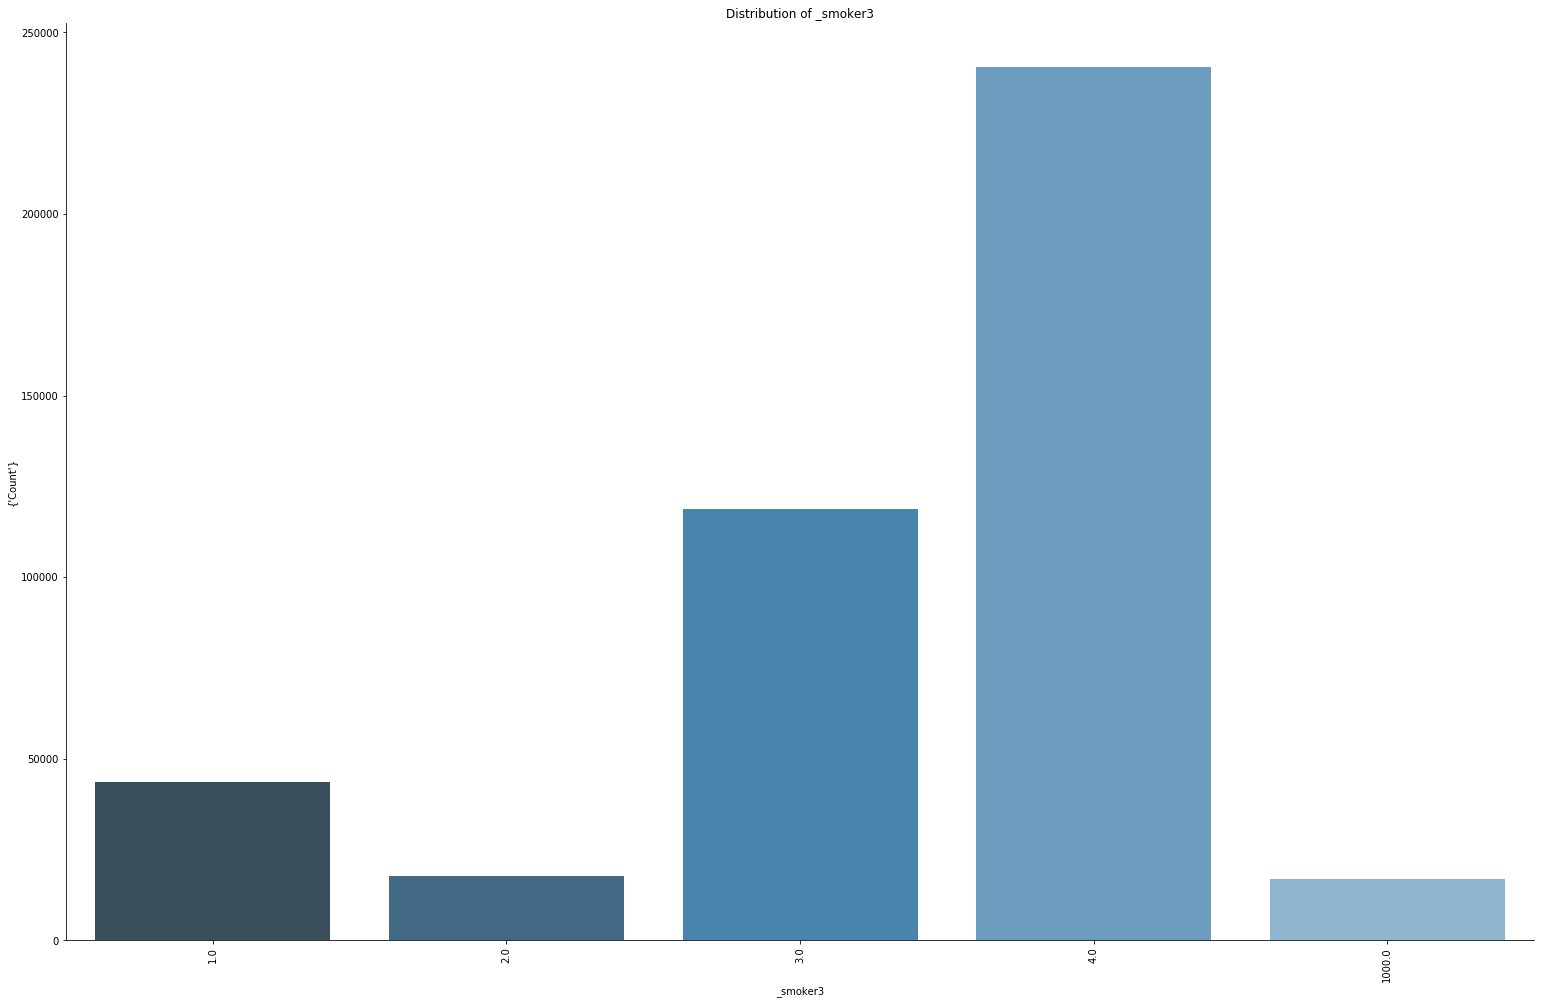

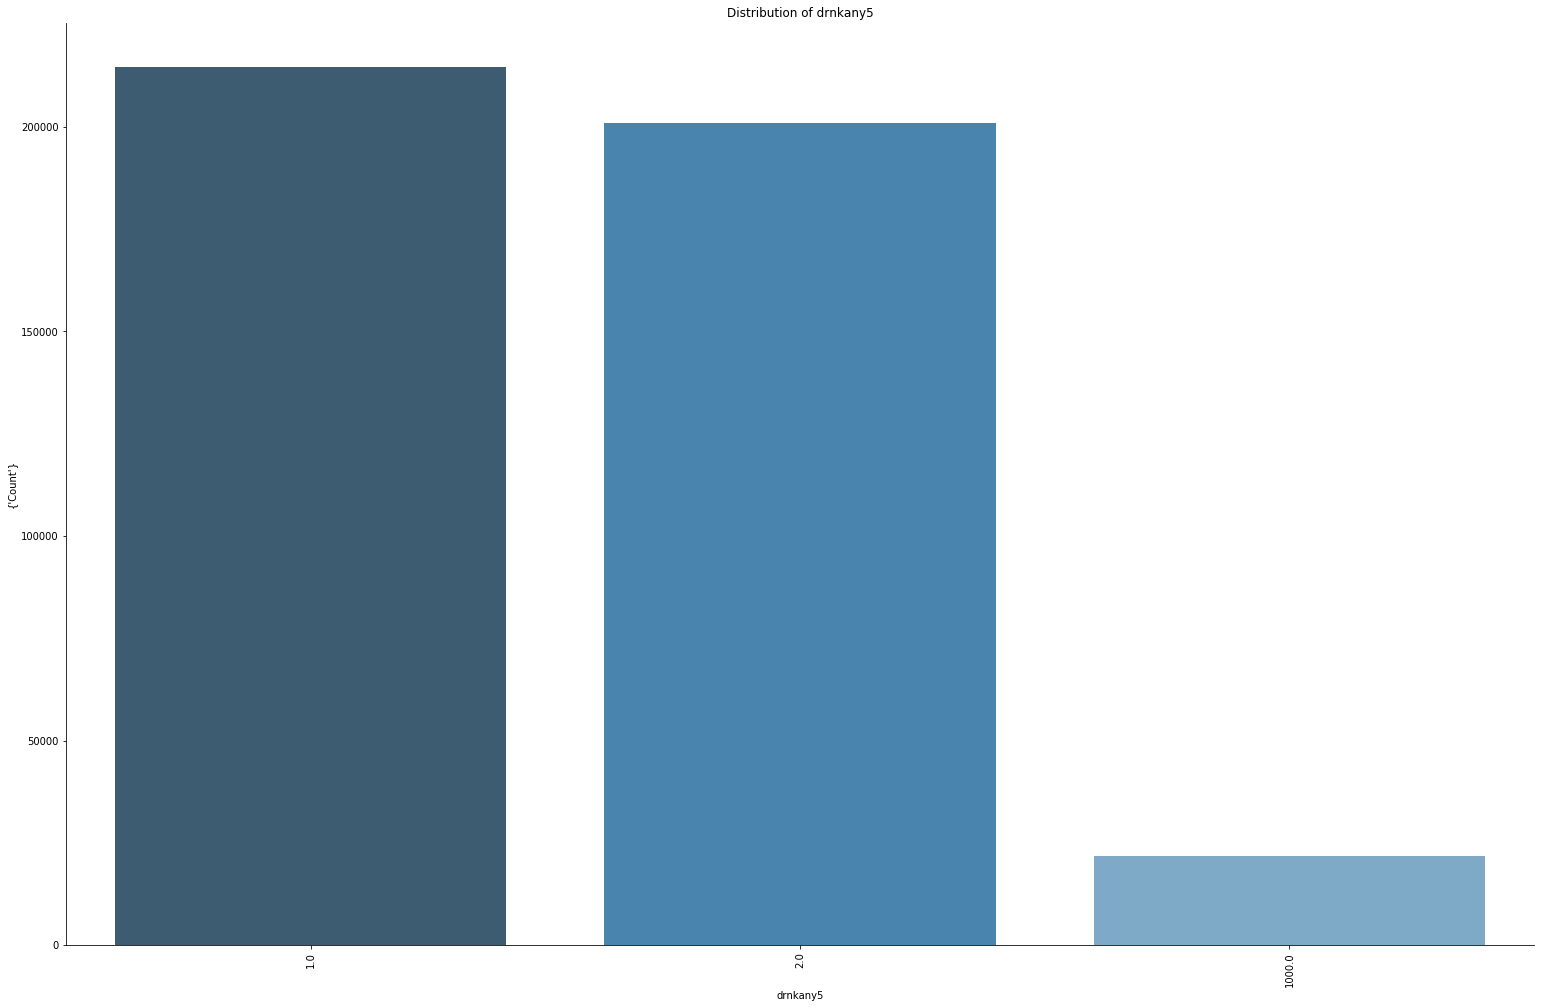

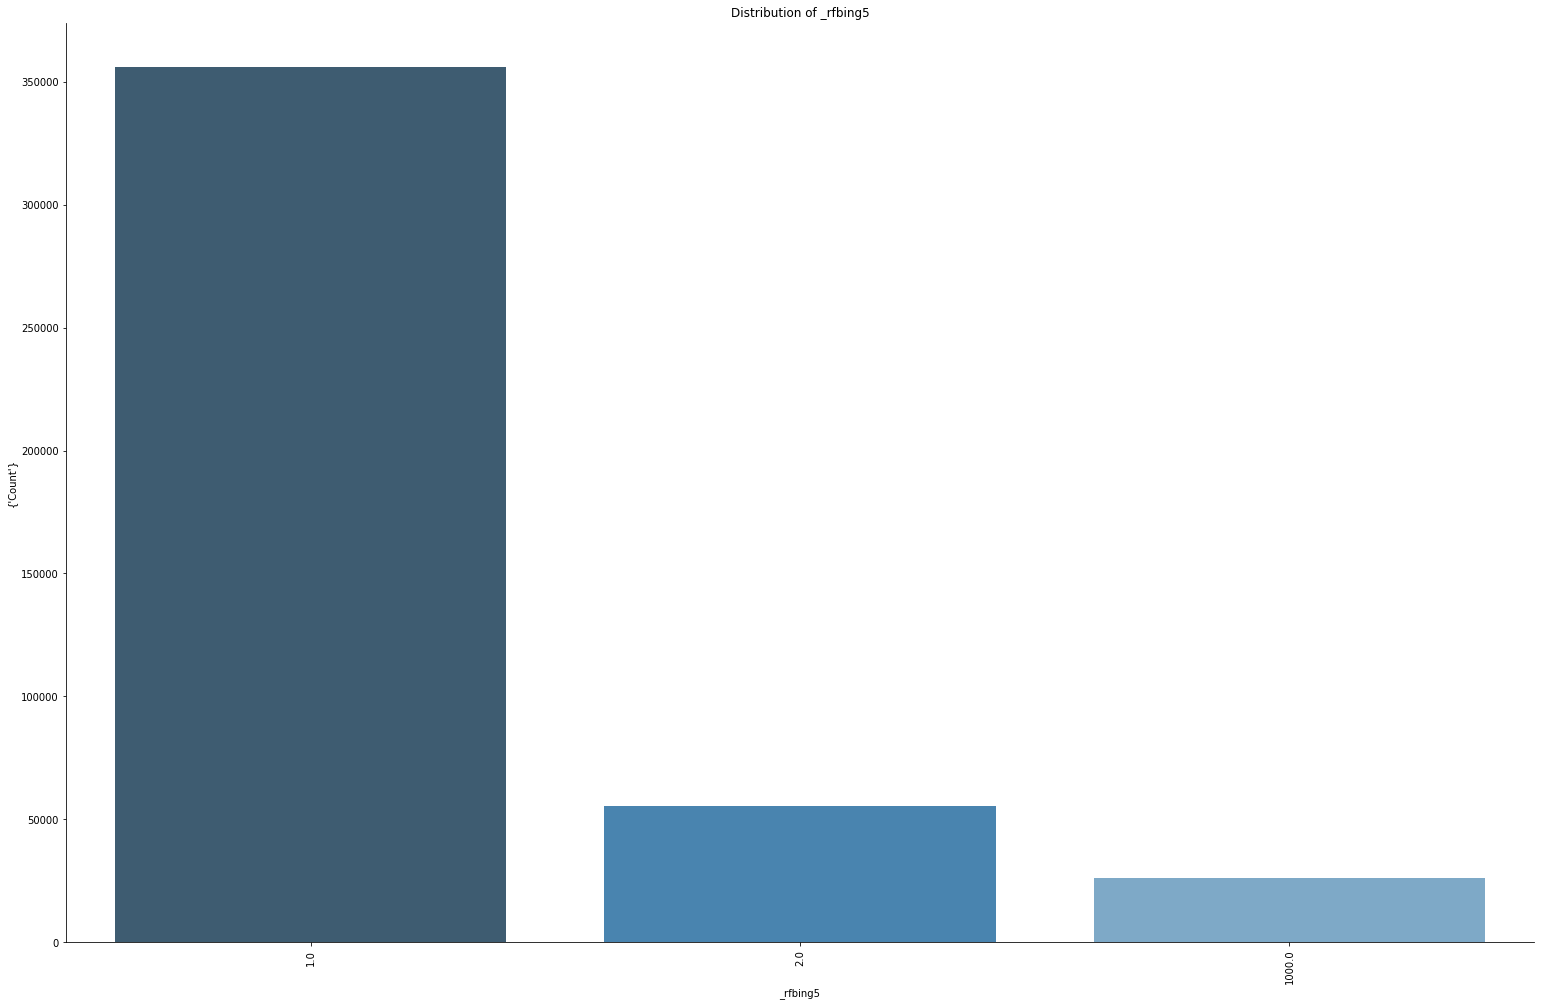

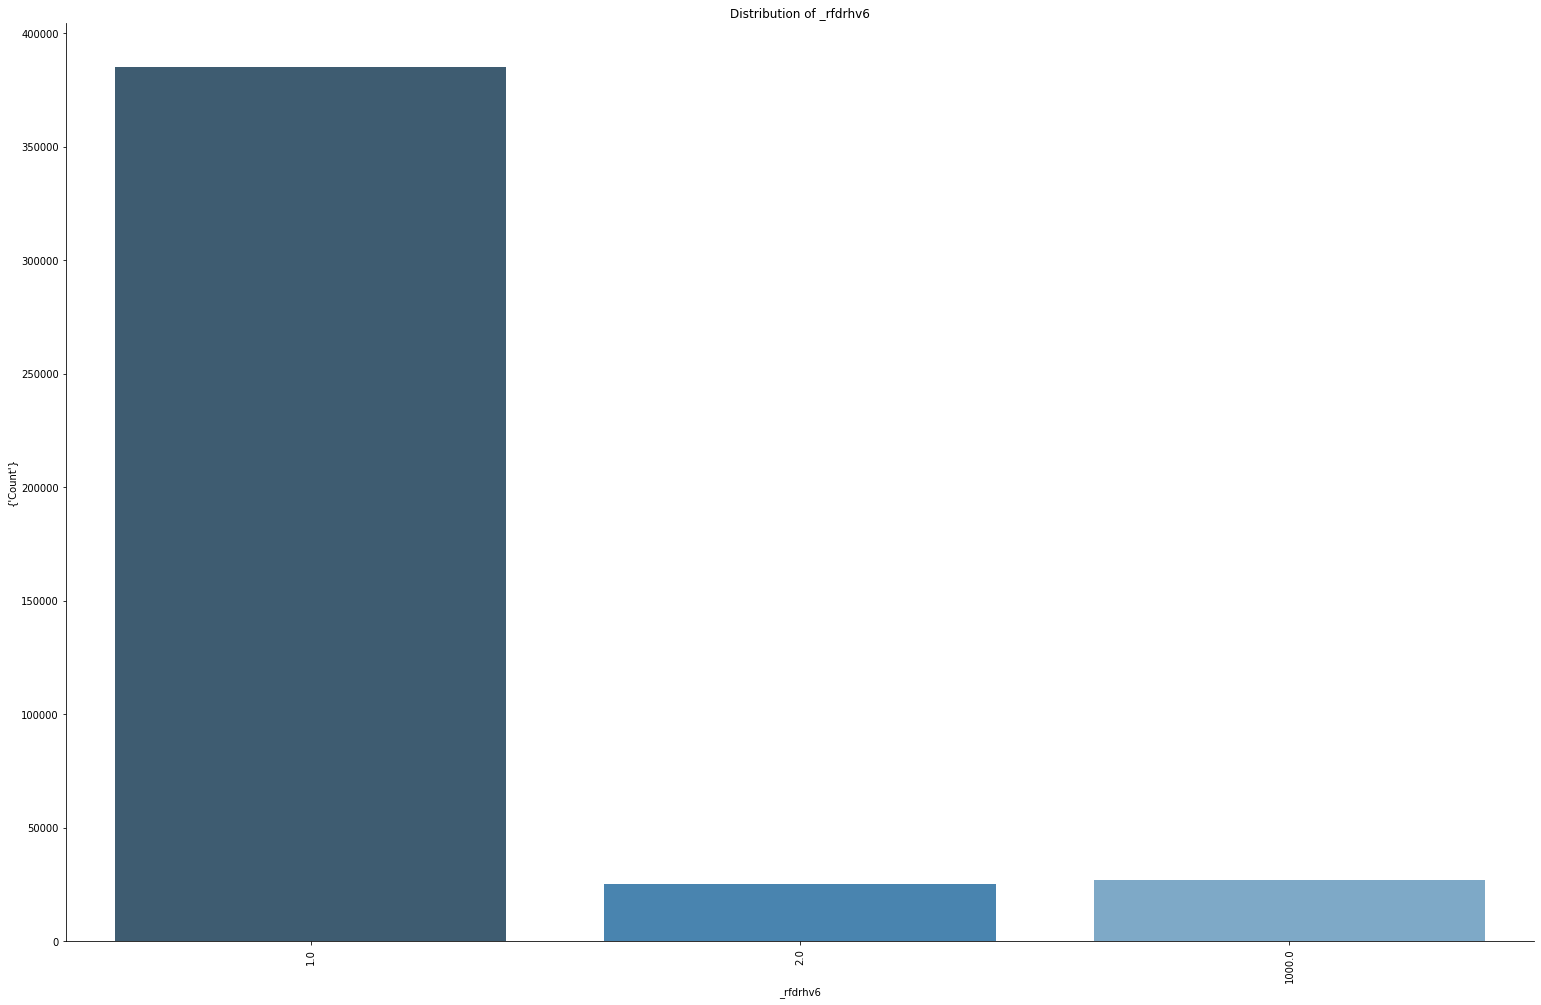

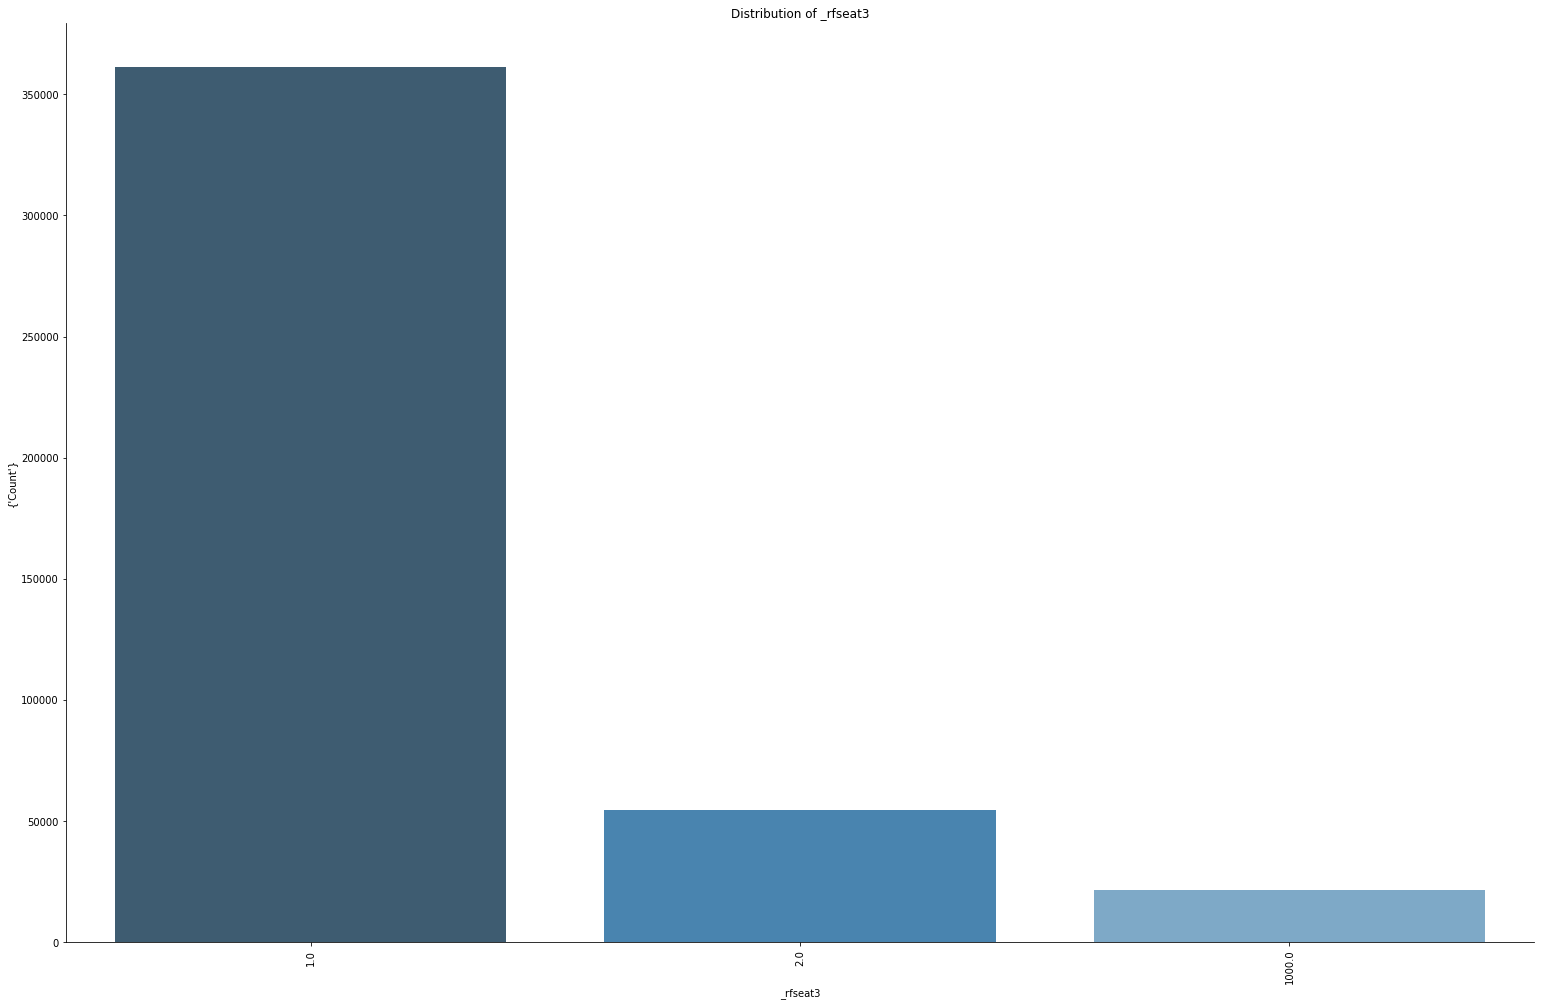

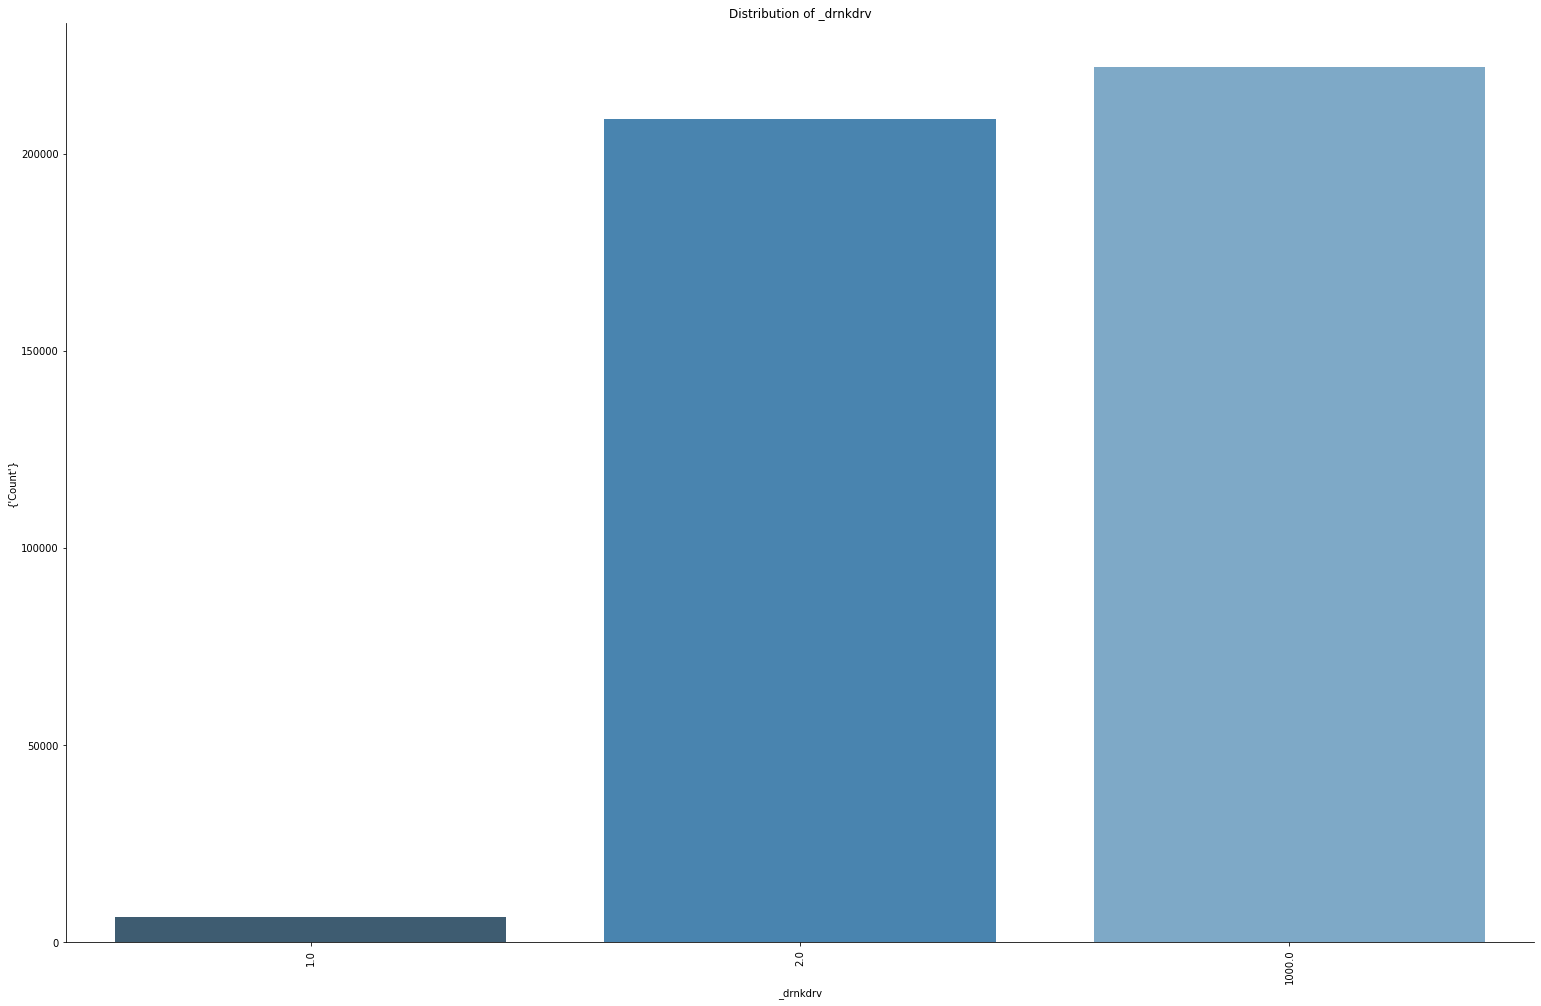

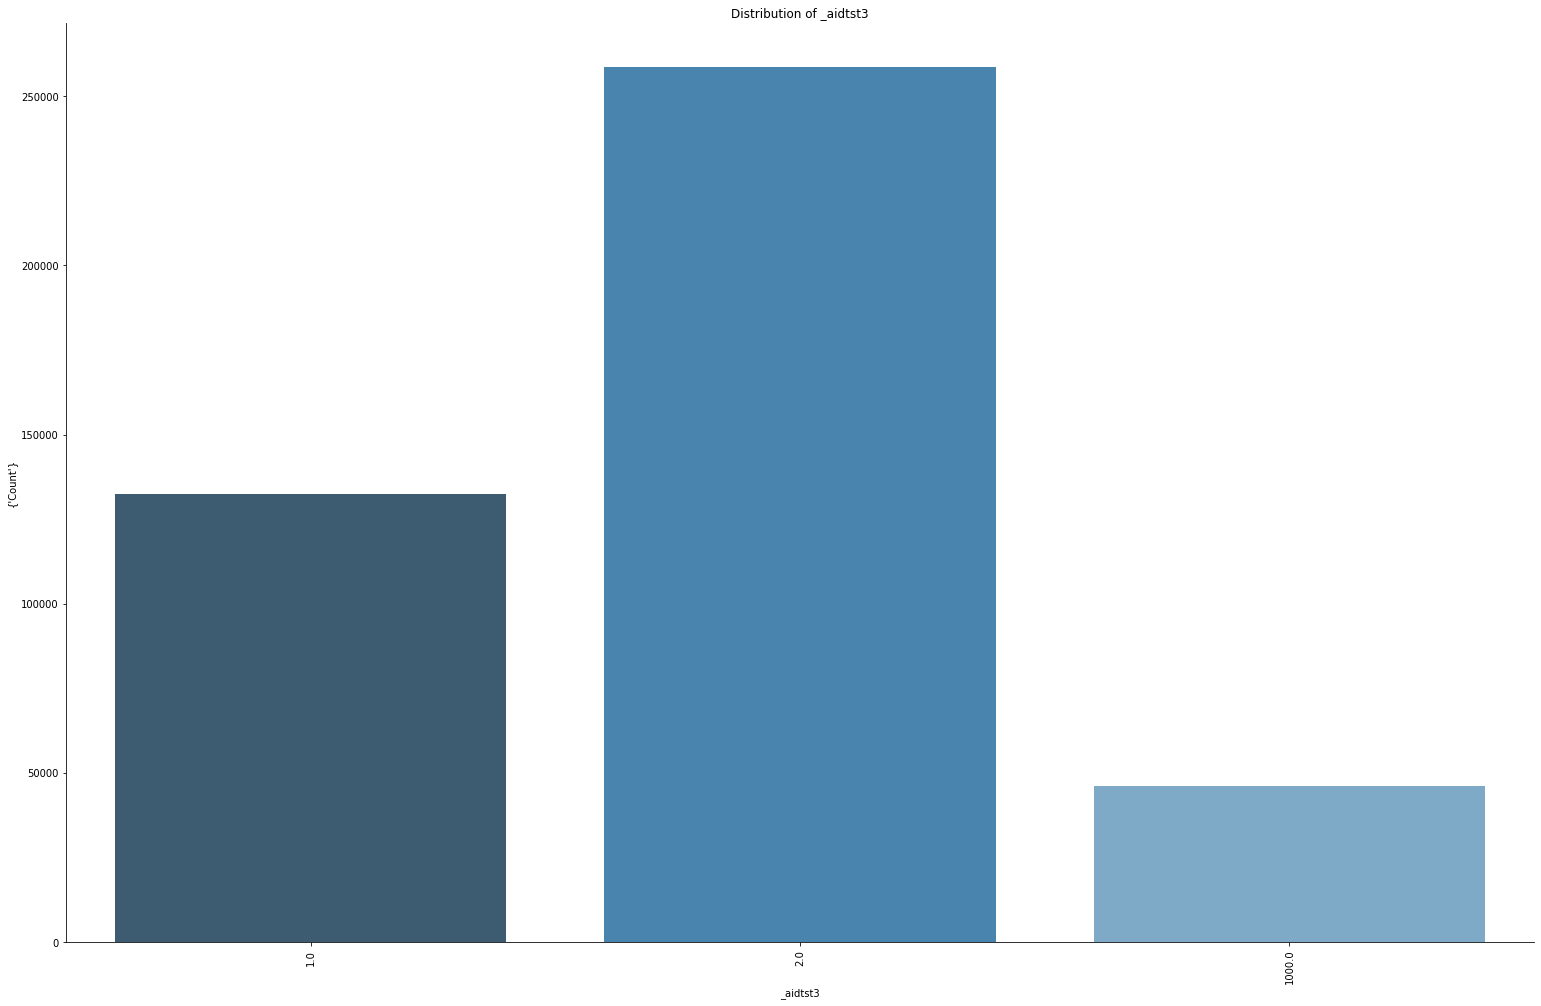

In [68]:
for col in cat_brfss_eda:
    sns.catplot(x=col, kind='count', palette='Blues_d', data=cat_brfss_eda)
    
    plt.gcf().set_size_inches(25, 15)
    
    plt.title('Distribution of {}'.format(col))
    plt.xlabel('{}'.format(col))
    plt.ylabel({'Count'})
    plt.xticks(rotation='vertical')
    plt.show()

So now I need to do a couple of things: 1) The variables need to be coded so that they begin with 0 rather than 1, which will make things esier for the algorithms. 2) Many of the variables also need to be restructured so they make more sense. For example, 0 should be the negative case (e.g., no exercise in the past month), and 1 should be the positive case (yes, exercise in the past month).

In several instances, I'll be able to take care of both of these items at once (by changing 2 to 0 and keeping 1 the same), and I'll do those first, below. In some other instances, I'll need to write a lambda function to ensure that the variables' codes get reorganized properly and that I don't accidentally delete some of their codes. I'll do those second. Finally, any remaining variables that are in good shape, other than not starting with 0, will have 1 subtracted from all of them. Then we'll be ready to move on with much cleaner data!

In [69]:
# Make 0 the negative case in several variables
zero_list = brfss_eda[['hlthpln1',
                       'medcost',
                      'cvdinfr4',
                      'cvdcrhd4',
                      'cvdstrk3',
                      'asthma3',
                      'chcscncr',
                      'chcocncr',
                      'chccopd1',
                      'addepev2',
                      'chckdny1',
                      'veteran3',
                      'deaf',
                      'blind',
                      'decide',
                      'diffwalk',
                      'diffdres',
                      'diffalon',
                      'smoke100',
                      'flushot6',
                      'pneuvac4',
                      'hivrisk5',
                      '_totinda',
                      '_michd',
                      '_drdxar1',
                      '_hispanc',
                      'drnkany5',
                      '_drnkdrv',
                      '_aidtst3'
]]

for col in zero_list:
    brfss_eda.loc[brfss_eda[col] == 2.0, col] = 0.0 

In [70]:
# Check that all cols have 0 and 1 now
for col in zero_list:
    print(brfss_eda[col].value_counts())

1.0       400029
0.0        35433
1000.0      1974
Name: hlthpln1, dtype: int64
0.0       390258
1.0        45054
1000.0      2124
Name: medcost, dtype: int64
0.0       408706
1.0        26412
1000.0      2318
Name: cvdinfr4, dtype: int64
0.0       407649
1.0        26114
1000.0      3673
Name: cvdcrhd4, dtype: int64
0.0       417086
1.0        18999
1000.0      1351
Name: cvdstrk3, dtype: int64
0.0       374205
1.0        61816
1000.0      1415
Name: asthma3, dtype: int64
0.0       395363
1.0        40746
1000.0      1327
Name: chcscncr, dtype: int64
0.0       393295
1.0        42903
1000.0      1238
Name: chcocncr, dtype: int64
0.0       397898
1.0        37337
1000.0      2201
Name: chccopd1, dtype: int64
0.0       353474
1.0        81809
1000.0      2153
Name: addepev2, dtype: int64
0.0       419103
1.0        16647
1000.0      1686
Name: chckdny1, dtype: int64
0.0       379966
1.0        56054
1000.0      1416
Name: veteran3, dtype: int64
0.0       388058
1.0        38748
1000.0  

In [71]:
# See values pre-applying function
print(brfss_eda.diabete3[0:3])

0    3.0
1    3.0
2    1.0
Name: diabete3, dtype: float64


In [72]:
def recode_value(row, col_name, recode_dict):
    return recode_dict[row[col_name]]

def recode_var(df, col_name, recode_dict):
    df[col_name] = df.apply(lambda row: recode_value(row, col_name, recode_dict), axis=1)
    

recode_var(brfss_eda, 'diabete3', {3: 0, 4: 1, 2: 2, 1: 3, 1000: 1000})

In [73]:
# Check function was applied correctly
print(brfss_eda.diabete3[0:3])

0    0
1    0
2    3
Name: diabete3, dtype: int64


In [74]:
# See values pre-applying function
print(brfss_eda.marital[0:3])

0    3.0
1    5.0
2    3.0
Name: marital, dtype: float64


In [75]:
recode_var(brfss_eda, 'marital', {1: 0, 6: 1, 4: 2, 2: 3, 3: 4, 5: 5, 1000:1000})

In [76]:
# Check function worked
print(brfss_eda.marital[0:3])

0    4
1    5
2    4
Name: marital, dtype: int64


In [77]:
recode_var(brfss_eda, 'persdoc2', {3: 0, 1: 1, 2: 2, 1000: 1000})

In [78]:
# Checking it worked  (I'm comparing these new counts with the codebook's, since the first 3 were all 1s here)
print(brfss_eda.persdoc2.value_counts())

1       327742
0        72875
2        34044
1000      2775
Name: persdoc2, dtype: int64


In [79]:
recode_var(brfss_eda, 'usenow3', {3: 0, 2: 1, 1: 2, 1000: 1000})

In [80]:
# Checking it worked
print(brfss_eda.usenow3.value_counts())

0       408060
1000     15146
2         8073
1         6157
Name: usenow3, dtype: int64


So now the last thing left is just to subtract 1 from columns that need to begin with the code 0 instead of 1. It's important to remember that, since 1 is being subtracted from everything here, 1000 will become 999, but I'm okay with that. That will still not conflict with any other codes.

In [81]:
subtract_list = brfss_eda[['_state',
                           'genhlth',
                           'checkup1',
                           'lastden4',
                           'sex1',
                           'educa',
                           'renthom1',
                           'employ1',
                           'income2',
                           'seatbelt',
                           'qstlang',
                           '_metstat',
                           '_urbstat',
                           '_asthms1',
                           '_race',
                           '_ageg5yr',
                           '_chldcnt',
                           '_smoker3',
                           '_rfbing5',
                           '_rfdrhv6',
                           '_rfseat3'
                          ]]

for col in subtract_list:
    brfss_eda[col] = brfss_eda[col] - 1

In [82]:
for col in subtract_list:
    print(brfss_eda[col].value_counts())

35.0    35767
23.0    17546
26.0    16990
11.0    15242
30.0    14634
52.0    13120
38.0    12763
5.0     11919
47.0    11217
22.0    10971
44.0    10843
19.0    10822
8.0     10709
48.0    10563
25.0    10322
50.0    10321
12.0     9305
18.0     9127
7.0      8899
20.0     8548
3.0      8089
14.0     7901
17.0     7608
45.0     7120
34.0     6713
24.0     6669
0.0      6606
49.0     6544
28.0     6231
41.0     6213
40.0     5946
27.0     5843
32.0     5737
37.0     5622
43.0     5607
4.0      5360
16.0     5304
39.0     5253
9.0      5233
29.0     5190
46.0     5160
21.0     5125
54.0     4996
53.0     4897
71.0     4843
36.0     4729
55.0     4462
10.0     4397
15.0     3696
31.0     3222
33.0     3090
1.0      2758
65.0     1644
Name: _state, dtype: int64
1.0      142197
2.0      138321
0.0       71893
3.0       60762
4.0       23120
999.0      1143
Name: genhlth, dtype: int64
0.0      347257
1.0       41245
2.0       21068
3.0       19800
999.0      5732
7.0        2334
Name: check

Great, that should do it. Let's check that we're all done by printing out the entire dataframe's value counts. (There was no need to change a few variables - basically those with survey id info, like iday, imonth, iyear, dispcode, qstver, seqno, etc., so they'll look the same as before).

In [83]:
for col in brfss_eda:
    print(brfss_eda[col].value_counts())

35.0    35767
23.0    17546
26.0    16990
11.0    15242
30.0    14634
52.0    13120
38.0    12763
5.0     11919
47.0    11217
22.0    10971
44.0    10843
19.0    10822
8.0     10709
48.0    10563
25.0    10322
50.0    10321
12.0     9305
18.0     9127
7.0      8899
20.0     8548
3.0      8089
14.0     7901
17.0     7608
45.0     7120
34.0     6713
24.0     6669
0.0      6606
49.0     6544
28.0     6231
41.0     6213
40.0     5946
27.0     5843
32.0     5737
37.0     5622
43.0     5607
4.0      5360
16.0     5304
39.0     5253
9.0      5233
29.0     5190
46.0     5160
21.0     5125
54.0     4996
53.0     4897
71.0     4843
36.0     4729
55.0     4462
10.0     4397
15.0     3696
31.0     3222
33.0     3090
1.0      2758
65.0     1644
Name: _state, dtype: int64
03    40539
10    40429
02    40404
11    37420
07    37295
08    35999
09    35961
06    35775
12    35592
04    35296
05    33657
01    29069
Name: imonth, dtype: int64
07    17669
06    17508
12    17093
08    16919
10    16768


66.000000    37675
64.000000    37114
67.000000    34054
65.000000    33189
68.000000    31154
70.000000    31013
63.000000    30370
62.000000    28669
69.000000    28574
72.000000    27850
71.000000    24404
61.000000    14690
60.000000    14525
73.000000    13515
74.000000    11331
64.225949    10700
70.103423     7194
75.000000     6179
59.000000     4424
76.000000     3936
77.000000     1599
58.000000     1487
57.000000      819
78.000000      806
56.000000      397
79.000000      377
66.819277      283
80.000000      251
53.000000      125
55.000000      113
54.000000       85
36.000000       80
48.000000       80
81.000000       63
82.000000       44
50.000000       38
52.000000       31
51.000000       30
49.000000       29
83.000000       26
84.000000       25
85.000000       16
47.000000        8
89.000000        8
41.000000        7
95.000000        7
87.000000        5
90.000000        5
42.000000        5
40.000000        4
86.000000        4
45.000000        4
92.000000   

Great, this seems to have worked well. There is one more thing I want to do, though: after looking through the codebook more, there are a few more variables I want to recode, simply to reverse their order so interpreting results will be easier later on. These are variables that don't necessarily *need* to be recoded, but I think it will make my life easier. For example, asthms1 is arranged in increments from 'currently has asthma' (which is 0) to 'never had asthma.' I would like 'never' to be 0, since it is the negative case. Then, the highest number will be the 'most positive' case: 'currently has asthma.' And ditto for all the other variables I'm going to recode. Again, everything will be so much simpler to interpret if all my variables (not just the binary yes/no's) go from a negative case to increasingly more positive cases.

In [84]:
#_rfseat3: 0 is always, 1 is not always; we just need to switch them
recode_var(brfss_eda, '_rfseat3', {1: 0, 0: 1,  999: 999})

In [85]:
# Check values now: 0 should be 54,600
brfss_eda._rfseat3.value_counts()

1      361429
0       54600
999     21407
Name: _rfseat3, dtype: int64

In [86]:
# seatbelt: 0 is always, and the continuum goes up to 4, which is never; I'm going to reverse that.
# 5 is never rides in a car, which I'm going to add to missing (it's .2% of responses and isn't part of the continuum)
recode_var(brfss_eda, 'seatbelt', {4: 0, 3: 1, 2: 2, 1: 3, 0: 4, 5: 999, 999: 999})

In [87]:
# Check values now: 0 should be 7810, 1 - 4256, 2 - 11,477, 3 - 31,057, 4 - 360,425
brfss_eda.seatbelt.value_counts()

4      360425
3       31057
999     22411
2       11477
0        7810
1        4256
Name: seatbelt, dtype: int64

In [88]:
# _asthms1: 0 is currently has, 1 formerly had, 2 never had; I'm going to reverse that so 0 is never
recode_var(brfss_eda, '_asthms1', {2: 0, 1: 1, 0: 2, 999: 999})

In [89]:
# Check values now: 0 should be 374,205, 1 - 17,959
brfss_eda._asthms1.value_counts()

0      374205
2       41974
1       17959
999      3298
Name: _asthms1, dtype: int64

In [90]:
# smoker3: same thing - 0 is currently smokes ; I want it to be never has smoked
recode_var(brfss_eda, '_smoker3', {3: 0, 2: 1, 1: 2, 0: 3, 999: 999})

In [91]:
# Check values now: 0 should be 240,594, 3 should be 43,633
brfss_eda._smoker3.value_counts()

0      240594
1      118754
3       43633
2       17639
999     16816
Name: _smoker3, dtype: int64

In [92]:
# _urbstat: 0 urban area; 1 is non-urban area; I just need to switch them
recode_var(brfss_eda, '_urbstat', {1: 0, 0: 1, 999: 999})

In [93]:
# Check values now: 0 should be 65,235
brfss_eda._urbstat.value_counts()

1      365714
0       65235
999      6487
Name: _urbstat, dtype: int64

In [94]:
# _metstat: same thing as _urbstat, just swapping 0 and 1
recode_var(brfss_eda, '_metstat', {1: 0, 0: 1, 999: 999})

In [95]:
# Check values now: 0 should be 133,199
brfss_eda._metstat.value_counts()

1      297750
0      133199
999      6487
Name: _metstat, dtype: int64

In [96]:
# dispcode: code 1200 (partially complete) will become 0
recode_var(brfss_eda, 'dispcode', {1200: 0, 1100: 1})

In [97]:
# Check values now: 0 should be 63,239
brfss_eda.dispcode.value_counts()

1    374197
0     63239
Name: dispcode, dtype: int64

Great. Cleaning is officially done.

A note on outliers: 
Considering that the clustering algorithms I'm planning to use in this project are robust with outliers, and that most of my variables do not have outliers because they are either purely categorical or - in the case of the few continuous variables - because the outliers may better inform the clusters, I'm not going to remove them.

# 4. Methods

Here is a brief breakdown of the methods that will be used for clustering and attempting to describe the clusters.

### Descriptive statistics & feature selection

1. Run some more descriptive statistics on the dataset for further understanding of variable relationships

2. Get a correlation matrix for the variables and plot it as a heatmap to determine which features are multicollinear, which could affect the algorithms.

3. Run a variance inflation factor (VIF) on the variables to determine the magnitude of multicollinearity, which will better inform whether certain variables actually should be removed or not.

4. If variables have VIF value < 10, remove them

5. Define X, which is the set of variables that will be put into the clustering algorithms.

6. Standardize X so algorithms run better

### Clustering

1. Use DBSCAN as initial clusetering algorithm, because it's good with non-parametric data & non-symmetrical cluster shapes.

2. Use KNN to plot elbow graph to determine best value for DBSCAN's eps parameter 

3. Start min_samples at 100 because the dataset is so large

4. Continue with a few different values for min_samples until the optimal window is found

5. Get silhouette scores for all DBSCAN iterations to find which is the best one

6. Plot the clusters from the best DBSCAN solution

7. Use K-Means as the next clustering algorithm, setting k to the number of clusters that DBSCAN determined to be optimal

8. Plot the K-Means solution & get silhouette score

9. Use K-Modes, because also good with categorical/non-parametric data

10. Plot K-Modes & get silhouette score

11. Compare the 3 clustering algorithms & pick the best one

### Interpretation

1. Take the clusters made from the best clustering algorithm, make them an array, and add them back into BRFSS dataframe (the cleaned version)

2. Plot the clusters against a couple of features, with the goal of finding out more about what the clusters mean, what types of data they contain, etc.

In [98]:
brfss_eda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 437436 entries, 0 to 437435
Data columns (total 68 columns):
_state      437436 non-null float64
imonth      437436 non-null object
iday        437436 non-null object
iyear       437436 non-null object
dispcode    437436 non-null int64
seqno       437436 non-null object
genhlth     437436 non-null float64
physhlth    437436 non-null float64
menthlth    437436 non-null float64
hlthpln1    437436 non-null float64
persdoc2    437436 non-null int64
medcost     437436 non-null float64
checkup1    437436 non-null float64
sleptim1    437436 non-null float64
cvdinfr4    437436 non-null float64
cvdcrhd4    437436 non-null float64
cvdstrk3    437436 non-null float64
asthma3     437436 non-null float64
chcscncr    437436 non-null float64
chcocncr    437436 non-null float64
chccopd1    437436 non-null float64
addepev2    437436 non-null float64
chckdny1    437436 non-null float64
diabete3    437436 non-null int64
lastden4    437436 non-null float64

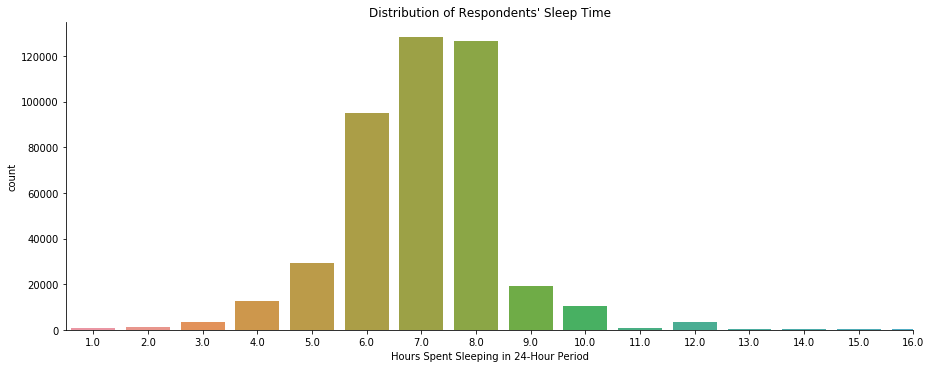

In [99]:
# Let's look at the distribution of sleptim1 again:
sns.catplot(x='sleptim1', kind='count', data=brfss_eda)
plt.title('Distribution of Respondents\' Sleep Time')
plt.xlabel('Hours Spent Sleeping in 24-Hour Period')
plt.xlim(right=15)
plt.gcf().set_size_inches(15,5)
plt.show()

In [100]:
# Removing missing values just for better descriptive statstics plots
brfss_desc = brfss_eda.copy()

brfss_desc = brfss_desc.drop(columns=['_bmi5', 
                                      'htin4', 
                                      'wtkg3',
                                      'imonth',
                                      'iday',
                                      'iyear',
                                      'seqno',
                                      'dispcode'
                                     ])

brfss_desc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 437436 entries, 0 to 437435
Data columns (total 60 columns):
_state      437436 non-null float64
genhlth     437436 non-null float64
physhlth    437436 non-null float64
menthlth    437436 non-null float64
hlthpln1    437436 non-null float64
persdoc2    437436 non-null int64
medcost     437436 non-null float64
checkup1    437436 non-null float64
sleptim1    437436 non-null float64
cvdinfr4    437436 non-null float64
cvdcrhd4    437436 non-null float64
cvdstrk3    437436 non-null float64
asthma3     437436 non-null float64
chcscncr    437436 non-null float64
chcocncr    437436 non-null float64
chccopd1    437436 non-null float64
addepev2    437436 non-null float64
chckdny1    437436 non-null float64
diabete3    437436 non-null int64
lastden4    437436 non-null float64
rmvteth4    437436 non-null float64
sex1        437436 non-null float64
marital     437436 non-null int64
educa       437436 non-null float64
renthom1    437436 non-null flo

In [101]:
for col in brfss_desc:
    brfss_desc = brfss_desc[brfss_desc[col] < 999]

In [102]:
# Check missing columns (1000 & 999) don't show up anymore
brfss_desc['blind'].value_counts()

0.0    137463
1.0      4353
Name: blind, dtype: int64

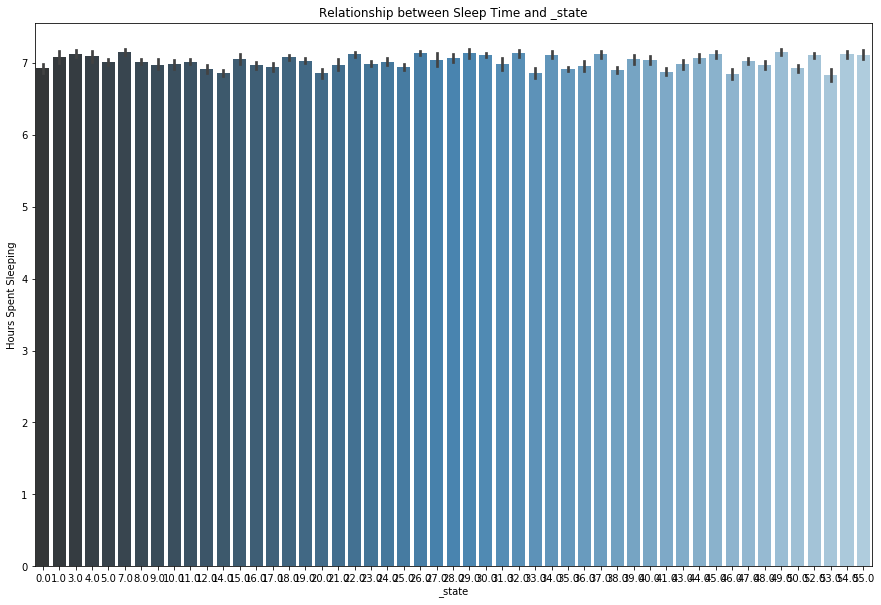

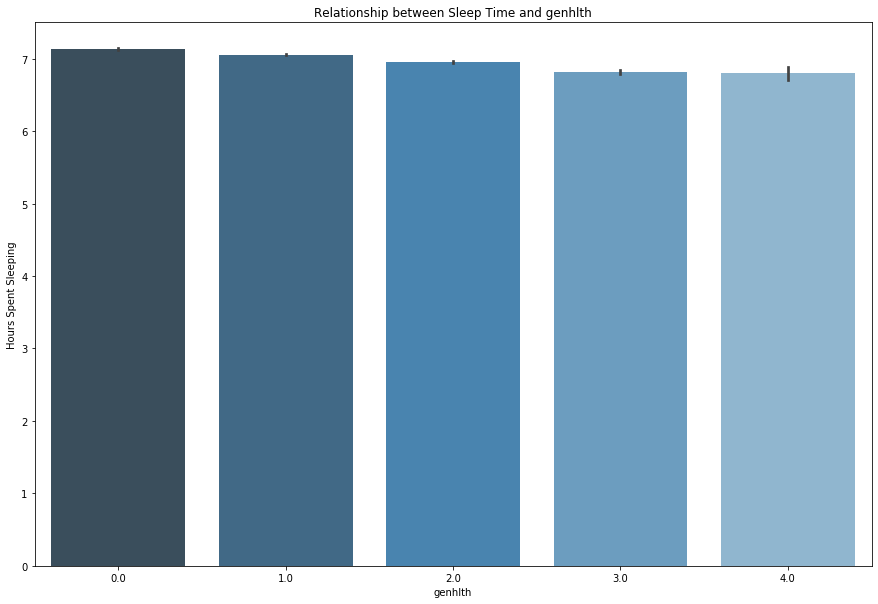

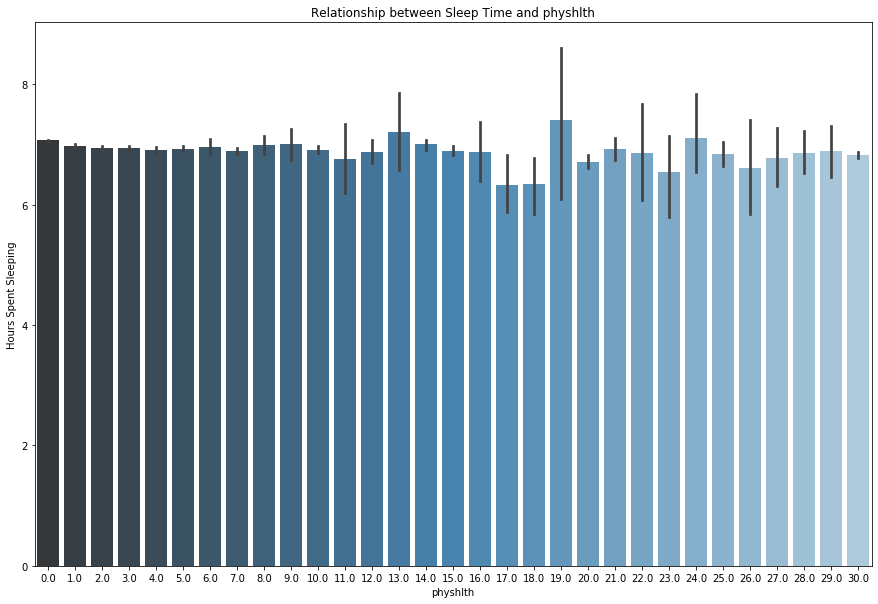

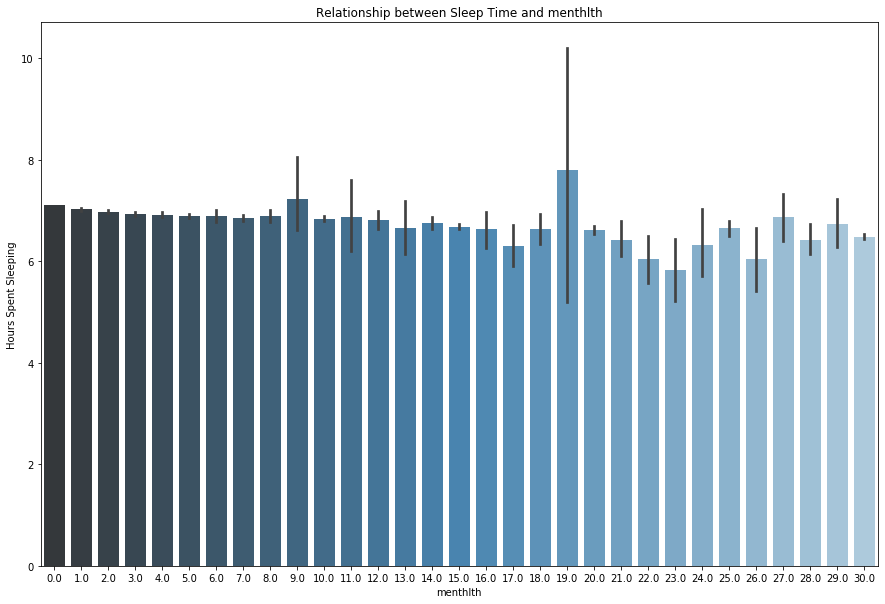

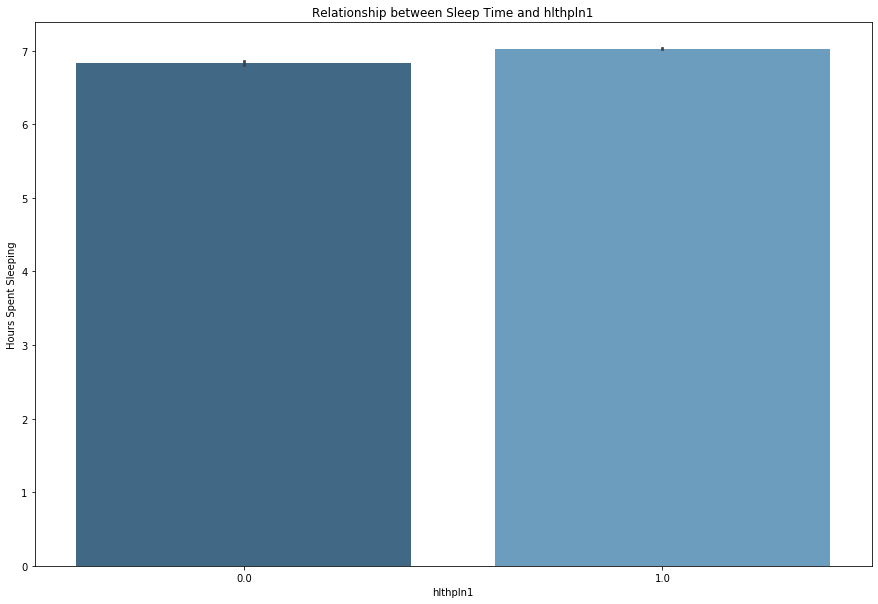

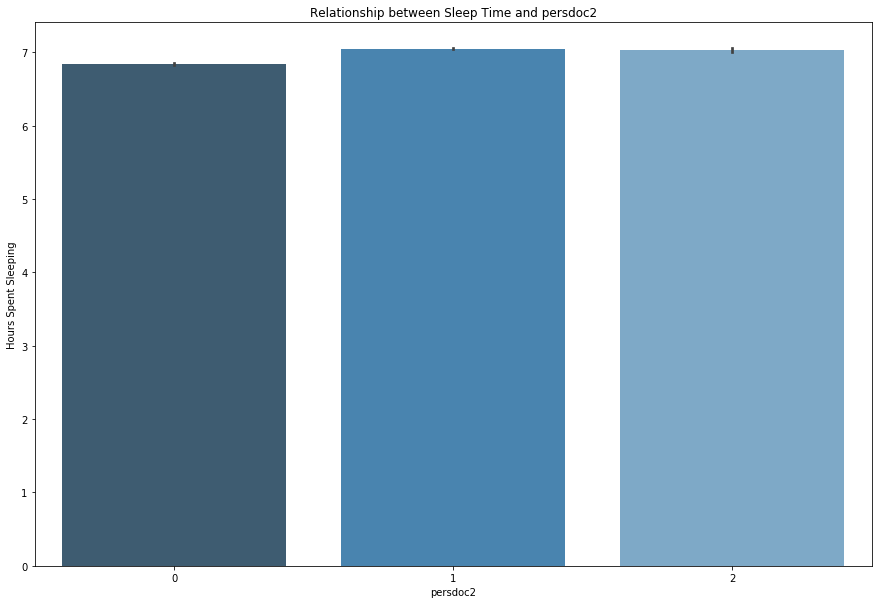

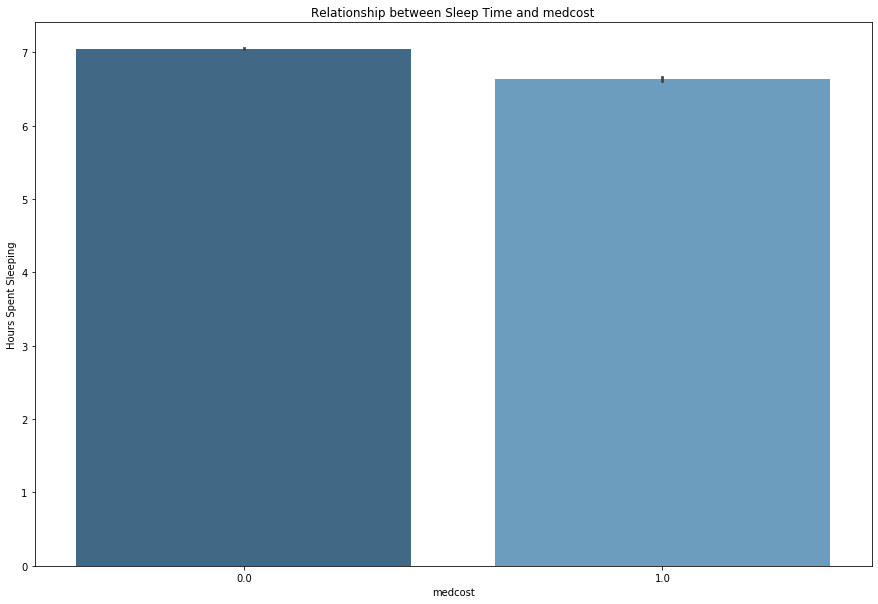

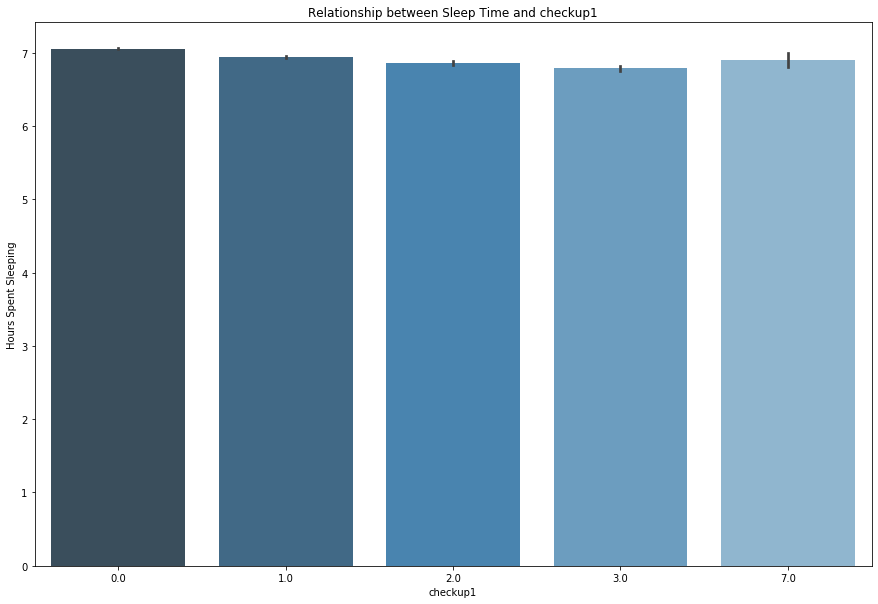

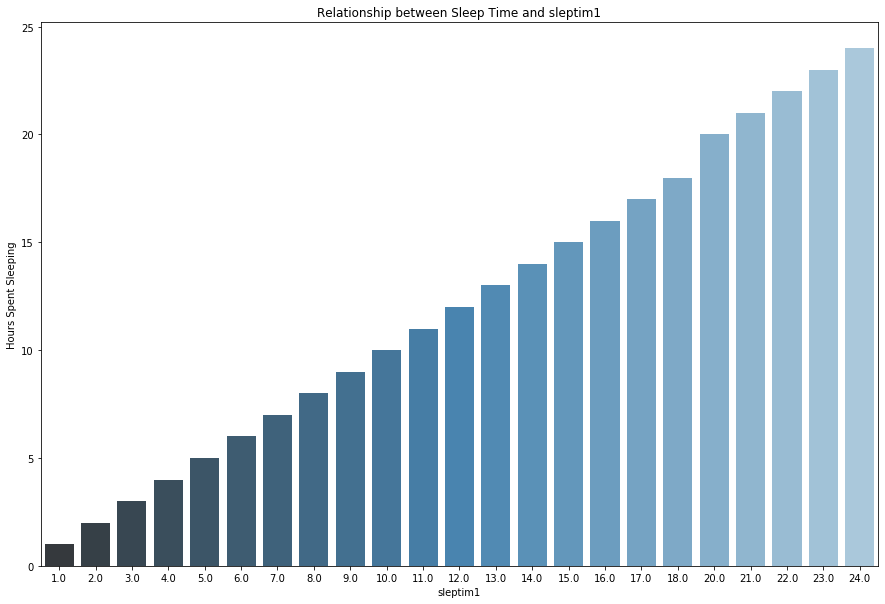

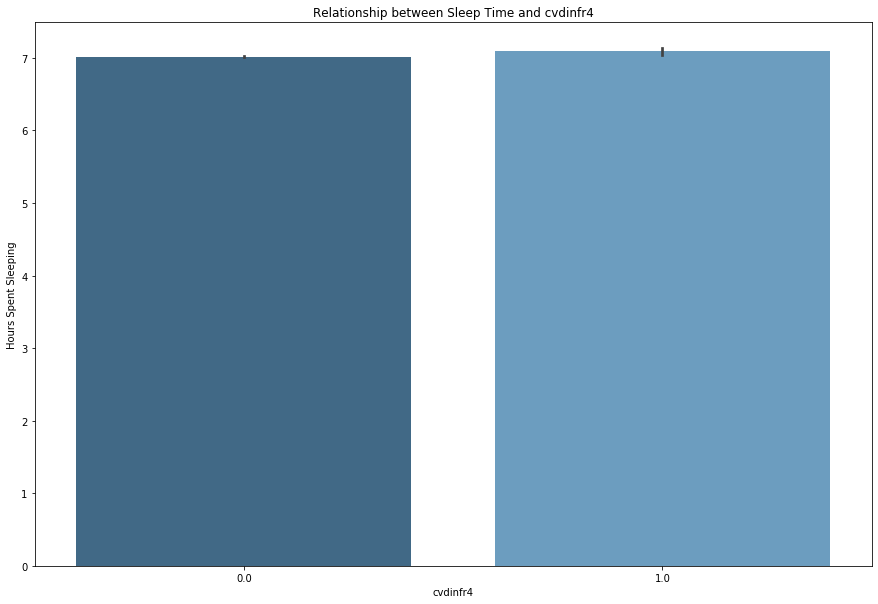

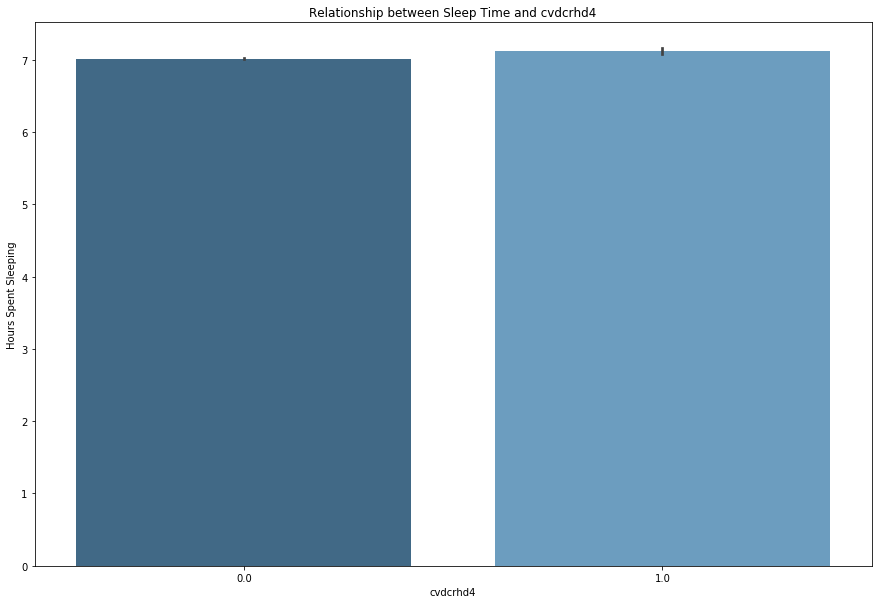

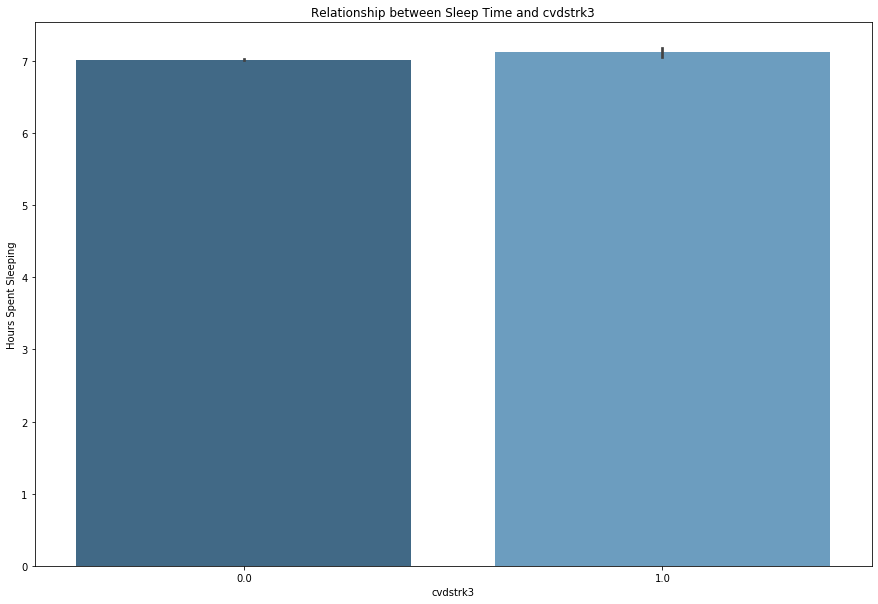

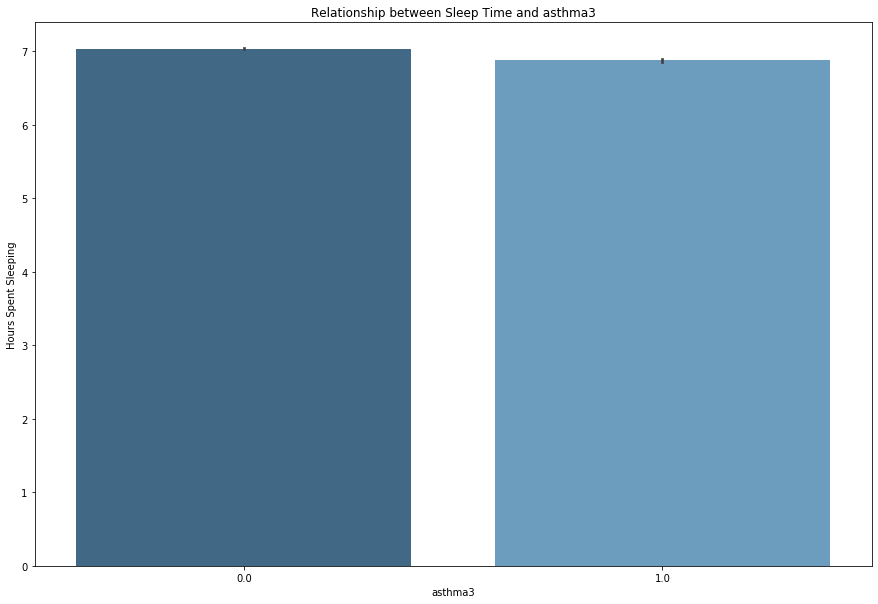

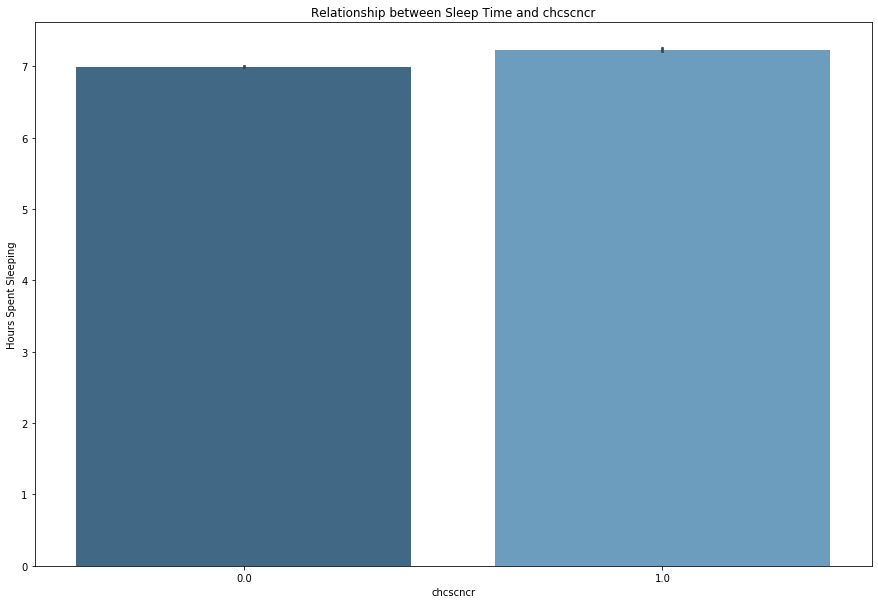

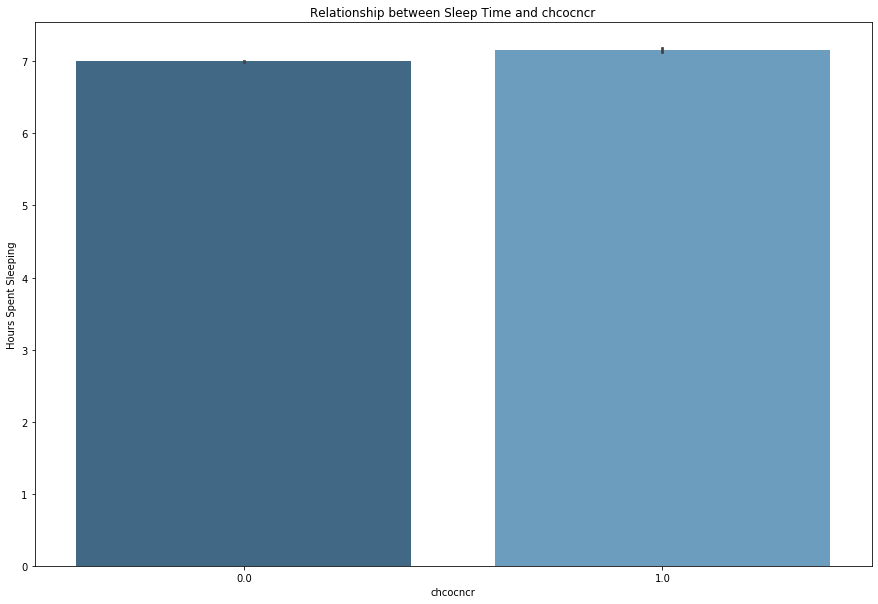

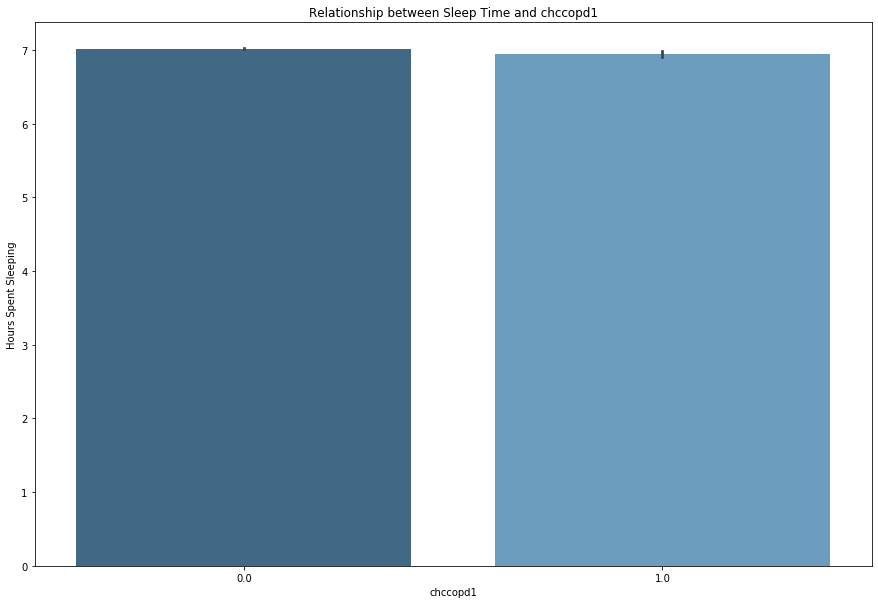

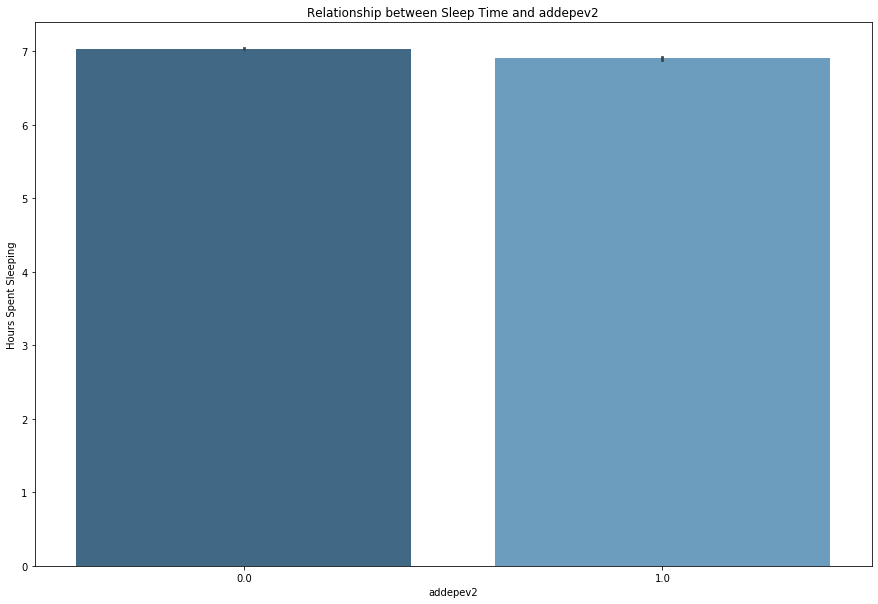

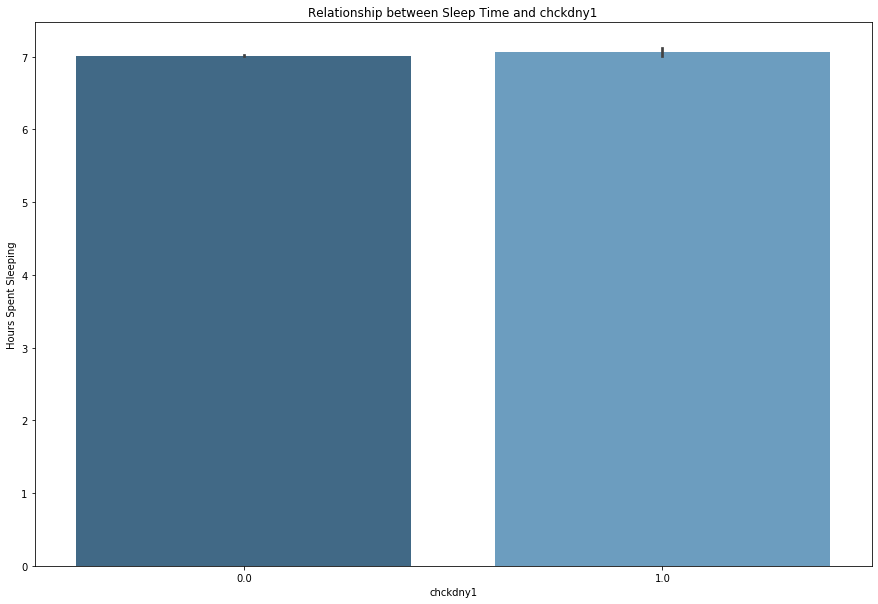

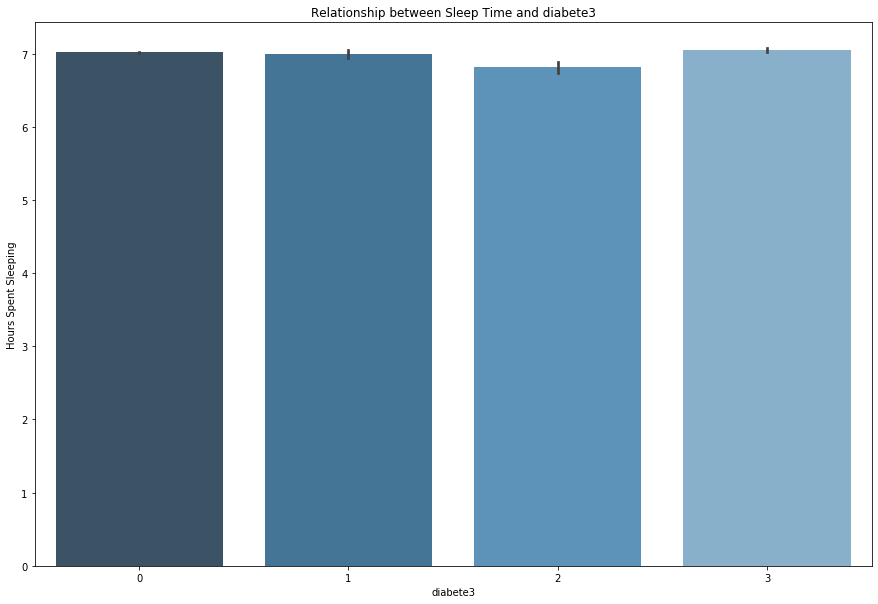

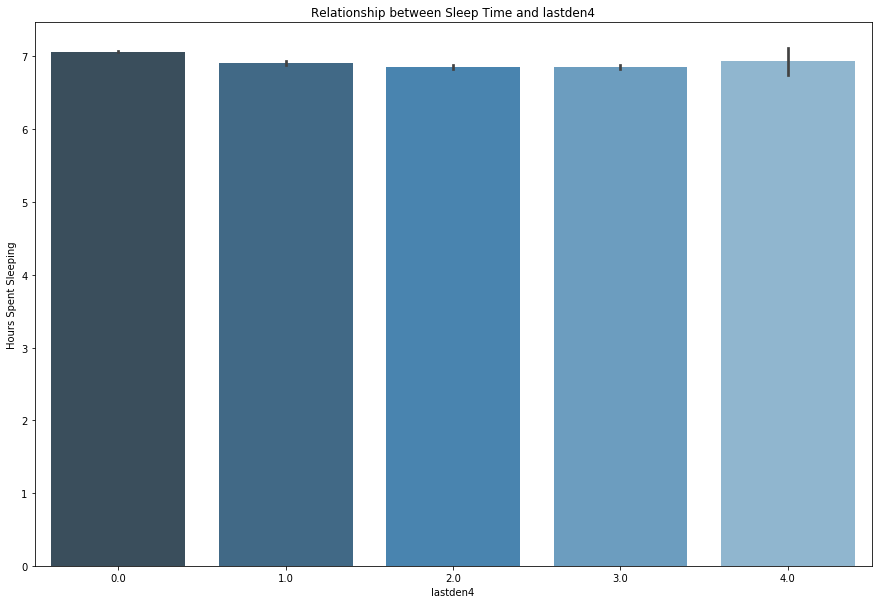

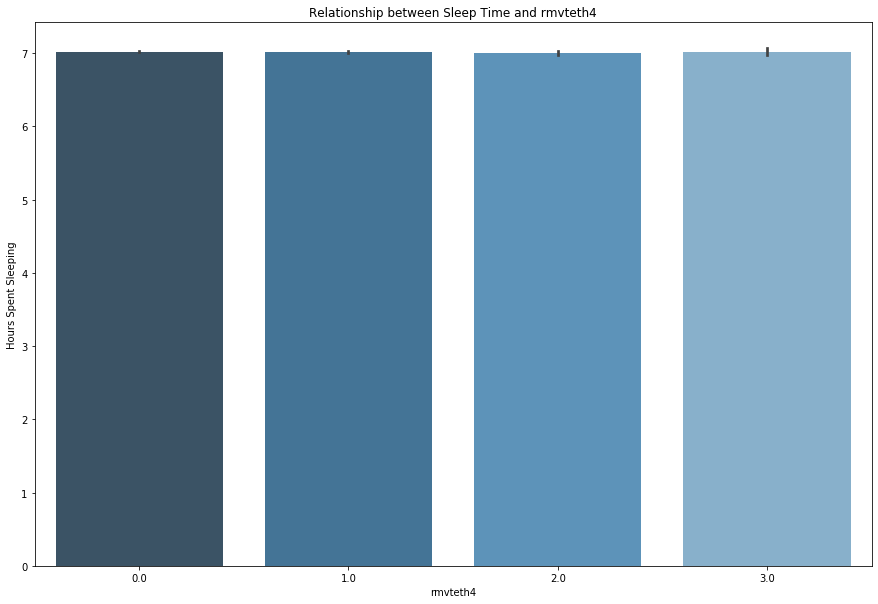

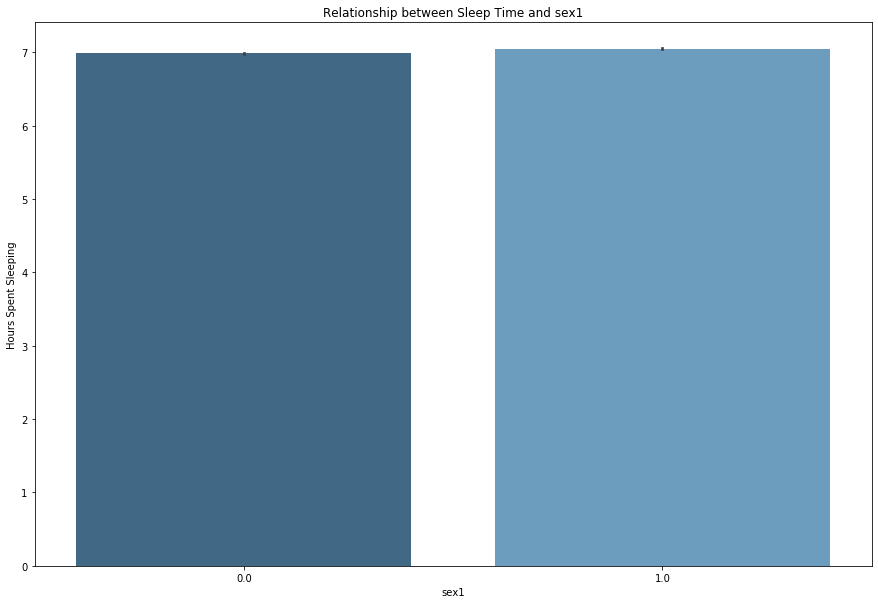

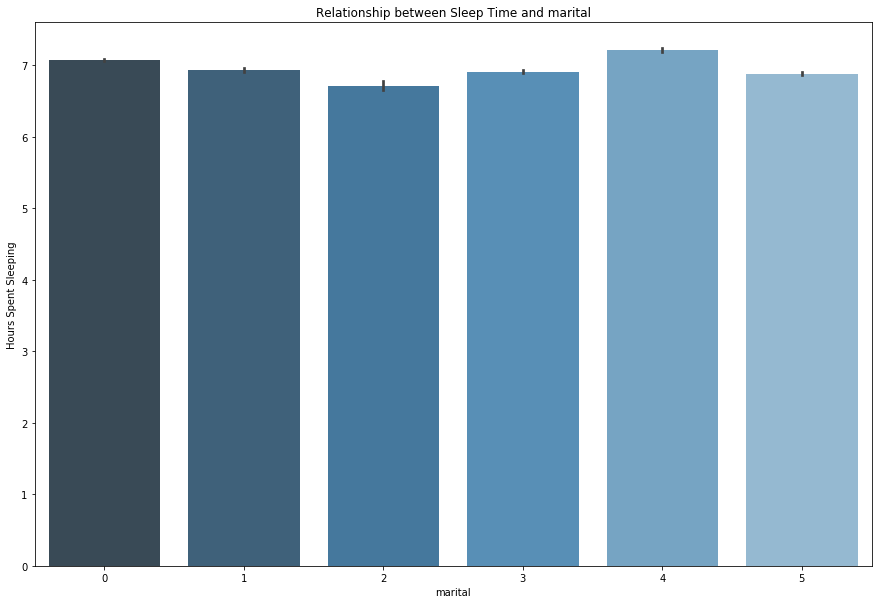

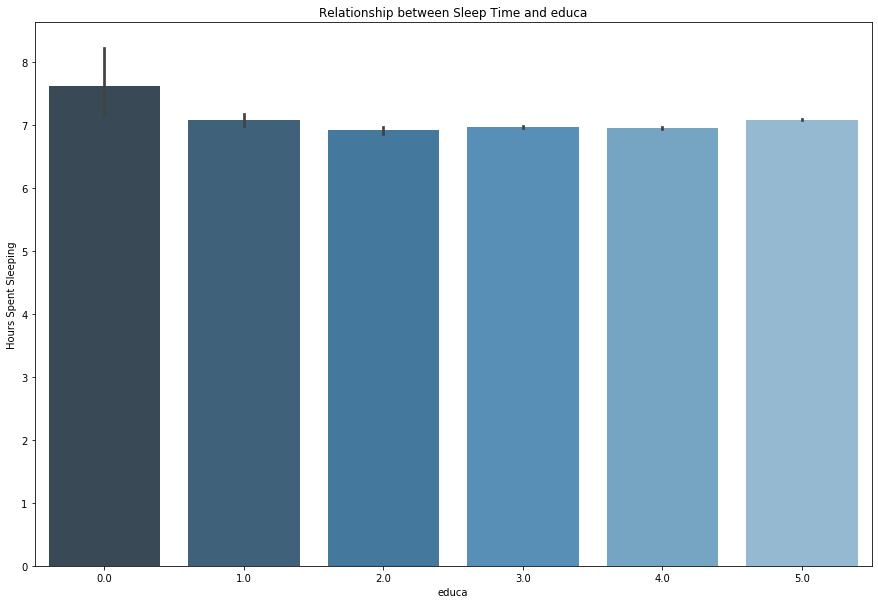

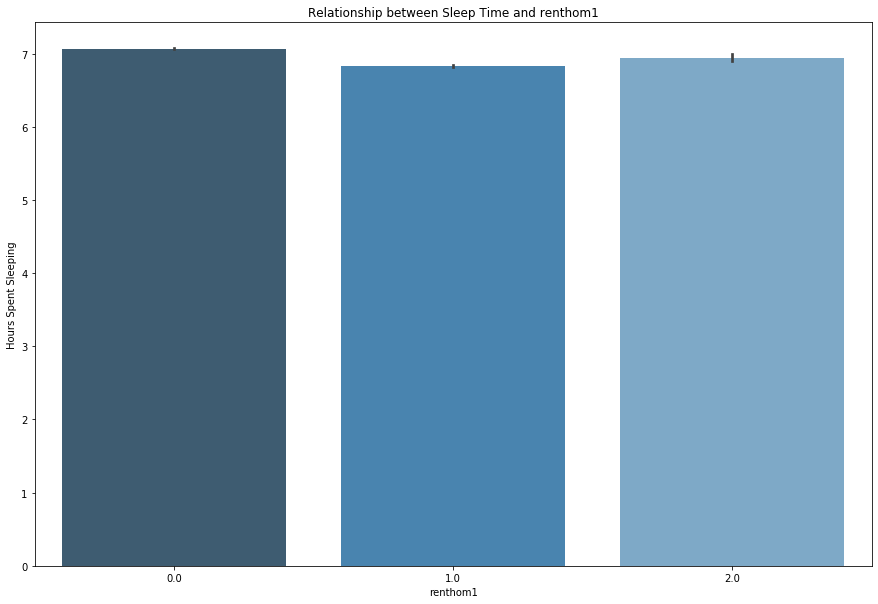

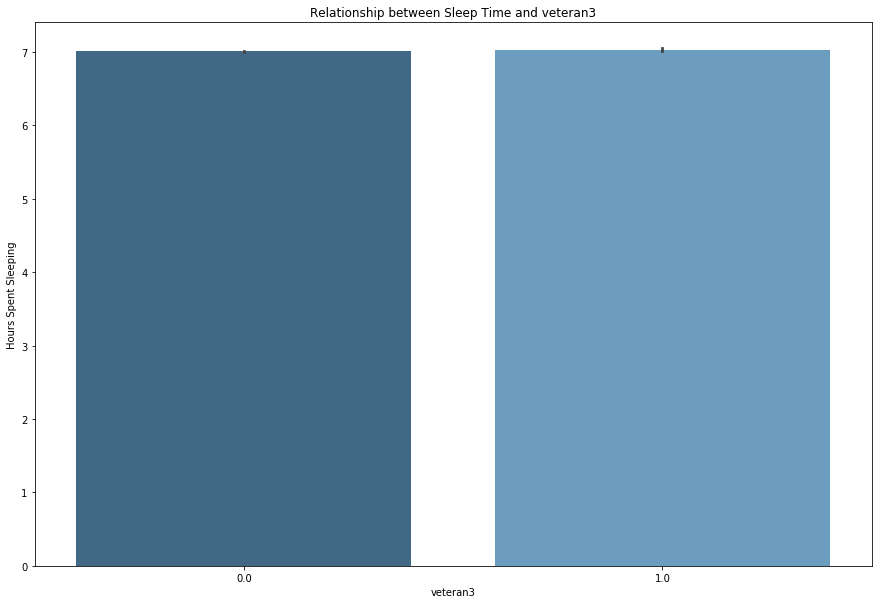

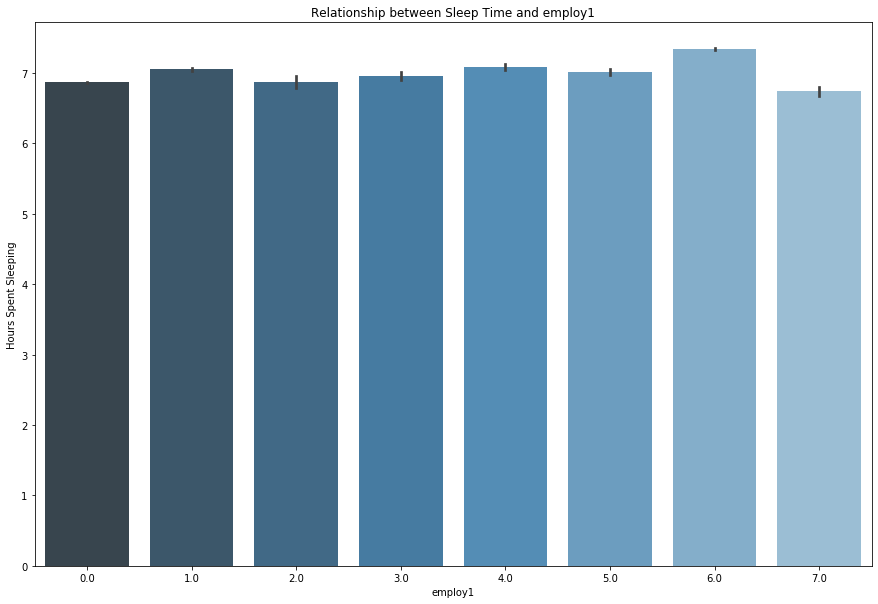

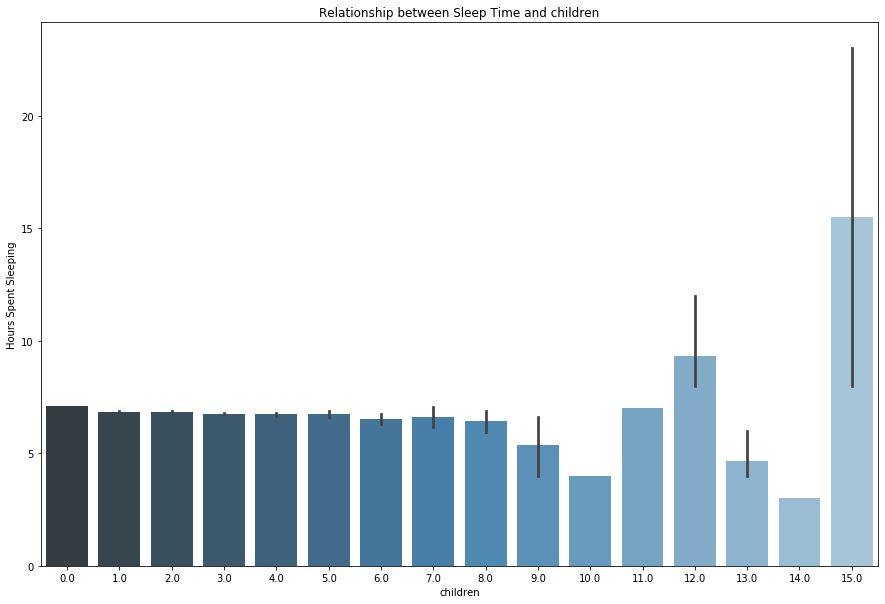

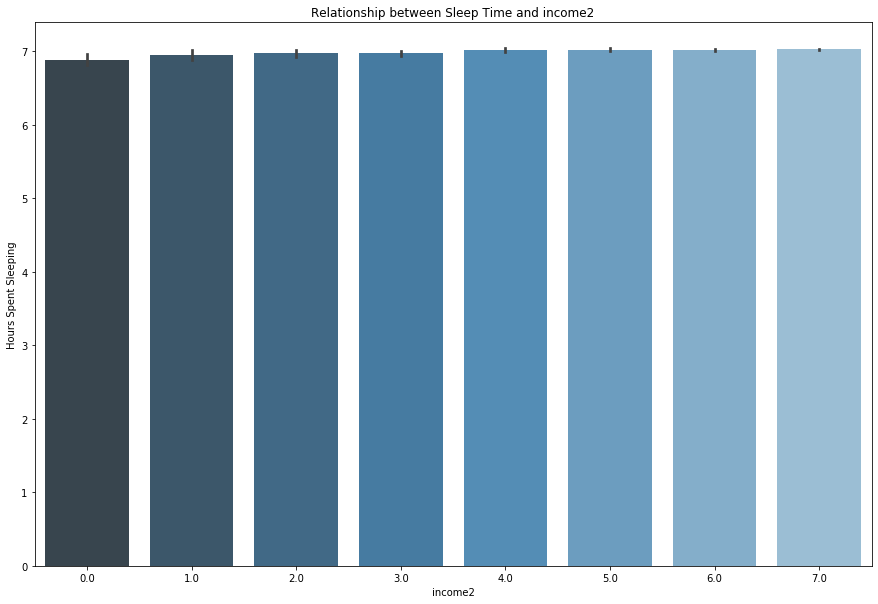

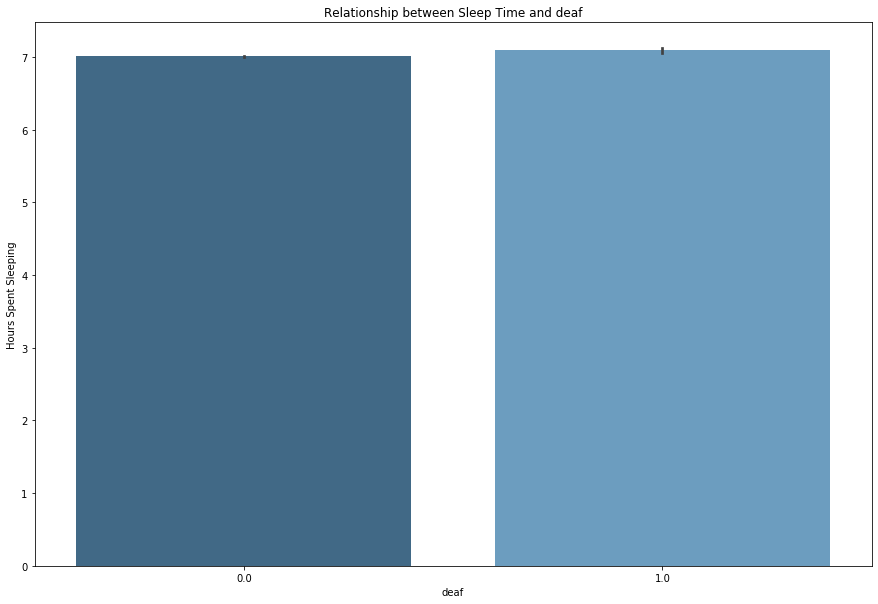

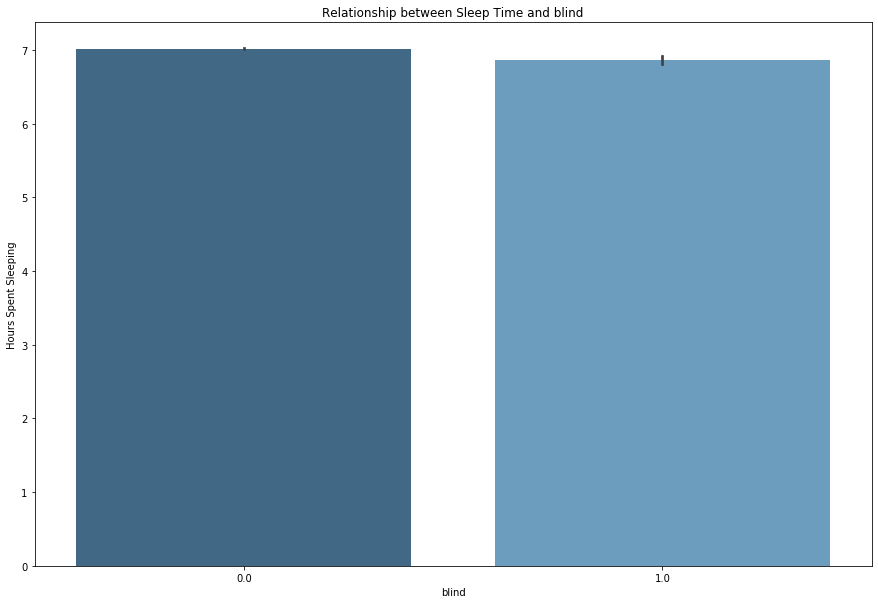

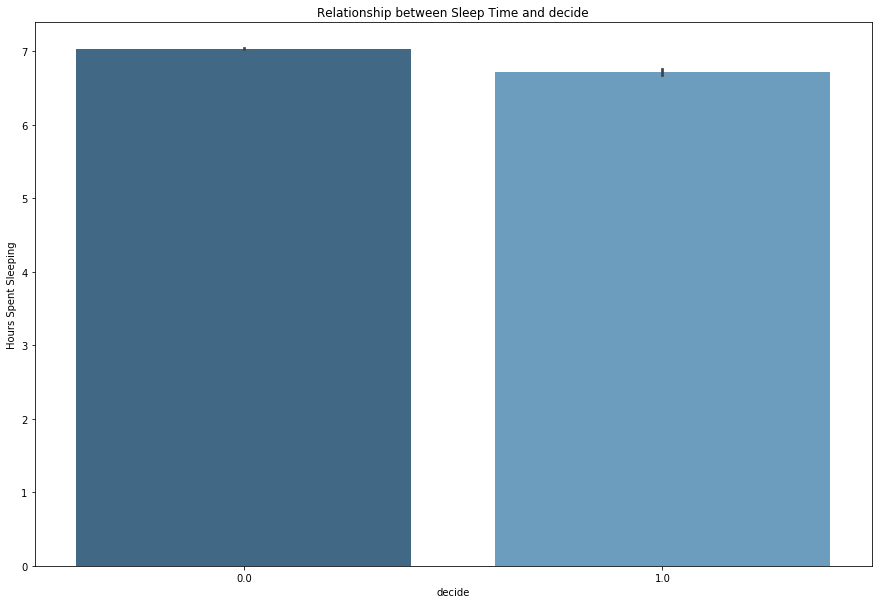

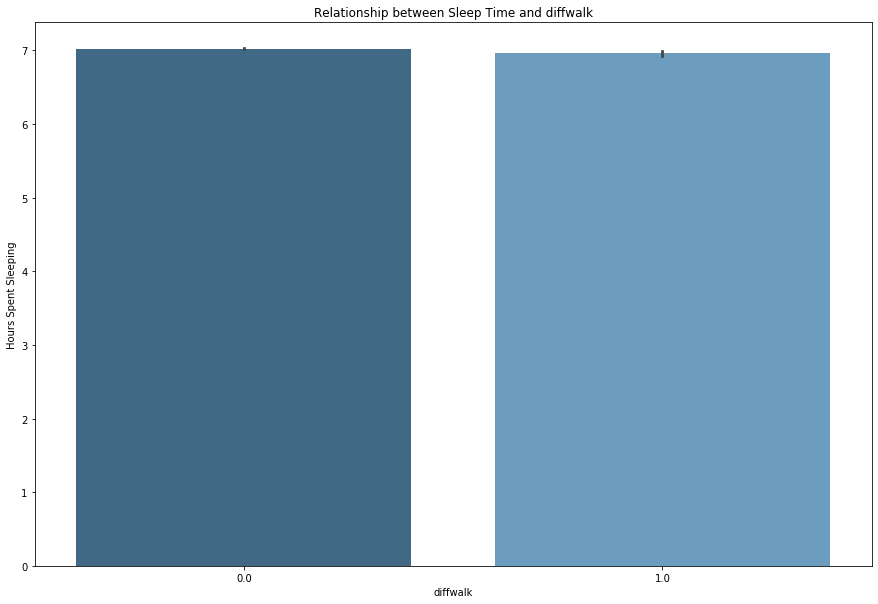

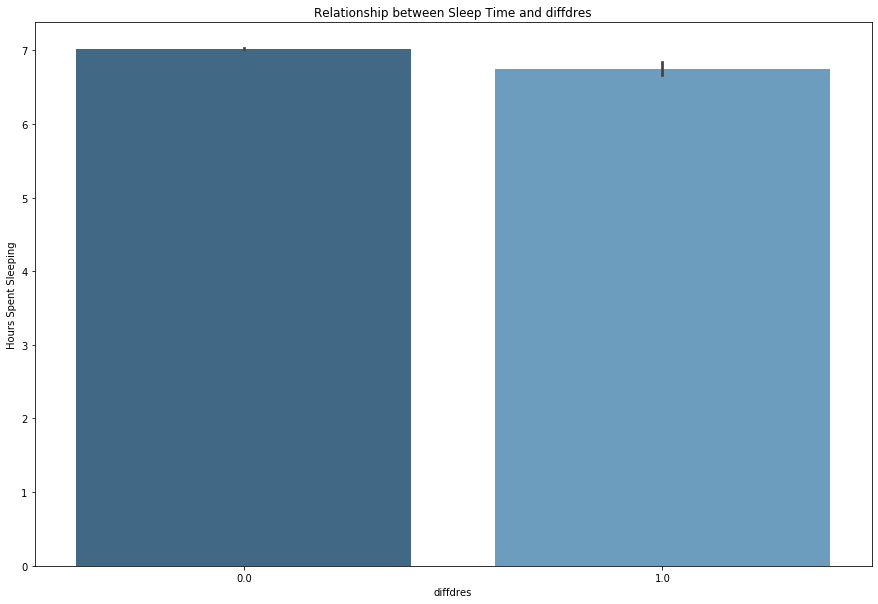

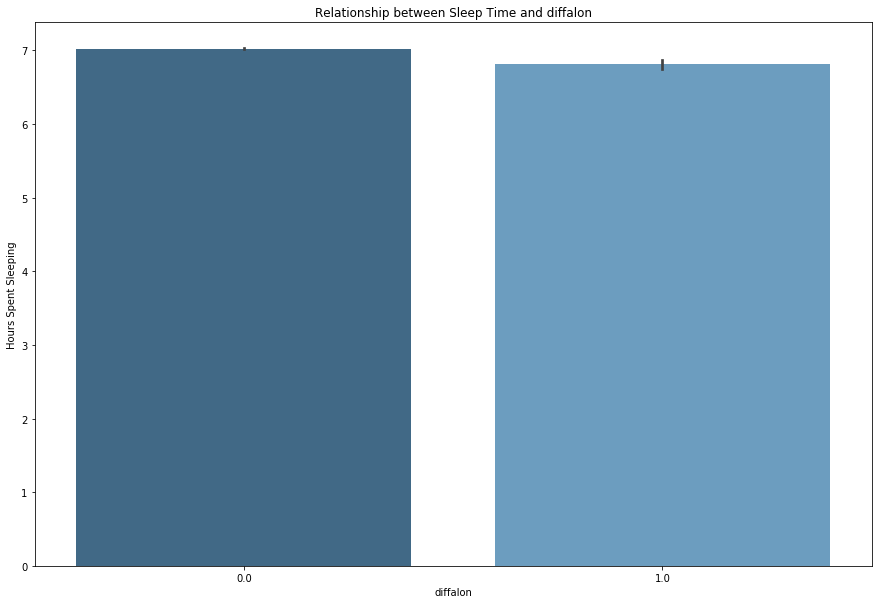

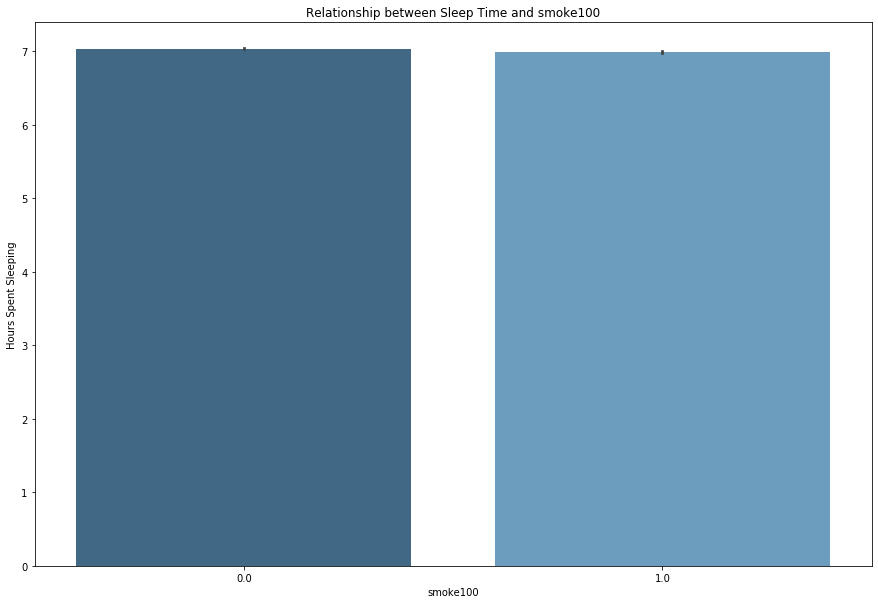

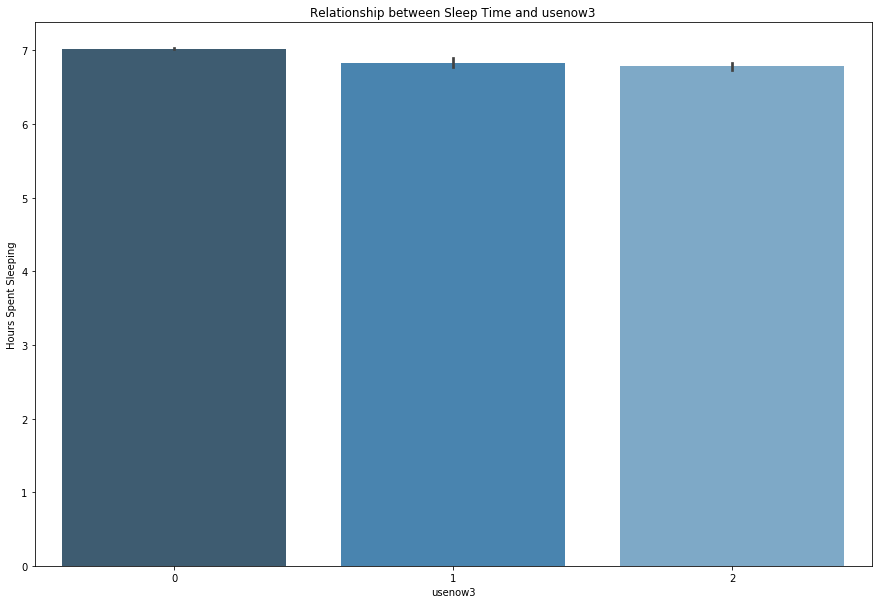

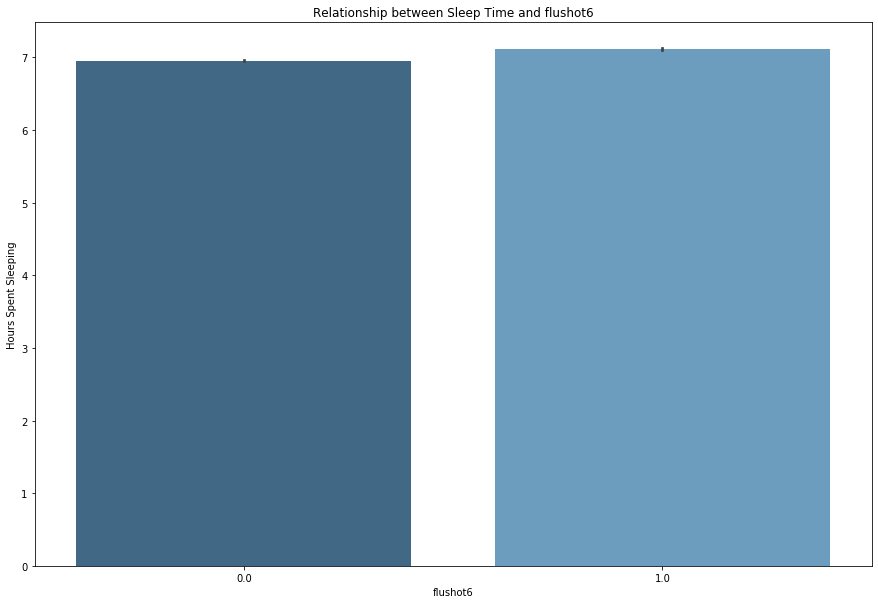

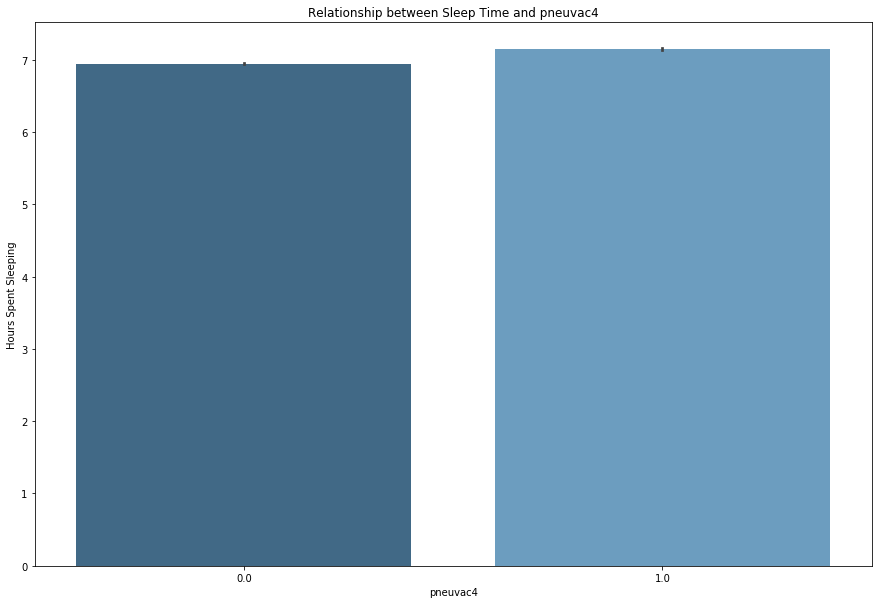

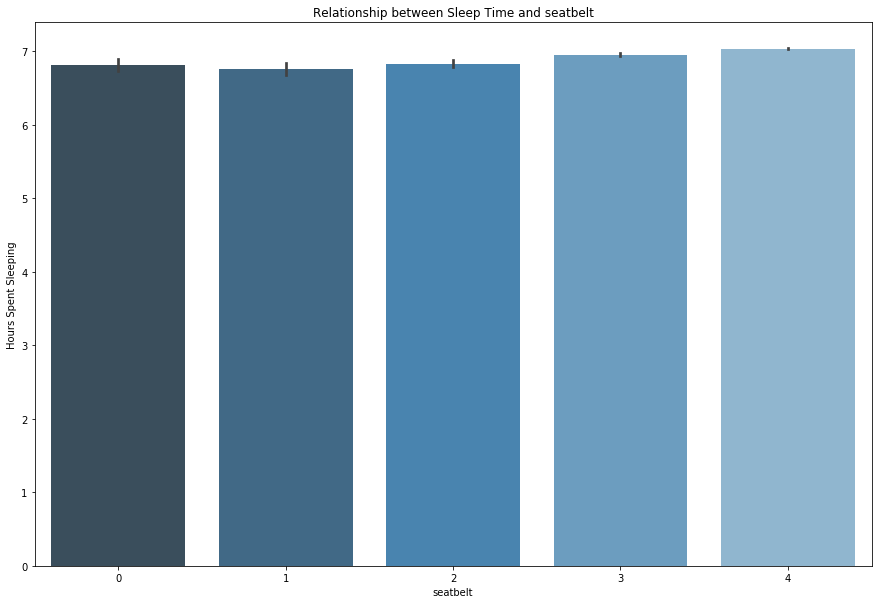

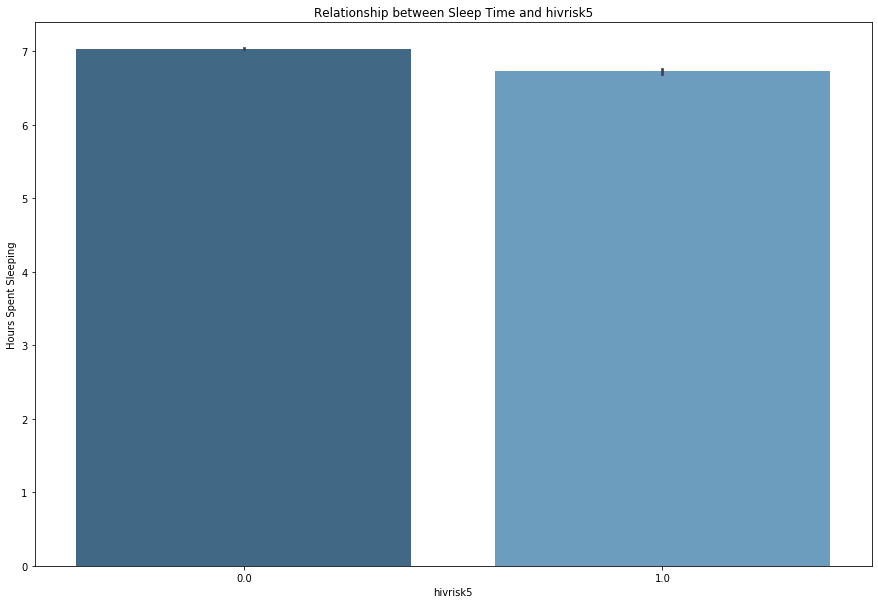

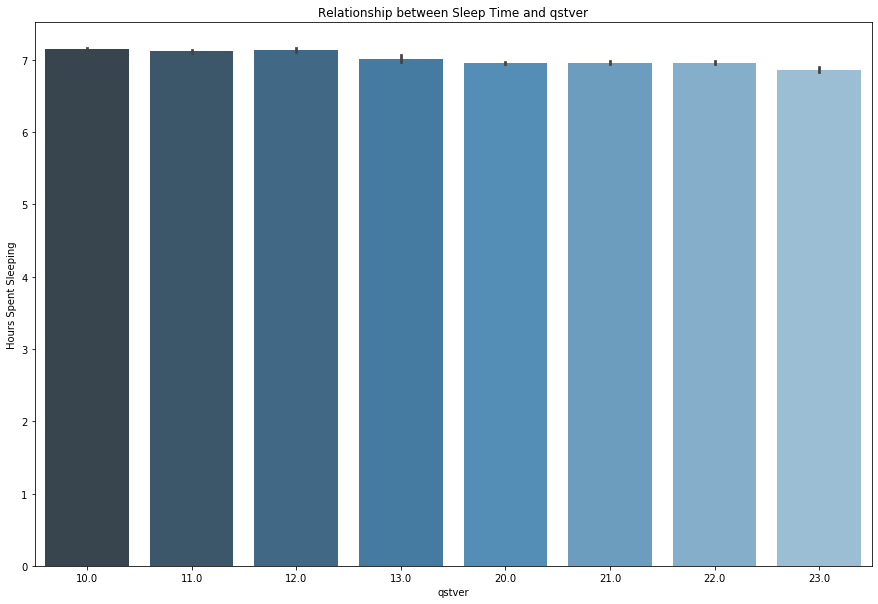

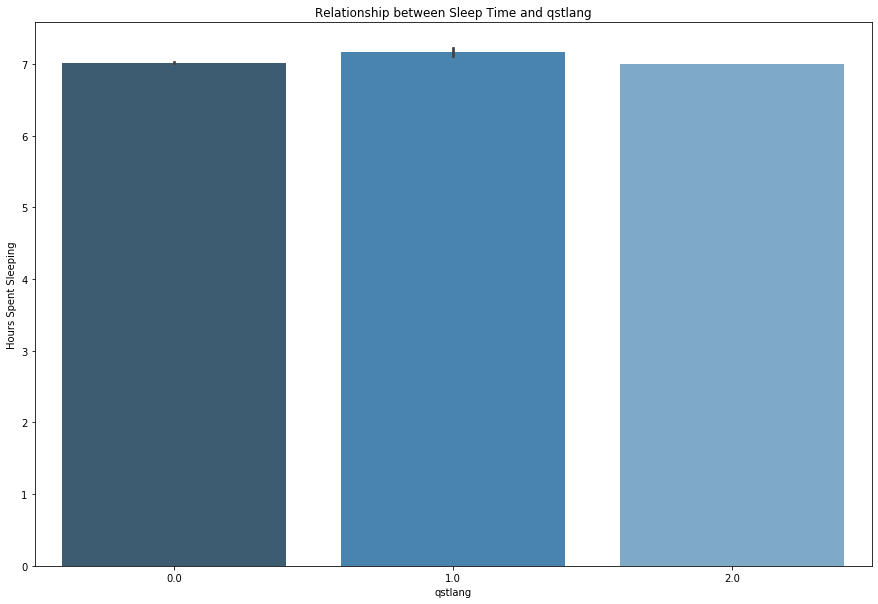

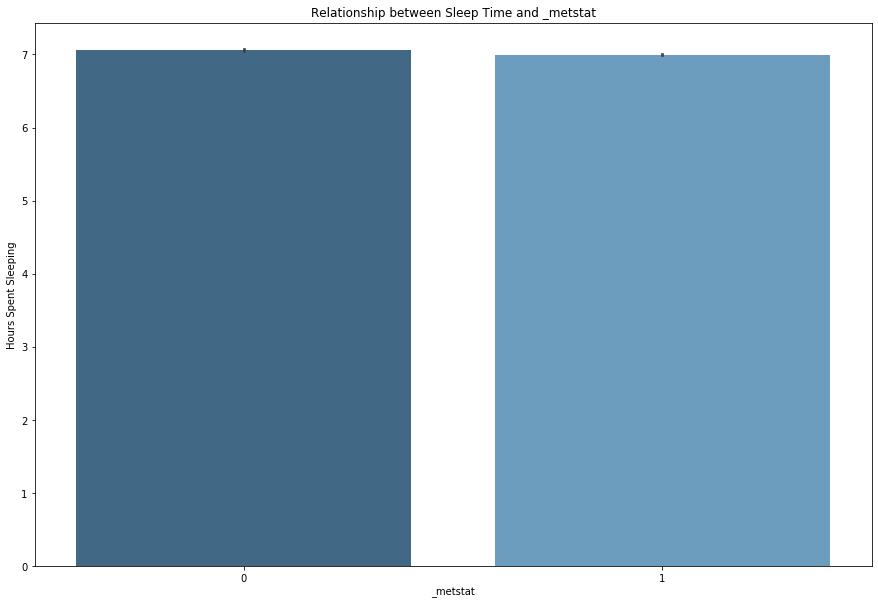

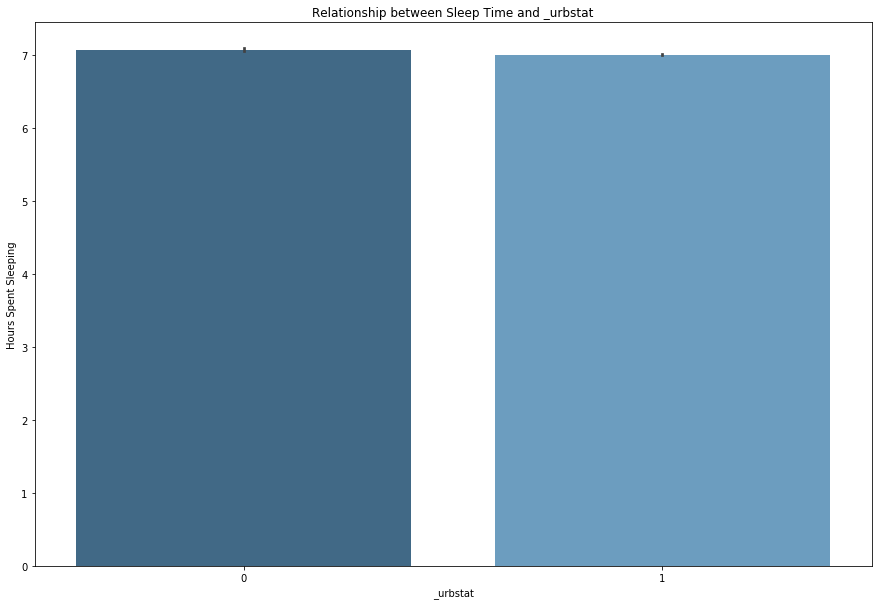

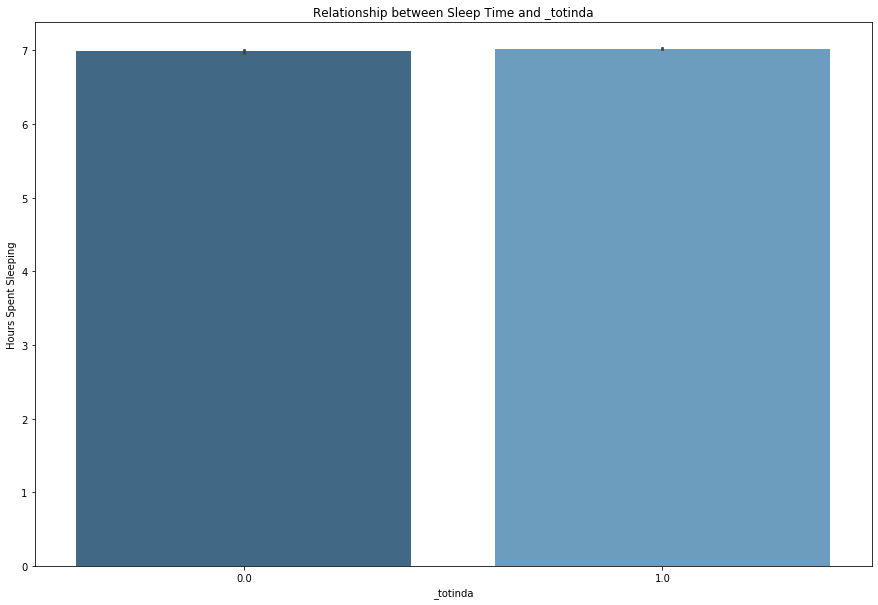

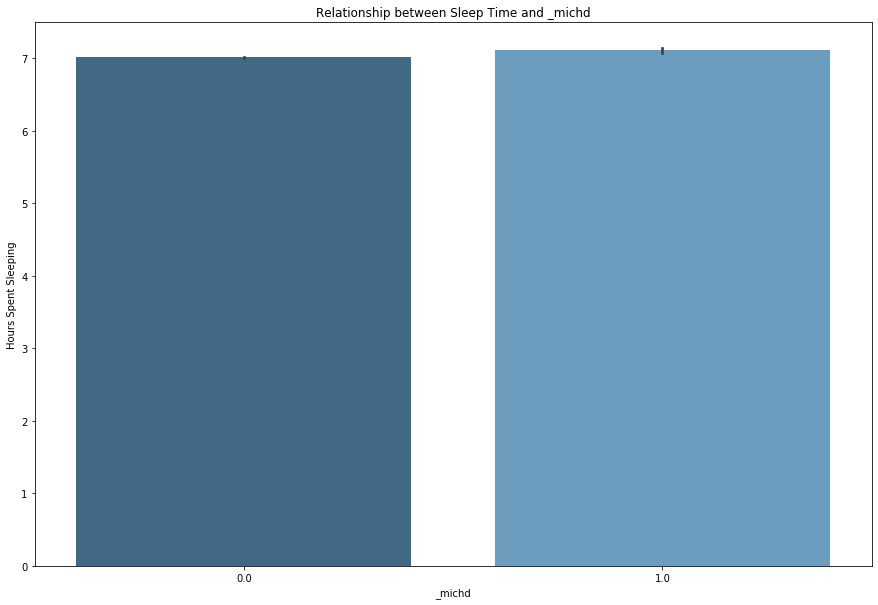

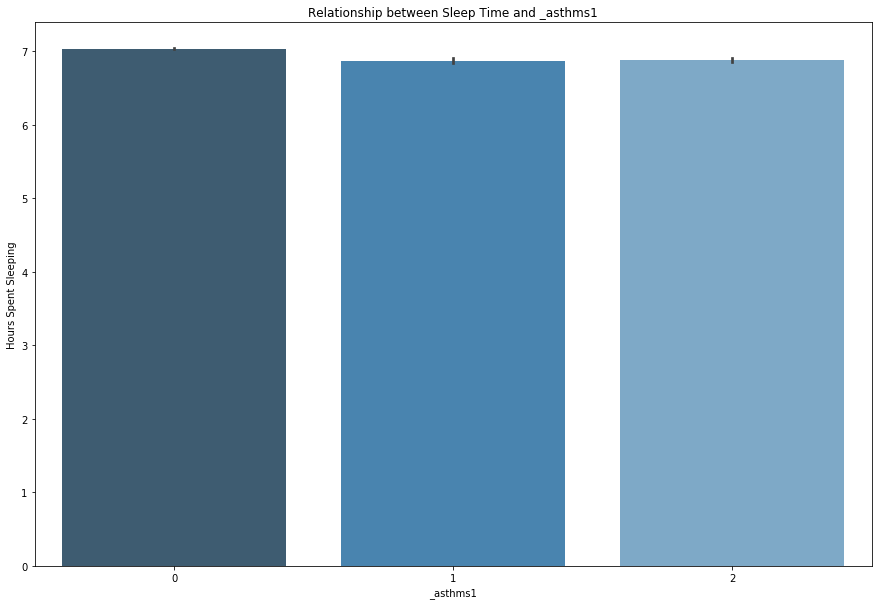

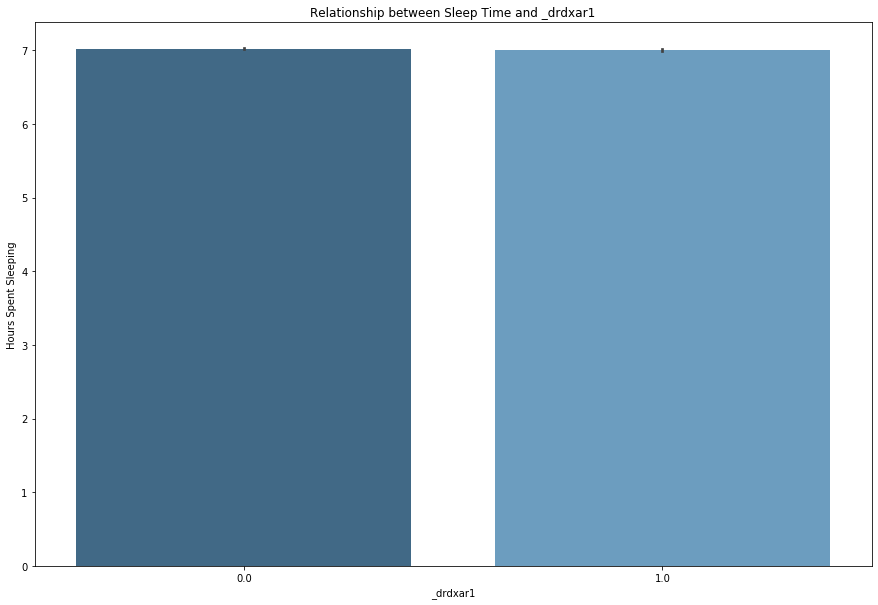

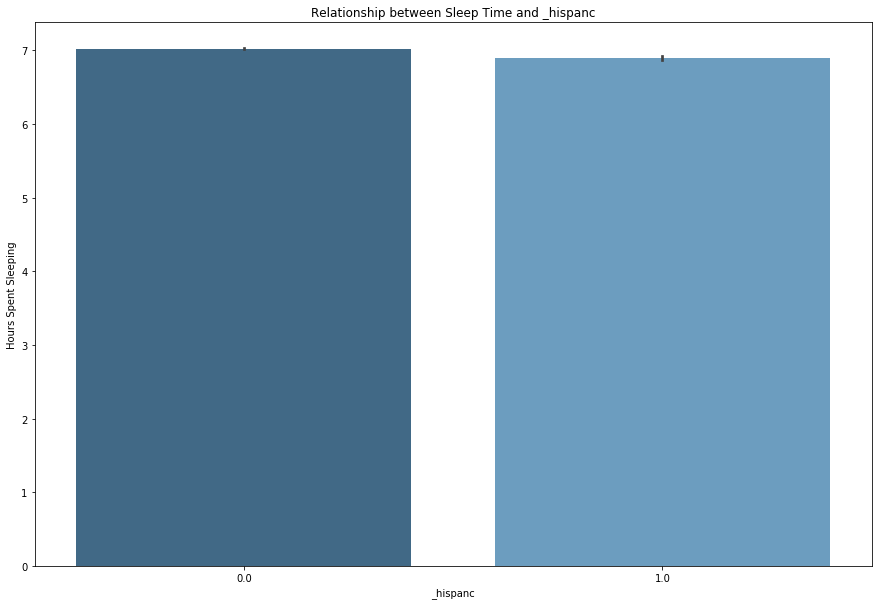

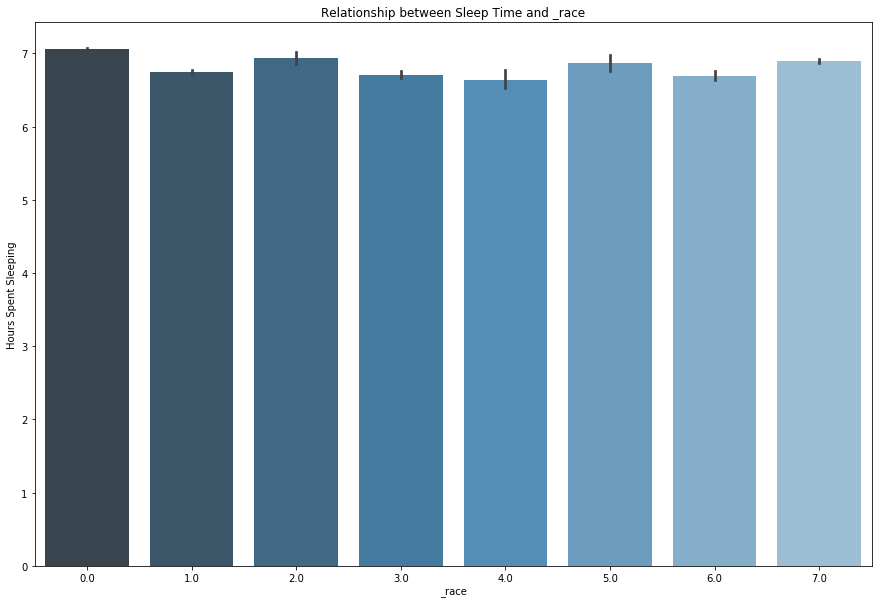

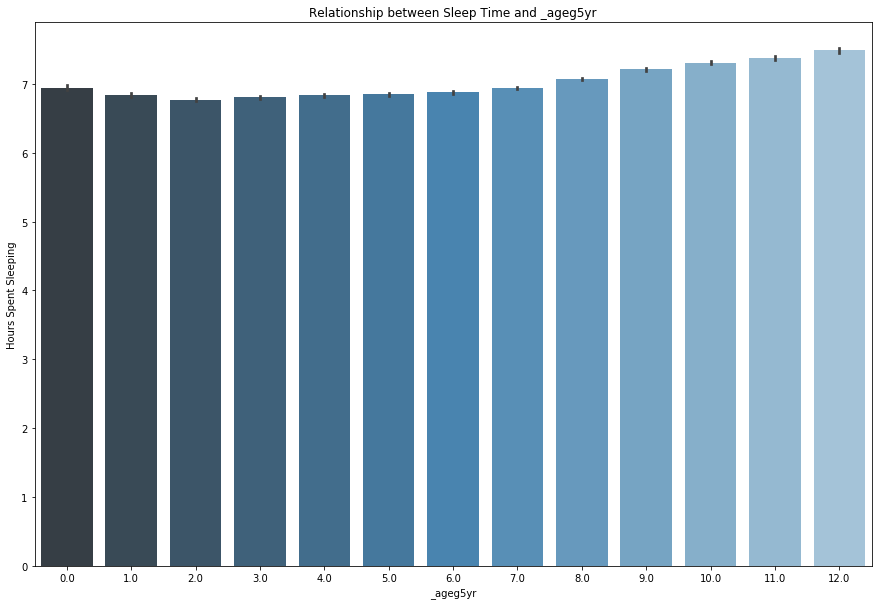

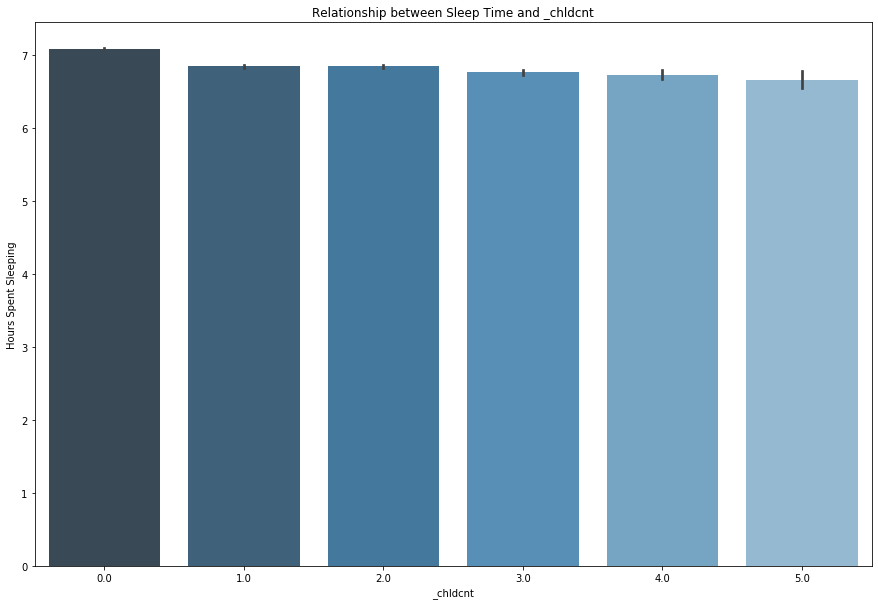

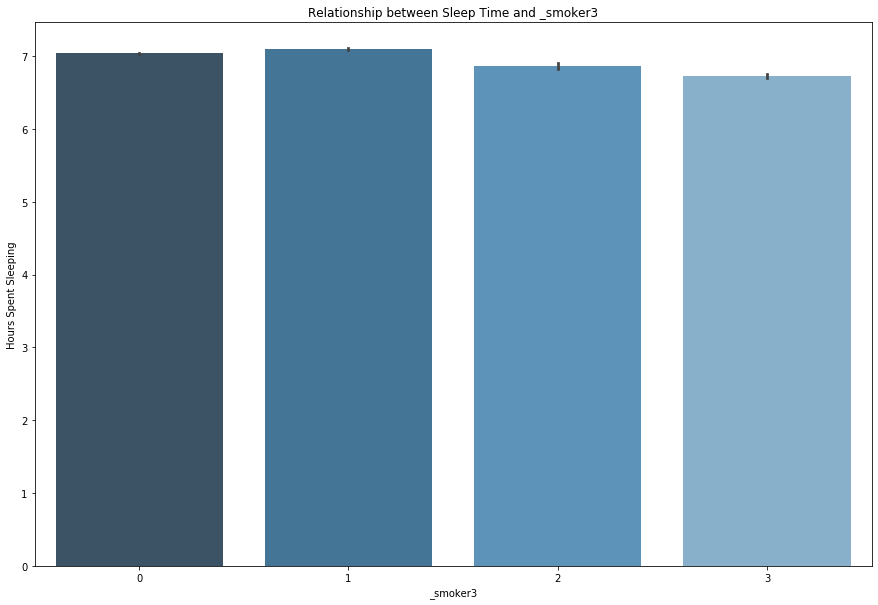

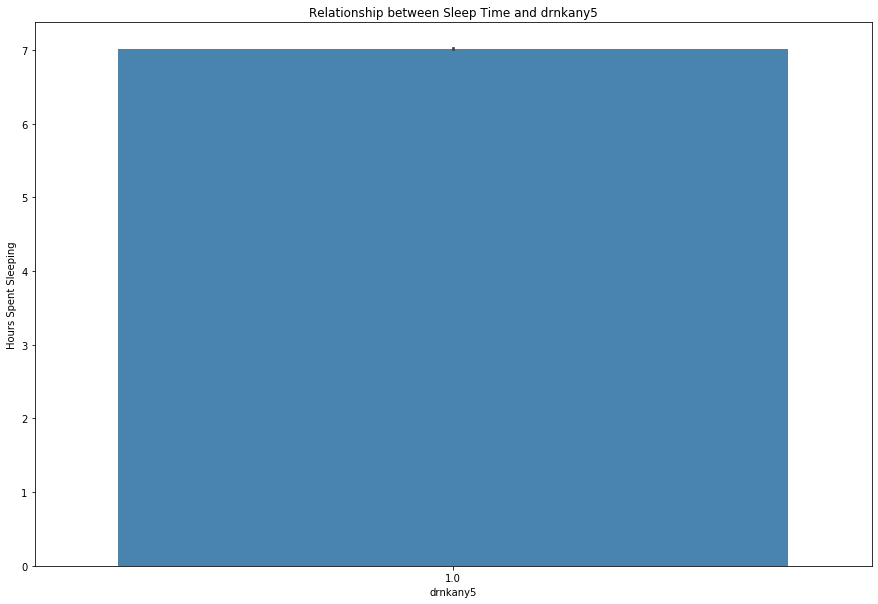

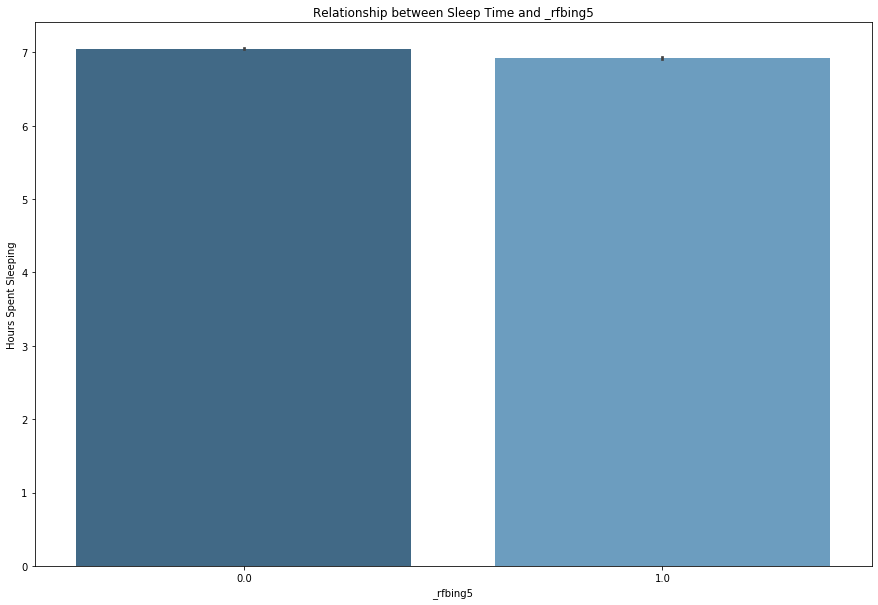

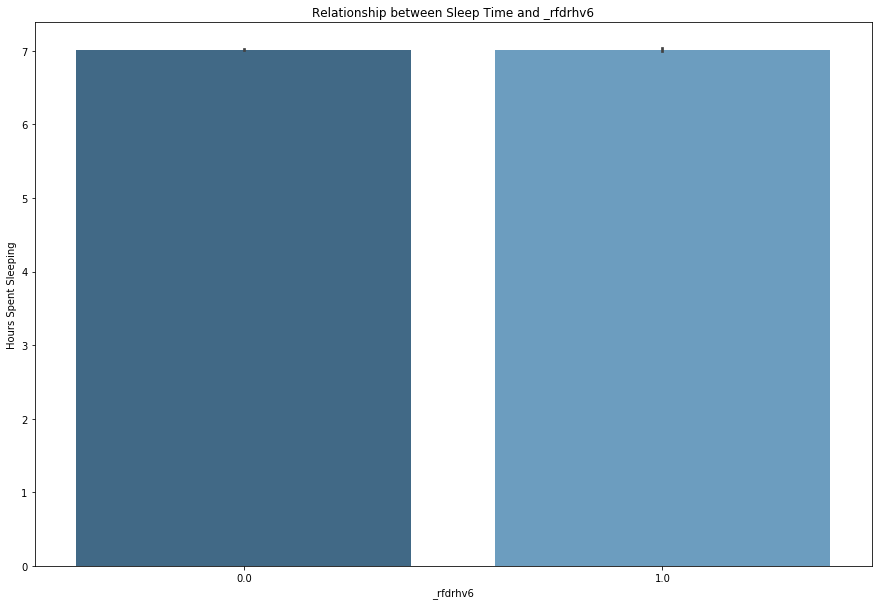

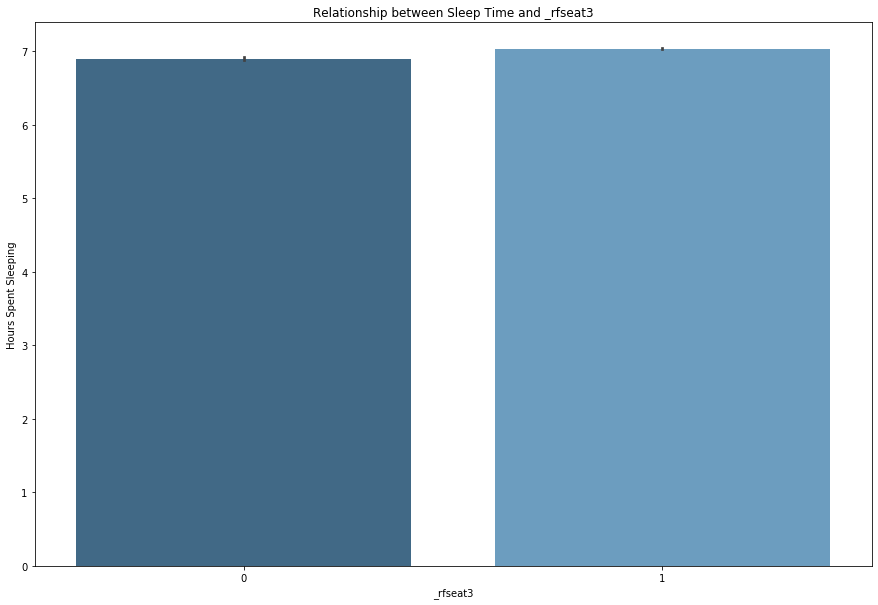

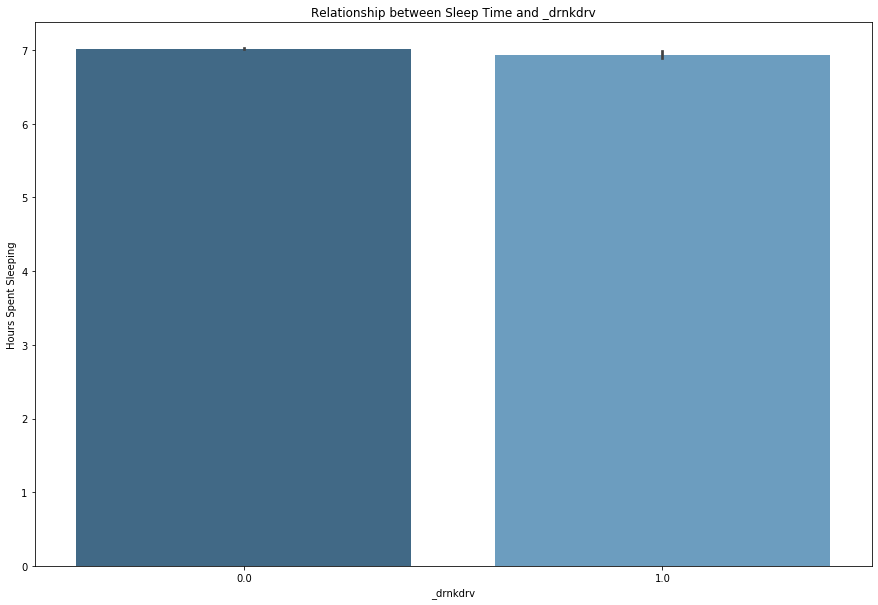

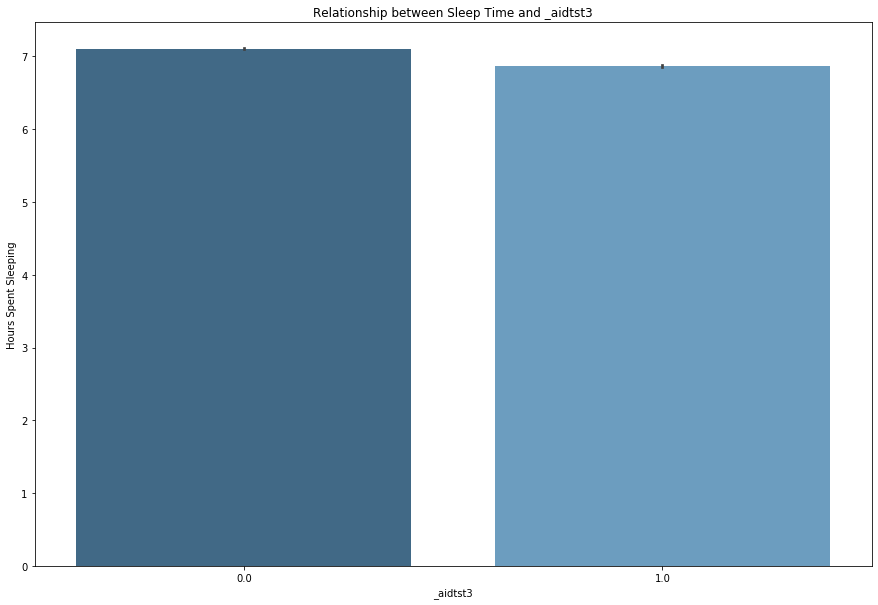

In [103]:
# Let's look at how sleep time may or may not be related to other categorical variables

for col in brfss_desc:
    sns.barplot(x=col, y='sleptim1', palette='Blues_d', data=brfss_desc)
    plt.title('Relationship between Sleep Time and {}'.format(col))
    plt.xlabel('{}'.format(col))
    plt.ylabel('Hours Spent Sleeping')
    
    plt.gcf().set_size_inches(15, 10)

    
    plt.show()



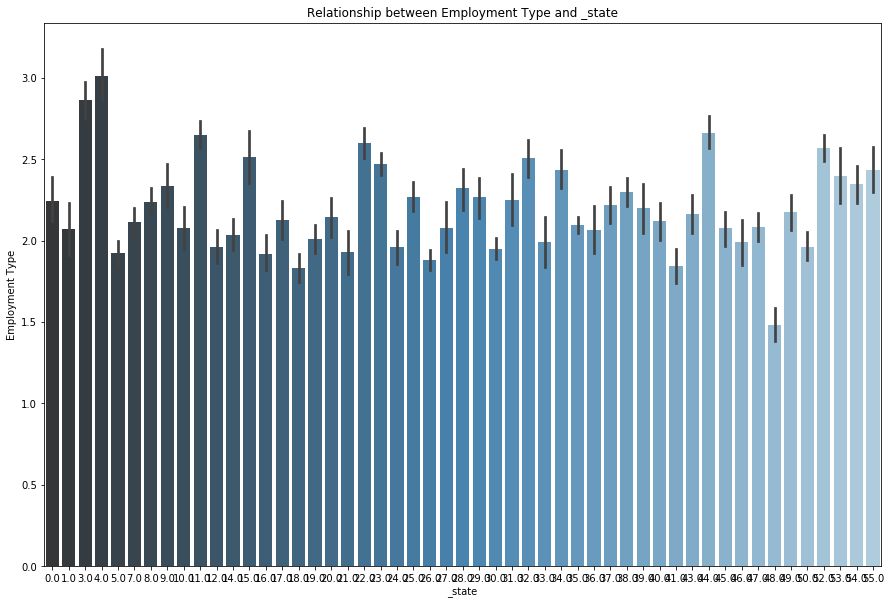

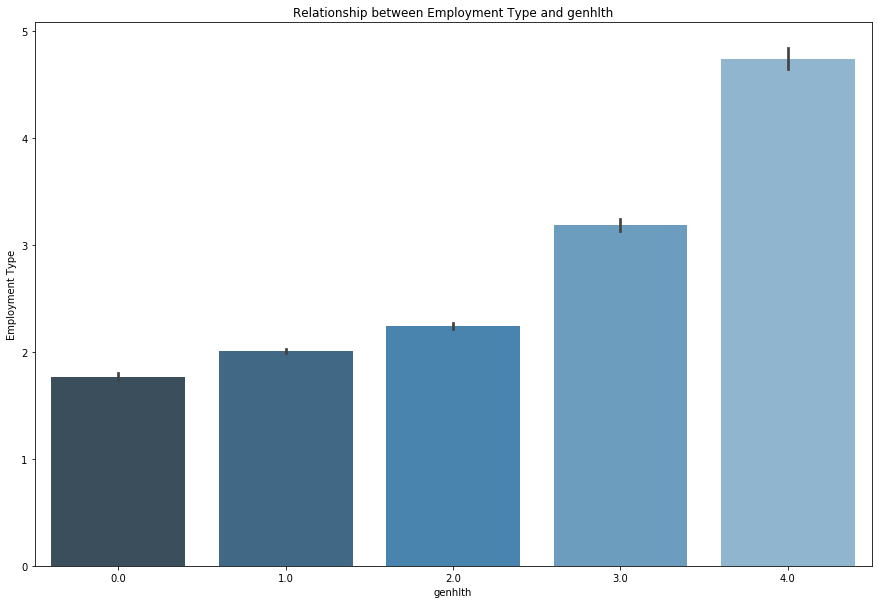

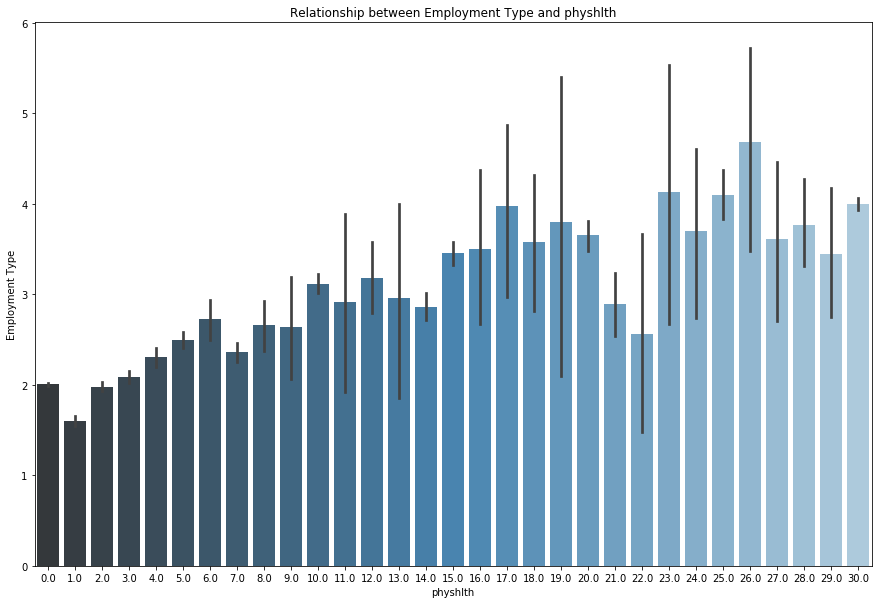

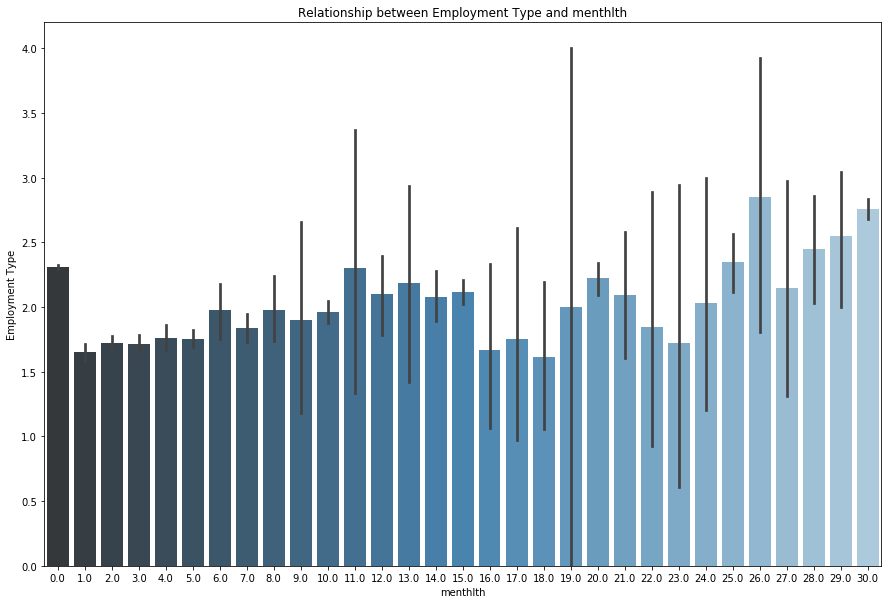

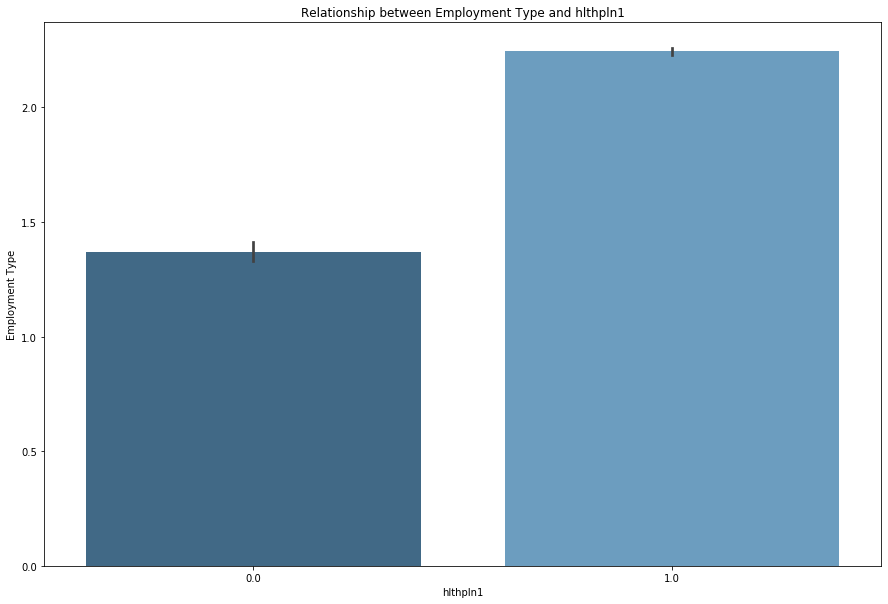

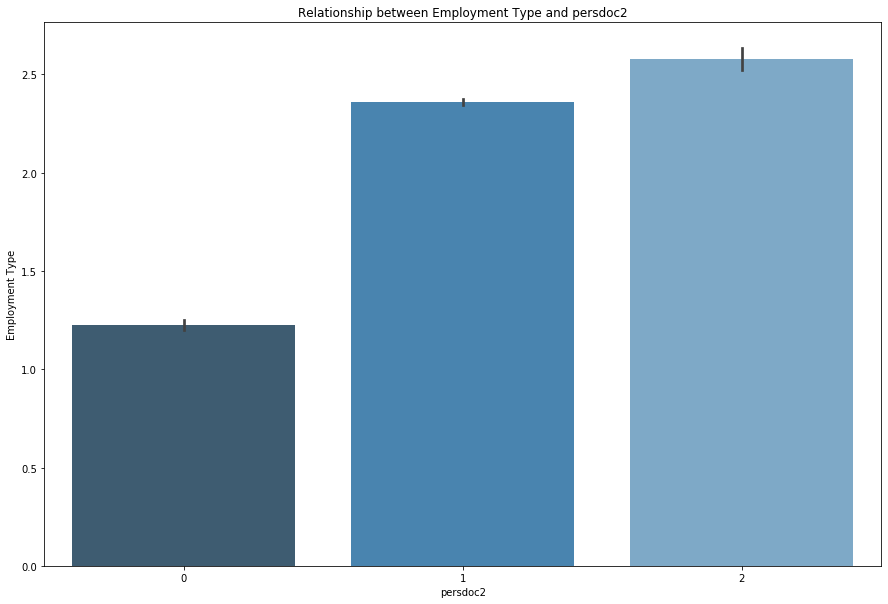

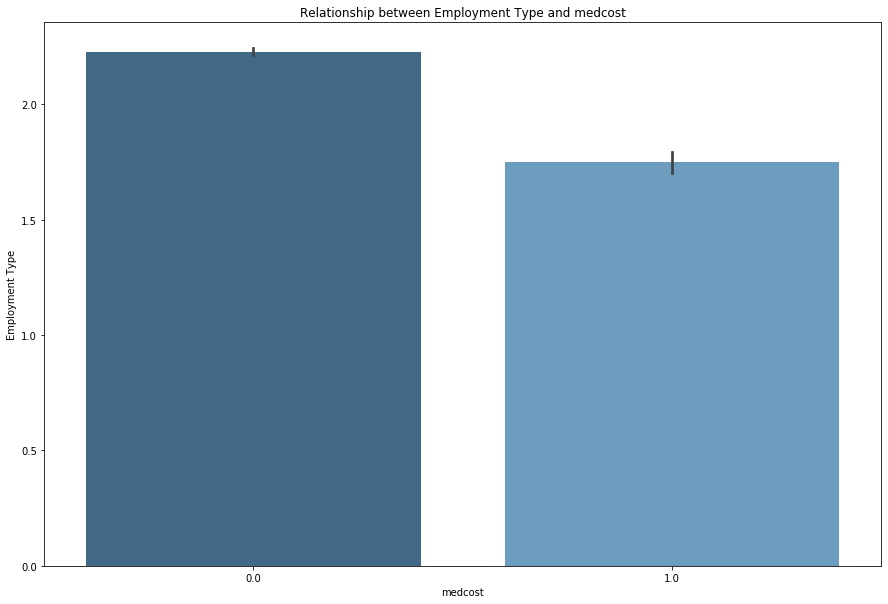

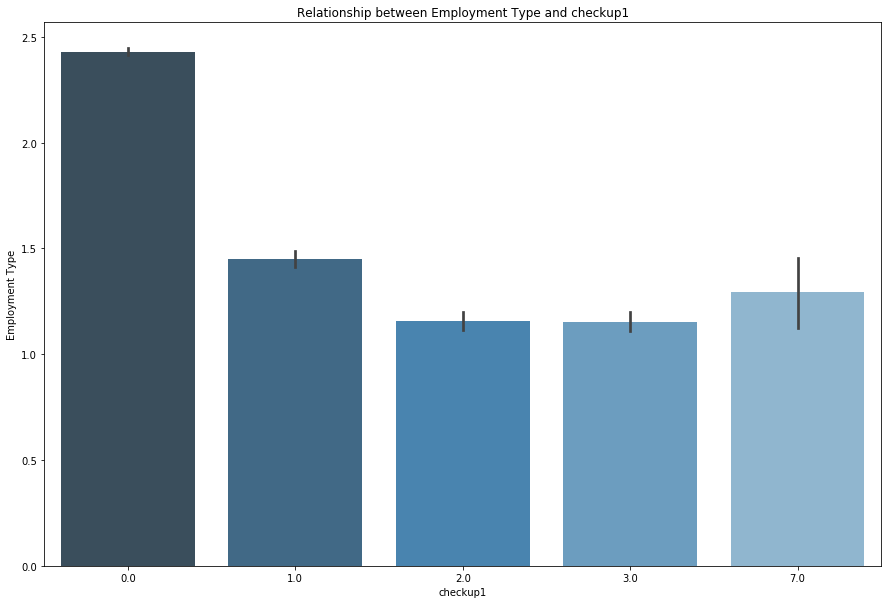

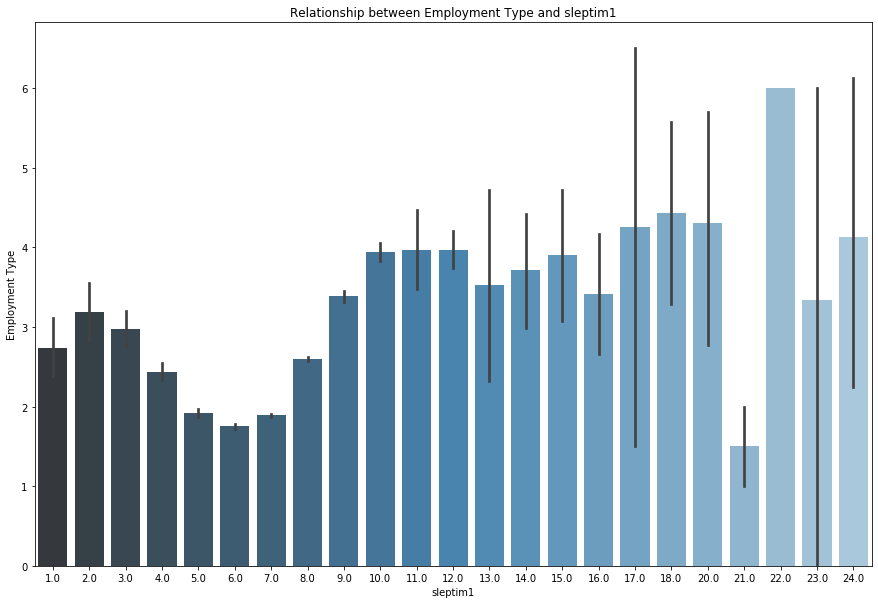

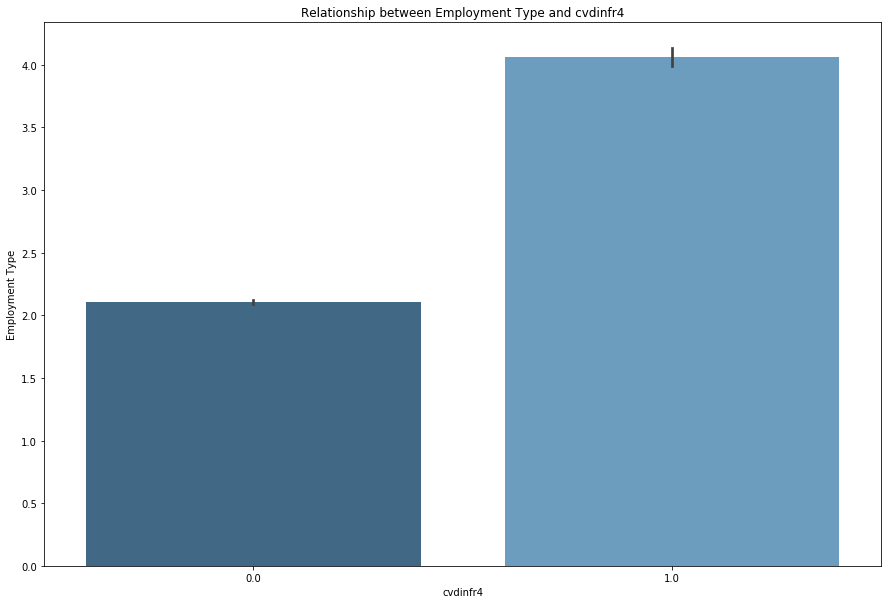

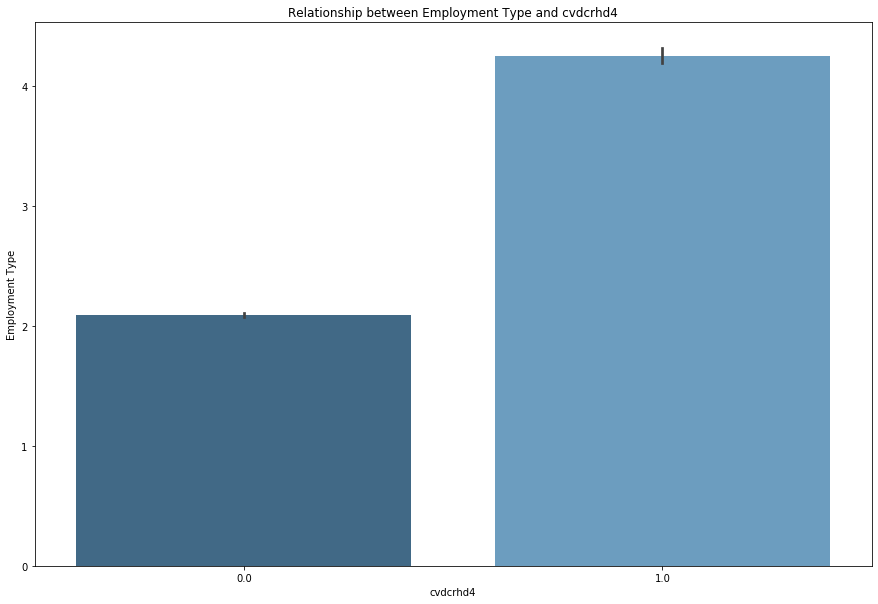

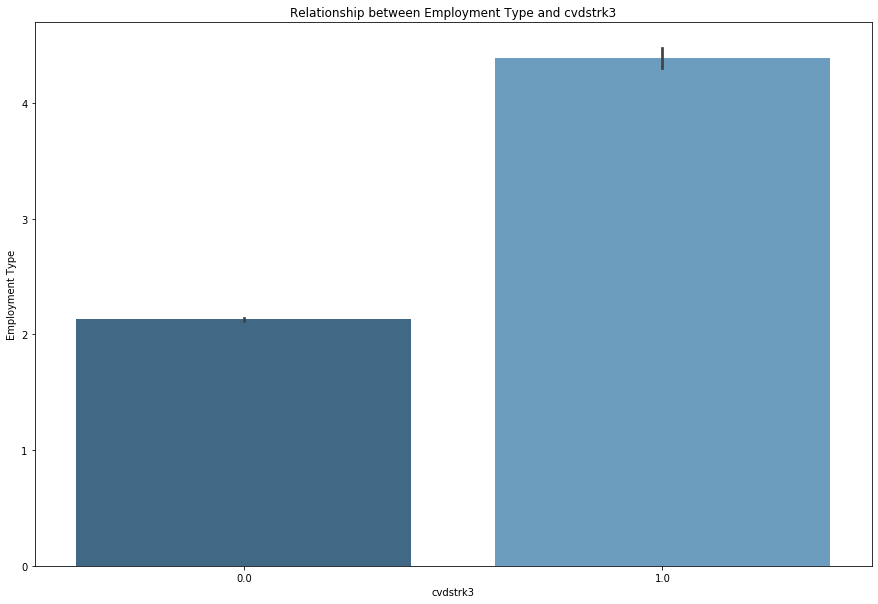

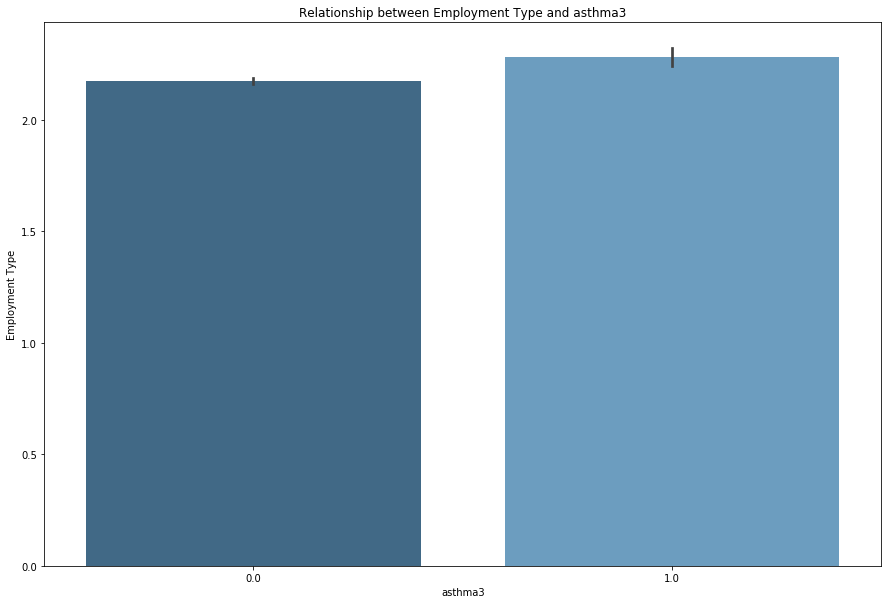

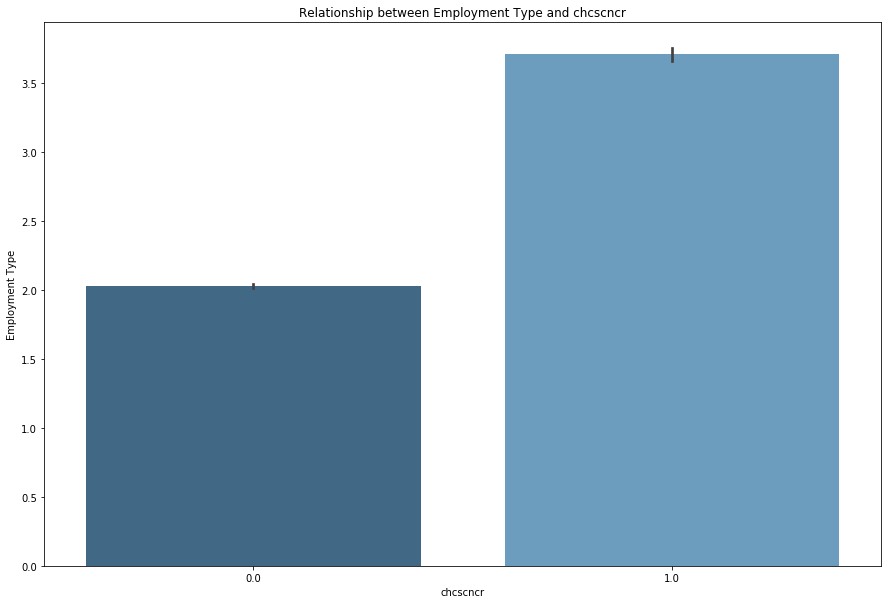

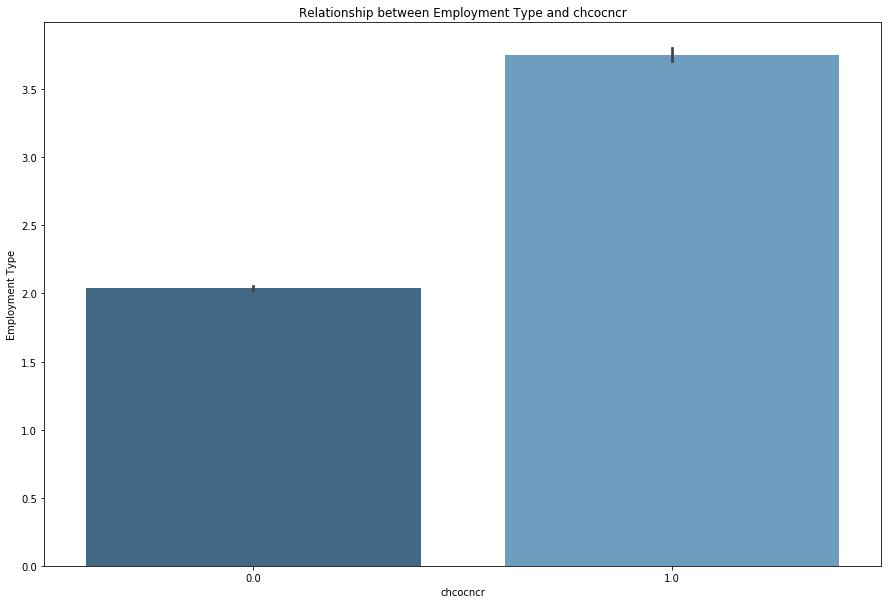

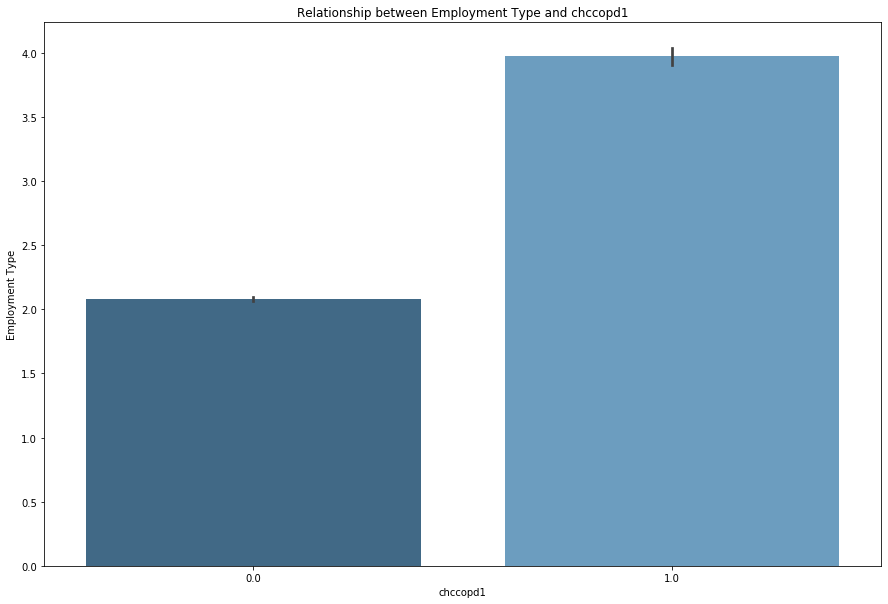

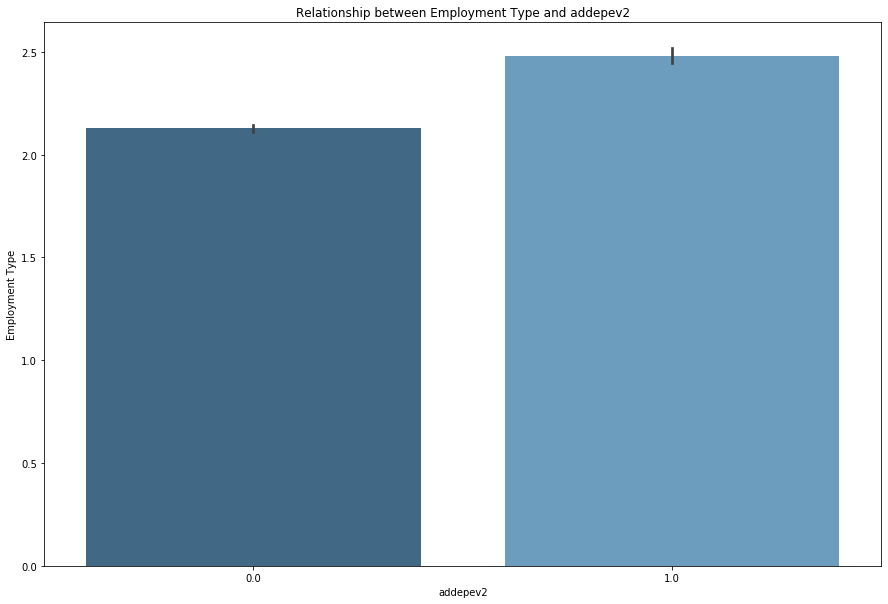

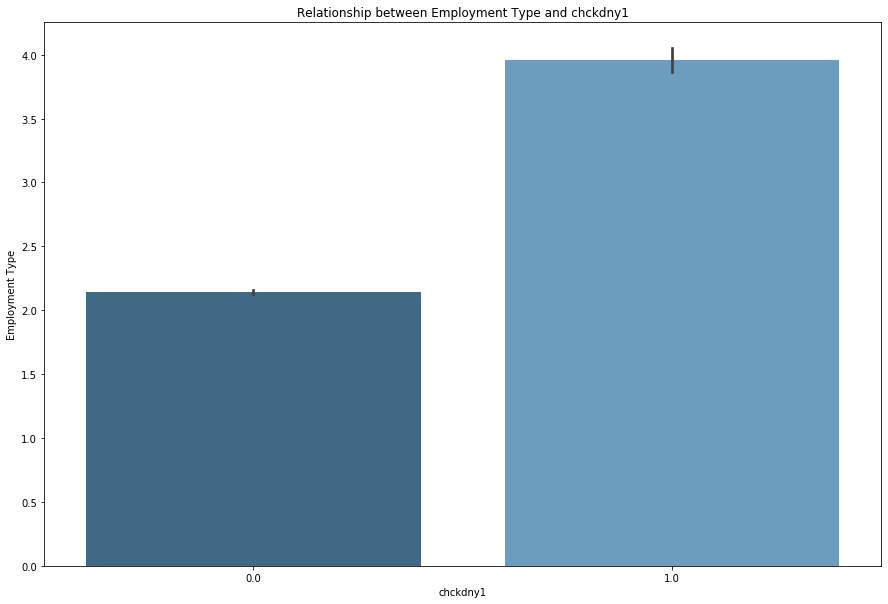

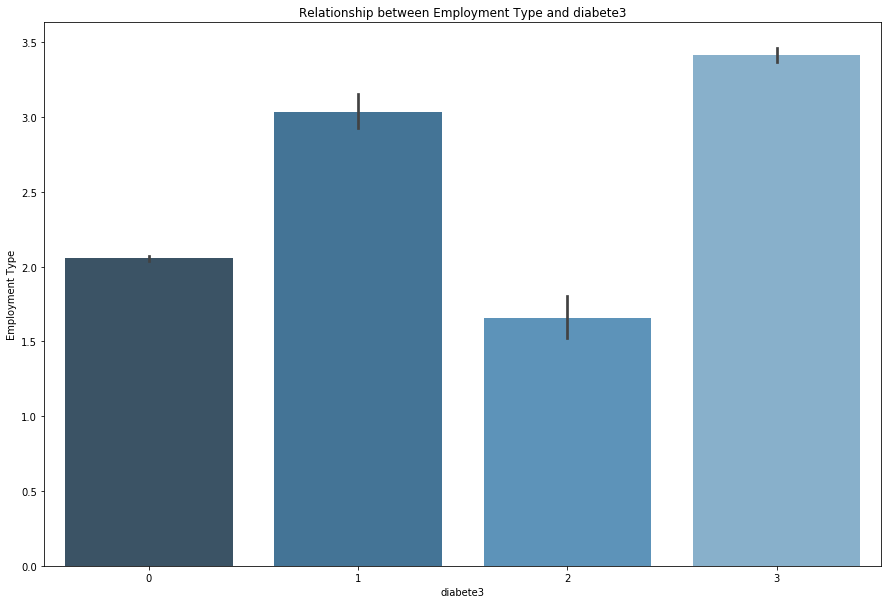

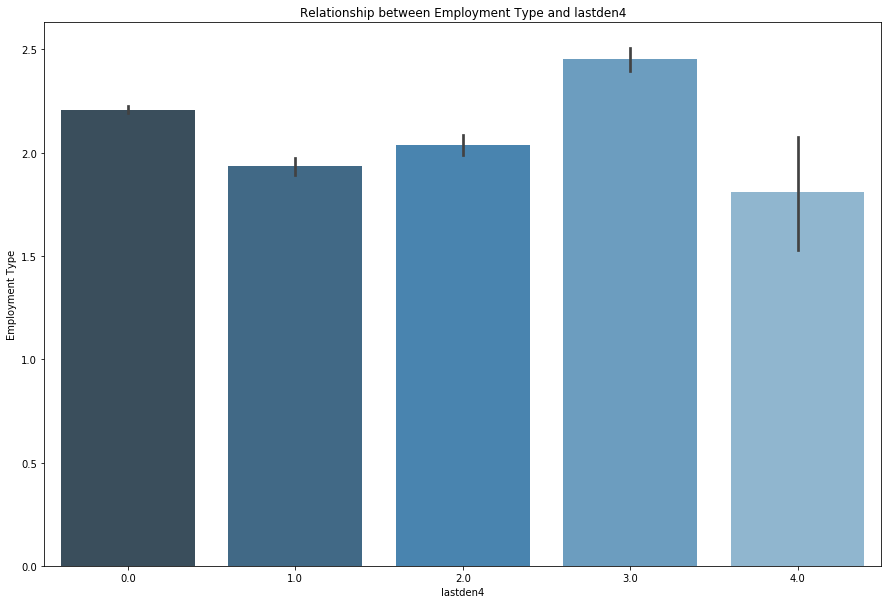

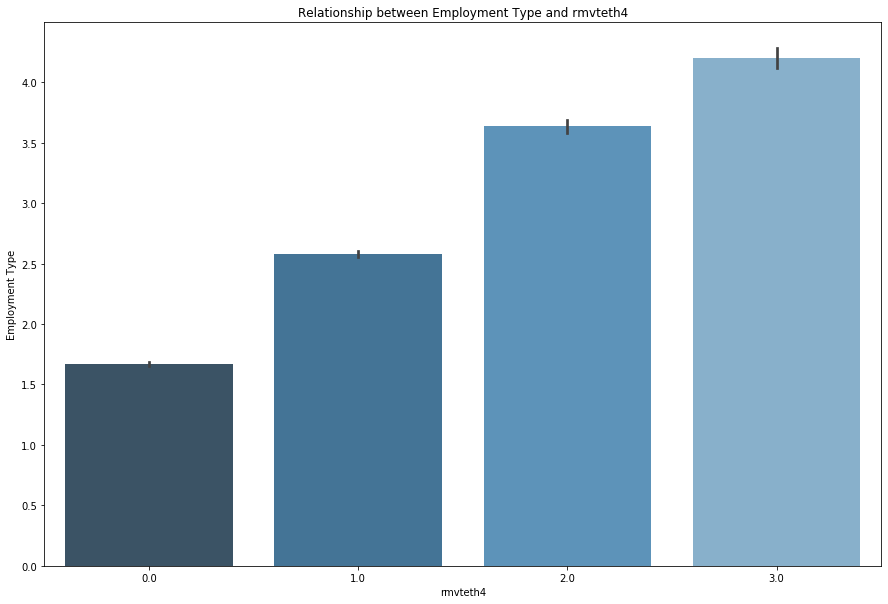

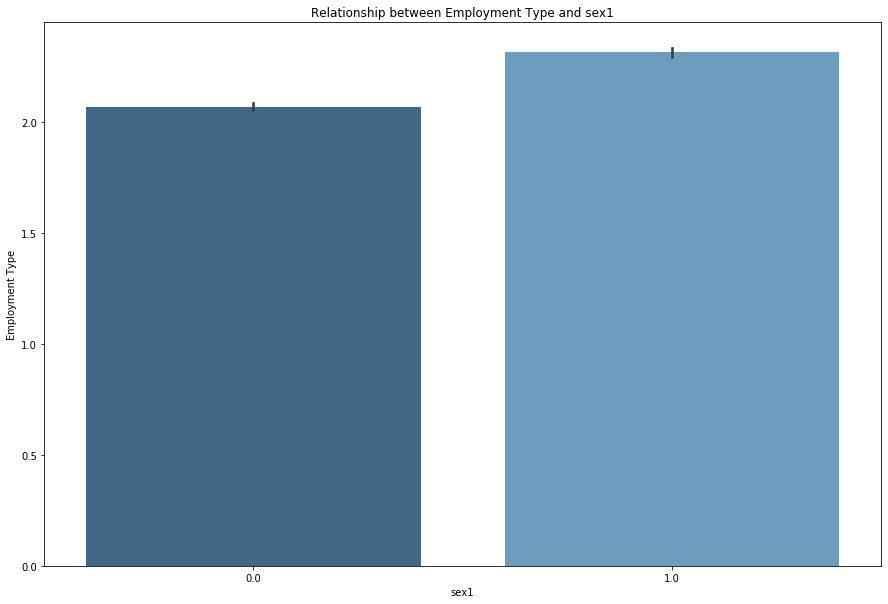

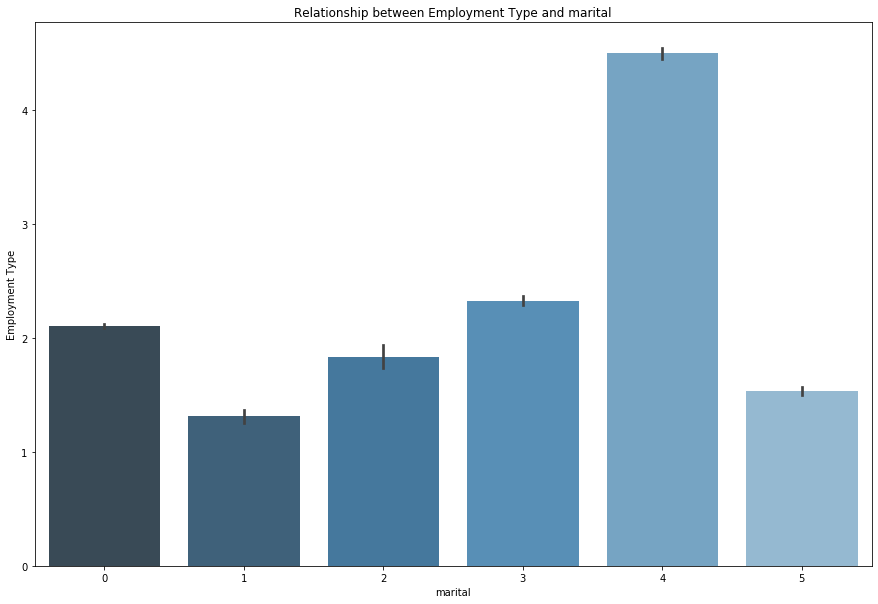

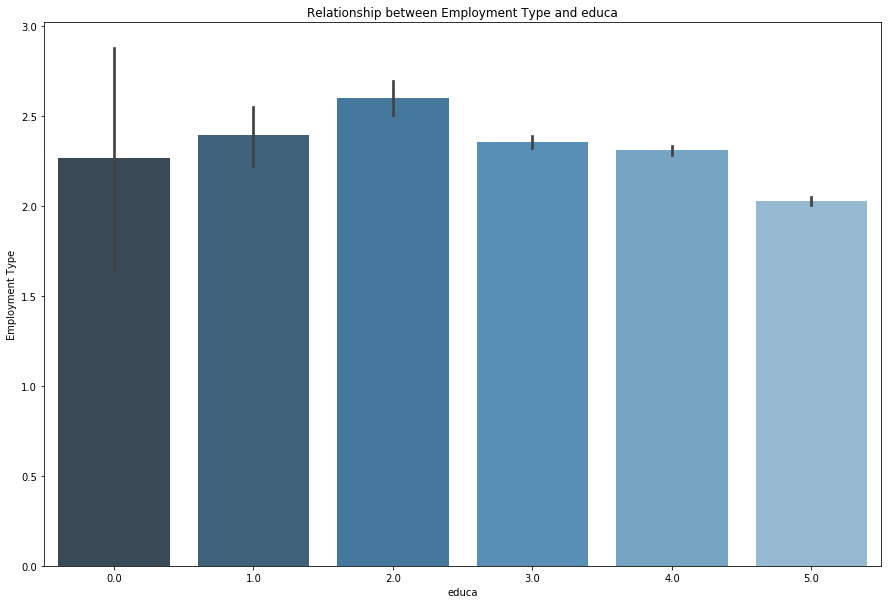

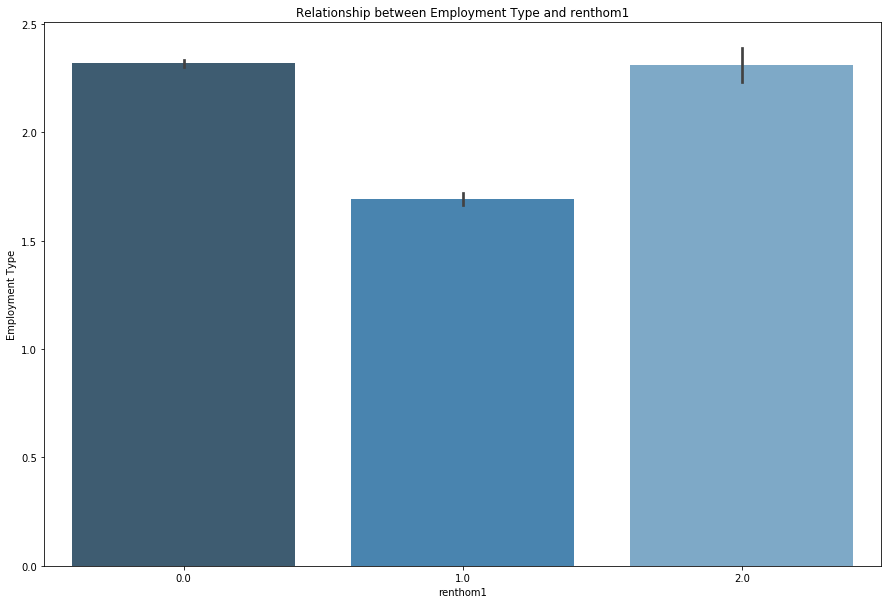

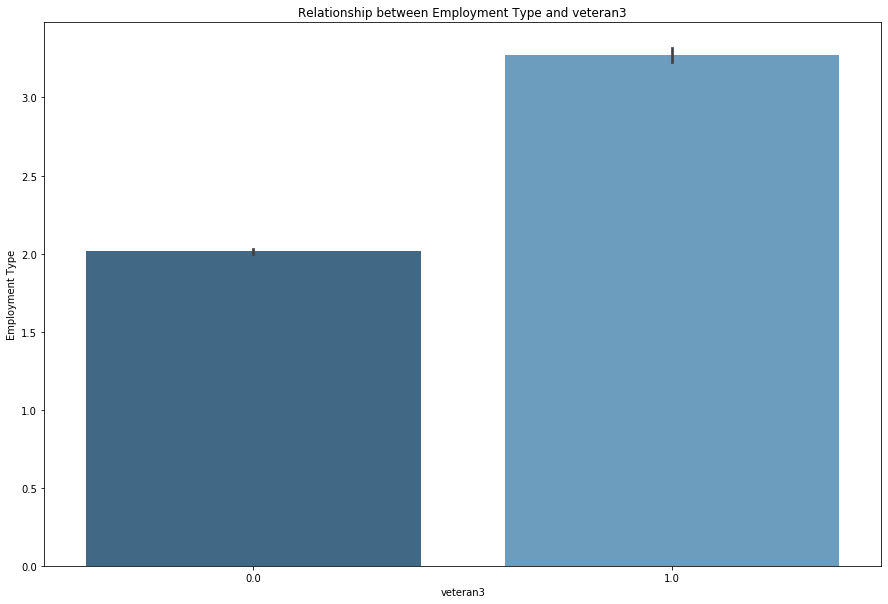

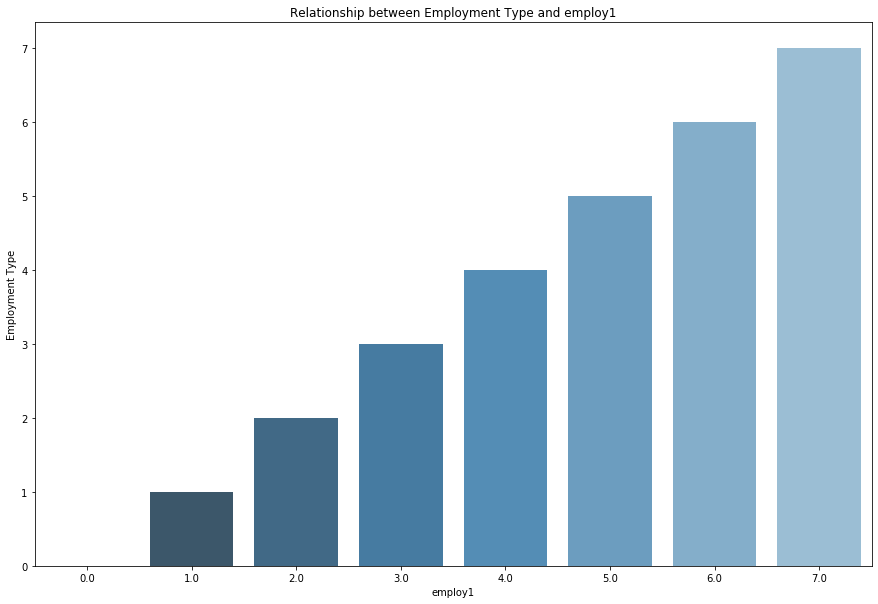

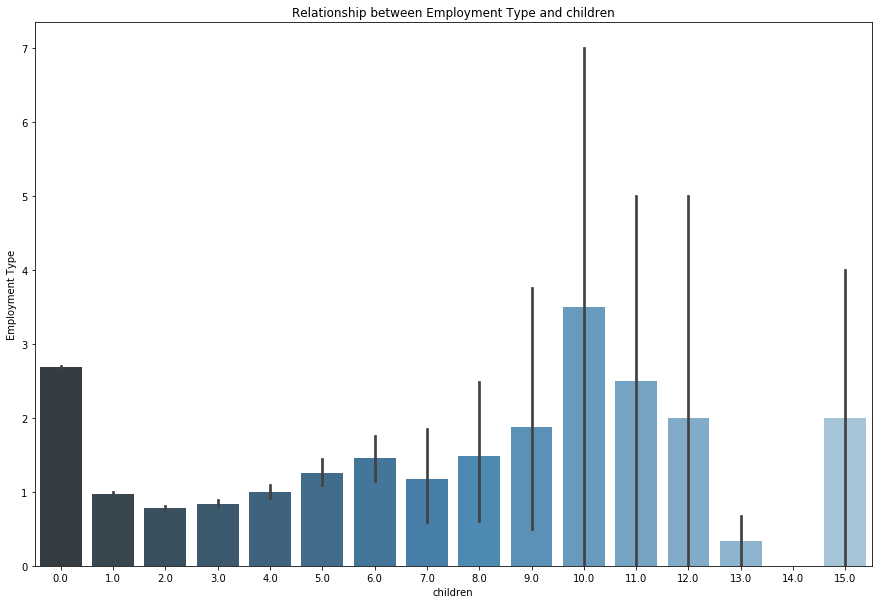

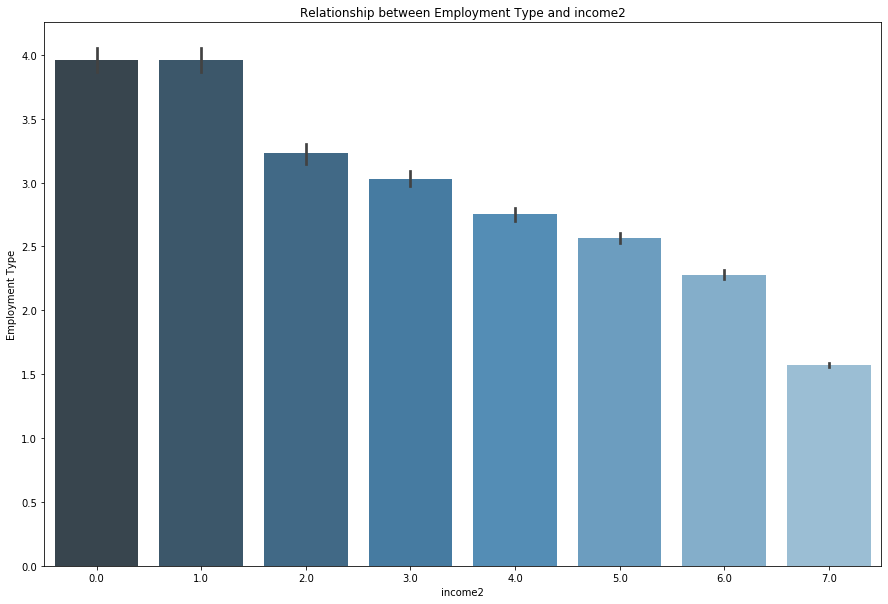

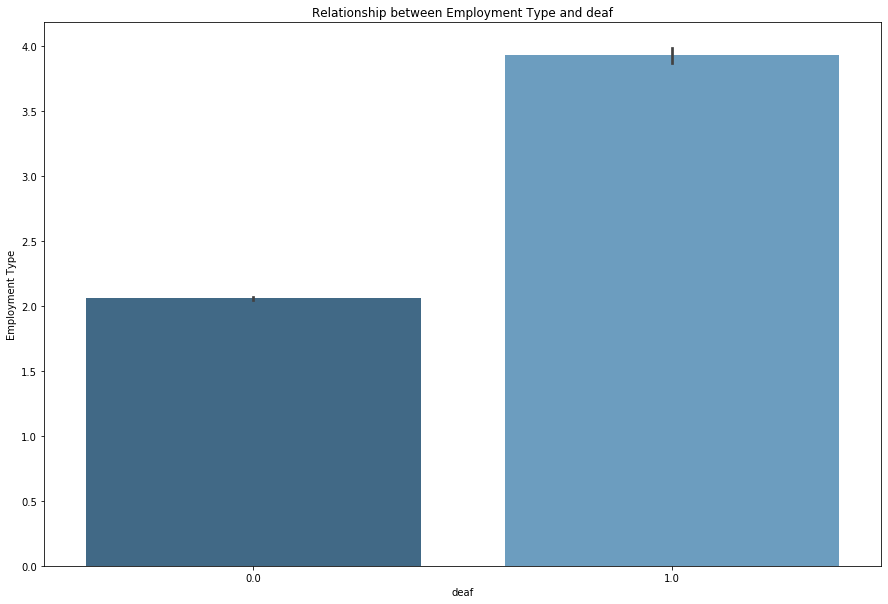

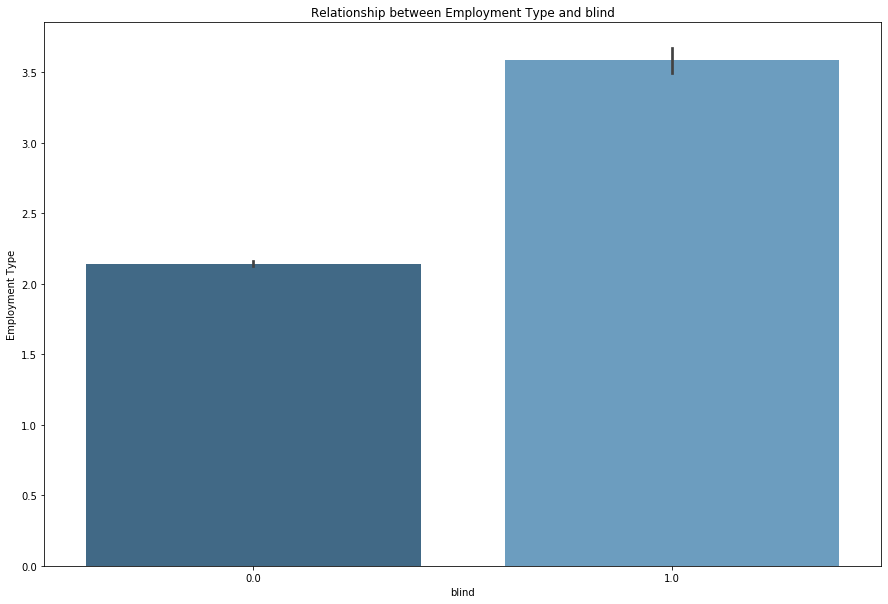

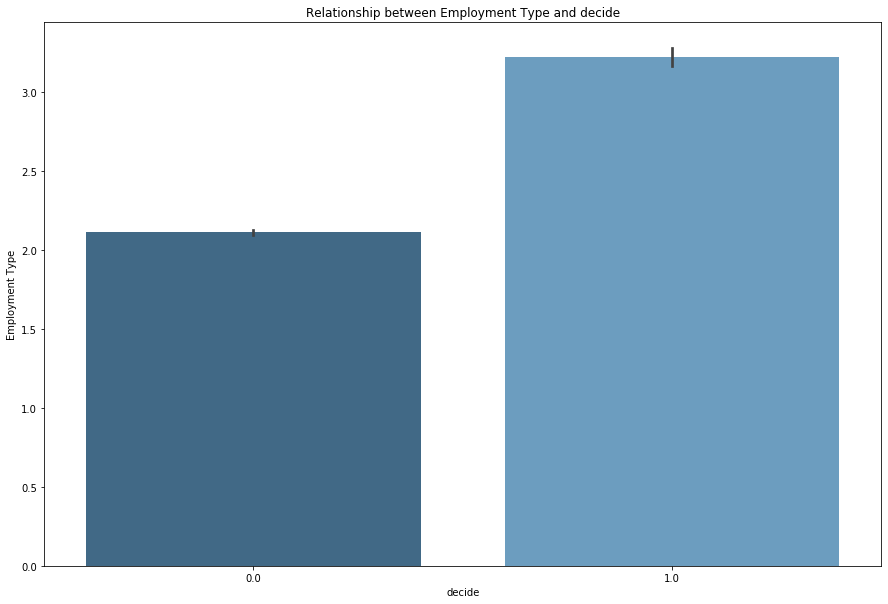

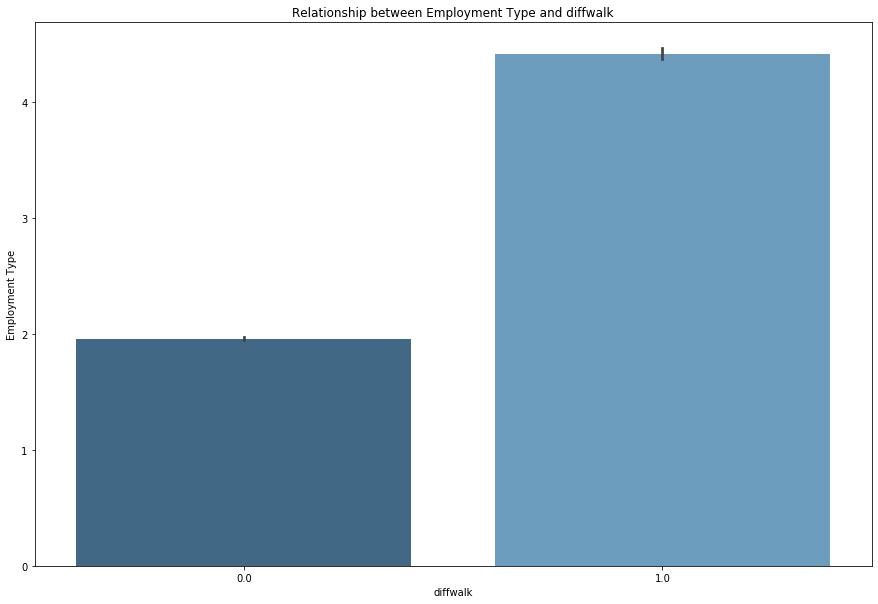

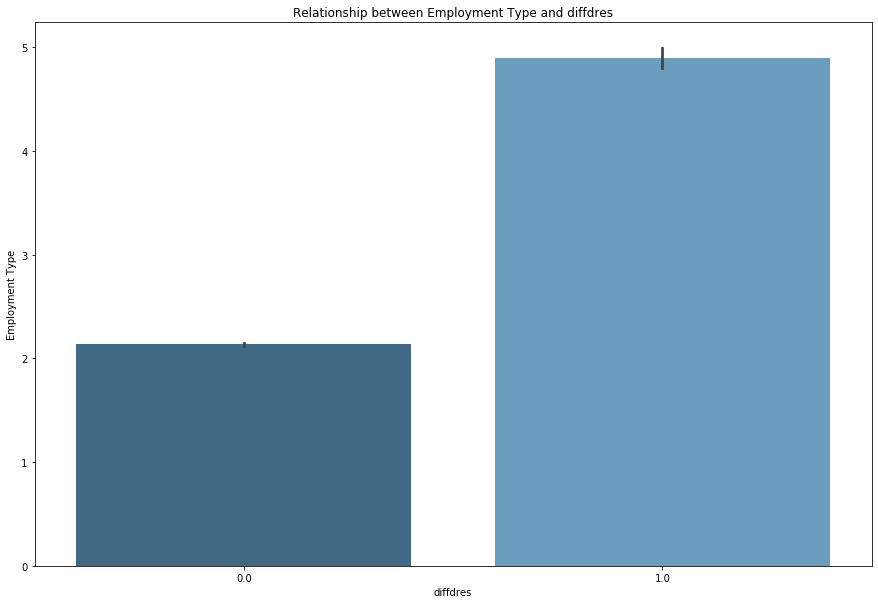

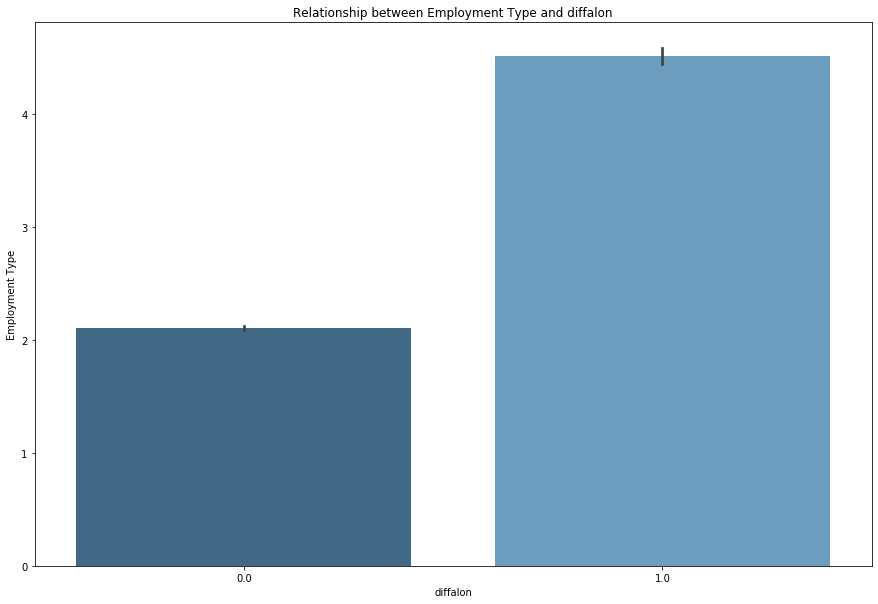

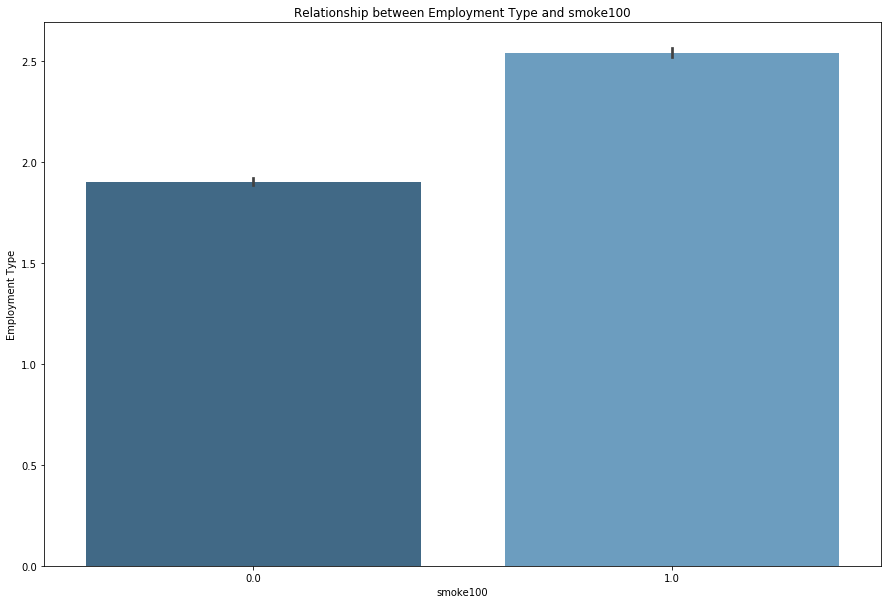

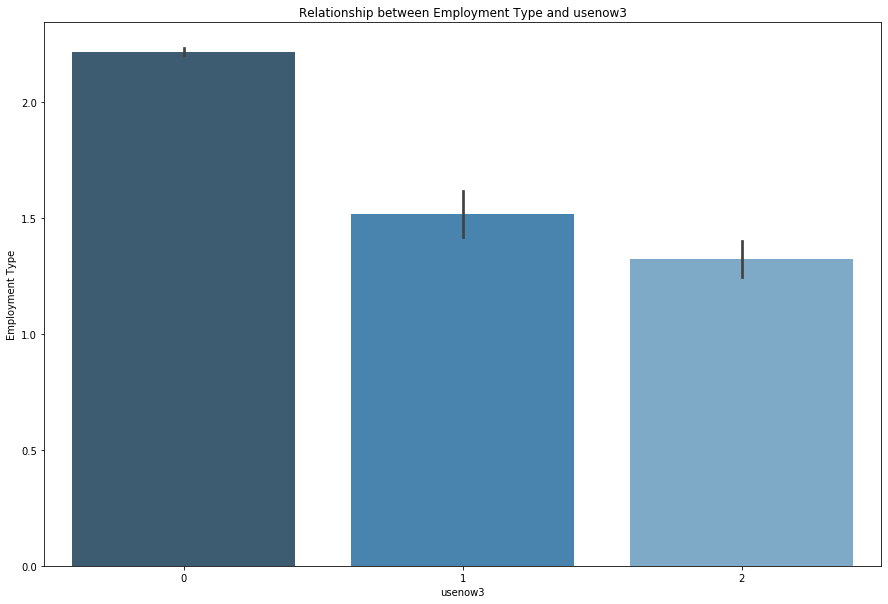

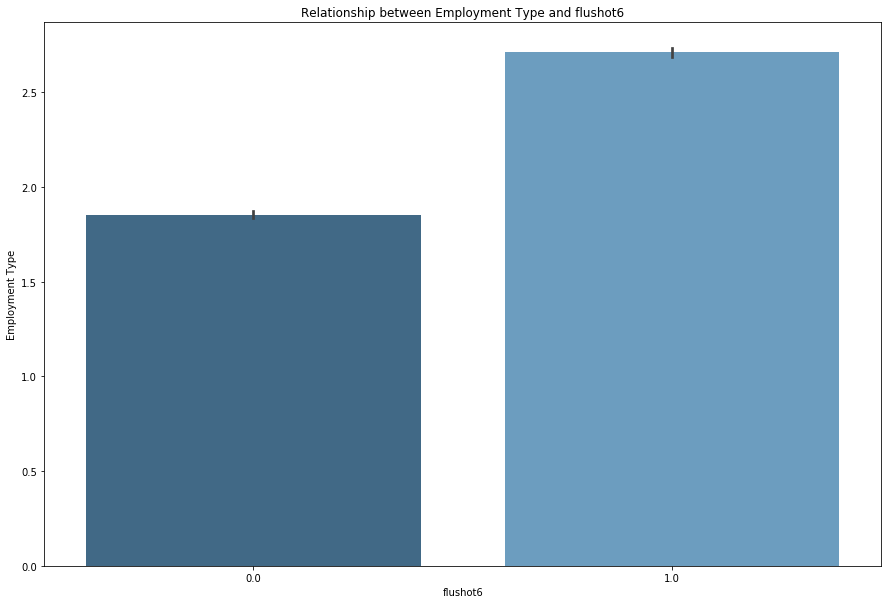

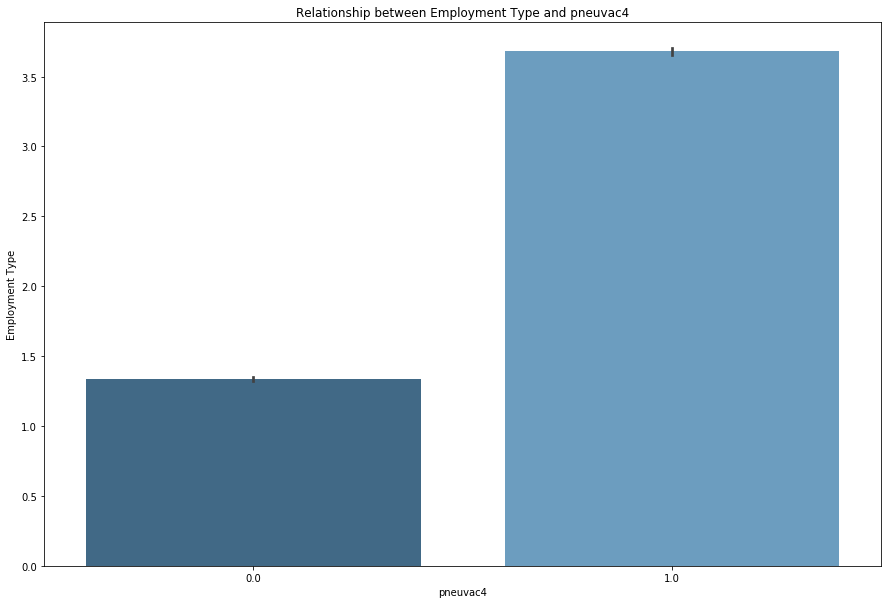

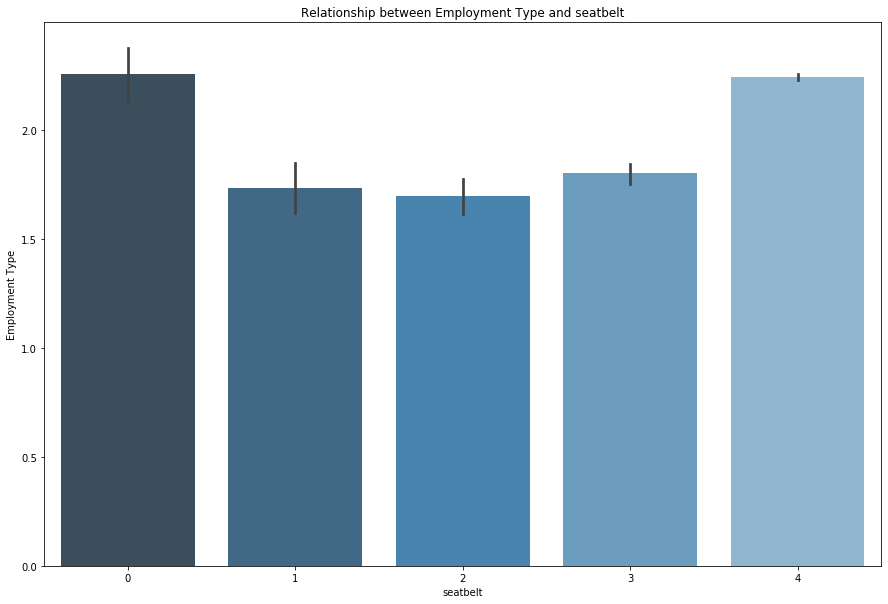

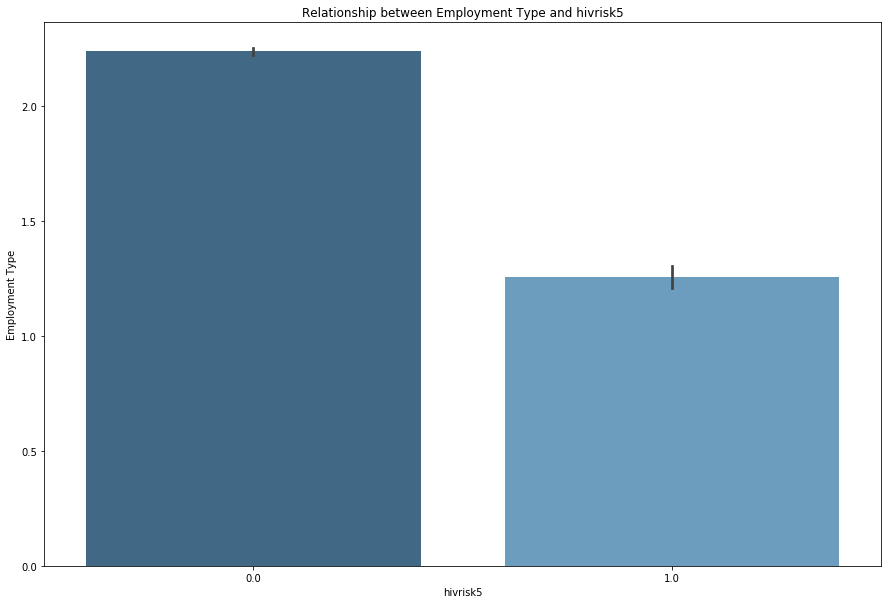

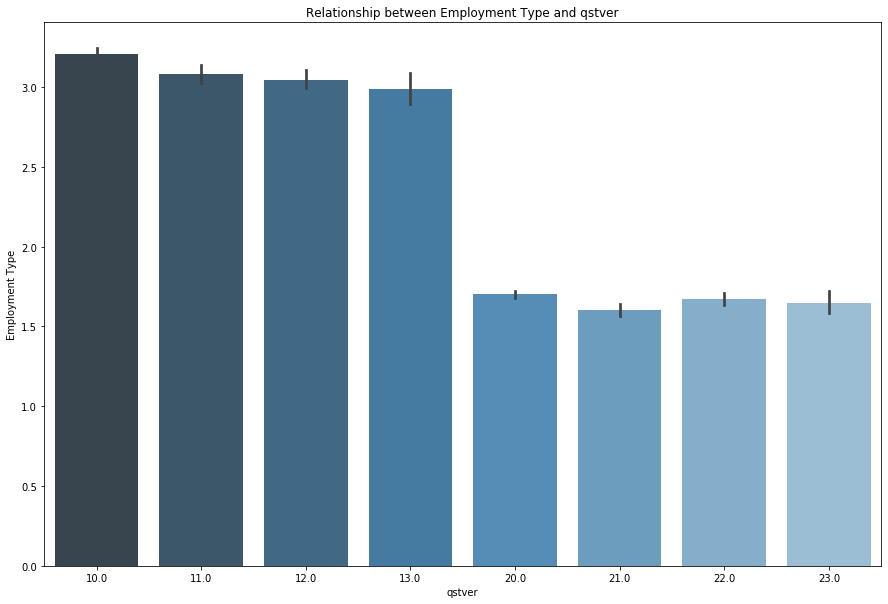

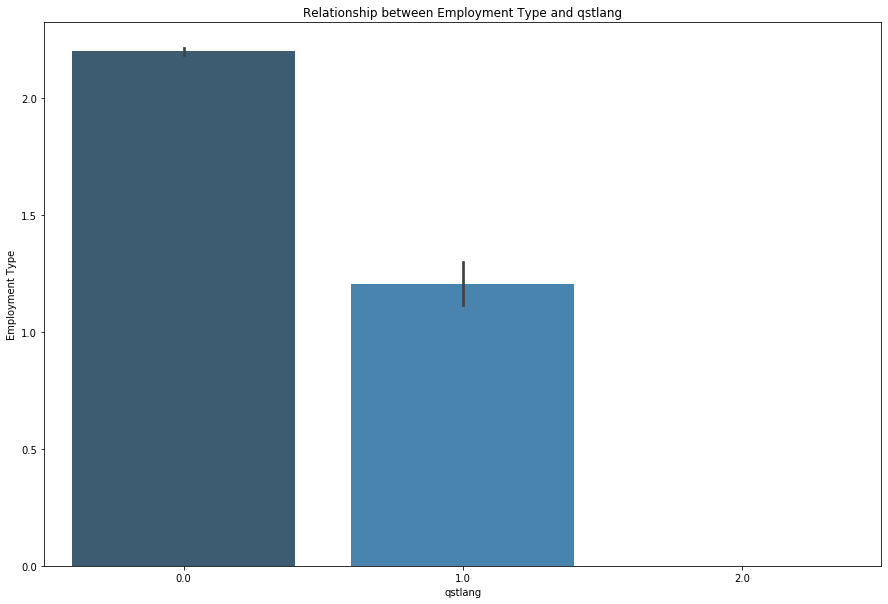

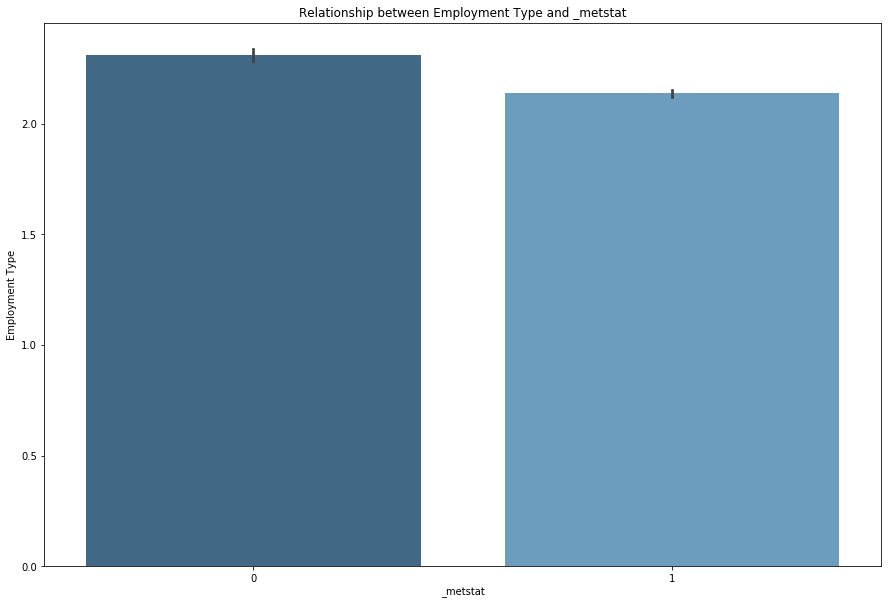

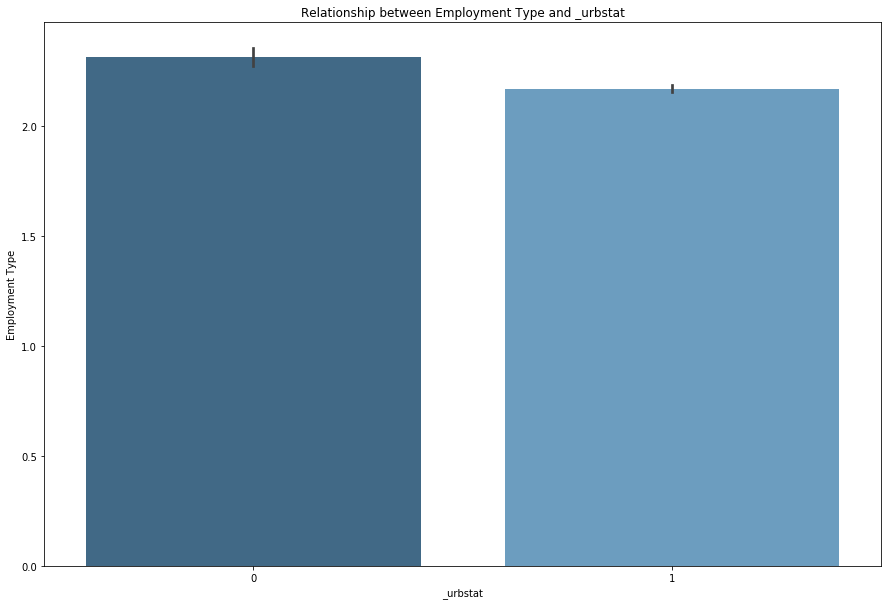

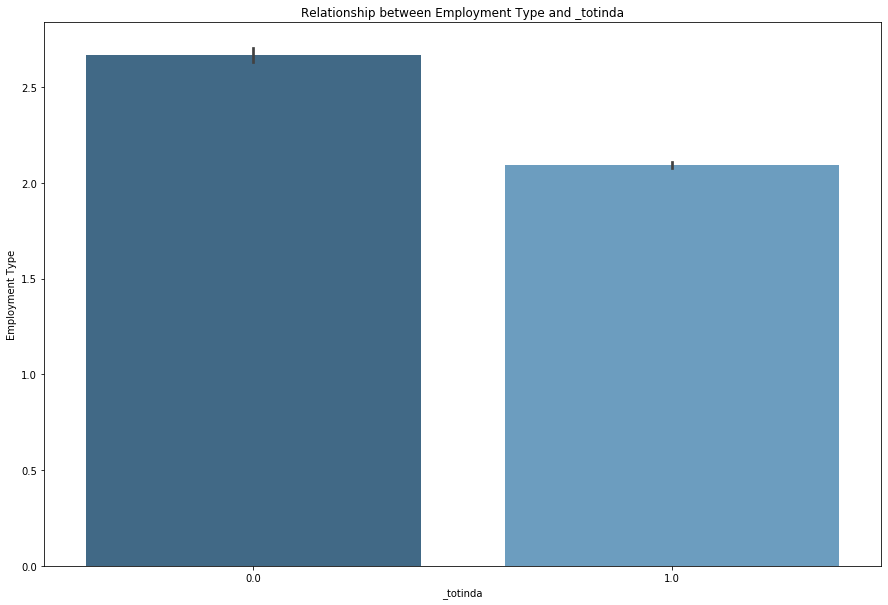

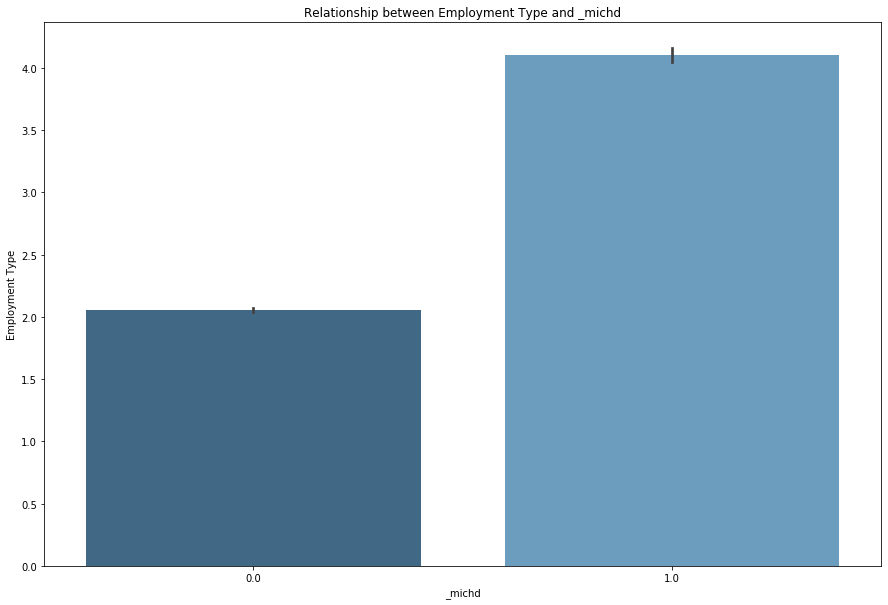

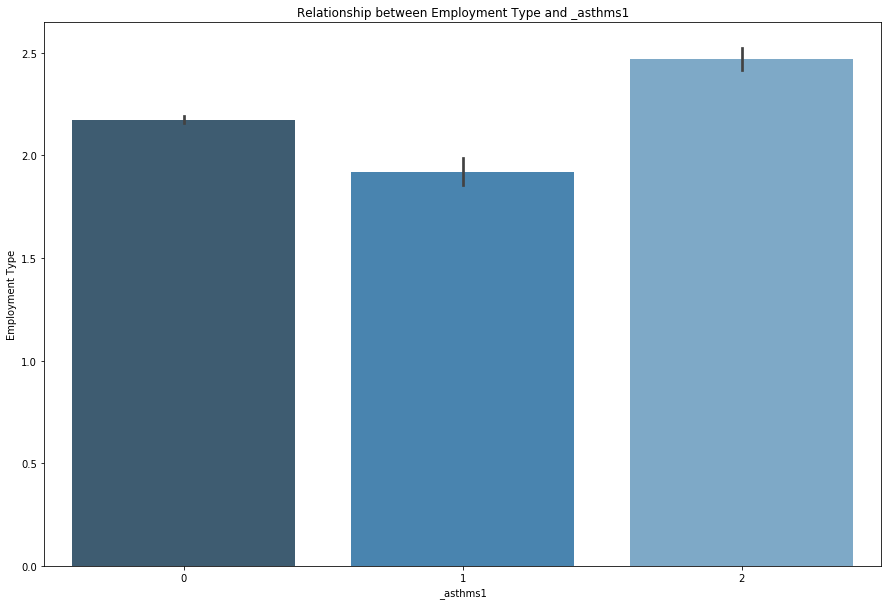

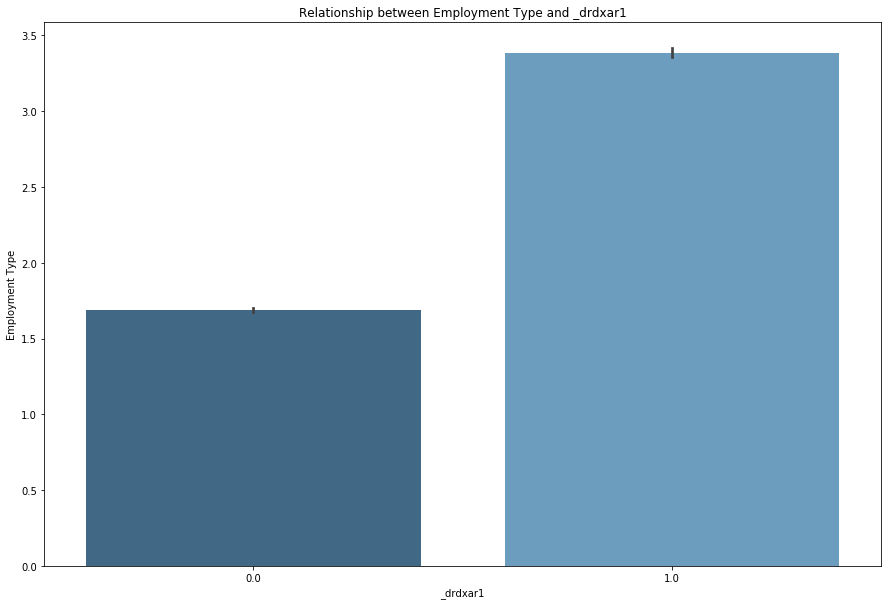

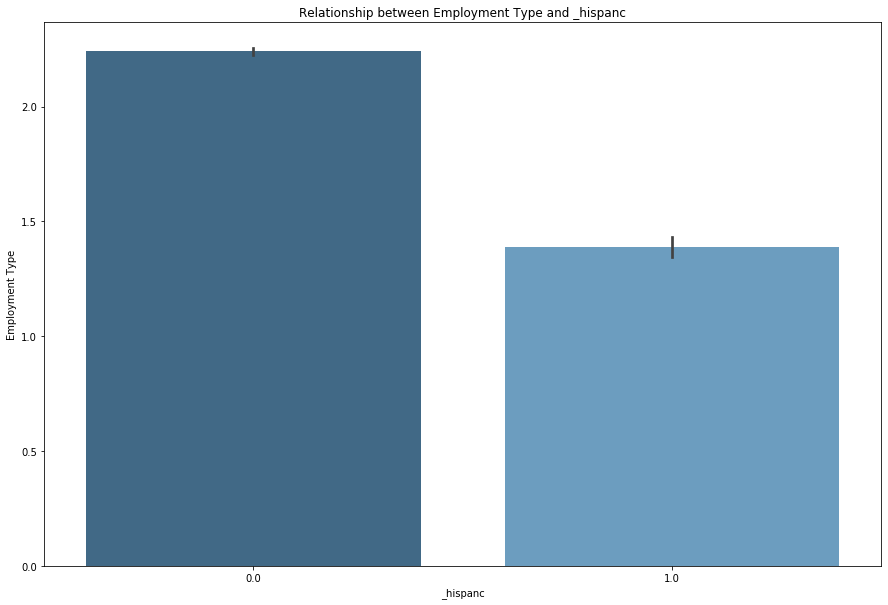

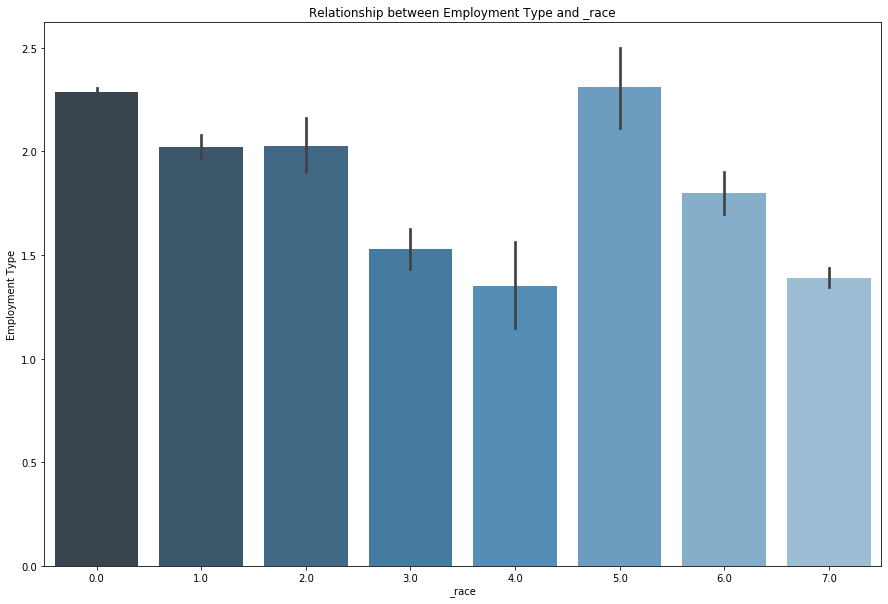

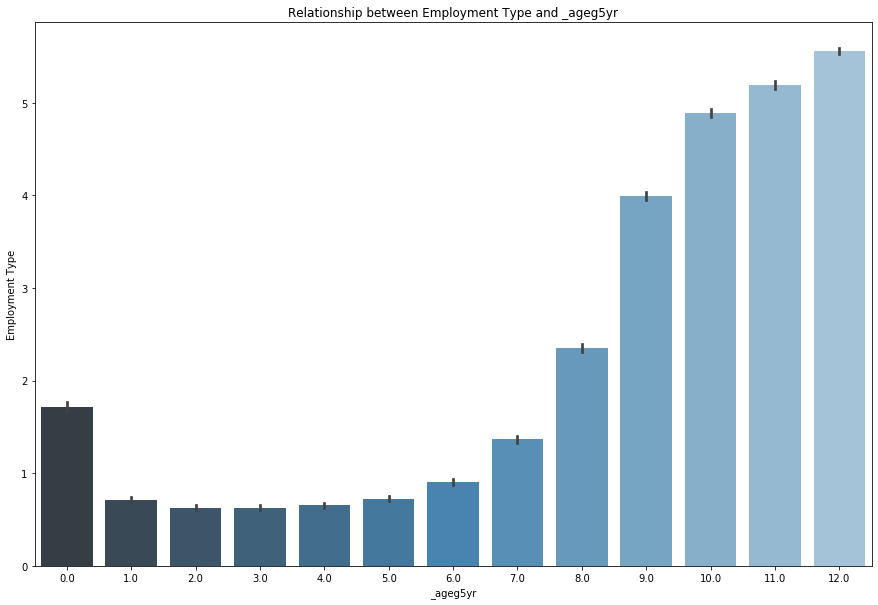

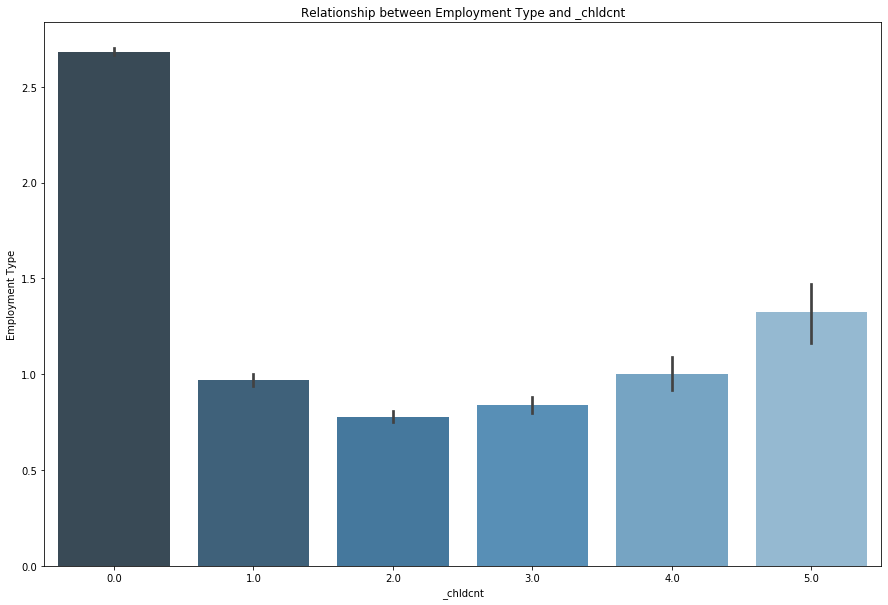

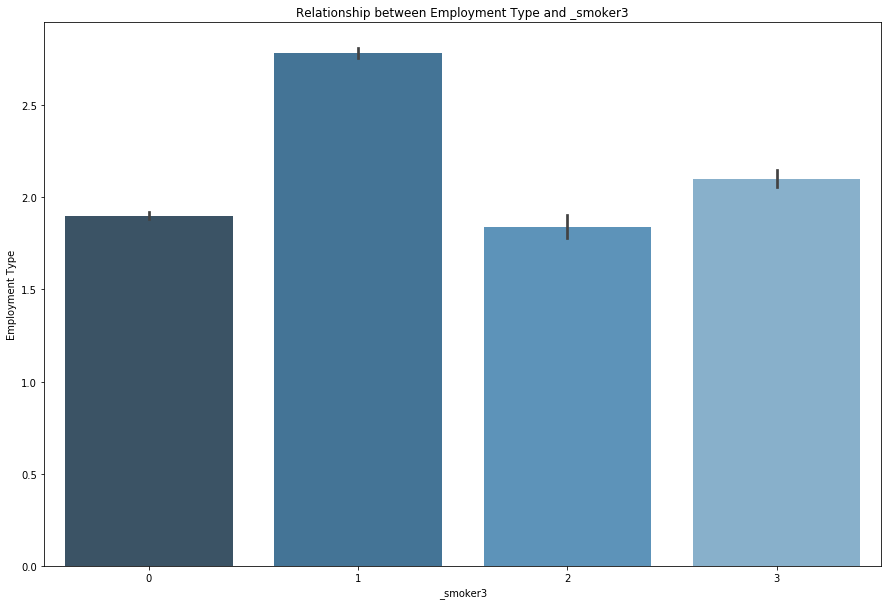

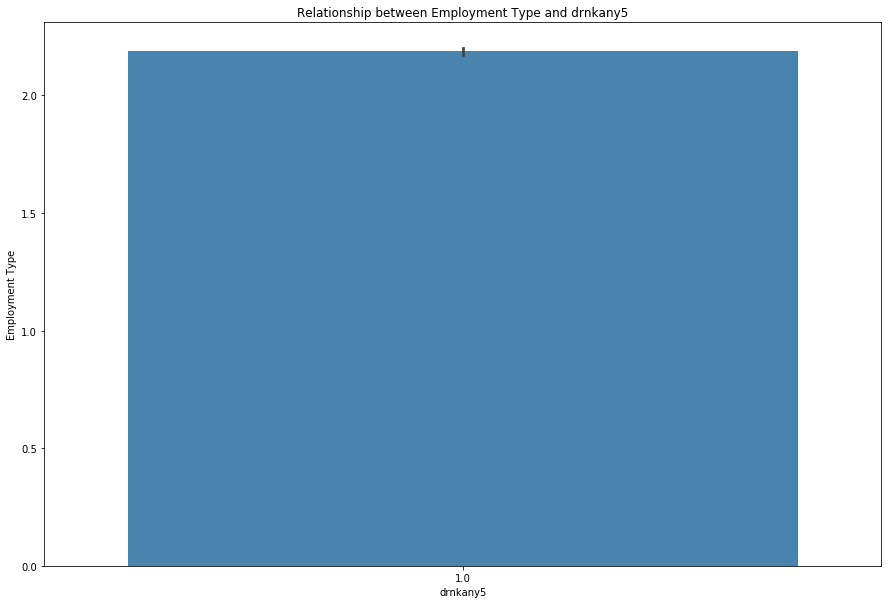

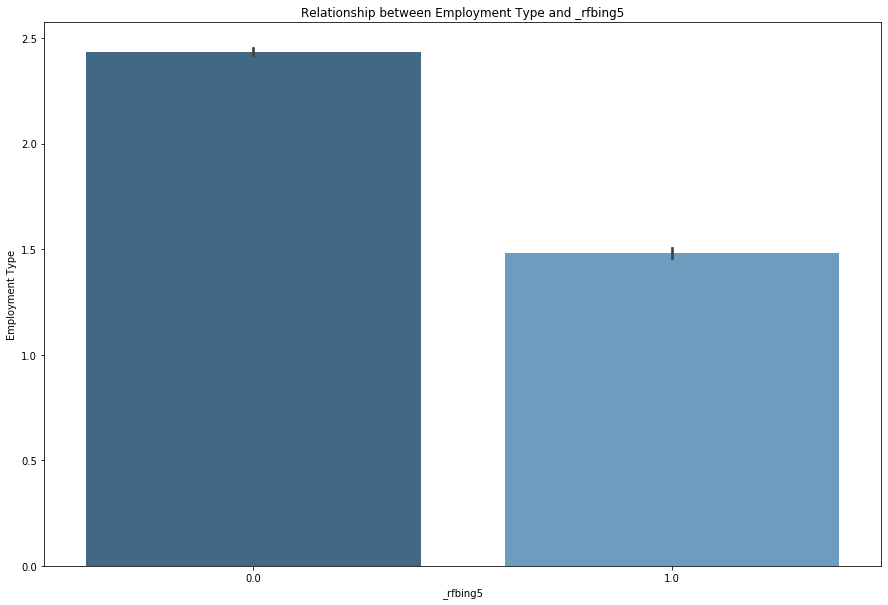

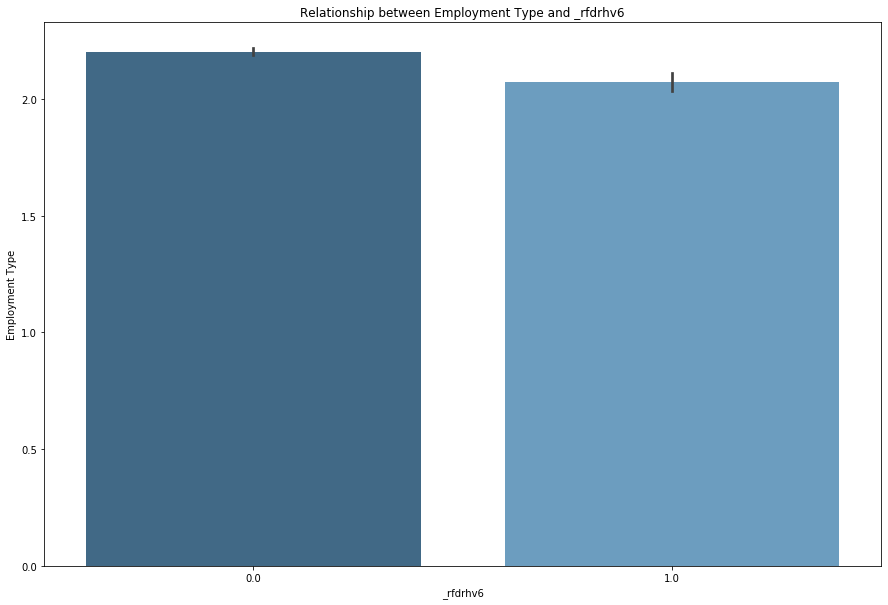

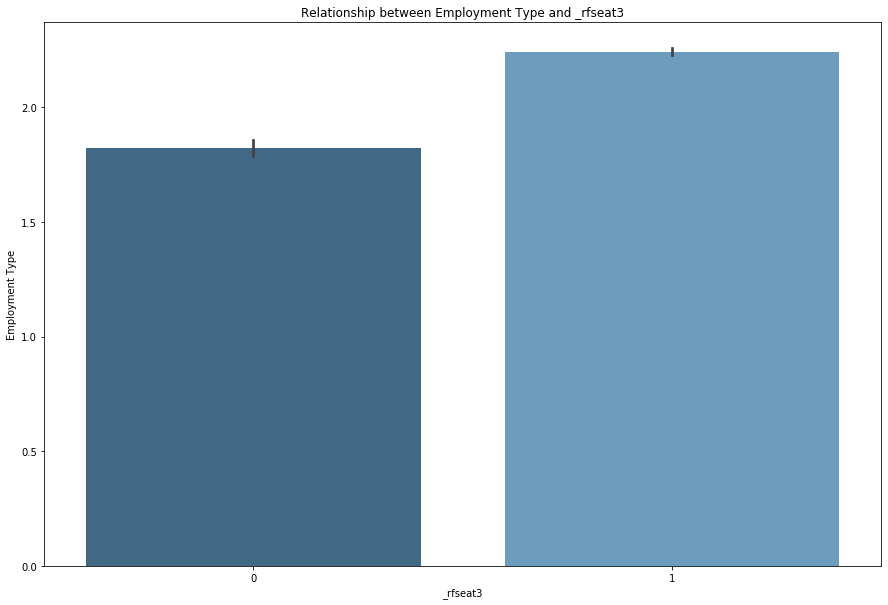

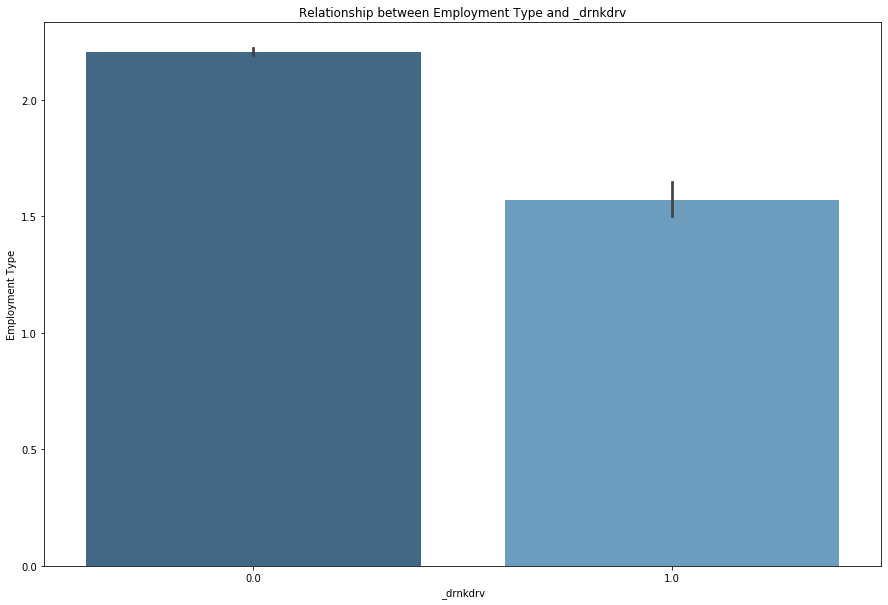

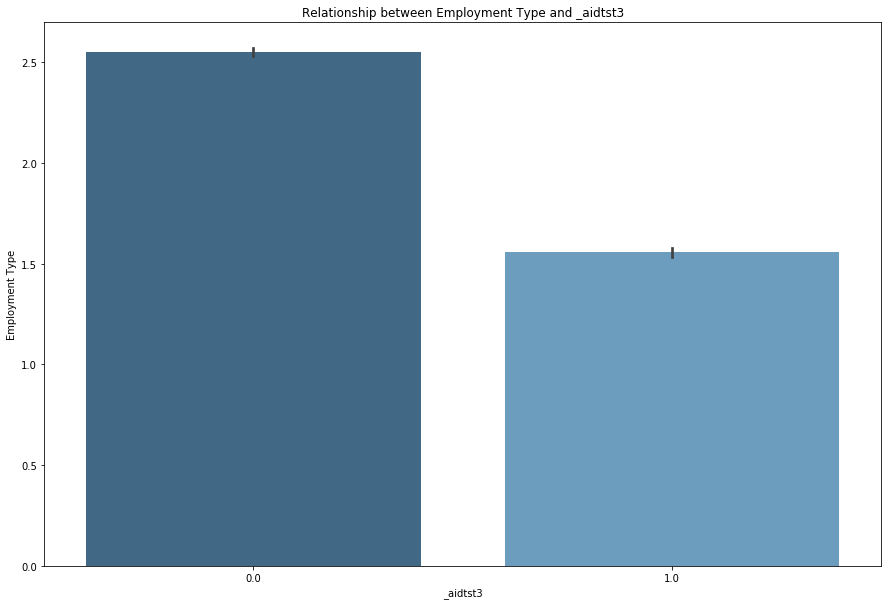

In [180]:
# I'm also curious about how employment type may or may not be related to other categorical variables

for col in brfss_desc:
    sns.barplot(x=col, y='employ1', palette='Blues_d', data=brfss_desc)
    plt.title('Relationship between Employment Type and {}'.format(col))
    plt.xlabel('{}'.format(col))
    plt.ylabel('Employment Type')
    
    plt.gcf().set_size_inches(15,10)
    
    plt.show()

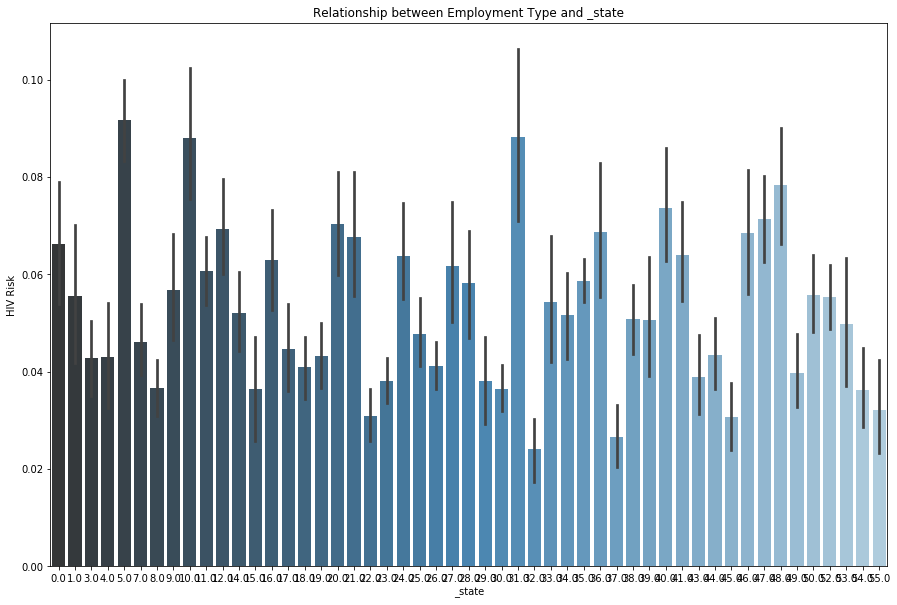

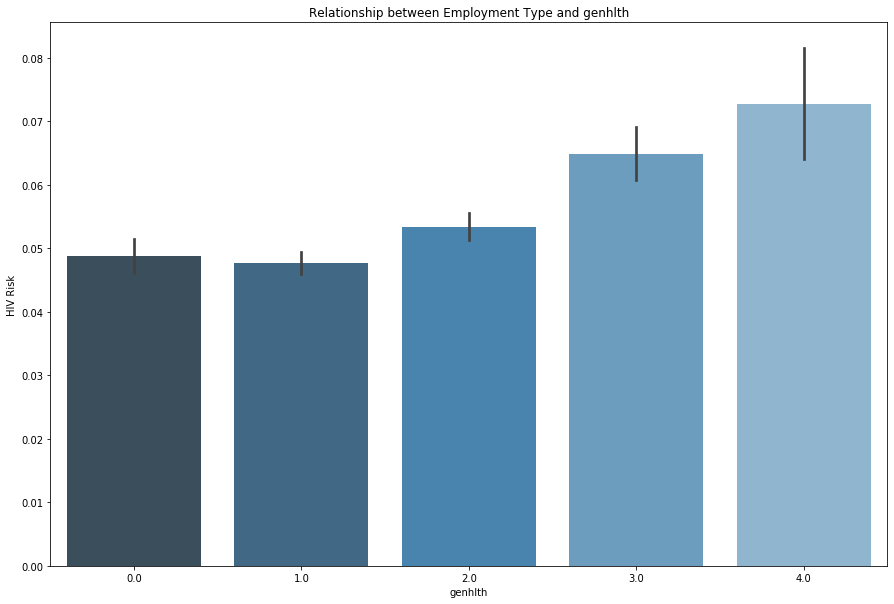

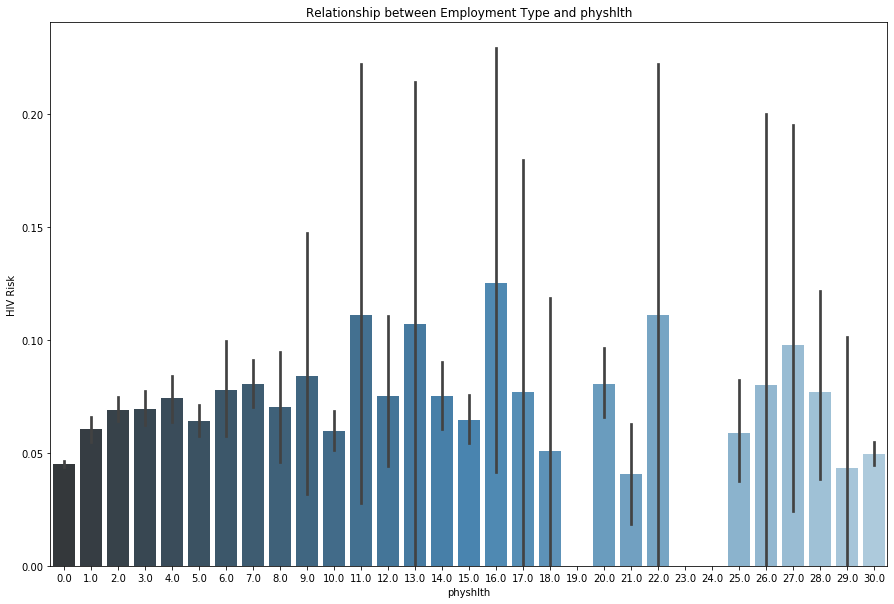

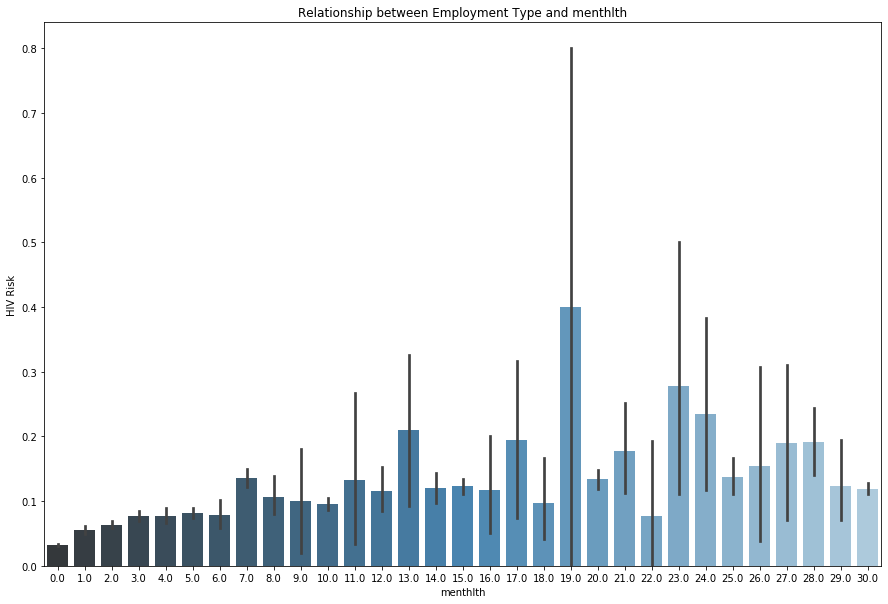

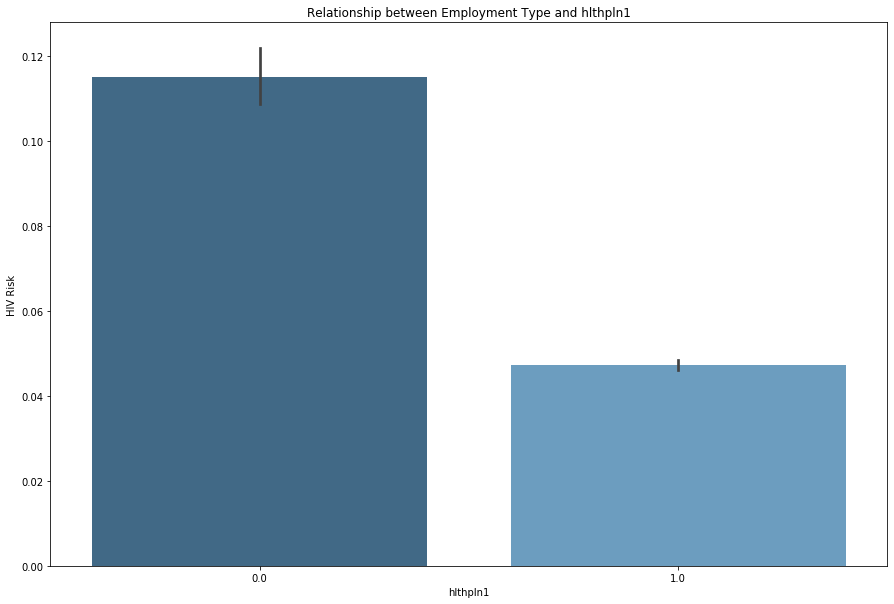

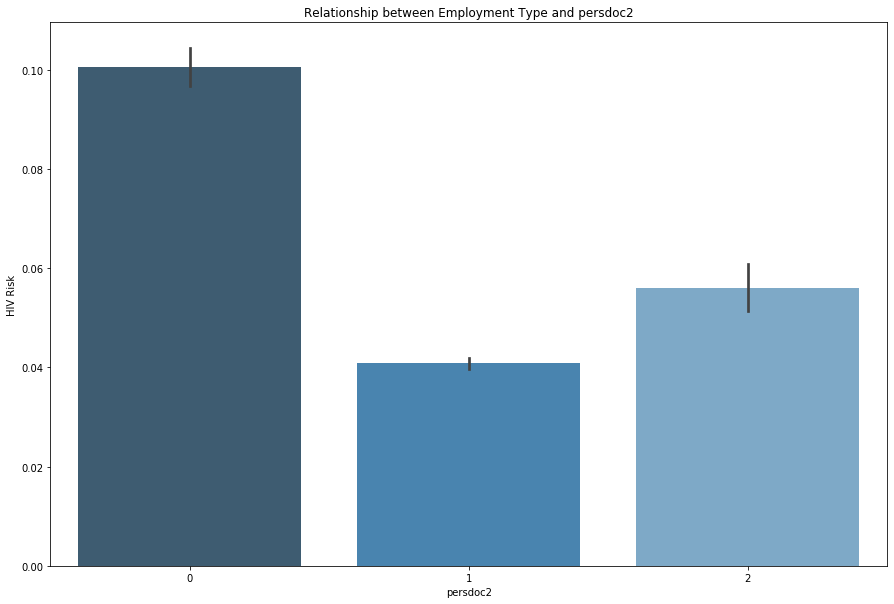

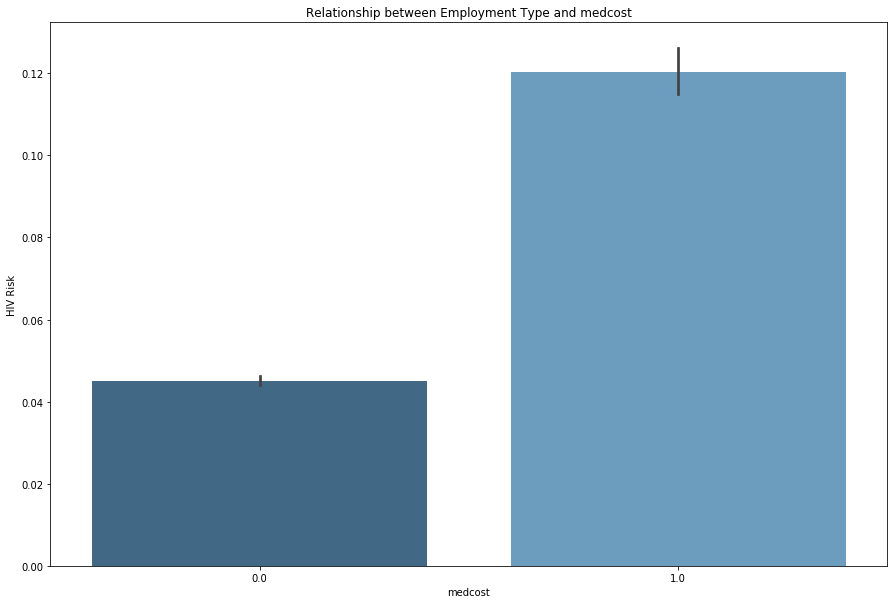

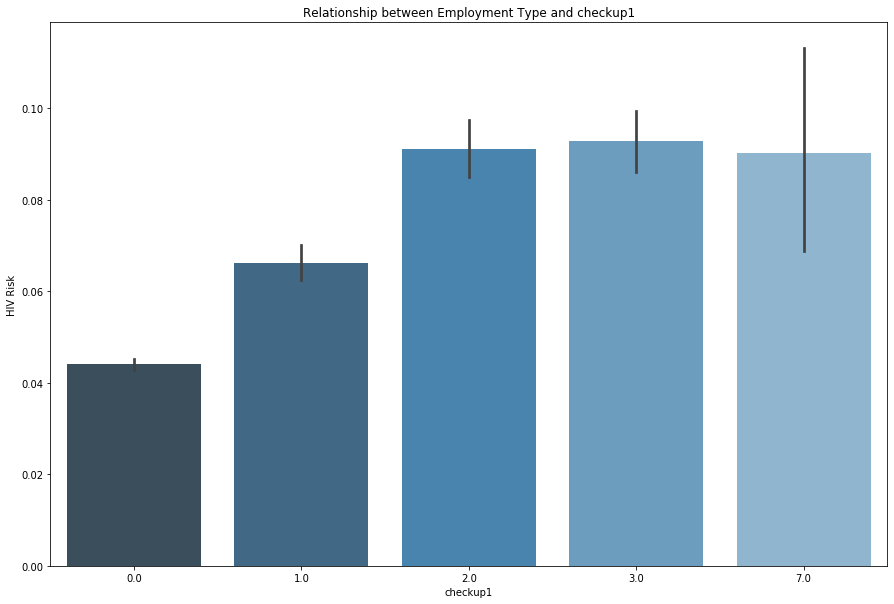

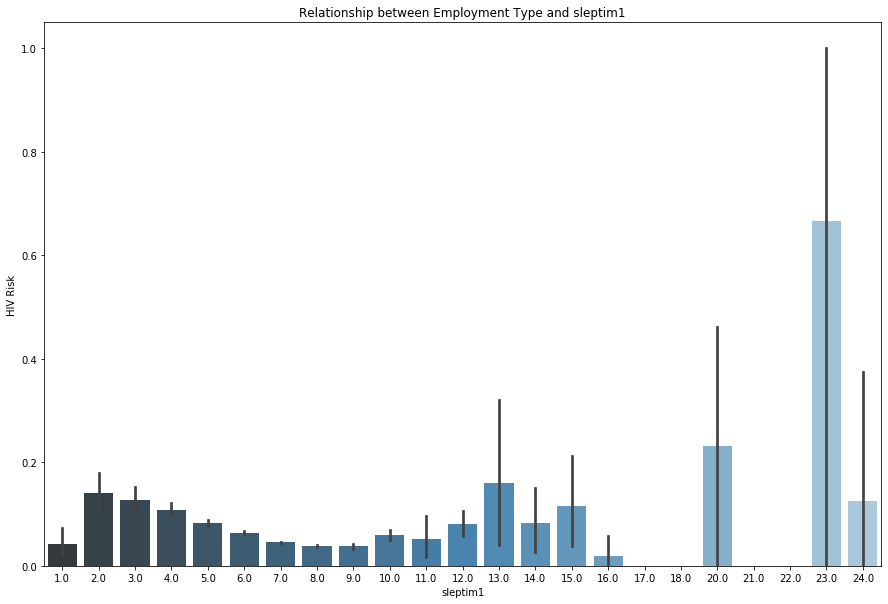

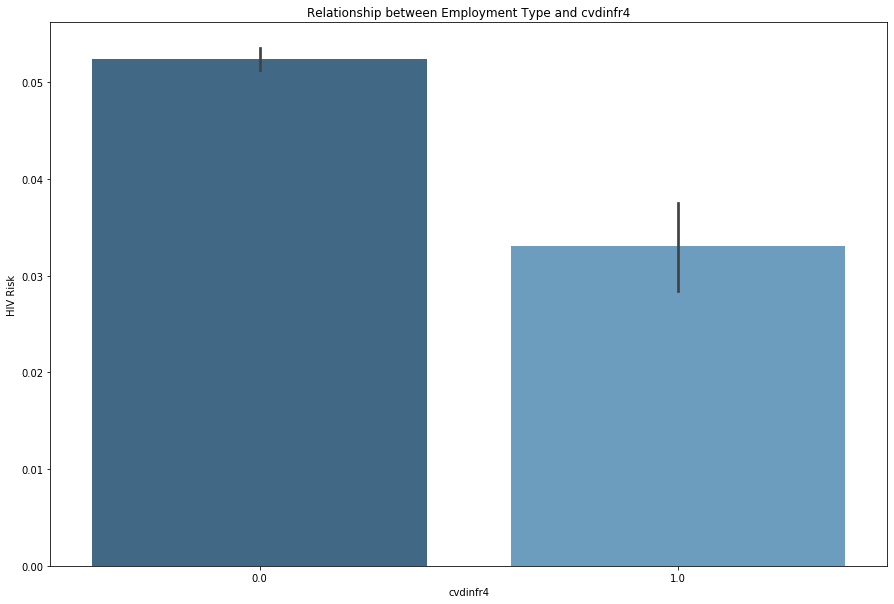

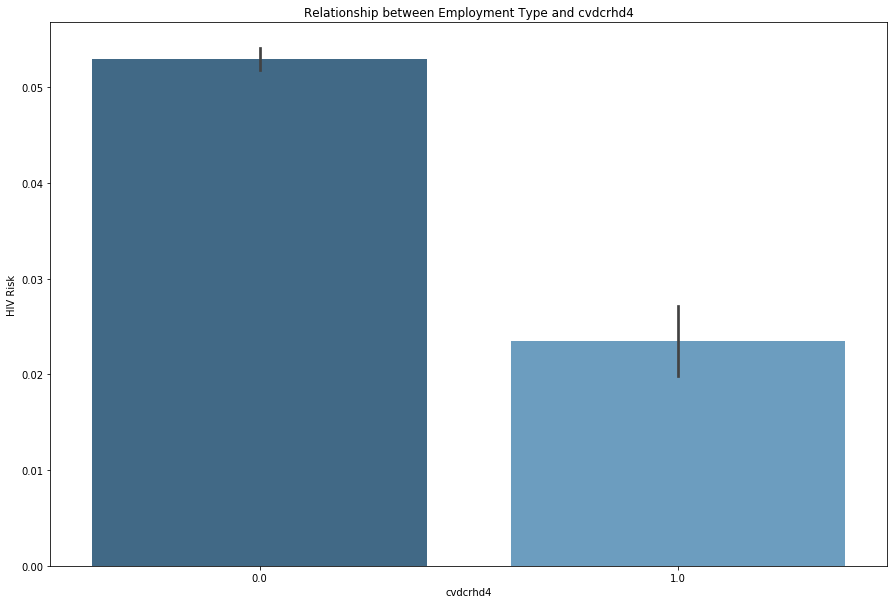

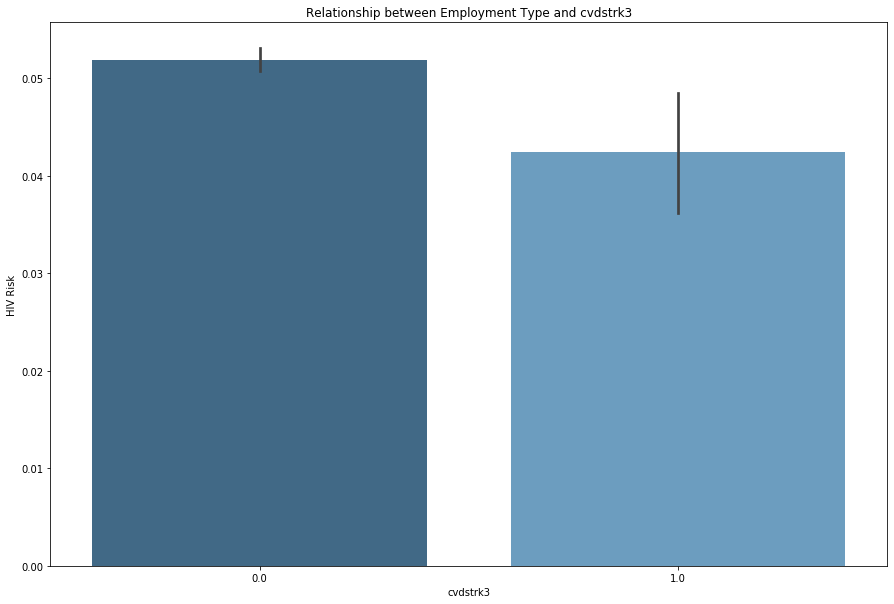

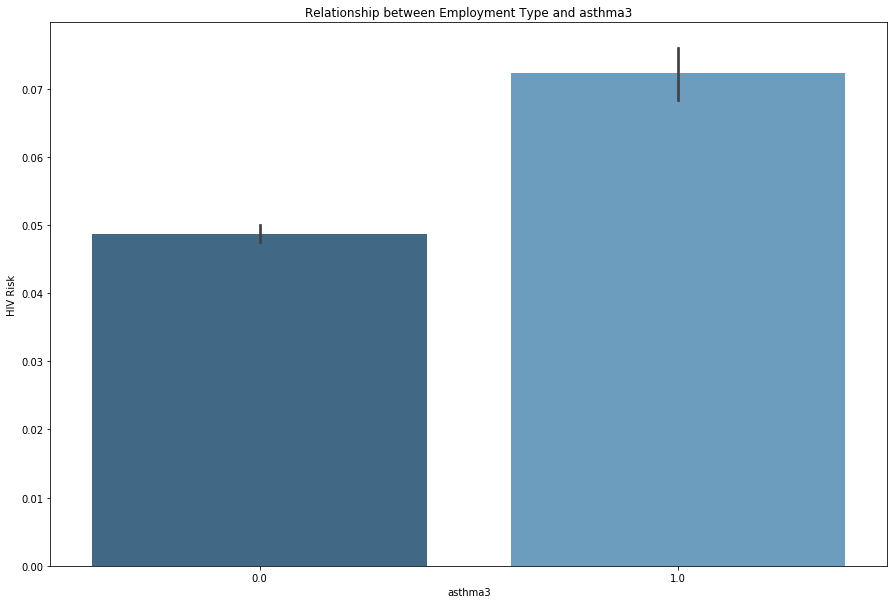

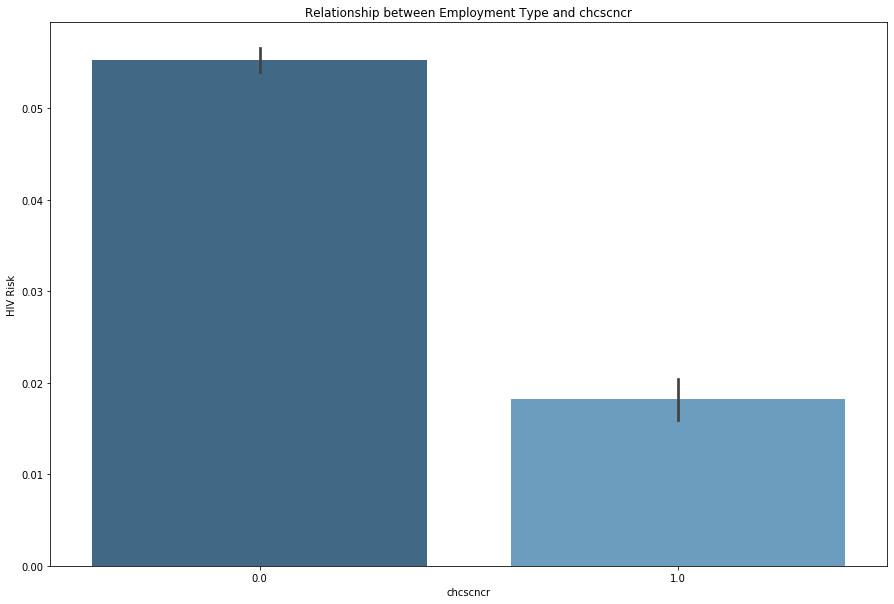

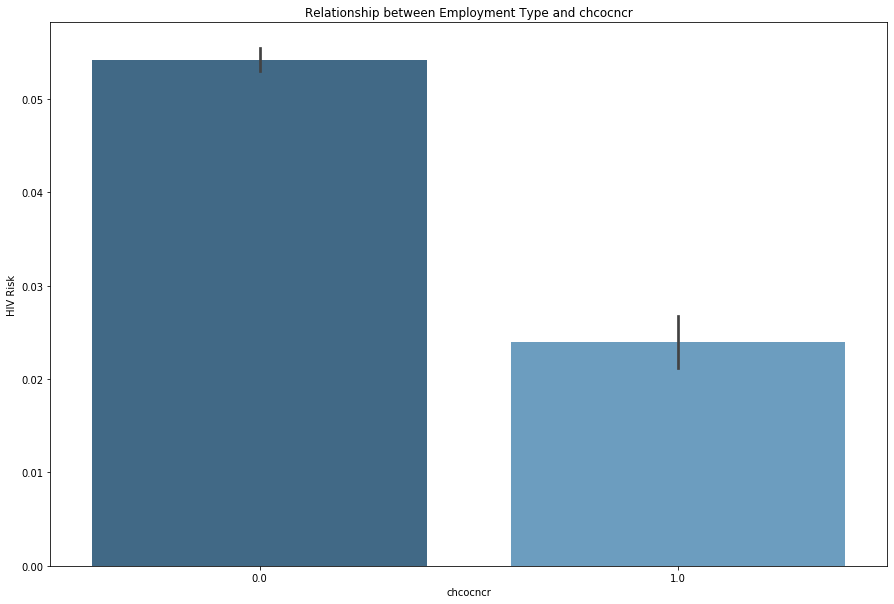

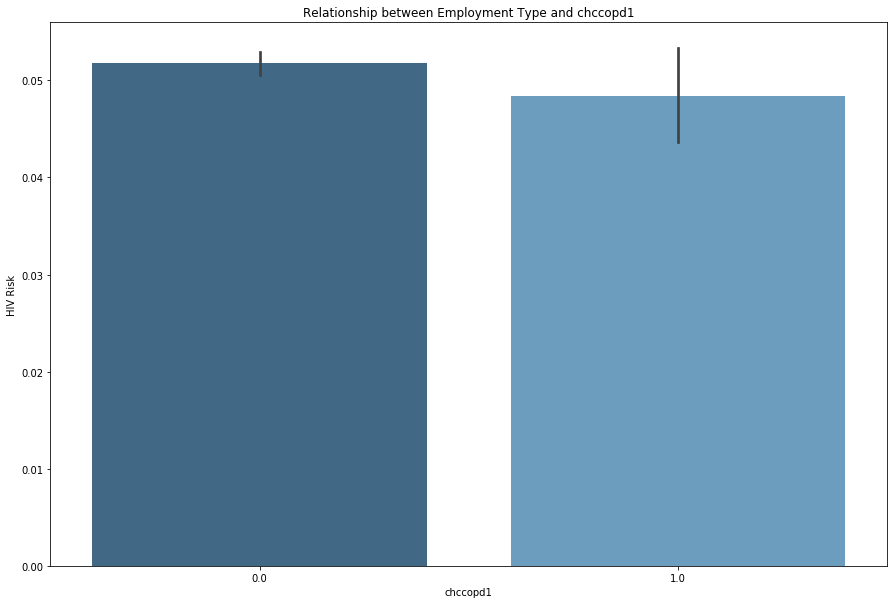

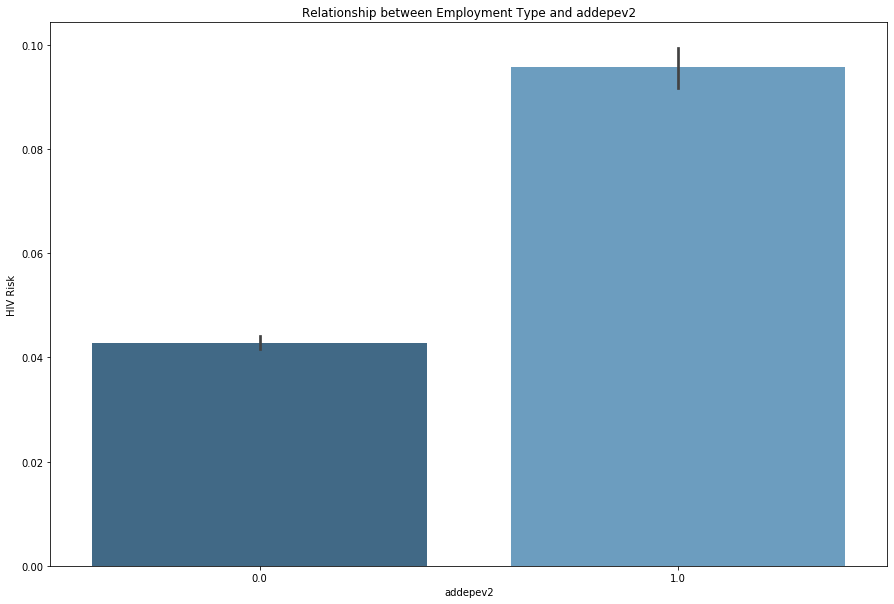

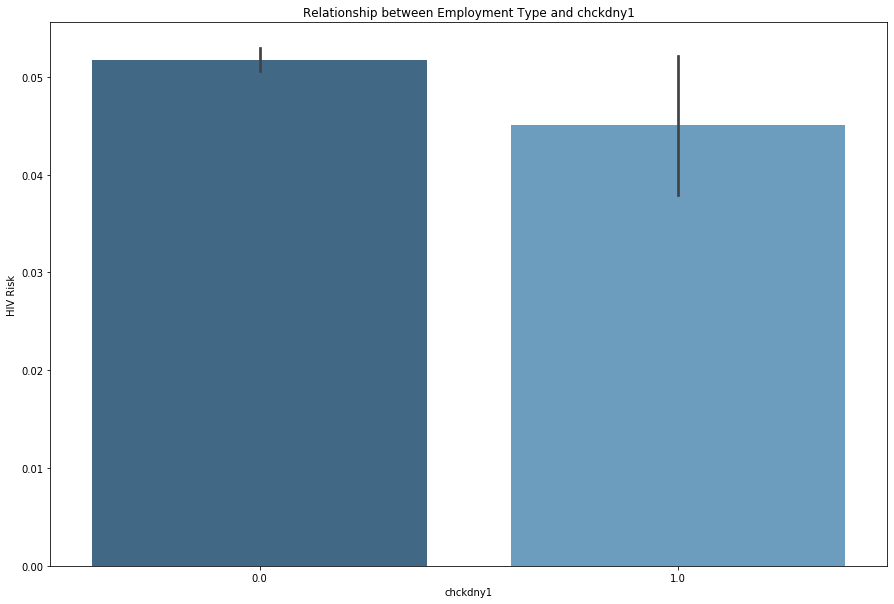

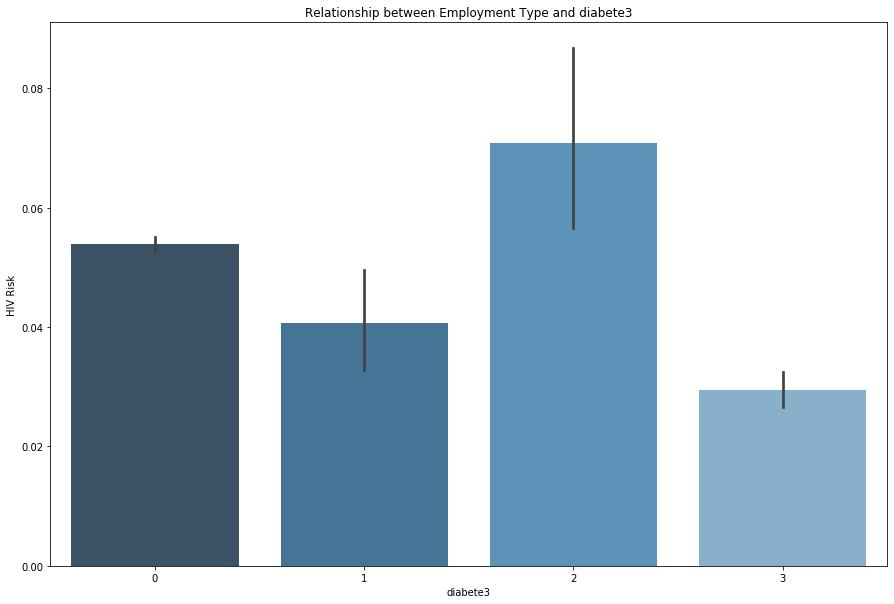

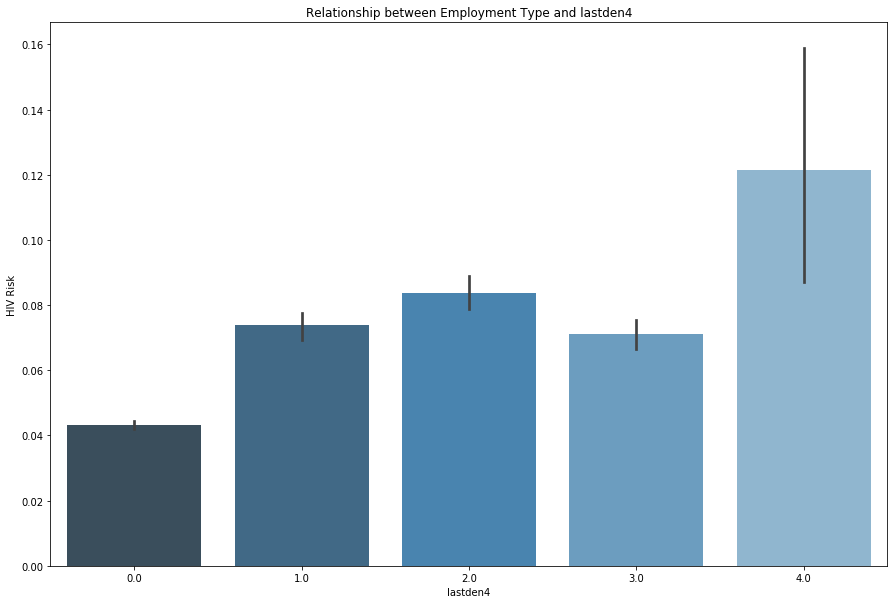

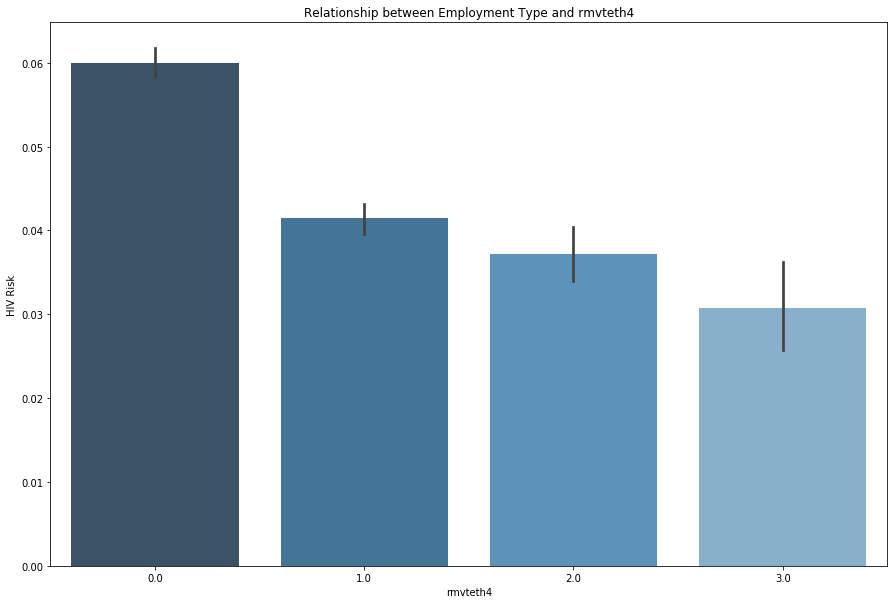

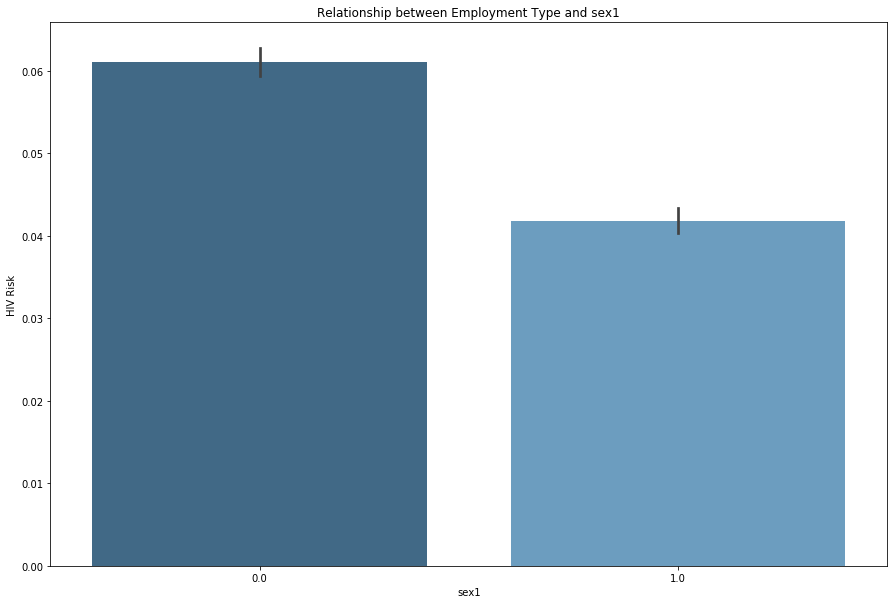

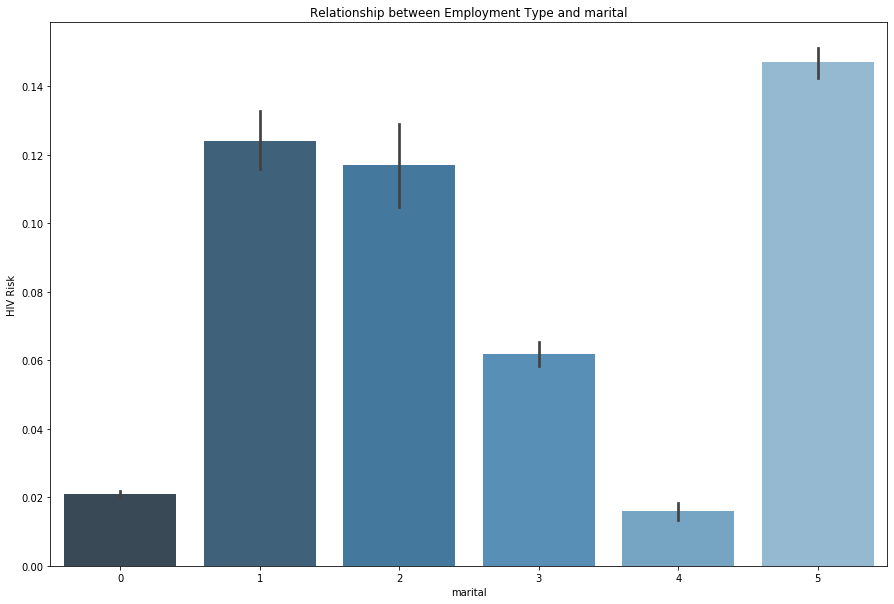

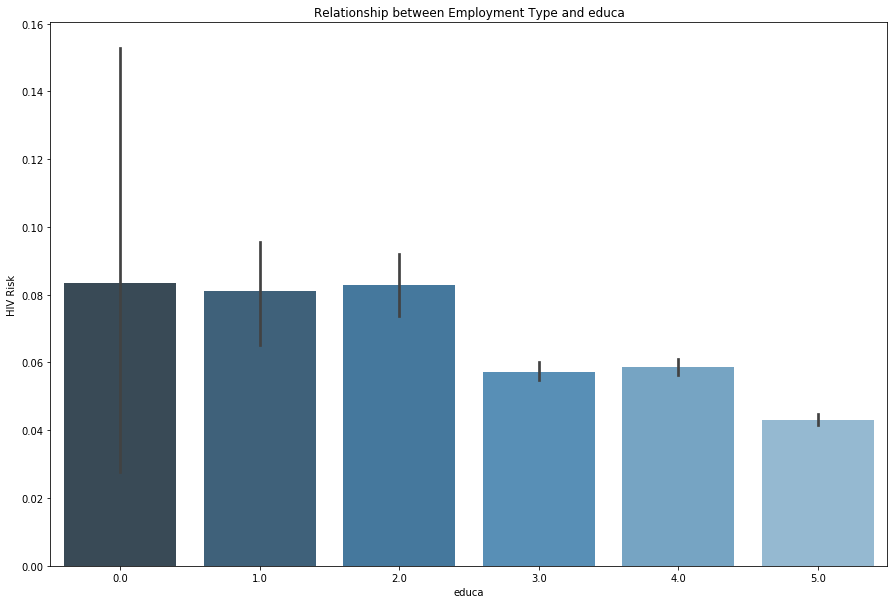

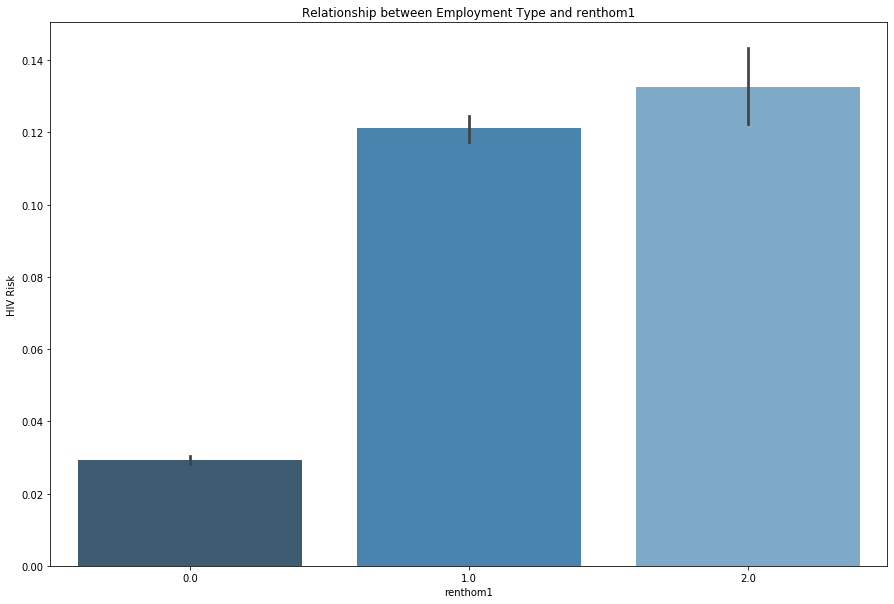

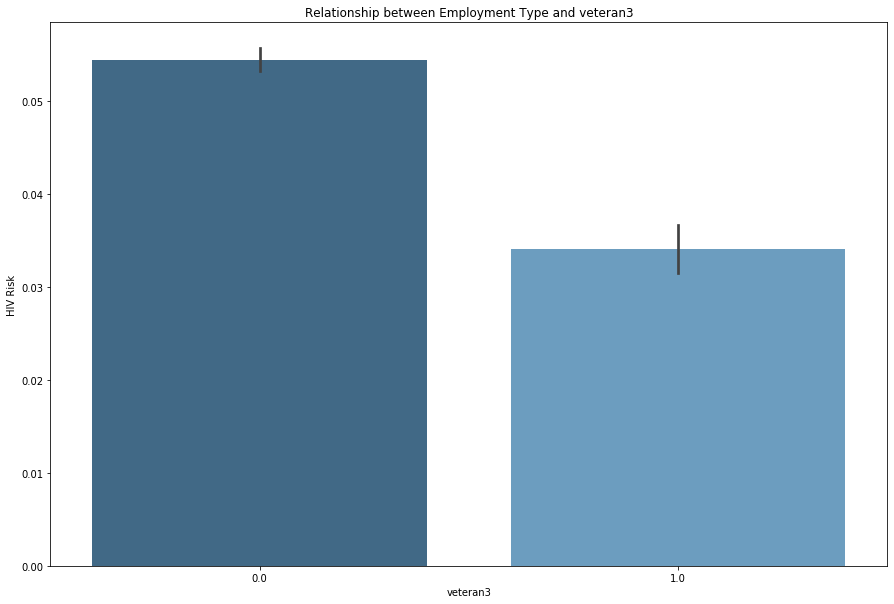

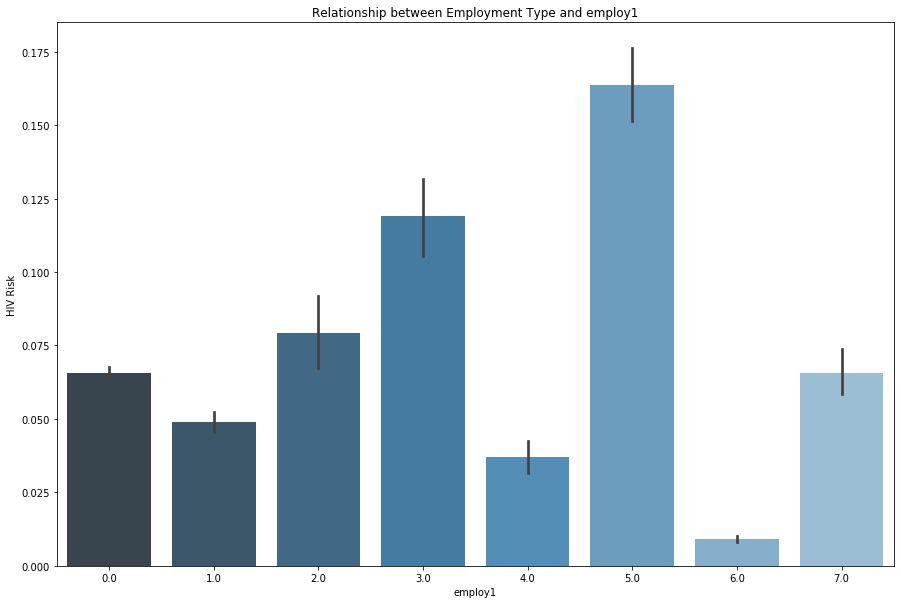

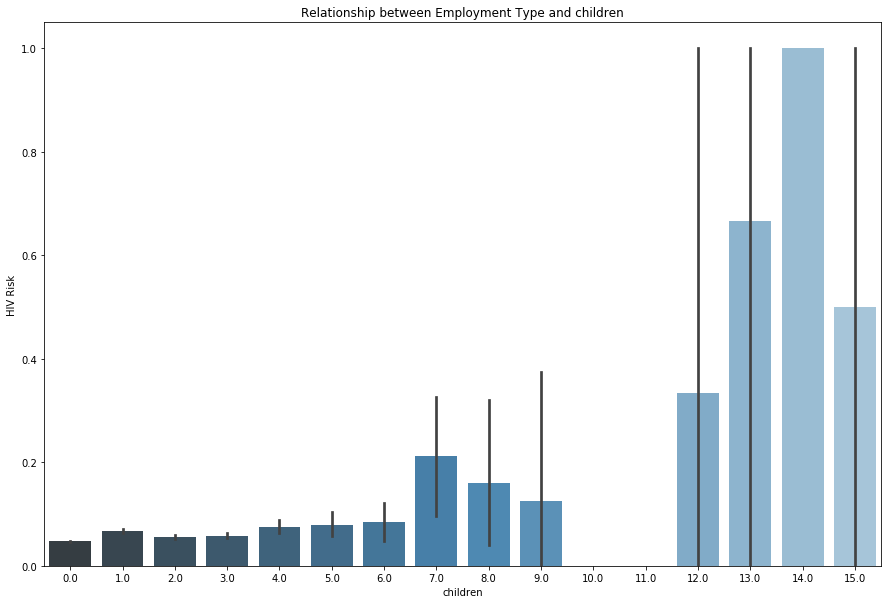

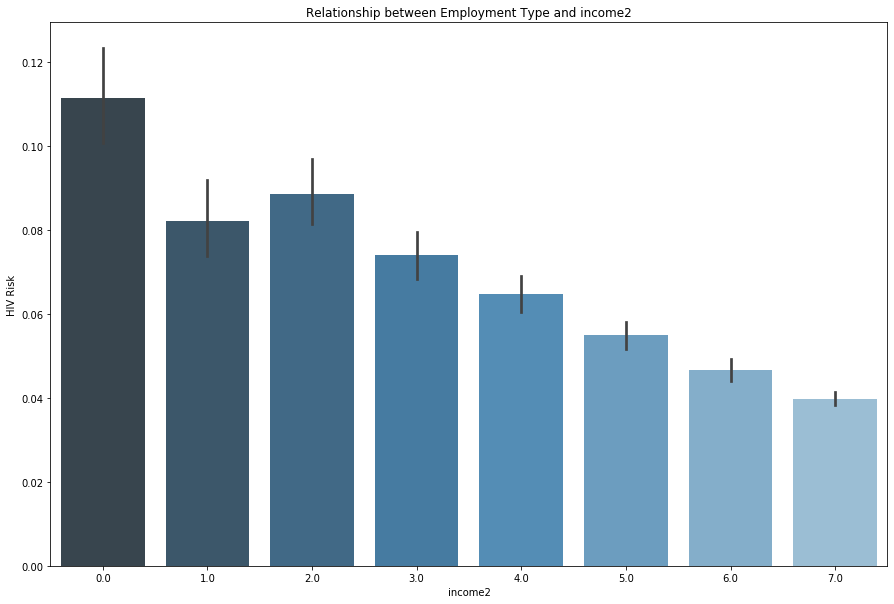

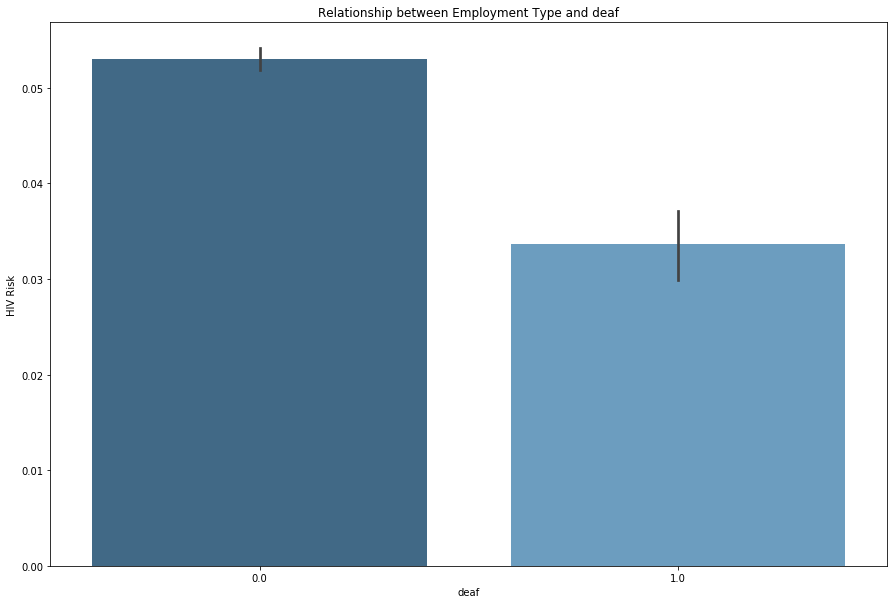

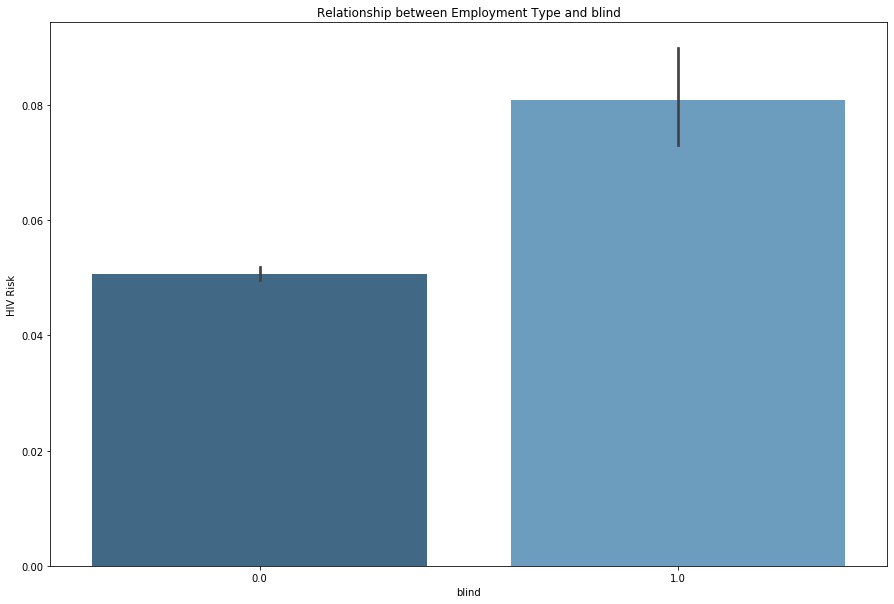

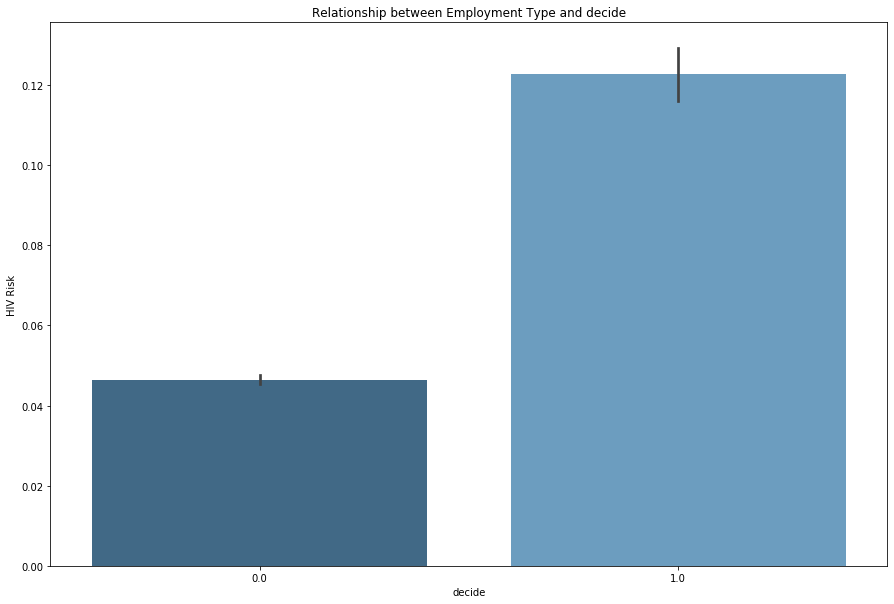

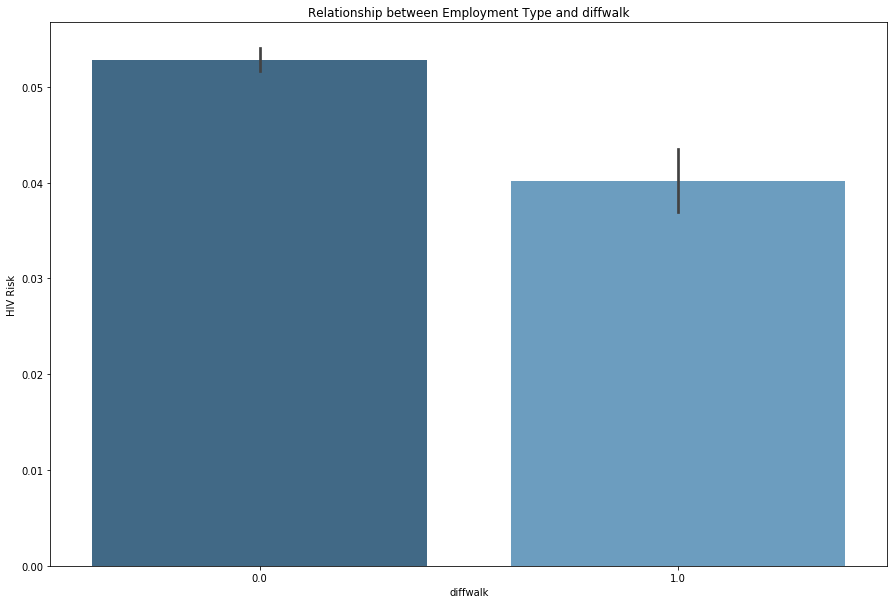

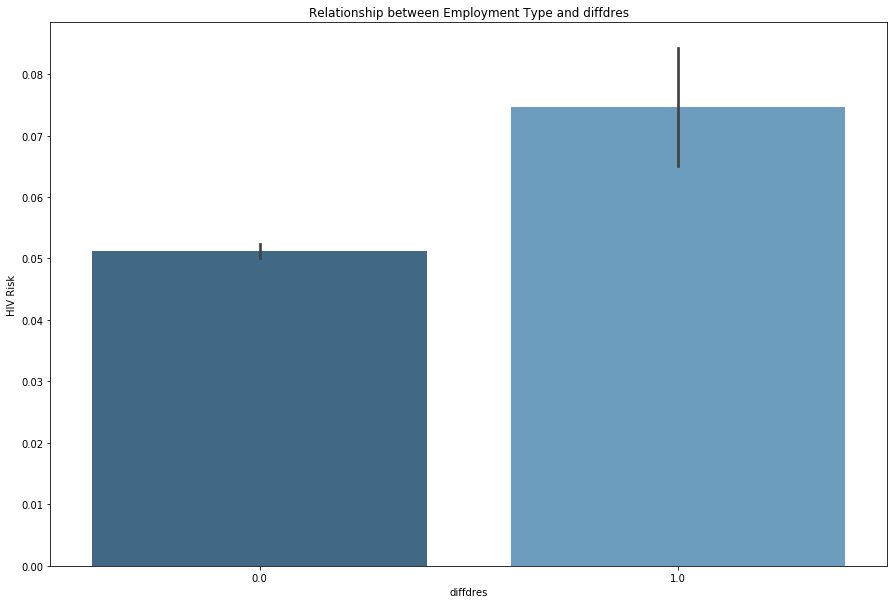

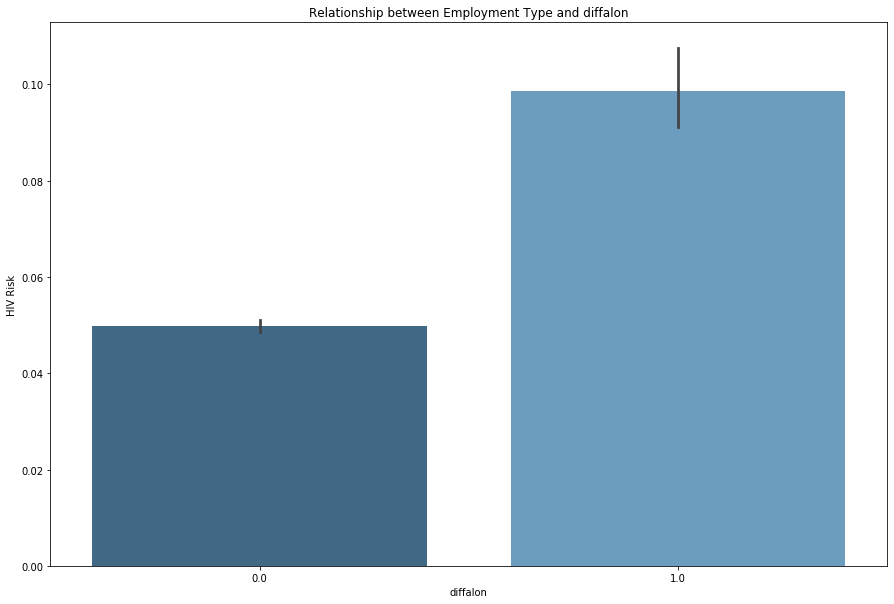

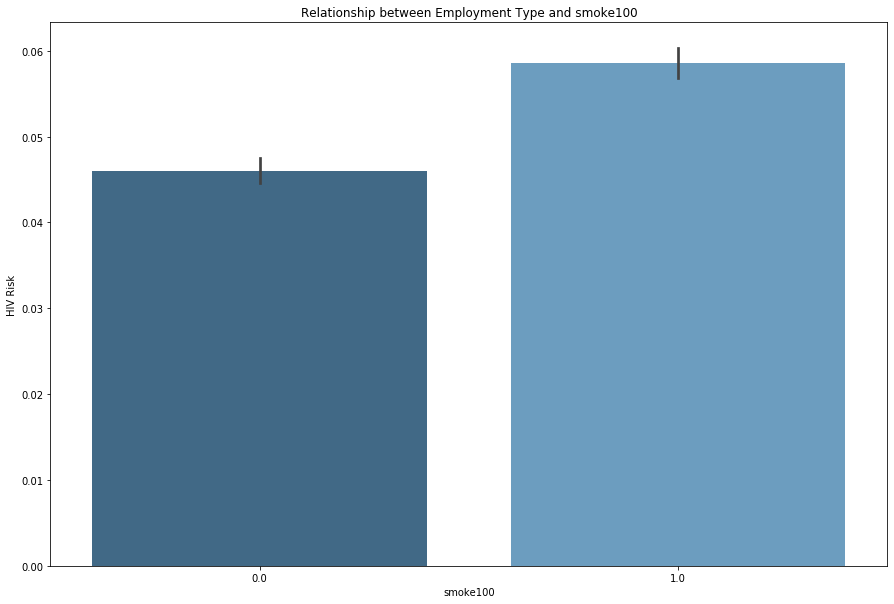

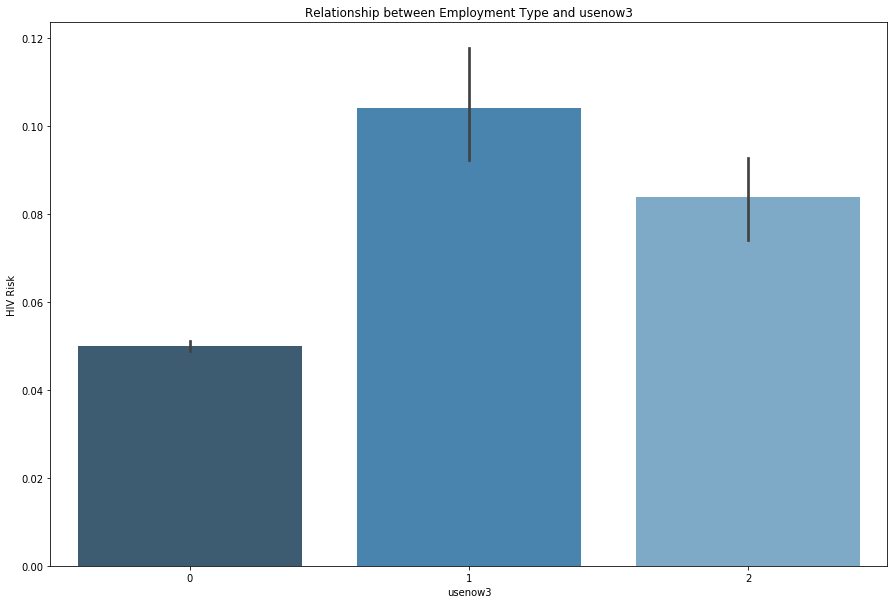

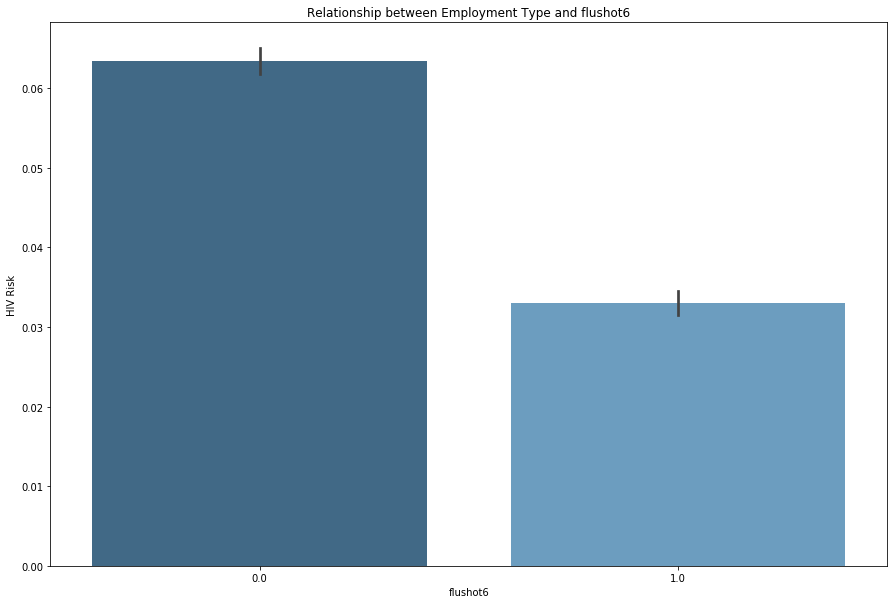

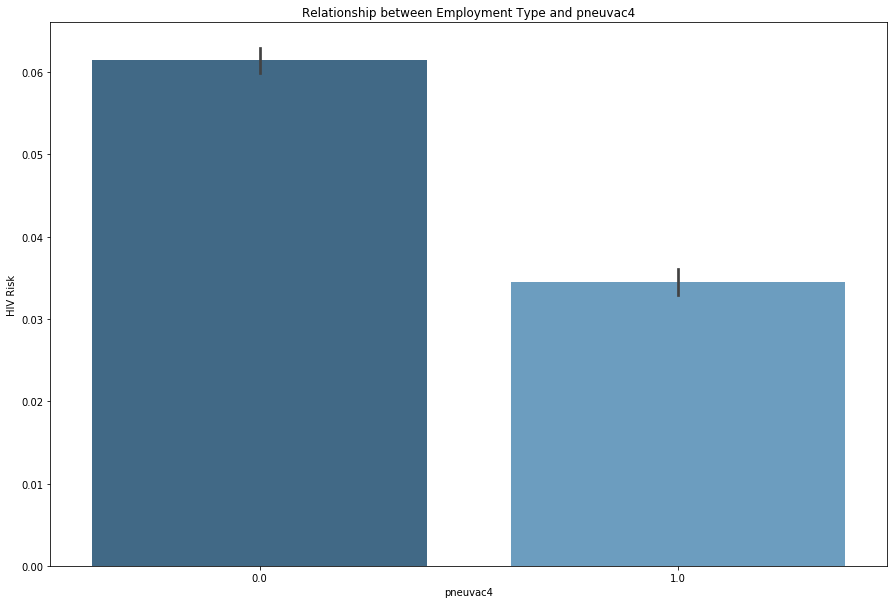

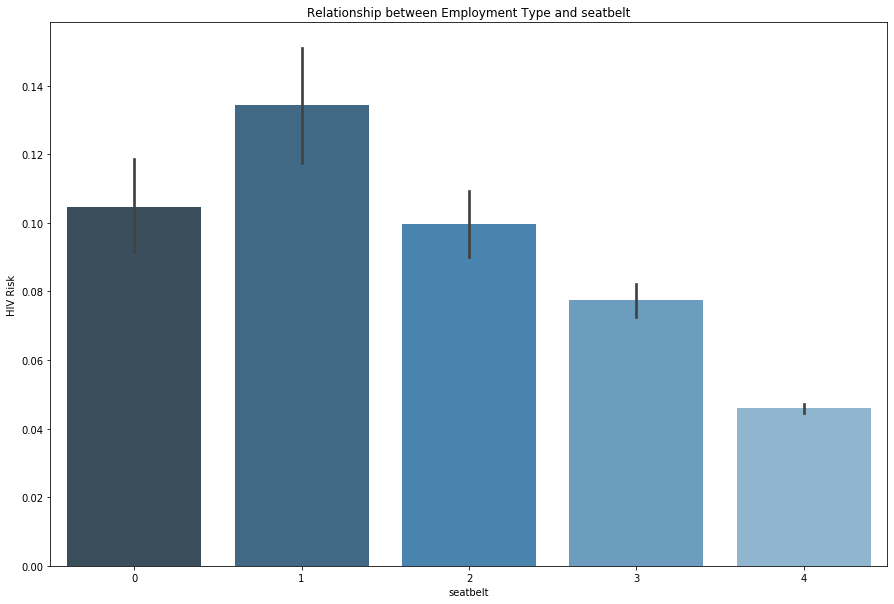

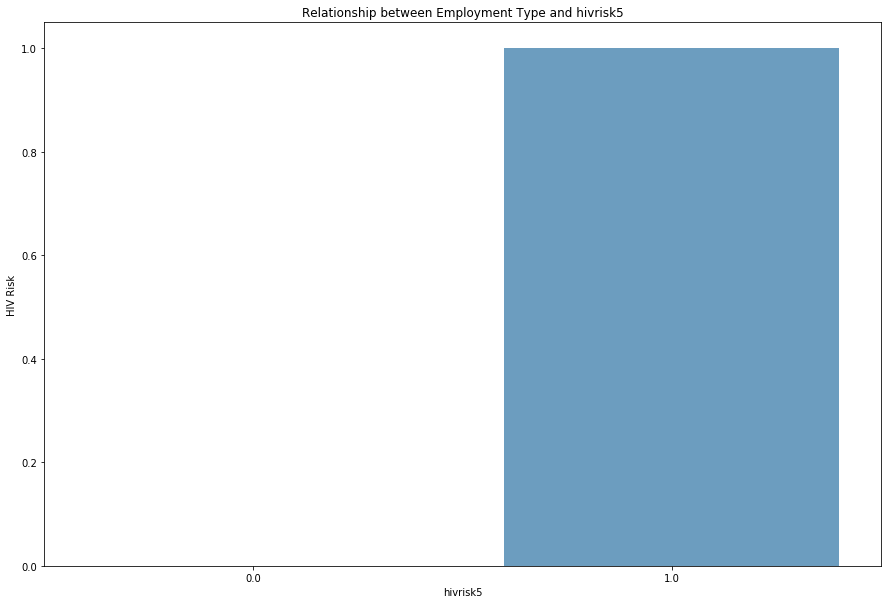

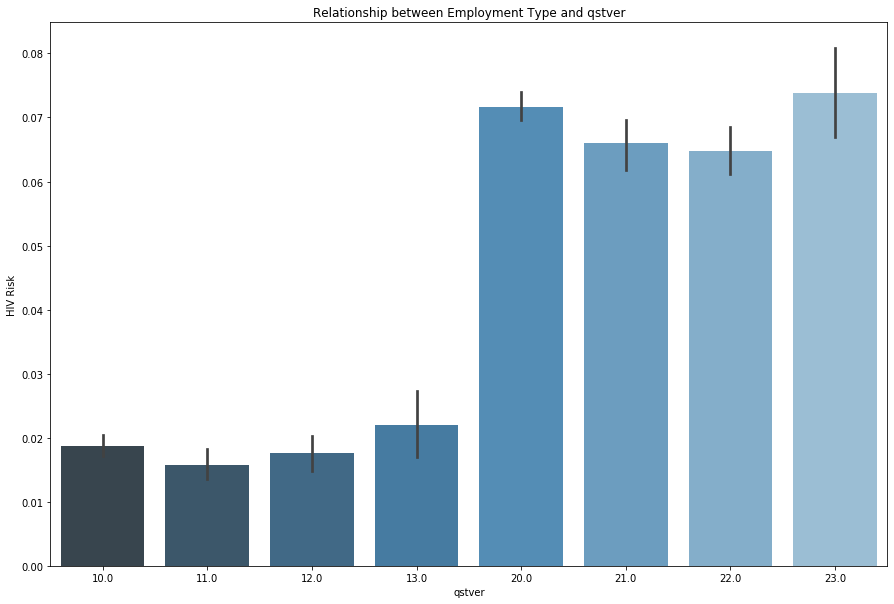

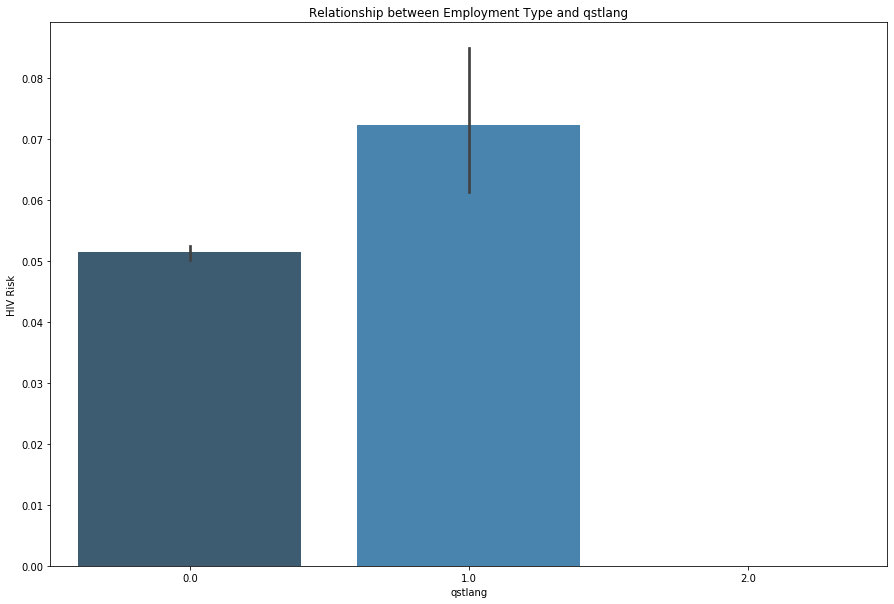

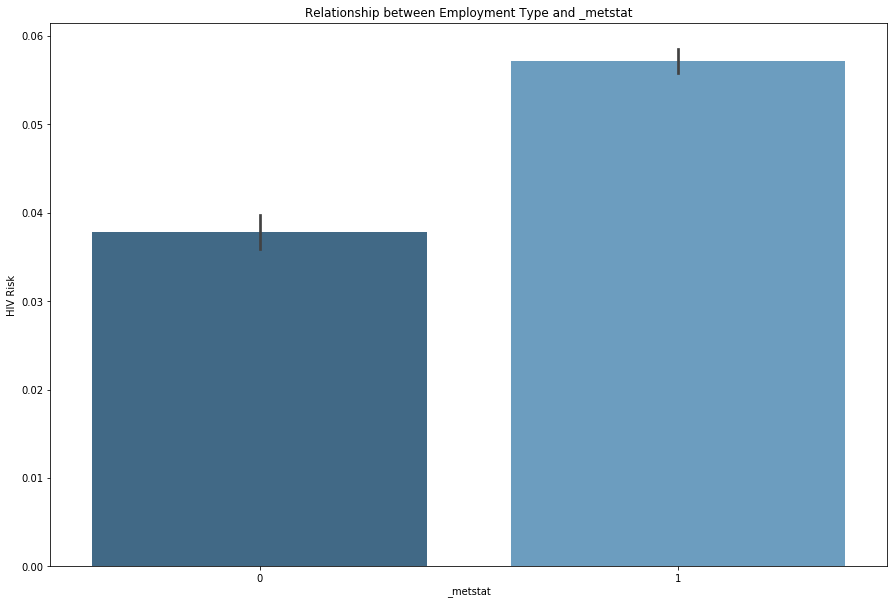

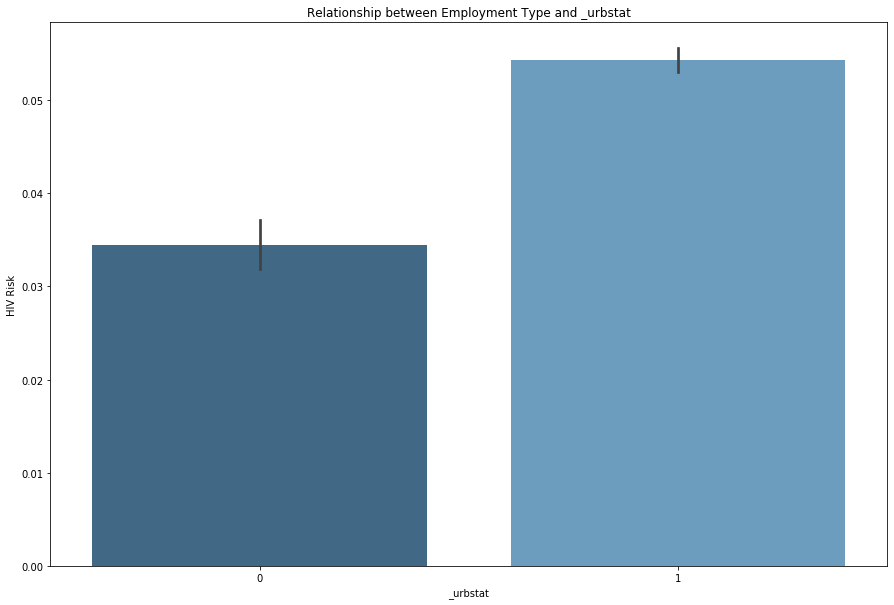

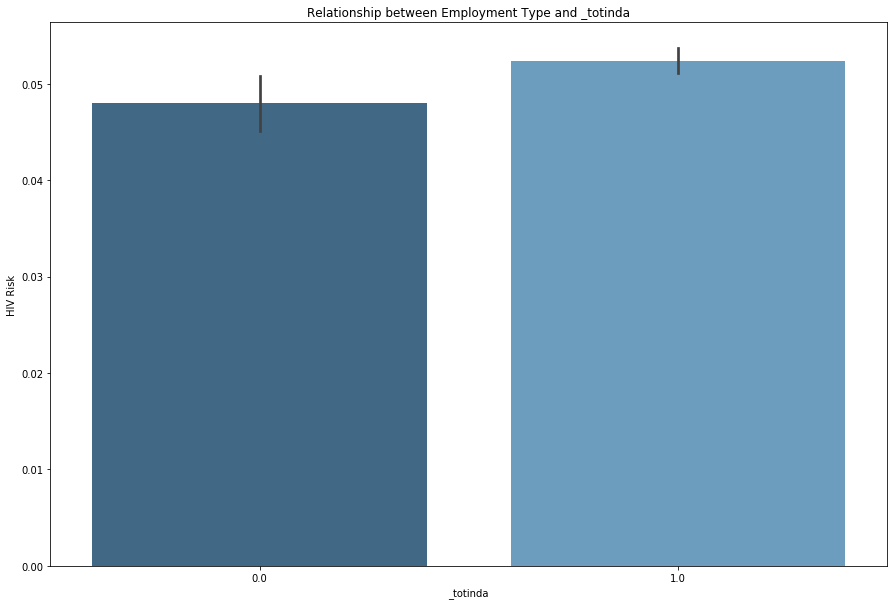

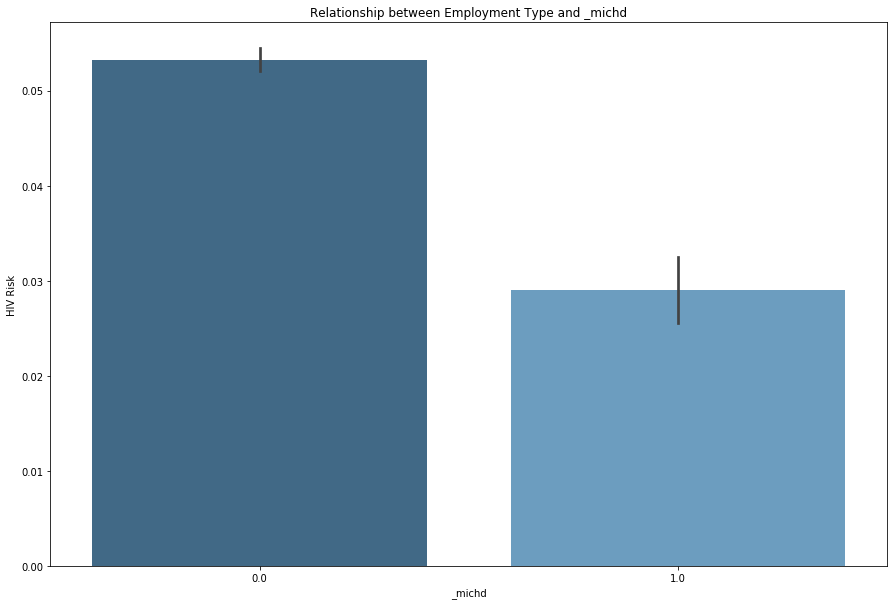

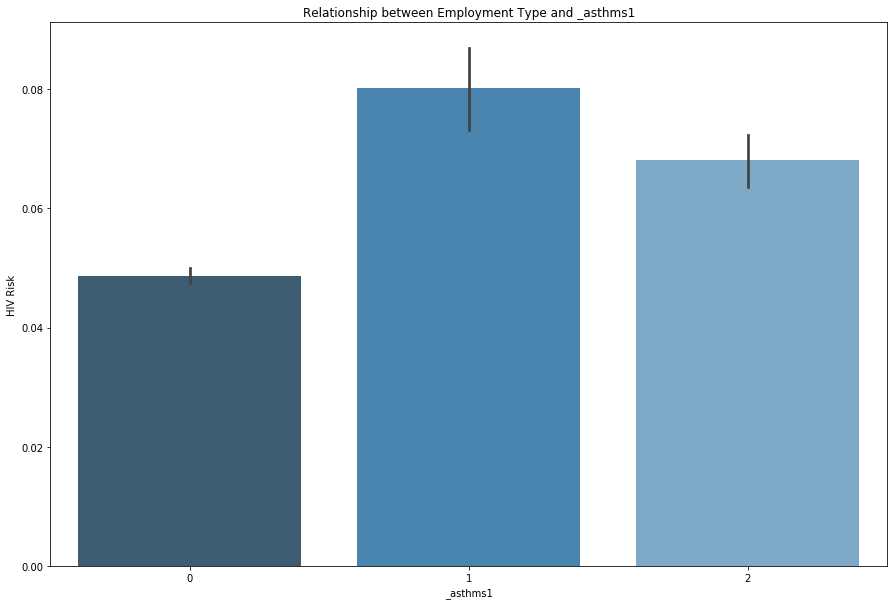

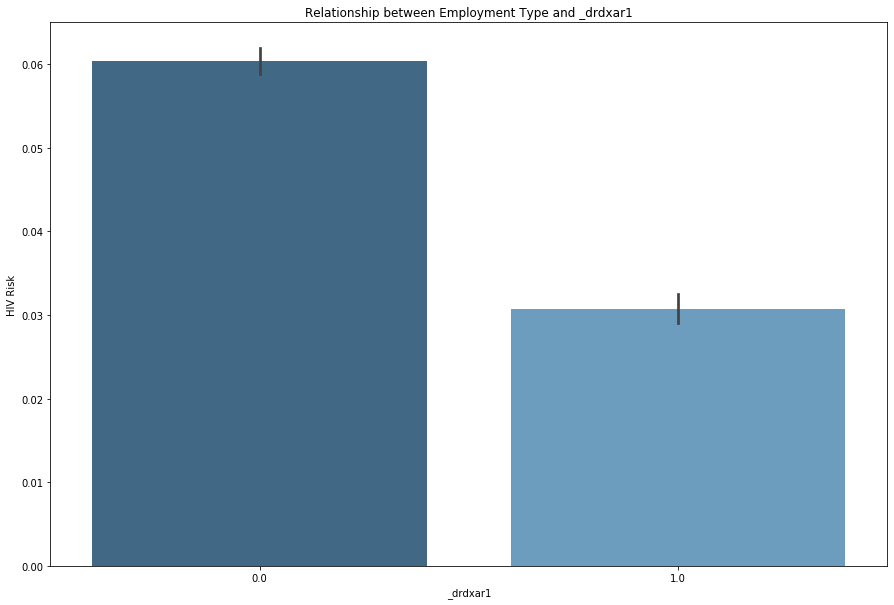

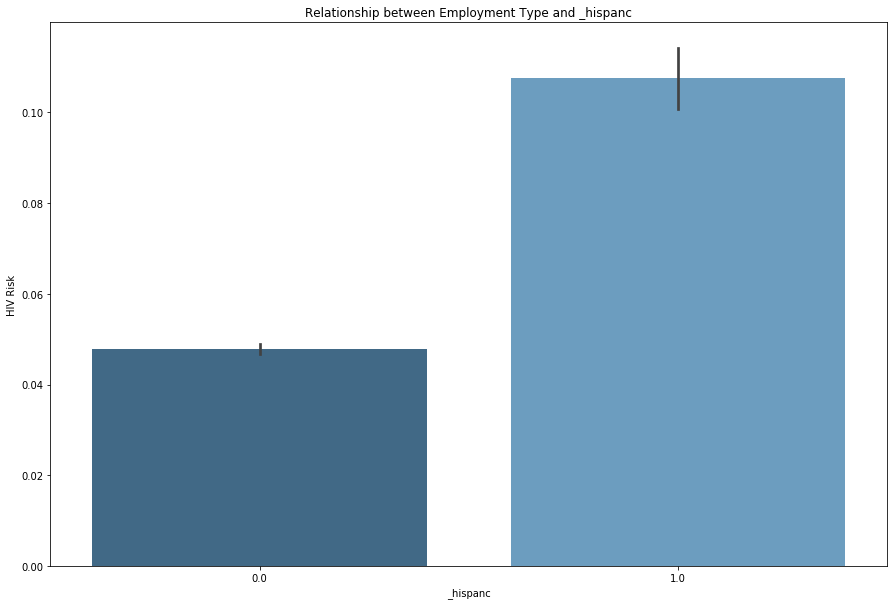

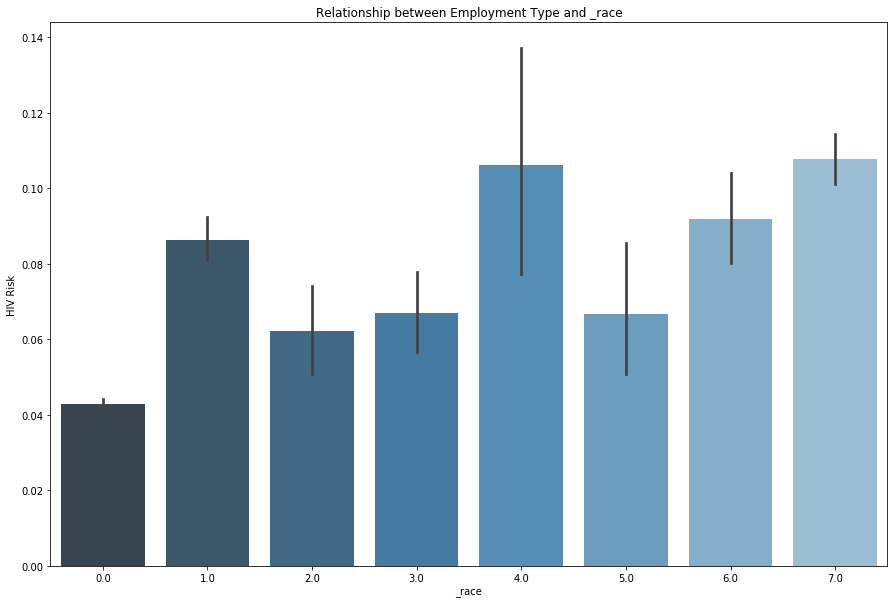

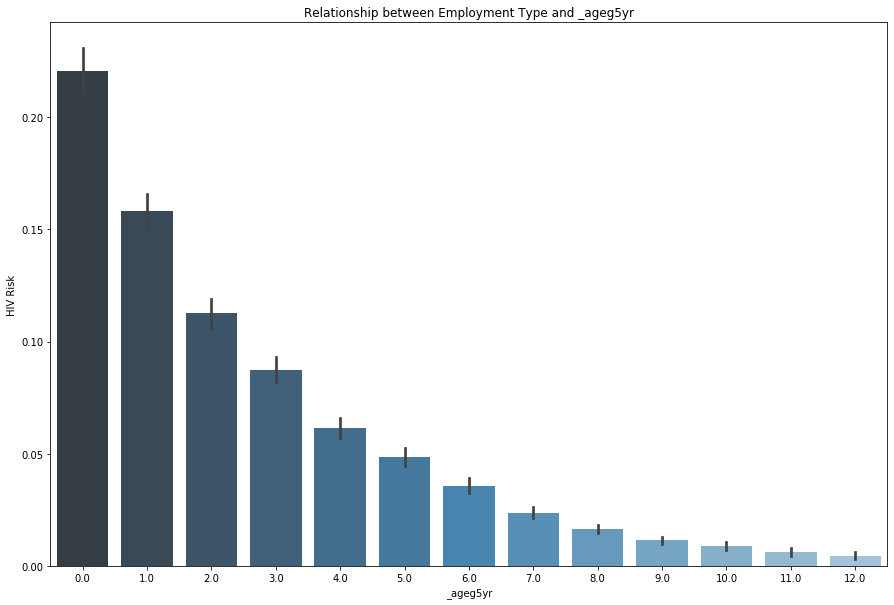

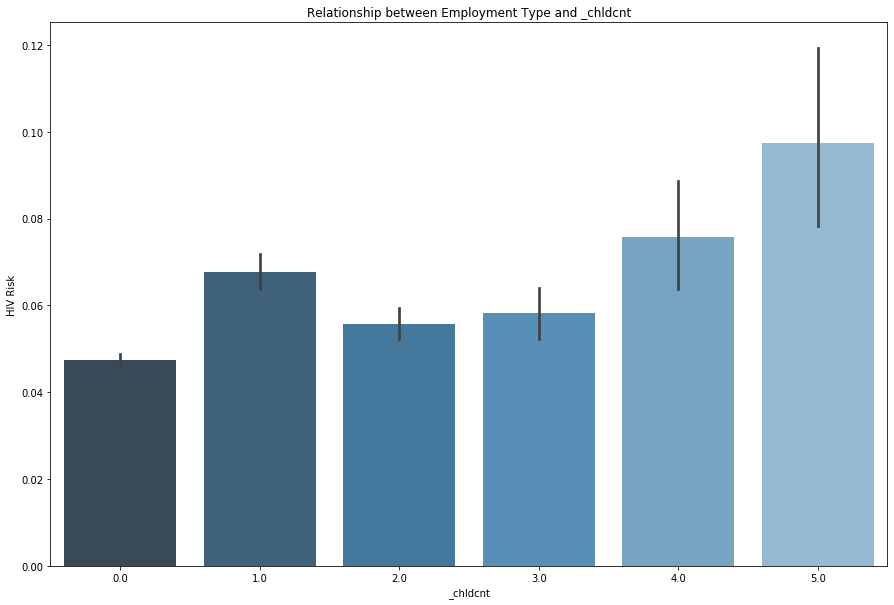

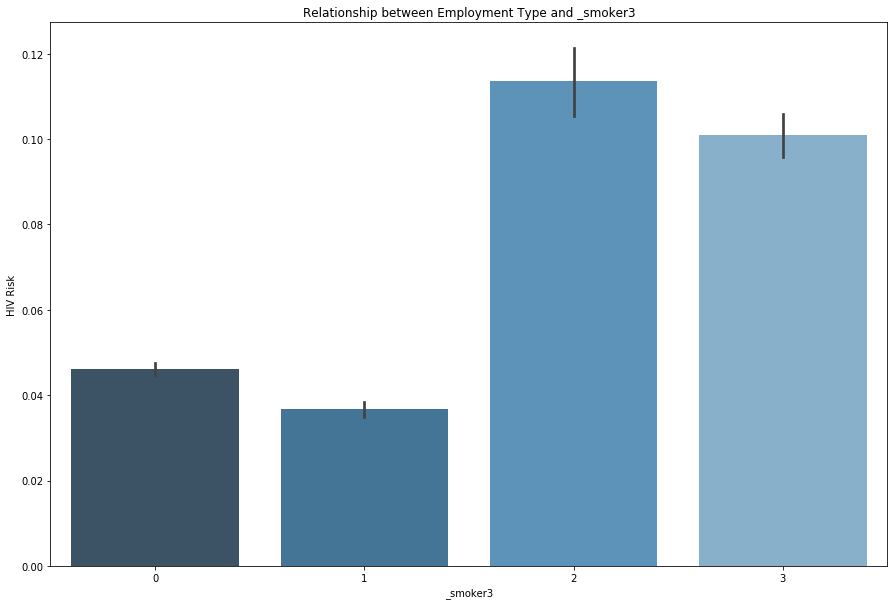

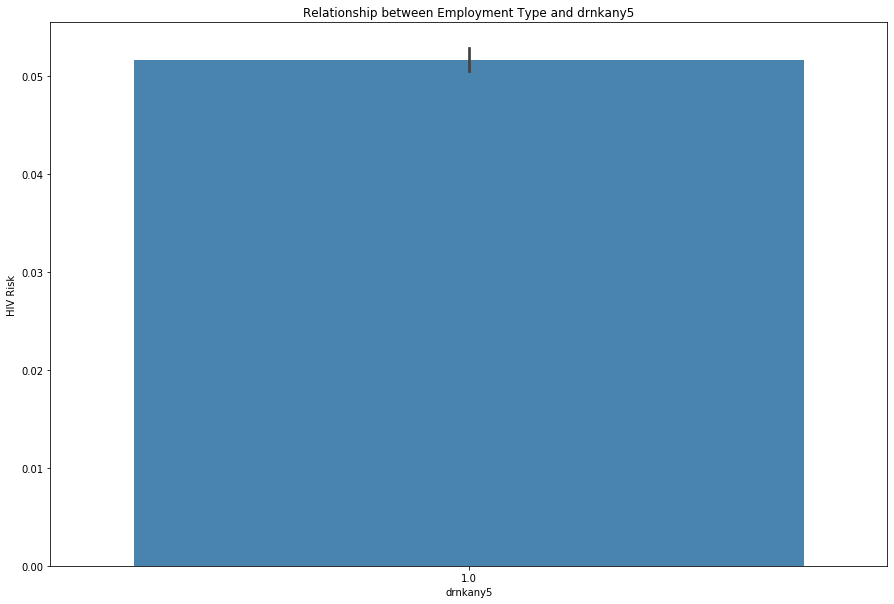

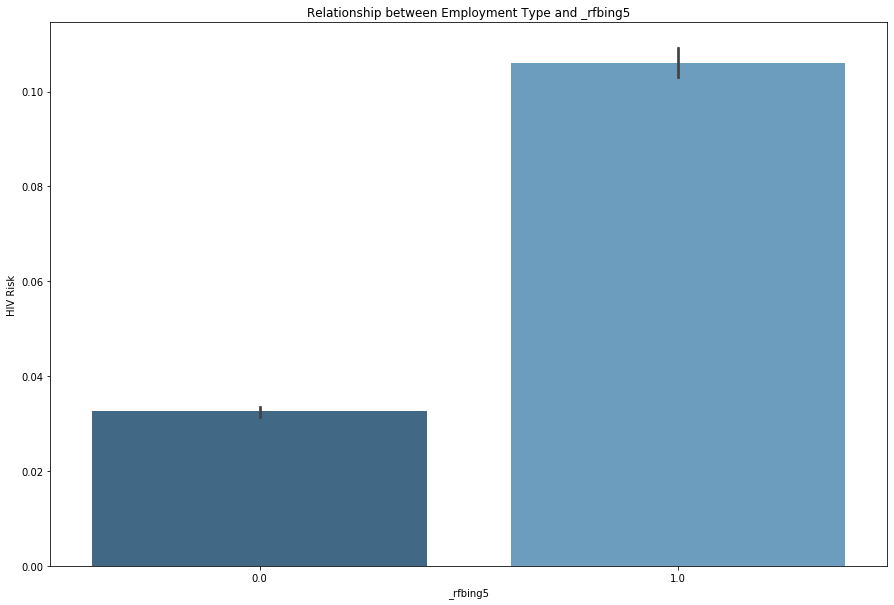

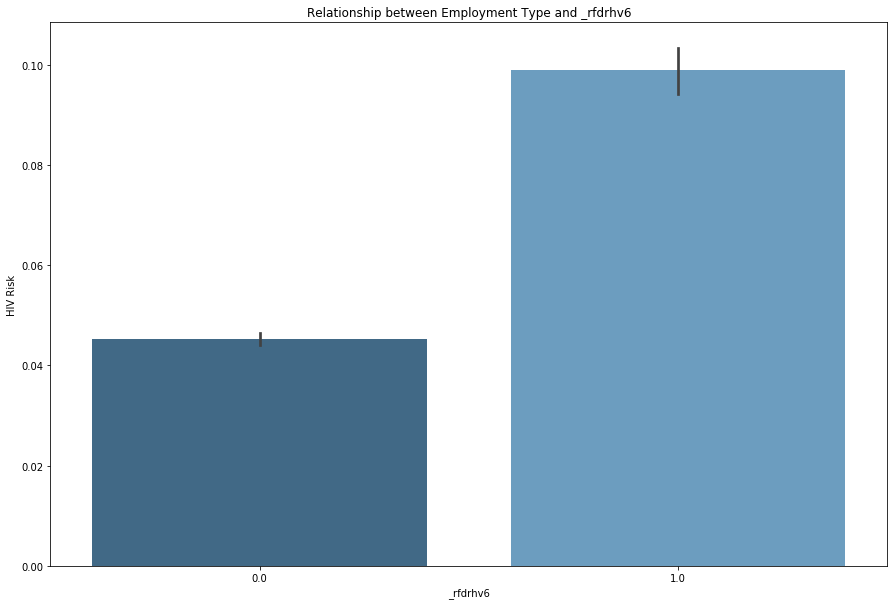

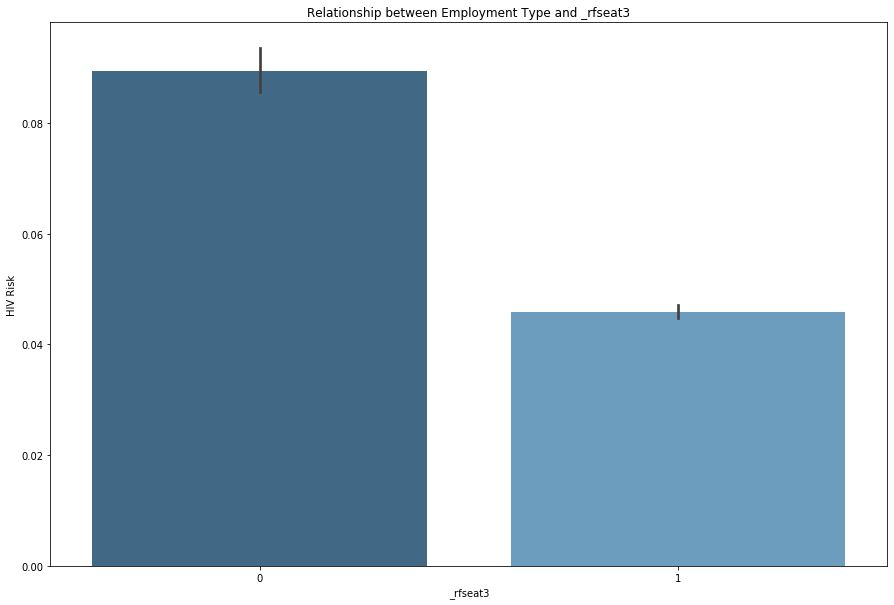

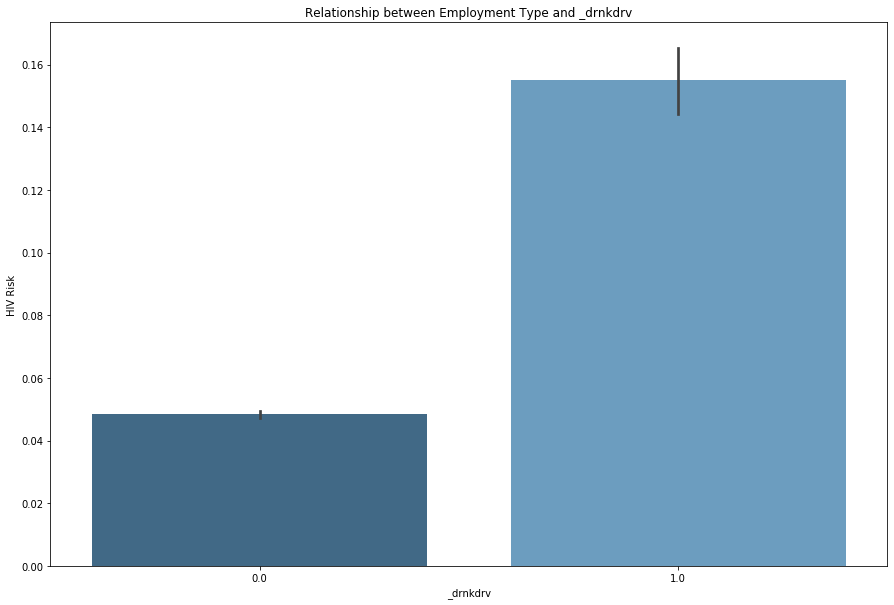

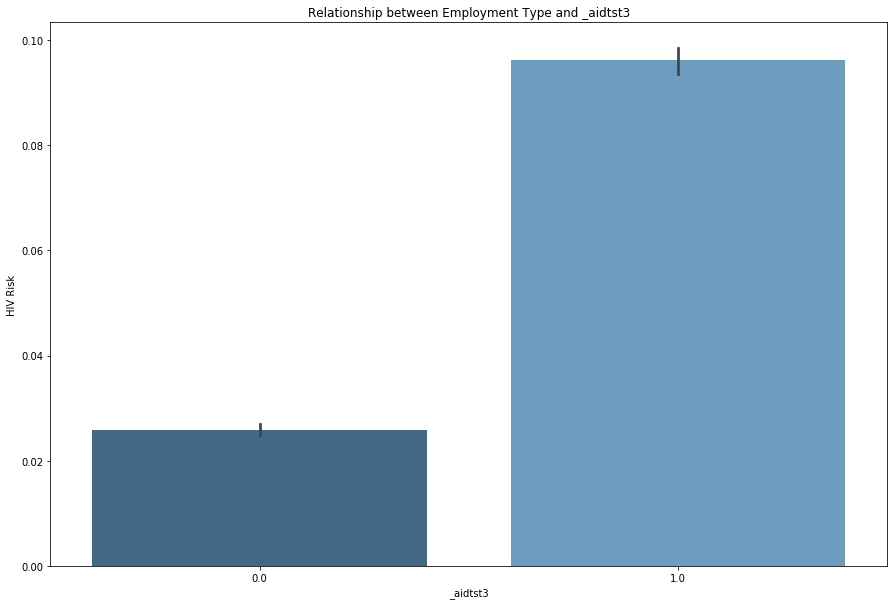

In [181]:
# One more large-scale analysis of a var - let's do HIV risk to look at a more behavioral var this time
for col in brfss_desc:
    sns.barplot(x=col, y='hivrisk5', palette='Blues_d', data=brfss_desc)
    plt.title('Relationship between HIV Risk and {}'.format(col))
    plt.xlabel('{}'.format(col))
    plt.ylabel('HIV Risk')
    
    plt.gcf().set_size_inches(15,10)
    
    plt.show()

In [104]:
# Make a dataframe slice with just continuous vars + sleep time 
brfss_desc_continuous = brfss_eda[['_bmi5', 'htin4', 'wtkg3', 'sleptim1']]

In [105]:
brfss_desc_continuous.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 437436 entries, 0 to 437435
Data columns (total 4 columns):
_bmi5       437436 non-null float64
htin4       437436 non-null float64
wtkg3       437436 non-null float64
sleptim1    437436 non-null float64
dtypes: float64(4)
memory usage: 13.3 MB


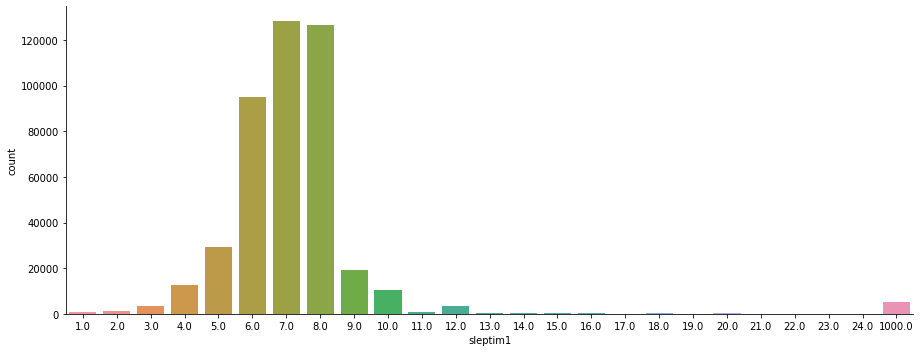

In [106]:
# Seeing that the missing category (1000) is there in this slice
sns.catplot(x='sleptim1', kind='count', data=brfss_desc_continuous)
plt.gcf().set_size_inches(15,5)

In [107]:
# Removing missing category for plotting
brfss_desc_continuous = brfss_desc_continuous[brfss_desc_continuous['sleptim1'] < 999]

In [108]:
# Checking missing are gone
brfss_desc_continuous['sleptim1'].value_counts()

7.0     128272
8.0     126353
6.0      94849
5.0      29241
9.0      19241
4.0      12696
10.0     10282
12.0      3292
3.0       3239
2.0       1403
1.0        881
11.0       653
14.0       374
16.0       358
15.0       330
18.0       176
13.0       169
20.0       139
24.0        65
17.0        38
22.0        16
23.0        16
21.0        10
19.0         6
Name: sleptim1, dtype: int64

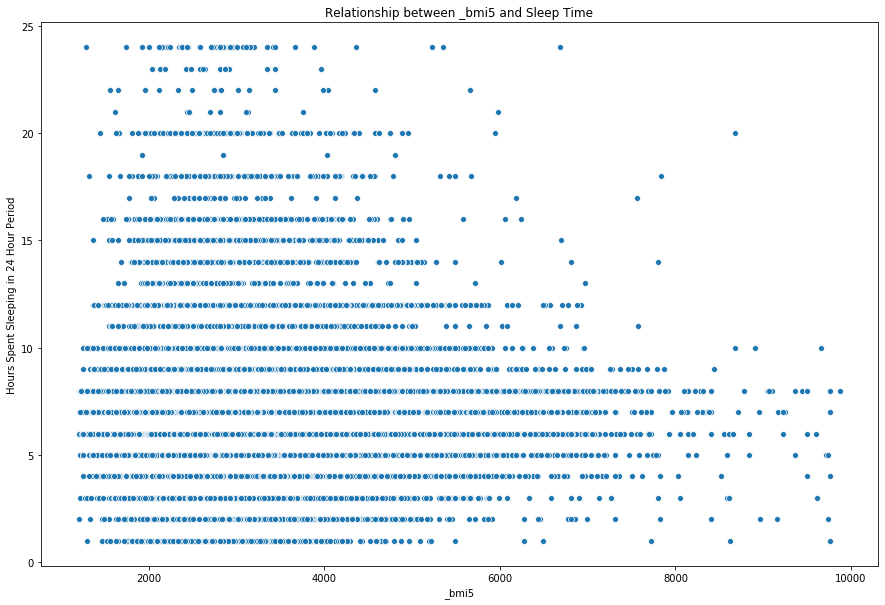

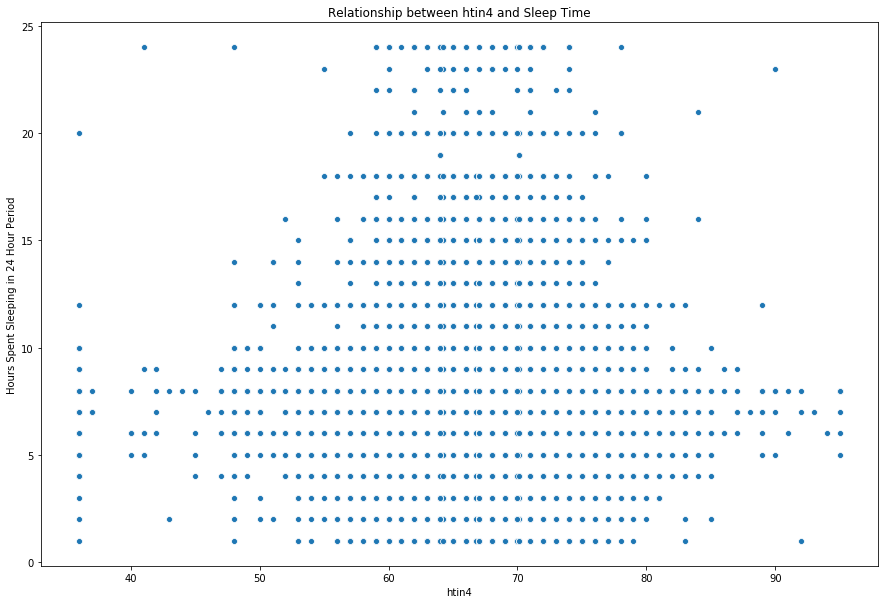

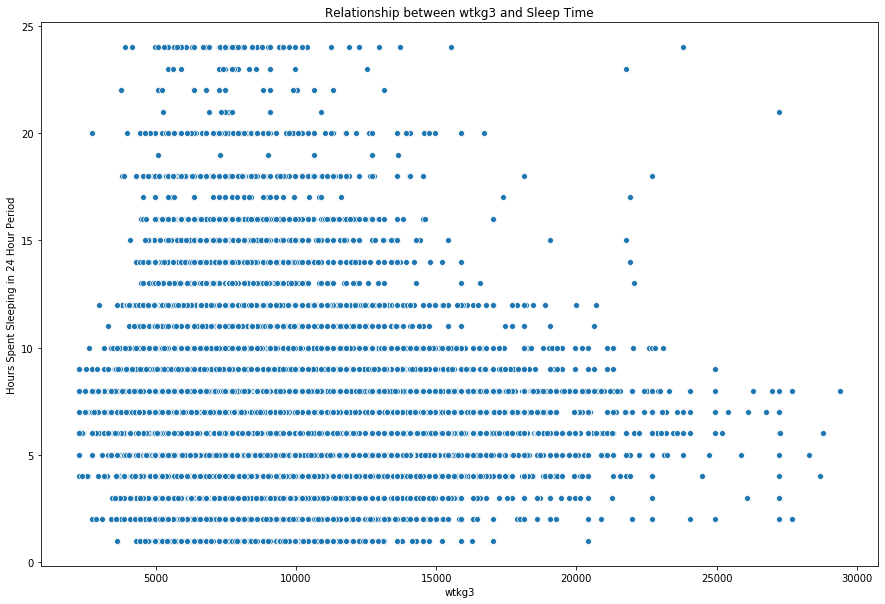

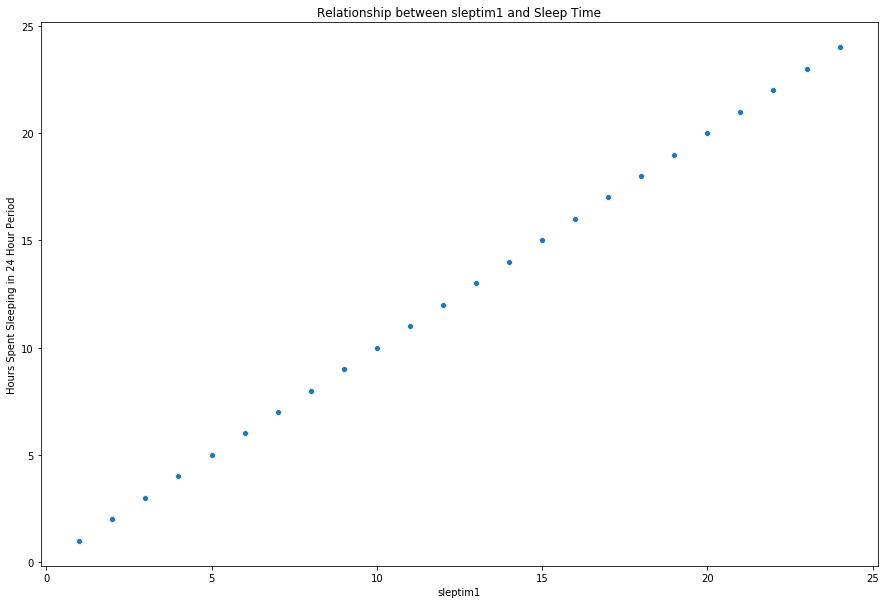

In [109]:
# Make scatterplots with sleeptime & the 3 continuous vars

for col in brfss_desc_continuous:
    sns.scatterplot(x=col, y='sleptim1', data=brfss_desc_continuous)
    
    plt.title('Relationship between {} and Sleep Time'.format(col))
    plt.xlabel('{}'.format(col))
    plt.ylabel('Hours Spent Sleeping in 24 Hour Period')
    plt.gcf().set_size_inches(15,10)
    
    plt.show()

Well, nothing too illuminating there. Although, it looks like people with the highest bmi's are tending to sleep for fewer hours, while people with lower bmi's are sleeping a bit more. There's a similar phenomenon with weight too, which makes sense.

Now is a good time to check for multicollinearity among all these variables, as that will help me to further eliminate variables I don't want in my eventual X. I'm going to use Spearman correlations rather than Pearson because most of my variables are categorical, and the continuous variables do have some skew as well. 

In [110]:
# Getting the correlation matrix
brfss_eda.corr(method='spearman')

_state  dispcode   genhlth  physhlth  menthlth  hlthpln1  \
_state    1.000000  0.038805  0.006881  0.003279  0.003252  0.003558   
dispcode  0.038805  1.000000  0.016647  0.018498 -0.008016  0.041981   
genhlth   0.006881  0.016647  1.000000  0.455373  0.236557 -0.041290   
physhlth  0.003279  0.018498  0.455373  1.000000  0.306531  0.006004   
menthlth  0.003252 -0.008016  0.236557  0.306531  1.000000 -0.036998   
hlthpln1  0.003558  0.041981 -0.041290  0.006004 -0.036998  1.000000   
persdoc2 -0.003987  0.056829  0.073553  0.088316 -0.013235  0.242187   
medcost   0.009350 -0.029011  0.157238  0.148692  0.186640 -0.238626   
checkup1  0.008042 -0.026932 -0.073984 -0.069452  0.035127 -0.212501   
sleptim1 -0.002868  0.002499 -0.070813 -0.069125 -0.126946  0.026447   
cvdinfr4  0.001787  0.009721  0.190407  0.135286  0.027877  0.023708   
cvdcrhd4  0.002232  0.022387  0.205270  0.146903  0.030172  0.035896   
cvdstrk3 -0.005805  0.005224  0.164762  0.132046  0.052436  0.020526   
asthma3   0.001384  0.002734  0.138873  0.149221  0.128037  0.009571   
chcscncr -0.016194  0.036357  0.032739  0.035391 -0.035374  0.065085   
chcocncr -0.002520  0.032067  0.139028  0.104524  0.004747  0.053404   
chccopd1 -0.003535  0.017806  0.256615  0.220778  0.107318  0.019451   
addepev2  0.023503  0.025070  0.226487  0.239329  0.431850 -0.004054   
chckdny1 -0.001906  0.012215  0.161956  0.133057  0.040017  0.022667   
diabete3 -0.000187  0.026798  0.273519  0.161248  0.035353  0.038346   
lastden4 -0.008068 -0.019570  0.208245  0.117913  0.092426 -0.157446   
rmvteth4  0.004104  0.038929  0.286819  0.177246  0.032028  0.008203   
sex1      0.004194  0.026787  0.011263  0.060551  0.095786  0.045779   
marital  -0.013781 -0.029503  0.096641  0.073475  0.130757 -0.073589   
educa    -0.008176  0.020891 -0.257154 -0.109413 -0.054962  0.153645   
renthom1 -0.018994 -0.097916  0.114486  0.089826  0.174306 -0.155941   
veteran3 -0.004712 -0.013949  0.030399  0.006806 -0.059874  0.049841   
employ1  -0.010186  0.030403  0.266551  0.228829  0.031491  0.070943   
children  0.001077 -0.086058 -0.073411 -0.053706  0.056349 -0.091550   
income2  -0.014372 -0.060911 -0.203425 -0.135037 -0.114565  0.107069   
deaf     -0.002770 -0.145897  0.123478  0.092168  0.021253  0.012458   
blind    -0.005895 -0.199965  0.149392  0.119514  0.079140 -0.027650   
decide   -0.005753 -0.171181  0.235334  0.217026  0.289200 -0.039845   
diffwalk -0.009469 -0.136866  0.370828  0.351020  0.137562  0.019545   
diffdres -0.016093 -0.261826  0.184264  0.188602  0.108337 -0.011214   
diffalon -0.010502 -0.224951  0.241996  0.239594  0.172712 -0.010200   
smoke100 -0.019404 -0.138282  0.152847  0.088645  0.062026 -0.030286   
usenow3  -0.011413 -0.333543  0.015331 -0.007794 -0.001667 -0.039380   
flushot6 -0.009612 -0.180767  0.025409  0.019883 -0.046192  0.103914   
pneuvac4 -0.010674 -0.174432  0.095485  0.077845 -0.000848  0.085445   
seatbelt -0.027038 -0.303020 -0.032731 -0.014876 -0.034825  0.021312   
hivrisk5 -0.021578 -0.565993  0.009619  0.006964  0.055825 -0.051519   
qstver   -0.106387 -0.077916 -0.057642 -0.031672  0.069722 -0.087946   
qstlang   0.069197 -0.009856  0.089404 -0.003250 -0.028801 -0.192540   
_metstat -0.029860 -0.053993 -0.043371 -0.017260  0.014975 -0.000131   
_urbstat  0.045061 -0.036209 -0.028728 -0.011699  0.012281  0.001807   
_totinda -0.004031 -0.005214 -0.276679 -0.194927 -0.074617  0.047745   
_michd    0.001878  0.020671  0.234789  0.166417  0.034049  0.034233   
_asthms1  0.001556  0.003010  0.142838  0.152896  0.129406  0.010166   
_drdxar1  0.004272  0.063346  0.284396  0.263630  0.080258  0.084525   
_hispanc  0.012419 -0.052748  0.063646 -0.002138  0.005108 -0.162775   
_race    -0.039757 -0.073322  0.095181  0.011409  0.023093 -0.152660   
_ageg5yr -0.006158  0.109010  0.142158  0.072130 -0.190147  0.182921   
htin4    -0.001268 -0.026872 -0.063467 -0.065333 -0.061153 -0.018256   
wtkg3     0.014365  0.012460  0.147162  0.050141 -0.

This is a super huge correlation matrix (obviously, since there are 64 features), so let's look at a heatmap representation of it. 

In [111]:
corrmat = brfss_eda.corr(method='spearman')

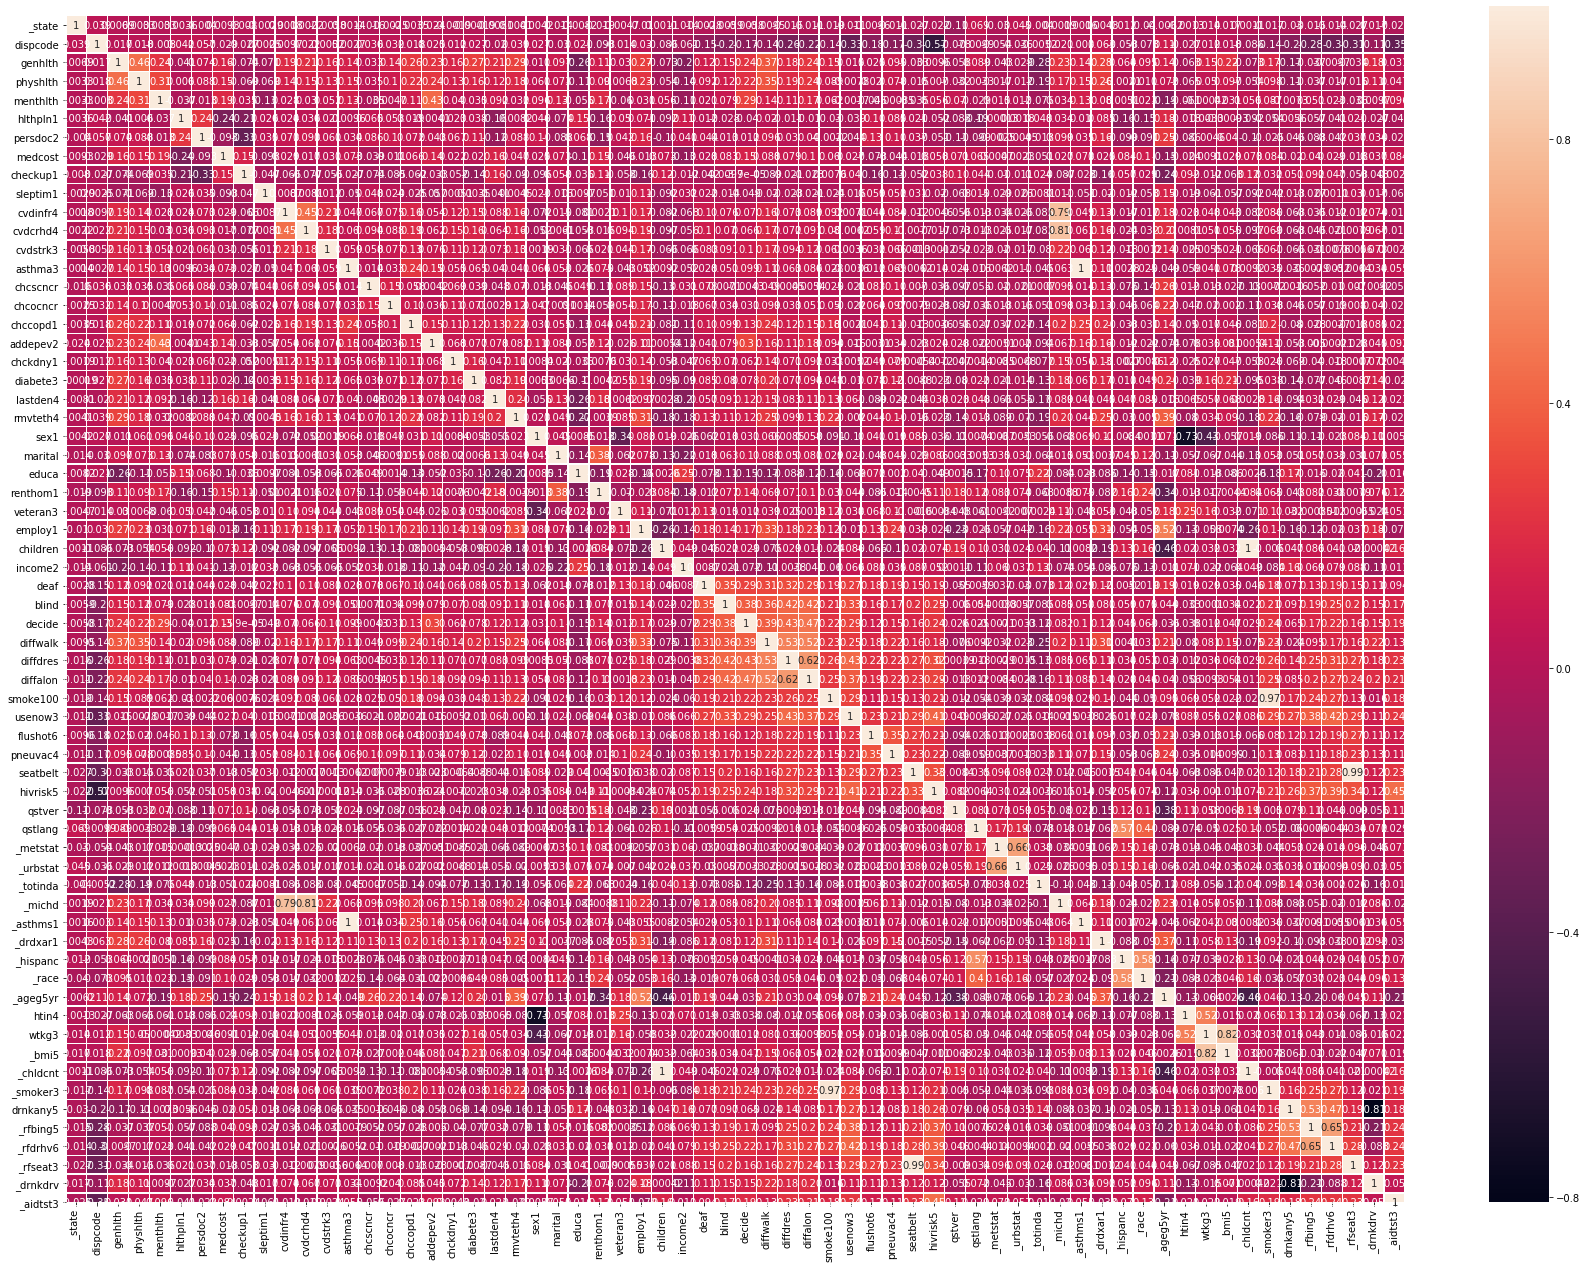

In [112]:
# Set dimensions of heatmap
hm_dims = (30, 22)

# Make heatmap
fig, ax = plt.subplots(figsize=hm_dims)
sns.heatmap(corrmat, square=False, annot=True, linewidths=.4, ax=ax)
ax.set_ylim(len(corrmat)-0.5, -0.5)      #using this line b/c workaround for a bug that cuts off top & bottom
plt.show()

In [113]:
brfss_eda.dtypes

_state      float64
imonth       object
iday         object
iyear        object
dispcode      int64
seqno        object
genhlth     float64
physhlth    float64
menthlth    float64
hlthpln1    float64
persdoc2      int64
medcost     float64
checkup1    float64
sleptim1    float64
cvdinfr4    float64
cvdcrhd4    float64
cvdstrk3    float64
asthma3     float64
chcscncr    float64
chcocncr    float64
chccopd1    float64
addepev2    float64
chckdny1    float64
diabete3      int64
lastden4    float64
rmvteth4    float64
sex1        float64
marital       int64
educa       float64
renthom1    float64
veteran3    float64
employ1     float64
children    float64
income2     float64
deaf        float64
blind       float64
decide      float64
diffwalk    float64
diffdres    float64
diffalon    float64
smoke100    float64
usenow3       int64
flushot6    float64
pneuvac4    float64
seatbelt      int64
hivrisk5    float64
qstver      float64
qstlang     float64
_metstat      int64
_urbstat      int64


So by checking the dtypes, I see that seqno, imonth, iday, and iyear are all considered objects, even though they appear as numeric values. I'm going to go ahead and drop them before I run the VIF, because they will throw an error. I could just change their dtype, but I'm reasonably sure I'm not going to put these in the final X when I run the clustering algorithms, so removing them now shouldn't be a problem.

In [114]:
# Removing object columns
brfss_eda = brfss_eda.drop(columns=['seqno', 'imonth', 'iday', 'iyear'])

In [115]:
# Function for VIF
def vif_cal(input_data, dependent_col):
    x_vars=input_data.drop([dependent_col], axis=1)
    xvar_names=x_vars.columns
    for i in range(0,xvar_names.shape[0]):
        y=x_vars[xvar_names[i]]
        x=x_vars[xvar_names.drop(xvar_names[i])]
        rsq=sm.OLS(endog=y, exog=x.astype(float), data=x_vars).fit().rsquared
        vif=round(1/(1-rsq),2)
        print (xvar_names[i], " VIF = " , vif)
        
#Call function, using sleptim1 as dependent var
vif_cal(input_data=brfss_eda, dependent_col="sleptim1")

_state  VIF =  4.98
dispcode  VIF =  12.58
genhlth  VIF =  1.04
physhlth  VIF =  1.11
menthlth  VIF =  1.1
hlthpln1  VIF =  1.04
persdoc2  VIF =  1.25
medcost  VIF =  1.26
checkup1  VIF =  1.15
cvdinfr4  VIF =  2.3
cvdcrhd4  VIF =  2.36
cvdstrk3  VIF =  1.18
asthma3  VIF =  1.89
chcscncr  VIF =  1.17
chcocncr  VIF =  1.18
chccopd1  VIF =  1.13
addepev2  VIF =  1.12
chckdny1  VIF =  1.14
diabete3  VIF =  1.24
lastden4  VIF =  1.05
rmvteth4  VIF =  1.06
sex1  VIF =  1.06
marital  VIF =  1.17
educa  VIF =  1.16
renthom1  VIF =  1.17
veteran3  VIF =  1.22
employ1  VIF =  1.29
children  VIF =  547552.27
income2  VIF =  1.37
deaf  VIF =  4.26
blind  VIF =  5.77
decide  VIF =  4.23
diffwalk  VIF =  6.93
diffdres  VIF =  10.48
diffalon  VIF =  7.83
smoke100  VIF =  44.08
usenow3  VIF =  9.84
flushot6  VIF =  6.78
pneuvac4  VIF =  1.84
seatbelt  VIF =  22.68
hivrisk5  VIF =  4.58
qstver  VIF =  15.85
qstlang  VIF =  1.02
_metstat  VIF =  114438.29
_urbstat  VIF =  114490.59
_totinda  VIF =  1.0

As expected, the alcohol-related variables are highly correlated with each other, as are other variable sections that all deal with the same or similar factors (e.g., 'decide,' 'diffwalk,' 'diffdres' - aspects of aging and cognitive decline). So, one thing I'll need to do is weed out some of these, using the VIF to help me decide.

Also, I have left some variables in the dataset up to this point that are essentially duplicates of each other, just coded in different ways (e.g., children & chldcnt). I'm planning on using the VIF to help decide which to get rid of (using a VIF of 10 as a threshold). I expect in most cases I'll go with the less condensed versions so as to retain the most information going forward, but we'll see. I'll deal with these remaining duplicates first, and then decide on which variables to remove from the sections of related variables.

**Children and chldcnt (VIF for both ~ 547700**
These are the same variable, except chldcnt is more condensed (fewer categorical buckets), whereas children is at least an interval variable - it tells the number of children in each respondents' household, going from 0 to 20. I'll just stick with children, since it contains more granular information and will allow any odds ratios I run to make more sense.

**Keep children**

**Seatbelt and rfseat3 (VIF for both > 20)**
Similar to chldcnt, rfseat3 is the non-condensed version of seatbelt. I'm just going to go ahead and use seatbelt since, again, it holds the most information.

**Keep seatbelt**

**Asthma3 and asthms1**
Although these two are perfectly correlated (see correlation heatmap or matrix), their VIFs are both < 2, so I am going to go ahead and keep both of them, since clearly the magnitude of their correlation is not terribly high. After all, they do contain slightly different info - asthma3 records whether or not a respondent has asthma (yes/no), while asthms1 details if they currently have it, formerly had it, or never had it.

**Keep both**

**metstat and urbstat**
The only difference between these two is that metstat details whether the respondent lives in an entire metropolitan area, while urbstat details whether they live in a specifically urban area. I'll use metstat, because I think it provides a stronger distinction between a city/suburb environment and a rural environment, whereas urbstat distinguishes between urban environments and everthing else (suburban and rural).

**Keep metstat**

That takes  care of the remaining duplicate variables. Now I'll look at those with high VIFs and decide which should probably go. After that, I'll run a second VIF with just the variables I'm (probably) keeping and see if/how much the scores have improved.

**dispcode**
This measures whether a questionnaire was completed or not. I thought it might be nice to keep in, but the VIF is high (901.44), so I'll remove it.

**diffdres**
This is part of the aging/cognitive decline section, in which all the variables are fairly related. This var's VIF is > 10, and it's not one I think is highly important anyway, when there are other similar vars, so I'll remove it.

**smoke100**
VIF = 44.08. Similar to diffdres, I don't think this is the most important variable in the smoking section. The question asked here was whether respondents had smoked at least 100 cigarettes in their lifetime. I'll remove it.

**qstver**
This isn't super important, and VIF = 15.98, so I'll remove it. It just tells whether the questionnaire version was for males or females (there were sex-specific questions, e.g., mammograms, PSA tests, etc.)

**htin4** 
VIF = 910. This can go.

**wtkg3 and bmi5**
Because these are such similar measurements, I thought I would be getting rid of one of them anyway. I'll keep BMI, because the VIF for weight is a little bit higher. Hopefully when I re-run the VIF function, bmi5's VIF will decrease, as the most multicollinear variables with it should be gone. 

**Keep bmi5**

**smoker3**
I'm going to keep smoker3 for now, in the hope that its VIF will decrease once smoke100 is gone. If not, I guess I'll get rid of it.

**drnkany5**
This one is right on the line at VIF = 9.99, but I'll keep it for now, because this is the only variable that deals with whether or not someone has had alcohol in the past month. The others deal with more specific behaviors, such as drunk driving, binge drinking, etc. 

In [116]:
brfss_eda = brfss_eda.drop(columns=['wtkg3', 
                                    'htin4',
                                    'qstver',
                                    'smoke100',
                                    'diffdres',
                                    'dispcode',
                                    '_urbstat',
                                    '_rfseat3',
                                    '_chldcnt'
                                   ])

In [117]:
# Function for VIF, round 2
def vif_cal(input_data, dependent_col):
    x_vars=input_data.drop([dependent_col], axis=1)
    xvar_names=x_vars.columns
    for i in range(0,xvar_names.shape[0]):
        y=x_vars[xvar_names[i]]
        x=x_vars[xvar_names.drop(xvar_names[i])]
        rsq=sm.OLS(endog=y, exog=x.astype(float), data=x_vars).fit().rsquared
        vif=round(1/(1-rsq),2)
        print (xvar_names[i], " VIF = " , vif)
        
#Call function, using sleptim1 as dependent var
vif_cal(input_data=brfss_eda, dependent_col="sleptim1")

_state  VIF =  4.38
genhlth  VIF =  1.04
physhlth  VIF =  1.11
menthlth  VIF =  1.1
hlthpln1  VIF =  1.04
persdoc2  VIF =  1.25
medcost  VIF =  1.26
checkup1  VIF =  1.15
cvdinfr4  VIF =  2.3
cvdcrhd4  VIF =  2.36
cvdstrk3  VIF =  1.18
asthma3  VIF =  1.89
chcscncr  VIF =  1.17
chcocncr  VIF =  1.18
chccopd1  VIF =  1.13
addepev2  VIF =  1.12
chckdny1  VIF =  1.14
diabete3  VIF =  1.24
lastden4  VIF =  1.05
rmvteth4  VIF =  1.06
sex1  VIF =  1.06
marital  VIF =  1.17
educa  VIF =  1.16
renthom1  VIF =  1.17
veteran3  VIF =  1.22
employ1  VIF =  1.29
children  VIF =  1.38
income2  VIF =  1.35
deaf  VIF =  4.25
blind  VIF =  5.7
decide  VIF =  4.17
diffwalk  VIF =  5.83
diffalon  VIF =  6.74
usenow3  VIF =  9.65
flushot6  VIF =  6.29
pneuvac4  VIF =  1.79
seatbelt  VIF =  5.9
hivrisk5  VIF =  3.79
qstlang  VIF =  1.02
_metstat  VIF =  1.23
_totinda  VIF =  1.04
_michd  VIF =  3.82
_asthms1  VIF =  1.77
_drdxar1  VIF =  1.11
_hispanc  VIF =  1.08
_race  VIF =  1.37
_ageg5yr  VIF =  4.51
_

So now that I've removed the variables that had too high a magnitude of multicollinearity, I have the features I'll need for my X.

In [118]:
X = brfss_eda[['_state', 
               'genhlth',
               'physhlth',
               'menthlth',
               'hlthpln1',
               'persdoc2',
               'medcost',
               'checkup1',
               'sleptim1',
               'cvdinfr4',
               'cvdcrhd4',
               'cvdstrk3',
               'asthma3',
               'chcscncr',
               'chcocncr',
               'chccopd1',
               'addepev2',
               'chckdny1',
               'diabete3',
               'lastden4',
               'rmvteth4',
               'sex1',
               'marital',
               'educa',
               'renthom1',
               'veteran3',
               'employ1',
               'children',
               'income2',
               'deaf',
               'blind',
               'decide',
               'diffwalk',
               'diffalon',
               'usenow3',
               'flushot6',
               'pneuvac4',
               'seatbelt',
               'hivrisk5',
               'qstlang',
               '_metstat',
               '_totinda',
               '_michd',
               '_asthms1',
               '_drdxar1',
               '_hispanc',
               '_race',
               '_ageg5yr',
               '_bmi5',
               '_smoker3',
               'drnkany5',
               '_rfbing5',
               '_rfdrhv6',
               '_drnkdrv',
               '_aidtst3'
              ]]

In [119]:
print(len(X))

437436


In [120]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

The first clustering algorithm I'll use is DBSCAN.

The first thing I need to do is try to find an optimal value for DBSCAN's hyperparameters - eps and min_samples.

I'll start with using KNN to calculate the distance from each datapoint to its closest neighbor (that's why n_neighbors will be set to 2).

In [121]:
neighbors = NearestNeighbors(n_neighbors=101)

nbrs = neighbors.fit(X)

distances, indices = nbrs.kneighbors(X)

In [122]:
# Sorting & plotting the results
distances = np.sort(distances, axis=0)

distance_array = distances[:,1]

plt.plot(distance_array)
plt.ylim(top=5)

In [123]:
# Trying to get a closer look
plt.plot(distance_array)
plt.ylim(top=1, bottom=0)

In [124]:
# Even closer, with grid lines
plt.plot(distance_array)
plt.ylim(top=.7, bottom=0)
plt.grid(b=True)

Okay, it looks like the elbow occurs right around .18.

In [125]:
dbscan = DBSCAN(eps=.18, min_samples=100).fit(X)

dbscan_pred = DBSCAN(eps=.18, min_samples=100).fit_predict(X)


# Get label names
dbscan_labels = dbscan.labels_

# Check what a few of the labels look like
print(dbscan_labels[400:450])    


In [126]:
# Assign variables that will explain the amount of clusters produced
dbscan_realClusterNum = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
dbscan_ClusterNum = len(set(dbscan_labels))

In [127]:
# See exactly how many clusters there are
print(dbscan_realClusterNum)

In [128]:
# Get silhouette score for DBSCAN with 100 min_samples
print("Silhouette score for DBSCAN 100 min_samples: {}\n".format(
    metrics.silhouette_score(X, dbscan_pred, metric='euclidean')))

So having 65 clusters (and a silhouette score of -.46) is not ideal. I'm definitely going to want to increase the value for the min_samples parameter.

I'm going to initially increase it by increments of 500, just so I can find the general window where the optimal number for min_samples is. Then I can work on finding a more specific value that works really well.

In [129]:
# This one has min_samples=500 so we can get a more reasonable number of clusters
dbscan = DBSCAN(eps=.18, min_samples=500).fit(X)

dbscan_pred = DBSCAN(eps=.18, min_samples=500).fit_predict(X)


# Get label names
dbscan_labels = dbscan.labels_
# Check what a few of the labels look like
print(dbscan_labels[600:650])    

In [130]:
# Assign variables that will explain the amount of clusters produced when min_samples=500
dbscan_realClusterNum = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
dbscan_ClusterNum = len(set(dbscan_labels))

In [131]:
# See exactly how many clusters there are when min_samples=500
print(dbscan_realClusterNum)

Okay, so with min_samples at 500, everything was considered noise. I don't even need to run a silhouette score on this. I'll try increments of 100 instead, since 500 was clearly too large. So, next I'll try the DBSCAN with min_samples=200.

In [132]:
# This one has min_samples=200 so we can get a more reasonable number of clusters
dbscan = DBSCAN(eps=.18, min_samples=200).fit(X)

dbscan_pred = DBSCAN(eps=.18, min_samples=200).fit_predict(X)


# Get label names
dbscan_labels = dbscan.labels_
# Check what a few of the labels look like
print(dbscan_labels[600:650])

In [133]:
# Assign variables that will explain the amount of clusters produced when min_samples=200
dbscan_realClusterNum = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
dbscan_ClusterNum = len(set(dbscan_labels))

In [134]:
# See exactly how many clusters there are when min_samples=200
print(dbscan_realClusterNum)

In [135]:
# Get silhouette score for DBSCAN with 200 min_samples
print("Silhouette score for DBSCAN 200 min_samples: {}\n".format(
    metrics.silhouette_score(X, dbscan_pred, metric='euclidean')))

Now we'll try with min_samples=250 and compare the silhouette score for that.

In [136]:
# This one has min_samples=250 
dbscan = DBSCAN(eps=.18, min_samples=250).fit(X)

dbscan_pred = DBSCAN(eps=.18, min_samples=250).fit_predict(X)


# Get label names
dbscan_labels = dbscan.labels_
# Check what a few of the labels look like
print(dbscan_labels[800:850])

In [137]:
# Assign variables that will explain the amount of clusters produced when min_samples=250
dbscan_realClusterNum = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
dbscan_ClusterNum = len(set(dbscan_labels))

In [138]:
# See exactly how many clusters there are when min_samples=250
print(dbscan_realClusterNum)

In [139]:
# Get silhouette score for DBSCAN with 250 min_samples
print("Silhouette score for DBSCAN 250 min_samples: {}\n".format(
    metrics.silhouette_score(X, dbscan_pred, metric='euclidean')))

Okay, 300 may be the best, or at least get us closer. Let's find out.

In [140]:
# This one has min_samples=300 
dbscan = DBSCAN(eps=.18, min_samples=300, n_jobs=-1).fit(X)

dbscan_pred = DBSCAN(eps=.18, min_samples=300).fit_predict(X)


# Get label names
dbscan_labels = dbscan.labels_
# Check what a few of the labels look like
print(dbscan_labels[1000:1050])

In [141]:
# Assign variables that will explain the amount of clusters produced when min_samples=300
dbscan_realClusterNum = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
dbscan_ClusterNum = len(set(dbscan_labels))

In [142]:
# See exactly how many clusters there are when min_samples=300
print(dbscan_realClusterNum)

In [143]:
# Get silhouette score for DBSCAN with 300 min_samples
print("Silhouette score for DBSCAN 300 min_samples: {}\n".format(
    metrics.silhouette_score(X, dbscan_pred, metric='euclidean')))

Okay, so 7 is a pretty reasonable number of clusters. It may be that silhouette score is not the best form of measurement here. Plus, -.475 is the highest silhouette score I've gotten so far (other than with the 65-cluster solution), which is funny, but true. 

I think I should go ahead and visualize with PCA to get a sense of what these clusters actually look like.

In [144]:
def plot_clusters(data, algorithm, args, kwds):
    labels = algorithm.labels_   
    palette = sns.color_palette('deep', np.unique(labels).max() + 1)
    colors = [palette[x] if x >= 0 else (0.0,0.0,0.0) for x in labels]
    plot_kwds={'alpha':0.25, 's':60, 'linewidths':0}
    plt.scatter(data.T[0], data.T[1], c=colors, **plot_kwds)
    frame = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)
    plt.title('Clusters found by DBSCAN', fontsize=24)

    
plot_clusters(X, dbscan, (), {'n_clusters':7})    

In [145]:
# I think they're all showing up as black because there's way too much much noise. Let's check: 

no_noise_labels = []
for label in dbscan_labels:
    if label != -1:
        no_noise_labels.append(label)
print(len(no_noise_labels))

print('{}% of the data is not considered noise: '.format((len(no_noise_labels) / len(X))))

0.01202690222112492% of the data is not considered noise: 


So it looks like the noise is overwhelming the other clusters, which is why only black is showing up in the plot above. I'm questioning the validity/necessity of further trying to plot this when only approximately .01%  of the datapoints are not noise. 

I'll still run a PCA anyway though and see if I can make something show up

In [146]:
# Making the PCA object
pca = PCA(n_components=2).fit_transform(X)

In [147]:
# Plot the clusters using PCA, this time checking if clustering by sleep time looks like anything at all
y = brfss_eda['sleptim1']

print('Colors denote clusters')
print('Numbers denote time spent sleeping')
plt.figure(figsize=(15,10))
colors = ['r', 'b', 'g', 'c', 'm', 'y', 'k']
dbscan_label_sort = sorted(dbscan_labels)

for i in range(pca.shape[0]):
    num = dbscan_label_sort[i]
    color = colors[num] if num > -1 else 'w'
    
    plt.text(pca[i, 0], pca[i, 1], str(y[i]), color=colors[dbscan_labels[i]])

plt.title('DBSCAN Clusters with eps=.18 and min_samples=300')
plt.xticks([])
plt.yticks([])
plt.axis('off')

fig = plt.gcf()

# Now I'm trying to figure out what size the image is by default

DPI = fig.get_dpi() 
print("DPI: ", DPI)
default_size = fig.get_size_inches()
print("Default size in Inches", default_size)
print("Should result in a %i x %i Image"%(DPI * default_size[0], DPI * default_size[1]))

# Save figure with default size
fig.savefig("dbscan_pca.png", bbox_inches='tight')

This PCA plot wasn't very useful. This is probably because DBSCAN didn't work very well with this data, but I'll try t-SNE anyway to make sure.

In [149]:
# t-SNE plot of 7 cluster DBSCAN solution
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(X)

In [150]:
# Plot clusters using the t-SNE

plt.figure(figsize=(15,10))
colors = ['r', 'b' ,'g', 'c', 'm', 'y', 'k']
for i in range(tsne_results.shape[0]):
    num = dbscan_pred_sort[i]
    color = colors[num] if num > -1 else 'w'
    plt.text(tsne_results[i, 0], tsne_results[i, 1], str(y[i]),
             color=color
        )

plt.xticks([])
plt.yticks([])
plt.axis('off')

fig = plt.gcf()

# Now I'm trying to make the size better so I can actually see the image

# DPI = fig.get_dpi()
# print("DPI: ", DPI)
# default_size = fig.get_size_inches()
# print("Default size in Inches", default_size)
# print("Should result in a %i x %i Image"%(DPI * default_size[0], DPI * default_size[1]))

# Save figure with default size
fig.savefig("tsne_dbscan_test.png")

Okay, DBSCAN isn't working very well at clustering this particular data.

I will table this and check out how K-Means works with the data. I'll try first with k=7, since that is pretty much the best number that has come out of the DBSCANS.

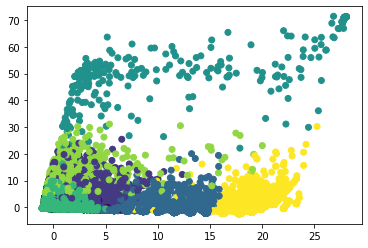

In [151]:
k = 7
kmeans = KMeans(n_clusters=k)
kmeans.fit(X)
kmeans_preds = kmeans.predict(X)

# Plotting the k-means to check how well it did
pca = PCA(n_components=2).fit_transform(X)

# Plot the solution
plt.scatter(pca[:, 0], pca[:, 1], c=kmeans_preds)
plt.show()

Well, it's great that I can make out 6 of the 7 clusters here, so that's definitely preferable to how the DBSCAN clusters turned out.

In [152]:
# Get silhouette score for k-means
print("Silhouette score for k-means: {}\n".format(
    metrics.silhouette_score(X, kmeans_preds, metric='euclidean')))

Silhouette score for k-means: 0.24611179431056027



Also, this is a much better silhouette score. That seems promising.

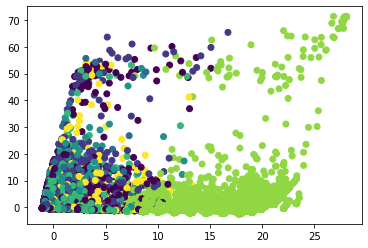

In [153]:
k = 7 
kmodes = KModes(n_clusters=k)
kmodes.fit(X)
kmodes_preds = kmodes.predict(X)

# Plot k-modes with PCA object from before
plt.scatter(pca[:, 0], pca[:, 1], c=kmodes_preds)
plt.show()

In [154]:
# Get silhouette score for k-modes
print("Silhouette score for k-modes: {}\n".format(
    metrics.silhouette_score(X, kmodes_preds, metric='euclidean')))

Silhouette score for k-modes: 0.035235513755254036



So K-Means has achieved the highest silhouette score of the 3 clustering algorithms used here. Its plot is also the easiest to read & pick out separate clusters from, so I'm going to say that this is probably the best one here for this data.

In [158]:
# Check out cluster assignments array

print(kmeans_preds)
print(kmeans_preds.dtype)

[0 0 0 ... 4 4 4]
int32


In [159]:
# Checking length of cluster preds array is the same length as brfss df
print(len(kmeans_preds))

437436


In [160]:
# Placing each observation's cluster assignment in the df 
brfss_eda['km_clusters'] = pd.Series(kmeans_preds, index=brfss_eda.index)

In [161]:
# Look at the new column; make sure it's okay
brfss_eda.head(20)

_state  genhlth  physhlth  menthlth  hlthpln1  persdoc2  medcost  \
0      0.0      1.0      30.0       0.0       1.0         1      0.0   
1      0.0      2.0       0.0       0.0       0.0         1      1.0   
2      0.0      4.0      10.0       0.0       1.0         1      0.0   
3      0.0      0.0       0.0       0.0       1.0         1      0.0   
4      0.0      1.0       0.0       0.0       1.0         2      0.0   
5      0.0      1.0       0.0       0.0       1.0         2      0.0   
6      0.0      0.0       0.0       0.0       1.0         1      0.0   
7      0.0      1.0       0.0       0.0       1.0         1      0.0   
8      0.0      1.0       0.0       0.0       1.0         1      0.0   
9      0.0      2.0       5.0       0.0       1.0         1      0.0   
10     0.0      0.0       0.0       0.0       1.0         2      0.0   
11     0.0      2.0       7.0       2.0       1.0         1      0.0   
12     0.0      1.0       2.0       1.0       0.0         0      1.0   
13     0.0      3.0       0.0       0.0       1.0         1      0.0   
14     0.0      2.0       0.0       0.0       1.0         1      0.0   
15     0.0      2.0       5.0       0.0       1.0         1   1000.0   
16     0.0      2.0    1000.0       0.0       1.0         1      0.0   
17     0.0      2.0       0.0       0.0       1.0         1      0.0   
18     0.0      2.0       0.0       0.0       1.0         0      0.0   
19     0.0      1.0       2.0       2.0       1.0         1      0.0   

    checkup1  sleptim1  cvdinfr4  ...  _race  _ageg5yr        _bmi5  _smoker3  \
0        0.0       7.0       0.0  ...    0.0      12.0  2231.000000         0   
1        1.0       5.0       0.0  ...    1.0       2.0  3328.000000         3   
2        0.0       7.0       0.0  ...    0.0      11.0  2968.000000         0   
3        0.0       6.0       0.0  ...    0.0       9.0  2726.000000         0   
4        0.0       7.0       0.0  ...    0.0       4.0  2811.440614         0   
5        0.0       6.0       0.0  ...    0.0      12.0  3146.000000         0   
6        0.0       8.0       0.0  ...    0.0      11.0  2496.000000         0   
7        0.0       7.0       0.0  ...    0.0       5.0  2163.000000         0   
8        0.0       6.0       0.0  ...    0.0       7.0  2705.000000         1   
9        0.0       7.0       0.0  ...    1.0       5.0  2675.000000         0   
10       0.0      10.0       0.0  ...    0.0      12.0  2699.000000         1   
11       0.0       6.0       0.0  ...    0.0       7.0  3011.000000         0   
12       0.0       6.0       0.0  ...    0.0       5.0  2834.000000         1   
13       0.0       6.0       0.0  ...    0.0      10.0  3433.000000         0   
14       0.0       6.0       0.0  ...    0.0       5.0  3975.000000         1   
15       0.0       7.0       0.0  ...    1.0      11.0  3502.000000         0   
16       0.0       4.0       0.0  ...    0.0       9.0  3396.000000         0   
17       0.0       9.0       0.0  ...    0.0      10.0  3298.000000         0   
18       2.0       6.0       0.0  ...    0.0       6.0  2661.000000         0   
19       0.0       7.0       0.0  ...    0.0      11.0  2369.000000         0   

    drnkany5  _rfbing5  _rfdrhv6  _drnkdrv  _aidtst3  km_clusters  
0        0.0       0.0       0.0    1000.0       0.0            0  
1        1.0       0.0       0.0       0.0       0.0            0  
2        0.0       0.0       0.0    1000.0       0.0            0  
3        0.0       0.0       0.0    1000.0       0.0            0  
4        0.0       0.0       0.0    1000.0       0.0            0  
5        0.0       0.0       0.0    1000.0       0.0            0  
6        0.0       0.0       0.0    1000.0       0.0            0  
7        1.0       0.0       0.0       0.0       0.0            0  
8        1.0       0.0       0.0       0.0       0.0            0  
9        0.0       0.0       0.0    1000.0       1.0            0  
10       0.0       0.0       0.0    1000.

In [162]:
# See the cluster breakdown
print(brfss_eda['km_clusters'].unique())
print(brfss_eda['km_clusters'].value_counts())

[0 1 4 2 5 6 3]
0    315179
1     53563
4     45774
6     10025
2      7977
5      4639
3       279
Name: km_clusters, dtype: int64


Now I'll plot some of the features I'm interested in against these clusters to see how the clusters might be informed by them.

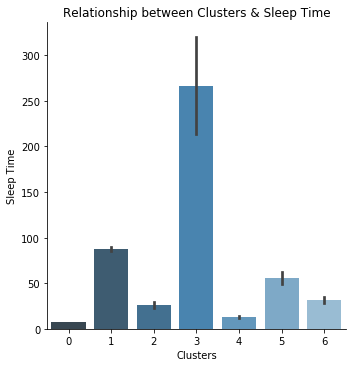

In [163]:
# Plot clusters with sleep time
sns.catplot(x='km_clusters', y='sleptim1', kind='bar', palette='Blues_d', data=brfss_eda)
plt.title('Relationship between Clusters & Sleep Time')
plt.xlabel('Clusters')
plt.ylabel('Sleep Time')
plt.show()

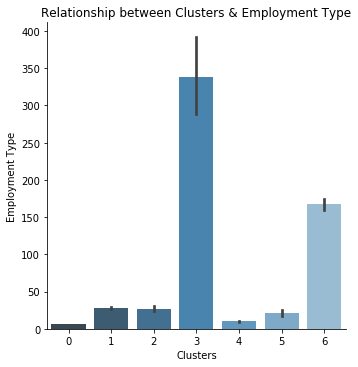

In [175]:
# Plot clusters with employment type
sns.catplot(x='km_clusters', y='employ1', kind='bar', palette='Blues_d', data=brfss_eda)
plt.title('Relationship between Clusters & Employment Type')
plt.xlabel('Clusters')
plt.ylabel('Employment Type')
plt.show()

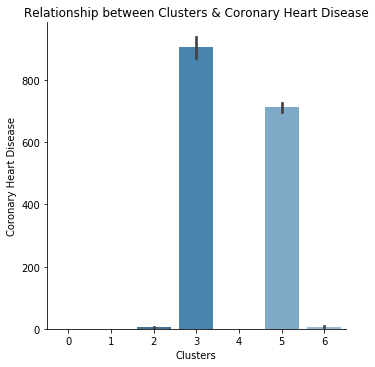

In [167]:
# Plot clusters with cvdcrhd4 - coronary heart disease
sns.catplot(x='km_clusters', y='cvdcrhd4', kind='bar', palette='Blues_d', data=brfss_eda)
plt.title('Relationship between Clusters & Coronary Heart Disease')
plt.xlabel('Clusters')
plt.ylabel('Coronary Heart Disease')
plt.show()

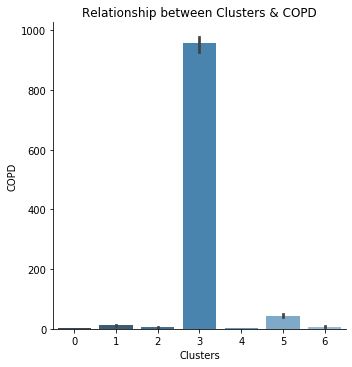

In [168]:
# Plot clusters with chccopd1 - COPD
sns.catplot(x='km_clusters', y='chccopd1', kind='bar', palette='Blues_d', data=brfss_eda)
plt.title('Relationship between Clusters & COPD')
plt.xlabel('Clusters')
plt.ylabel('COPD')
plt.show()

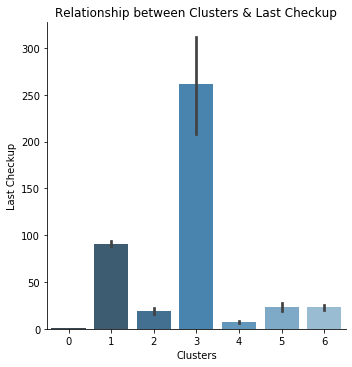

In [176]:
# Plot clusters with checkup1
sns.catplot(x='km_clusters', y='checkup1', kind='bar', palette='Blues_d', data=brfss_eda)
plt.title('Relationship between Clusters & Last Checkup')
plt.xlabel('Clusters')
plt.ylabel('Last Checkup')
plt.show()

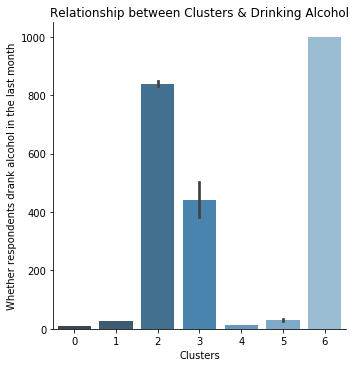

In [169]:
# Plot clusters with drnkany5 - whether respondents drank alcohol in the last month
sns.catplot(x='km_clusters', y='drnkany5', kind='bar', palette='Blues_d', data=brfss_eda)
plt.title('Relationship between Clusters & Drinking Alcohol')
plt.xlabel('Clusters')
plt.ylabel('Whether respondents drank alcohol in the last month')
plt.show()

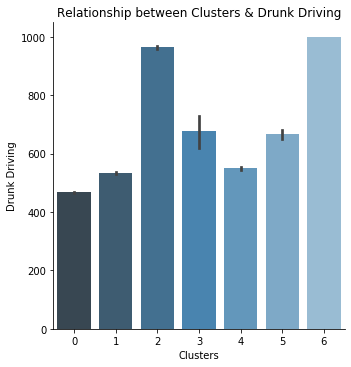

In [171]:
# Plot clusters with _drnkdrv
sns.catplot(x='km_clusters', y='_drnkdrv', kind='bar', palette='Blues_d', data=brfss_eda)
plt.title('Relationship between Clusters & Drunk Driving')
plt.xlabel('Clusters')
plt.ylabel('Drunk Driving')
plt.show()

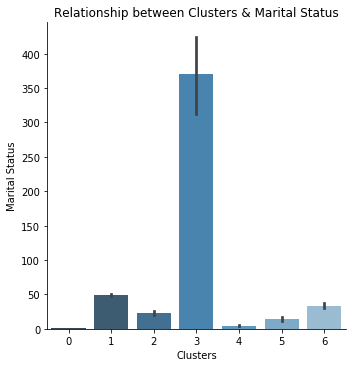

In [172]:
# Plot clusters with marital status
sns.catplot(x='km_clusters', y='marital', kind='bar', palette='Blues_d', data=brfss_eda)
plt.title('Relationship between Clusters & Marital Status')
plt.xlabel('Clusters')
plt.ylabel('Marital Status')
plt.show()

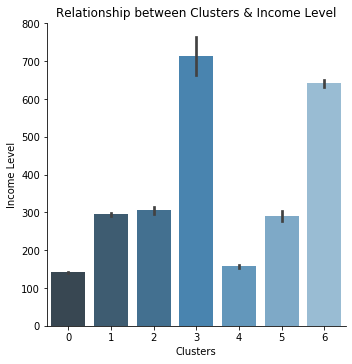

In [173]:
# Plot clusters with income
sns.catplot(x='km_clusters', y='income2', kind='bar', palette='Blues_d', data=brfss_eda)
plt.title('Relationship between Clusters & Income Level')
plt.xlabel('Clusters')
plt.ylabel('Income Level')
plt.show()

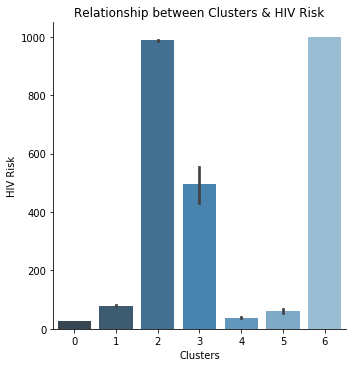

In [174]:
# Plot clusters with hiv risk
sns.catplot(x='km_clusters', y='hivrisk5', kind='bar', palette='Blues_d', data=brfss_eda)
plt.title('Relationship between Clusters & HIV Risk')
plt.xlabel('Clusters')
plt.ylabel('HIV Risk')
plt.show()

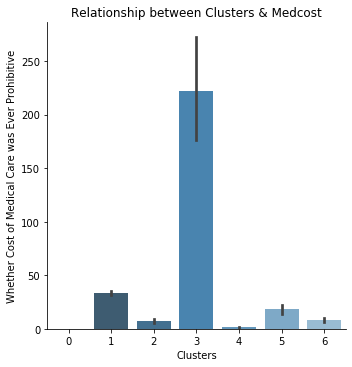

In [177]:
# Plot clusters with medcost
sns.catplot(x='km_clusters', y='medcost', kind='bar', palette='Blues_d', data=brfss_eda)
plt.title('Relationship between Clusters & Medcost')
plt.xlabel('Clusters')
plt.ylabel('Whether Cost of Medical Care was Ever Prohibitive')
plt.show()

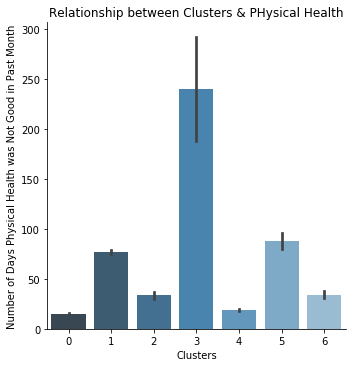

In [178]:
# Plot clusters with physical health
sns.catplot(x='km_clusters', y='physhlth', kind='bar', palette='Blues_d', data=brfss_eda)
plt.title('Relationship between Clusters & Physical Health')
plt.xlabel('Clusters')
plt.ylabel('Number of Days Physical Health was Not Good in Past Month')
plt.show()

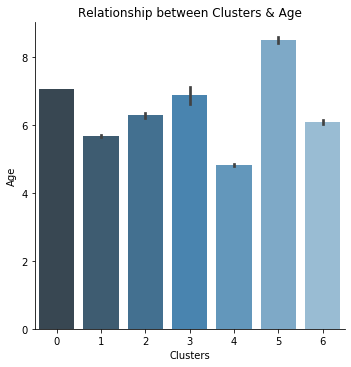

In [179]:
# Plot clusters with age
sns.catplot(x='km_clusters', y='_ageg5yr', kind='bar', palette='Blues_d', data=brfss_eda)
plt.title('Relationship between Clusters & Age')
plt.xlabel('Clusters')
plt.ylabel('Age')
plt.show()

I could go down a serious rabbit hole with trying to figure out more about what the clusters mean, since there are so many features in this dataset. While I wish I could do that, I think it is somewhat outside the scope of this assignment, so for right now, I hope it suffices to say that it looks like these clusters are (at least in part) showing different life stages. For example, cluster 3 may be people in one of the later stages of life - they have much greater incidences of COPD, higher income levels, and receive medical care more often. Judging from some of these same variable,s it seems that cluster 5 may have something to do with middle age. On the other hand, clusters 4, 1, & 6 may have something to do with being younger. That said, I think there is probably something else going on here - perhaps level of affluence or the communitites these respondents live in also dictates many of the health outcomes and demographic factors involved in this data.

# Conclusion

### Recapping the project

In sum, 3 different clustering algorithms were used to try to cluster the BRFSS data from 2018. The various clustering solutions were plotted and assessed based on silhouette score and visualizations. The clustering algorithm with the highest silhouette score and best visualization was K-Means. The clusters were added as an array back into the cleaned BRFSS dataframe, and they were plotted alongside some of the features to try to discern more about the cluster assignments.

### Limitations

Were I to do this again, I might take a random subsample of this dataset, as its largeness compared with the relative smallness of my current computing power meant that it took a VERY long time for some of the algorithms to run. Also, if I had the luxury of more time, it would have been nice to zoom in more on the elbow graph, as its possible the eps value may not have been the ideal one, but the code took too long to run to iterate over it agian and again. Additionally, categorical variables are not necessarily ideal to cluster with, but that was simply a limitation of choosing to work with the BRFSS dataset, which contains mostly categorical variables. This issue was mitigated as much as possible by ensuring all variables were numeric as well as choosing to work with those that did not condense information, but rather retained more variability. Dummies were purposely not used here, because the massive amount of data was already a strain on the computing power available to me; adding more features would have only made it worse to run.

### Conclusion & Implications

Ultimately, when the clusters were plotted alongside various features in the dataset, a few preliminary conclusions about them could be made. Namely, they likely have something to do with the different stages of life humans go through - youth, vs. middle age, vs. old age, etc. Additionally, it's clear there are probably other factors at play here as well, such as economic privilege, lifestyle, etc. More research would need to be done to learn more thoroughly about the clusters.

### Future Research Possibilities

It would be nice to look at more of the BRFSS feature alongside the clusters that were produced here, in order to get a better sense of exactly why the clusters were arranged as they were and to learn more about their meaning. Additionally, it may be a good idea to try some different clustering algorithms, such as HDBSCAN, on this dataset, as it seems the density of the data may have been prohibitive to the DBSCANs that were run here. 

Finally, if only there were more time for further analysis, I would love to delve more into what each of these clusters contain, and really flesh out their meaning.